### TFG MES - Cesar Hernandez Rodriguez
El estudio se hace con los datos historicos de mes a mes (21 dias), se realiza la prediccion de ciertos activos elegidos previamente, si se necesita cualquier otro activo del NASDAQ estan en los otros script ya que esto solo es una pequeña muestra representativa del funcionamiento

Este script se basa en descargar datos de la bolsa de EEUU, exactamente todos los del índice NASDAQ que es uno de los índices más importantes de Estados Unidos (índide tecnologico), siendo la segunda bolsa de valores automatizada y electronica mas grande del mundo con 3800 compañias. (https://es.wikipedia.org/wiki/NASDAQ)

De este conjunto de datos solo voy a coger son $['AAPL', 'SNRC', 'ATVI', 'MINI', 'GOOG', 'BBOX']$ 

Para ello usaré la librería QUANDL (https://www.quandl.com/tools/python) que implementa una API para poder descargar los datos de manera sencilla. Al crearme una cuenta gratuita las opciones que se ofrecen no son las mias que para una cuenata premium por lo que cogere fechas pasadas y no actuales. 

A mayores una vez descagardo los datos (ya que tarda mucho) los voy a guardar dentro de mi ordenador serializandolo con el paquete Pickle (http://pyspanishdoc.sourceforge.net/lib/module-pickle.html)

A la hora de realizar el modelo creo 3 atributos, 2 medias moviles una de 10 dias y otra de 20 dias y un oscilador de la media movil de 20 dias.

Depues de realizar el modelo la idea de la practica es realizar una prueba real, por ello me fio del modelo que he obtenido e imaginando una inversion inical de 100000 euros dejo que la red neuronal haga lo que deba con ese dinero, decidiendo si quiere comprar, vender o mantener. Hay 3 formas programadas, compra a la alza, compra a la alza y a la baja y compra a la baja.

In [1]:
# Import predefinifods
import pandas as pd
import numpy as np
import random
from math import *
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from time import time
import matplotlib.pyplot as plt
from collections import Counter

# Importa descaga de datos
import quandl

# Import serializar
import pickle

# Import red Neuronal
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import SimpleRNN #Redes Recurrentes
from keras.layers import LSTM
from keras.layers import GRU
import keras.backend as K

# Conteo
from collections import Counter

# Graficos
#plt.style.use('fivethirtyeight')
#plt.style.use('dark_background')
plt.style.use('seaborn')

In [2]:
# Descarga de las bases los tickets de los activos que vamos a predecir con los csv de la carpeta
def get_tickers_sample_nasdaq():
    tickers_wiki_quandl = pd.read_csv('WIKI_PRICES.csv')['ticker']
    tickers_nasdaq = pd.read_csv('nasdaq-listed-symbols-TFG.csv')
    
    tickersQuandl = []    
    tickers = pd.DataFrame(columns = ['Symbol','CompanyName'], index = range(len(tickers_nasdaq)))

    for i in range(len(tickers_nasdaq)):
        word = tickers_nasdaq['Symbol'][i]
        for j in range(len(tickers_wiki_quandl)):
            if word == tickers_wiki_quandl[j]:
                tickers['Symbol'][i] = word
                tickers['CompanyName'][i] = tickers_nasdaq['CompanyName'][i]
    
    for tick in tickers['Symbol']:
        tickersQuandl.append("WIKI/"+tick)
    
    return tickers, tickersQuandl

#a,b = get_tickers_sample_nasdaq()

In [3]:
# Descargo de los datos con la API Quandl y la key propia
# Las fechas estan elegidas a convinencia para poder concatenar las fechas y que quede de seguido

def get_data(verbose):
    quandl.ApiConfig.api_key = 'WgQVD8Npfox1MN7SV3Nm'
    tickers, tickersQuandl = get_tickers_sample_nasdaq()
    
    if verbose: print(" ****Empezamos a descargar los datos****\n")
    
    datos = {}
    start_time = time()
    long = len(tickersQuandl)
    i = 0
    # Las fechas elegidas son esas para poder tener una gran cantidad de datos historicos y
    # que justo se complementen con las fechas de tipo test, al hacer Medias Moviles se pierden muchos datos
    for ticker in tickersQuandl:
        if i % 2 == 0 and verbose: print("LLeva descargados el ",i/long *100,"% de los datos")
        #aux=quandl.get(ticker,start_date="2000-01-01",end_date="2016-12-31")
        aux=quandl.get(ticker,start_date="2009-01-01",end_date="2016-12-31")
        datos[ticker[5:len(ticker)]] = aux
        i = i + 1
    
    datosClose = {}
    for key in datos:
        datosClose[key] = datos[key]["Adj. Close"]
    
    elapsed_time = time() - start_time
    if verbose: print("\nHa tardado en descargar los datos: %0.10f segundos." % elapsed_time)
    
    if verbose: print("\n ****Empezamos a descargar los datos test****\n")
    
    # Procedo a hacer las mismas operaciones para el conjunto TEST
    datos_test = {}
    i = 0
    long = len(tickersQuandl)
    start_time = time()    
    for ticker in tickersQuandl:
        if i % 2 == 0 and verbose: print("LLeva descargados el ",i/long *100,"% de los datos test")
        aux=quandl.get(ticker,start_date="2016-11-01",end_date="2020-12-31")
        datos_test[ticker[5:len(ticker)]] = aux
        i = i + 1
    
    datosClose_test = {}
    for key in datos_test:
        datosClose_test[key] = datos_test[key]["Adj. Close"]
    
        elapsed_time = time() - start_time
    if verbose: print("\nHa tardado en descargar los datos test: %0.10f segundos." % elapsed_time)
    if verbose: print("\n")
    
    # Guardamos los datos y serializamos
    pickle.dump(tickers, open("datos_demo/tickers_nasdaq.p", "wb"))
    pickle.dump(tickersQuandl, open("datos_demo/tickersQuandl_nasdaq.p", "wb"))
    pickle.dump(datos, open("datos_demo/nasdaq.p", "wb"))
    pickle.dump(datosClose, open("datos_demo/nasdaqClose.p", "wb"))
    pickle.dump(datos_test, open("datos_demo/nasdaq_testMes.p", "wb"))
    pickle.dump(datosClose_test, open("datos_demo/nasdaqClose_testMes.p", "wb"))
    
    return tickers, tickersQuandl, datos, datosClose, datos_test, datosClose_test

In [4]:
# Si los datos ya han sido descargados con esta funcion los cargo gracias a la libreria pickles
def get_data_load(verbose):
    if verbose: print(" ****Empezamos a cargar los datos****\n")
    tickers = pickle.load(open("datos_demo/tickers_nasdaq.p", "rb" ))
    tickersQuandl = pickle.load(open("datos_demo/tickersQuandl_nasdaq.p", "rb" ))
    datos = pickle.load(open("datos_demo/nasdaq.p", "rb" ))
    datosClose = pickle.load(open("datos_demo/nasdaqClose.p", "rb" ))
    if verbose: print(" ****Cargados los datos****\n")
    
    if verbose: print("\n ****Empezamos a cargar los datos test****\n")
    datos_test = pickle.load(open("datos_demo/nasdaq_testMes.p", "rb" ))
    datosClose_test = pickle.load(open("datos_demo/nasdaqClose_testMes.p", "rb" ))
    if verbose: print(" ****Cargados los datos test****\n")
    
    return tickers, tickersQuandl, datos, datosClose, datos_test, datosClose_test

# Para imprimir cualquier conjunto tipo Serie temporal del conjunto de datos base uso esta funcion
def plot_datos(datosClose,nombre,test):
    datosClose[nombre['Symbol']].plot(figsize=(12,5),grid=True)
    plt.title('{} de la compañia {} {}\n'.format(nombre['Symbol'],nombre['CompanyName'],test))
    plt.ylabel('Precio de Cierre')
    plt.xlabel('Fecha')
    plt.show()
    

In [5]:
datos_descargados = True
if datos_descargados:
    tickers, tickersQuandl, datos, datosClose, datos_test, datosClose_test= get_data_load(True)
else : 
    tickers, tickersQuandl, datos, datosClose, datos_test, datosClose_test = get_data(True)

 ****Empezamos a cargar los datos****

 ****Cargados los datos****


 ****Empezamos a cargar los datos test****

 ****Cargados los datos test****



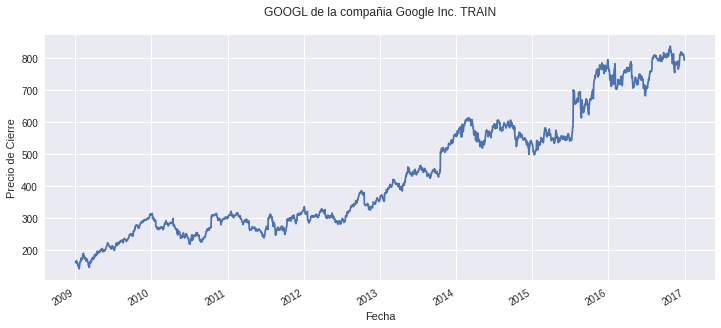

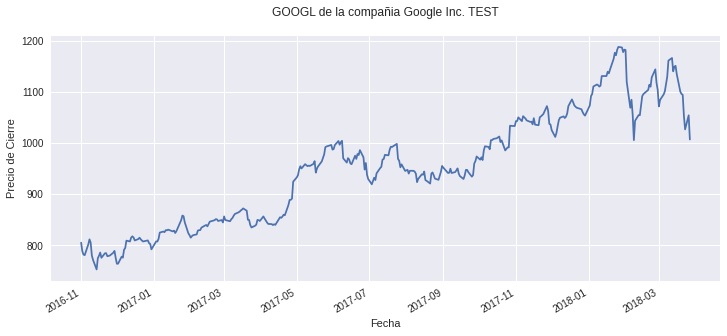

In [6]:
# Grafico un activo aleatorio 
# Se tiene el gráfico con el que se creara el modelo y los datos sobre los que se va a testear
ran = 2
plot_datos(datosClose,tickers.iloc[ran],"TRAIN")
plot_datos(datosClose_test,tickers.iloc[ran],"TEST")

In [7]:
# Creacion de los atributos para la Red Neuronal Recurrente
def differences(x):
    return x[-1] - x[0]

def create_features(datosClose,days1,days2):
    X = pd.DataFrame()
    data = pd.DataFrame()
    data['Adj. Close'] = datosClose.values
    
    indices = datosClose.index
    
    X['MA_{}'.format(days1)] = data['Adj. Close'].rolling(window=days1).mean()
    X['MA_{}'.format(days2)] = data['Adj. Close'].rolling(window=days2).mean()
    X['Diferencia'] = data['Adj. Close'].rolling(window=days2).apply(differences,raw=True) 
    X = X[days2:len(X)-1].reset_index()
    X.drop(['index'], axis='columns', inplace=True)

    return X, indices[(days2+1):len(indices)]

# Creo tambien timestep de 30 dias (igual que la media movil) para la RED NEURONAL
def cut_timestep(x,y,time):
    
    Xt = []
    yt = []
    index_time = []

    for i in range(timeStep, len(x)):
        Xt.append(x[i-timeStep:i,:])
        yt.append(y.iloc[i,0])
        index_time.append(time[i])

    return np.array(Xt), np.array(yt), pd.Series(index_time)

In [8]:
# A parte de la creacion de atributos
index = ran
timeStep = 21 # longitud de secuencias que se hacen en cada iteracion de la red

# Extraigo los atributos de los datos y los preparo para meterlos a la red neuronal

X, ind_time = create_features(datosClose[tickers['Symbol'][index]],10,20)
Y = pd.DataFrame(datosClose[tickers['Symbol'][index]].values[21:len(datosClose[tickers['Symbol'][index]])])
X = X.to_numpy()

# Creamos los atributos para los datos test
ticket_uso = tickers['Symbol'][index]
Xtesteo, ind_time_t = create_features(datosClose_test[tickers['Symbol'][index]],10,20)
Ytesteo = pd.DataFrame(datosClose_test[tickers['Symbol'][index]].values[21:len(datosClose_test[tickers['Symbol'][index]])])
Xtesteo = Xtesteo.to_numpy()

# Junto todos los datos para poder hacer su correcta normalizacion
X_aux = np.concatenate((X,Xtesteo),axis=0)

scaler = MinMaxScaler()
X_aux_scaled = scaler.fit_transform(X_aux)
X_scaled = X_aux_scaled[0:len(X)]
Xtesteo_scaled = X_aux_scaled[len(X):len(X_aux_scaled)]

# Creacion de los timestep
Xt, yt, index_time = cut_timestep(X_scaled,Y,ind_time)
Xtt, ytt, index_time_t = cut_timestep(Xtesteo_scaled,Ytesteo,ind_time_t)

# Split de en conjunto de prueba y entrenamiento para la red neuronal
P=yt.shape[0]
indices=np.arange(P,dtype=int)
np.random.shuffle(indices)
sequences_train=indices[0:int(P*2/3)]
sequences_test=indices[int(P*2/3):]
X_train, X_test, y_train, y_test = Xt[sequences_train],Xt[sequences_test],yt[sequences_train],yt[sequences_test]


print("Voy a predecir el activo {} de la compañia {}".format(ticket_uso,tickers['CompanyName'][index]))

Voy a predecir el activo GOOGL de la compañia Google Inc.


In [9]:
# Calculates a successfull ratio using less relative error than a maximum
def porcentaje_margen(y_true, y_pred):
    margen = 0.05
    yy = K.sum(K.cast(K.less(K.abs((y_pred/y_true)-1.0), margen), dtype=float))
    return yy/K.cast(K.shape(y_pred)[0], dtype=float)

In [14]:
modelRNN42 = Sequential()
modelRNN42.add(SimpleRNN(input_shape=(21,3),units=4,activation='relu',return_sequences=True))
modelRNN42.add(SimpleRNN(2,activation="relu"))
modelRNN42.add(Dense(1)) 
modelRNN42.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelRNN42.summary()
history_RNN42 = modelRNN42.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_3 (SimpleRNN)     (None, 21, 4)             32        
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 2)                 14        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 3         
Total params: 49
Trainable params: 49
Non-trainable params: 0
_________________________________________________________________
Train on 1314 samples, validate on 658 samples
Epoch 1/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 233347.8099 - porcentaje_margen: 0.0000e+00 - val_loss: 224527.3099 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
1314/1314 [==============================] - 1s 692us/step - loss: 233310.4388 - porcentaje_margen: 0.0000e+00 - val_loss: 224490.6694 - val_porce

1314/1314 [==============================] - 1s 677us/step - loss: 231859.8500 - porcentaje_margen: 0.0000e+00 - val_loss: 223069.4974 - val_porcentaje_margen: 0.0000e+00
Epoch 42/1500
1314/1314 [==============================] - 1s 662us/step - loss: 231822.6449 - porcentaje_margen: 0.0000e+00 - val_loss: 223033.0490 - val_porcentaje_margen: 0.0000e+00
Epoch 43/1500
1314/1314 [==============================] - 1s 739us/step - loss: 231785.1642 - porcentaje_margen: 0.0000e+00 - val_loss: 222996.3864 - val_porcentaje_margen: 0.0000e+00
Epoch 44/1500
1314/1314 [==============================] - 1s 764us/step - loss: 231747.9282 - porcentaje_margen: 0.0000e+00 - val_loss: 222959.7848 - val_porcentaje_margen: 0.0000e+00
Epoch 45/1500
1314/1314 [==============================] - 1s 698us/step - loss: 231710.9319 - porcentaje_margen: 0.0000e+00 - val_loss: 222923.6600 - val_porcentaje_margen: 0.0000e+00
Epoch 46/1500
1314/1314 [==============================] - 1s 755us/step - loss: 231673.6

1314/1314 [==============================] - 1s 608us/step - loss: 228609.8379 - porcentaje_margen: 0.0000e+00 - val_loss: 219885.5658 - val_porcentaje_margen: 0.0000e+00
Epoch 130/1500
1314/1314 [==============================] - 1s 650us/step - loss: 228573.1177 - porcentaje_margen: 0.0000e+00 - val_loss: 219849.9170 - val_porcentaje_margen: 0.0000e+00
Epoch 131/1500
1314/1314 [==============================] - 1s 633us/step - loss: 228536.7053 - porcentaje_margen: 0.0000e+00 - val_loss: 219814.2464 - val_porcentaje_margen: 0.0000e+00
Epoch 132/1500
1314/1314 [==============================] - 1s 640us/step - loss: 228500.2529 - porcentaje_margen: 0.0000e+00 - val_loss: 219778.2660 - val_porcentaje_margen: 0.0000e+00
Epoch 133/1500
1314/1314 [==============================] - 1s 611us/step - loss: 228463.6060 - porcentaje_margen: 0.0000e+00 - val_loss: 219742.5485 - val_porcentaje_margen: 0.0000e+00
Epoch 134/1500
1314/1314 [==============================] - 1s 689us/step - loss: 228

1314/1314 [==============================] - 1s 680us/step - loss: 225392.5369 - porcentaje_margen: 0.0000e+00 - val_loss: 216734.3441 - val_porcentaje_margen: 0.0000e+00
Epoch 218/1500
1314/1314 [==============================] - 1s 614us/step - loss: 225356.3242 - porcentaje_margen: 0.0000e+00 - val_loss: 216699.0718 - val_porcentaje_margen: 0.0000e+00
Epoch 219/1500
1314/1314 [==============================] - 1s 638us/step - loss: 225320.1260 - porcentaje_margen: 0.0000e+00 - val_loss: 216663.5644 - val_porcentaje_margen: 0.0000e+00
Epoch 220/1500
1314/1314 [==============================] - 1s 658us/step - loss: 225283.7134 - porcentaje_margen: 0.0000e+00 - val_loss: 216627.7291 - val_porcentaje_margen: 0.0000e+00
Epoch 221/1500
1314/1314 [==============================] - 1s 607us/step - loss: 225247.2208 - porcentaje_margen: 0.0000e+00 - val_loss: 216592.1108 - val_porcentaje_margen: 0.0000e+00
Epoch 222/1500
1314/1314 [==============================] - 1s 635us/step - loss: 225

1314/1314 [==============================] - 1s 585us/step - loss: 222200.9097 - porcentaje_margen: 0.0000e+00 - val_loss: 213608.6750 - val_porcentaje_margen: 0.0000e+00
Epoch 306/1500
1314/1314 [==============================] - 1s 612us/step - loss: 222164.5241 - porcentaje_margen: 0.0000e+00 - val_loss: 213573.2406 - val_porcentaje_margen: 0.0000e+00
Epoch 307/1500
1314/1314 [==============================] - 1s 609us/step - loss: 222128.6051 - porcentaje_margen: 0.0000e+00 - val_loss: 213538.1425 - val_porcentaje_margen: 0.0000e+00
Epoch 308/1500
1314/1314 [==============================] - 1s 655us/step - loss: 222092.8097 - porcentaje_margen: 0.0000e+00 - val_loss: 213503.0893 - val_porcentaje_margen: 0.0000e+00
Epoch 309/1500
1314/1314 [==============================] - 1s 599us/step - loss: 222056.7960 - porcentaje_margen: 0.0000e+00 - val_loss: 213467.7896 - val_porcentaje_margen: 0.0000e+00
Epoch 310/1500
1314/1314 [==============================] - 1s 613us/step - loss: 222

1314/1314 [==============================] - 1s 647us/step - loss: 219035.8790 - porcentaje_margen: 0.0000e+00 - val_loss: 210509.9837 - val_porcentaje_margen: 0.0000e+00
Epoch 394/1500
1314/1314 [==============================] - 1s 600us/step - loss: 218999.9235 - porcentaje_margen: 0.0000e+00 - val_loss: 210474.8477 - val_porcentaje_margen: 0.0000e+00
Epoch 395/1500
1314/1314 [==============================] - 1s 641us/step - loss: 218964.2405 - porcentaje_margen: 0.0000e+00 - val_loss: 210439.8007 - val_porcentaje_margen: 0.0000e+00
Epoch 396/1500
1314/1314 [==============================] - 1s 612us/step - loss: 218928.3062 - porcentaje_margen: 0.0000e+00 - val_loss: 210404.6000 - val_porcentaje_margen: 0.0000e+00
Epoch 397/1500
1314/1314 [==============================] - 1s 621us/step - loss: 218892.5696 - porcentaje_margen: 0.0000e+00 - val_loss: 210369.6969 - val_porcentaje_margen: 0.0000e+00
Epoch 398/1500
1314/1314 [==============================] - 1s 612us/step - loss: 218

Epoch 437/1500
1314/1314 [==============================] - 1s 622us/step - loss: 217462.6805 - porcentaje_margen: 0.0000e+00 - val_loss: 208969.7024 - val_porcentaje_margen: 0.0000e+00
Epoch 438/1500
1314/1314 [==============================] - 1s 639us/step - loss: 217426.8431 - porcentaje_margen: 0.0000e+00 - val_loss: 208934.6301 - val_porcentaje_margen: 0.0000e+00
Epoch 439/1500
1314/1314 [==============================] - 1s 624us/step - loss: 217391.1135 - porcentaje_margen: 0.0000e+00 - val_loss: 208899.5255 - val_porcentaje_margen: 0.0000e+00
Epoch 440/1500
1314/1314 [==============================] - 1s 606us/step - loss: 217355.3691 - porcentaje_margen: 0.0000e+00 - val_loss: 208864.9200 - val_porcentaje_margen: 0.0000e+00
Epoch 441/1500
1314/1314 [==============================] - 1s 602us/step - loss: 217320.0672 - porcentaje_margen: 0.0000e+00 - val_loss: 208830.1721 - val_porcentaje_margen: 0.0000e+00
Epoch 442/1500
1314/1314 [==============================] - 1s 657us/s

1314/1314 [==============================] - 1s 594us/step - loss: 215897.1305 - porcentaje_margen: 0.0000e+00 - val_loss: 207437.1586 - val_porcentaje_margen: 0.0000e+00
Epoch 482/1500
1314/1314 [==============================] - 1s 629us/step - loss: 215861.7703 - porcentaje_margen: 0.0000e+00 - val_loss: 207402.6580 - val_porcentaje_margen: 0.0000e+00
Epoch 483/1500
1314/1314 [==============================] - 1s 603us/step - loss: 215826.1761 - porcentaje_margen: 0.0000e+00 - val_loss: 207367.7557 - val_porcentaje_margen: 0.0000e+00
Epoch 484/1500
1314/1314 [==============================] - 1s 669us/step - loss: 215790.7810 - porcentaje_margen: 0.0000e+00 - val_loss: 207333.2394 - val_porcentaje_margen: 0.0000e+00
Epoch 485/1500
1314/1314 [==============================] - 1s 639us/step - loss: 215755.5262 - porcentaje_margen: 0.0000e+00 - val_loss: 207298.9279 - val_porcentaje_margen: 0.0000e+00
Epoch 486/1500
1314/1314 [==============================] - 1s 645us/step - loss: 215

1314/1314 [==============================] - 1s 649us/step - loss: 212788.6333 - porcentaje_margen: 0.0000e+00 - val_loss: 204394.8794 - val_porcentaje_margen: 0.0000e+00
Epoch 570/1500
1314/1314 [==============================] - 1s 632us/step - loss: 212753.3133 - porcentaje_margen: 0.0000e+00 - val_loss: 204360.0750 - val_porcentaje_margen: 0.0000e+00
Epoch 571/1500
1314/1314 [==============================] - 1s 597us/step - loss: 212717.8987 - porcentaje_margen: 0.0000e+00 - val_loss: 204325.6384 - val_porcentaje_margen: 0.0000e+00
Epoch 572/1500
1314/1314 [==============================] - 1s 598us/step - loss: 212682.8248 - porcentaje_margen: 0.0000e+00 - val_loss: 204291.2258 - val_porcentaje_margen: 0.0000e+00
Epoch 573/1500
1314/1314 [==============================] - 1s 616us/step - loss: 212647.7207 - porcentaje_margen: 0.0000e+00 - val_loss: 204256.8918 - val_porcentaje_margen: 0.0000e+00
Epoch 574/1500
1314/1314 [==============================] - 1s 604us/step - loss: 212

1314/1314 [==============================] - 1s 634us/step - loss: 209704.2409 - porcentaje_margen: 0.0000e+00 - val_loss: 201376.3824 - val_porcentaje_margen: 0.0000e+00
Epoch 658/1500
1314/1314 [==============================] - 1s 601us/step - loss: 209669.0239 - porcentaje_margen: 0.0000e+00 - val_loss: 201341.9976 - val_porcentaje_margen: 0.0000e+00
Epoch 659/1500
1314/1314 [==============================] - 1s 644us/step - loss: 209634.0359 - porcentaje_margen: 0.0000e+00 - val_loss: 201307.7432 - val_porcentaje_margen: 0.0000e+00
Epoch 660/1500
1314/1314 [==============================] - 1s 653us/step - loss: 209598.7770 - porcentaje_margen: 0.0000e+00 - val_loss: 201273.1153 - val_porcentaje_margen: 0.0000e+00
Epoch 661/1500
1314/1314 [==============================] - 1s 615us/step - loss: 209563.6878 - porcentaje_margen: 0.0000e+00 - val_loss: 201238.9763 - val_porcentaje_margen: 0.0000e+00
Epoch 662/1500
1314/1314 [==============================] - 1s 643us/step - loss: 209

1314/1314 [==============================] - 1s 574us/step - loss: 206648.4176 - porcentaje_margen: 0.0000e+00 - val_loss: 198386.7053 - val_porcentaje_margen: 0.0000e+00
Epoch 746/1500
1314/1314 [==============================] - 1s 563us/step - loss: 206613.7871 - porcentaje_margen: 0.0000e+00 - val_loss: 198352.5621 - val_porcentaje_margen: 0.0000e+00
Epoch 747/1500
1314/1314 [==============================] - 1s 564us/step - loss: 206579.3668 - porcentaje_margen: 0.0000e+00 - val_loss: 198319.0993 - val_porcentaje_margen: 0.0000e+00
Epoch 748/1500
1314/1314 [==============================] - 1s 556us/step - loss: 206544.7525 - porcentaje_margen: 0.0000e+00 - val_loss: 198285.4024 - val_porcentaje_margen: 0.0000e+00
Epoch 749/1500
1314/1314 [==============================] - 1s 559us/step - loss: 206510.4850 - porcentaje_margen: 0.0000e+00 - val_loss: 198251.6868 - val_porcentaje_margen: 0.0000e+00
Epoch 750/1500
1314/1314 [==============================] - 1s 546us/step - loss: 206

1314/1314 [==============================] - 1s 567us/step - loss: 203618.5245 - porcentaje_margen: 0.0000e+00 - val_loss: 195422.8230 - val_porcentaje_margen: 0.0000e+00
Epoch 834/1500
1314/1314 [==============================] - 1s 584us/step - loss: 203583.8525 - porcentaje_margen: 0.0000e+00 - val_loss: 195388.8426 - val_porcentaje_margen: 0.0000e+00
Epoch 835/1500
1314/1314 [==============================] - 1s 573us/step - loss: 203549.5540 - porcentaje_margen: 0.0000e+00 - val_loss: 195355.4834 - val_porcentaje_margen: 0.0000e+00
Epoch 836/1500
1314/1314 [==============================] - 1s 579us/step - loss: 203515.3767 - porcentaje_margen: 0.0000e+00 - val_loss: 195321.9580 - val_porcentaje_margen: 0.0000e+00
Epoch 837/1500
1314/1314 [==============================] - 1s 584us/step - loss: 203481.4053 - porcentaje_margen: 0.0000e+00 - val_loss: 195288.7951 - val_porcentaje_margen: 0.0000e+00
Epoch 838/1500
1314/1314 [==============================] - 1s 581us/step - loss: 203

1314/1314 [==============================] - 1s 537us/step - loss: 200618.6514 - porcentaje_margen: 0.0000e+00 - val_loss: 192488.7783 - val_porcentaje_margen: 0.0000e+00
Epoch 922/1500
1314/1314 [==============================] - 1s 566us/step - loss: 200584.9175 - porcentaje_margen: 0.0000e+00 - val_loss: 192456.0071 - val_porcentaje_margen: 0.0000e+00
Epoch 923/1500
1314/1314 [==============================] - 1s 572us/step - loss: 200550.8502 - porcentaje_margen: 0.0000e+00 - val_loss: 192422.6384 - val_porcentaje_margen: 0.0000e+00
Epoch 924/1500
1314/1314 [==============================] - 1s 544us/step - loss: 200516.7488 - porcentaje_margen: 0.0000e+00 - val_loss: 192389.4788 - val_porcentaje_margen: 0.0000e+00
Epoch 925/1500
1314/1314 [==============================] - 1s 559us/step - loss: 200482.9892 - porcentaje_margen: 0.0000e+00 - val_loss: 192356.2567 - val_porcentaje_margen: 0.0000e+00
Epoch 926/1500
1314/1314 [==============================] - 1s 563us/step - loss: 200

1314/1314 [==============================] - 1s 626us/step - loss: 197642.8237 - porcentaje_margen: 0.0000e+00 - val_loss: 189579.3358 - val_porcentaje_margen: 0.0000e+00
Epoch 1010/1500
1314/1314 [==============================] - 1s 618us/step - loss: 197609.1758 - porcentaje_margen: 0.0000e+00 - val_loss: 189546.3730 - val_porcentaje_margen: 0.0000e+00
Epoch 1011/1500
1314/1314 [==============================] - 1s 623us/step - loss: 197575.4209 - porcentaje_margen: 0.0000e+00 - val_loss: 189513.3586 - val_porcentaje_margen: 0.0000e+00
Epoch 1012/1500
1314/1314 [==============================] - 1s 556us/step - loss: 197542.0687 - porcentaje_margen: 0.0000e+00 - val_loss: 189480.9682 - val_porcentaje_margen: 0.0000e+00
Epoch 1013/1500
1314/1314 [==============================] - 1s 602us/step - loss: 197508.7873 - porcentaje_margen: 0.0000e+00 - val_loss: 189448.3102 - val_porcentaje_margen: 0.0000e+00
Epoch 1014/1500
1314/1314 [==============================] - 1s 517us/step - loss

Epoch 1053/1500
1314/1314 [==============================] - 1s 596us/step - loss: 196168.3687 - porcentaje_margen: 0.0000e+00 - val_loss: 188137.8345 - val_porcentaje_margen: 0.0000e+00
Epoch 1054/1500
1314/1314 [==============================] - 1s 584us/step - loss: 196134.9653 - porcentaje_margen: 0.0000e+00 - val_loss: 188105.2535 - val_porcentaje_margen: 0.0000e+00
Epoch 1055/1500
1314/1314 [==============================] - 1s 558us/step - loss: 196101.3664 - porcentaje_margen: 0.0000e+00 - val_loss: 188072.2140 - val_porcentaje_margen: 0.0000e+00
Epoch 1056/1500
1314/1314 [==============================] - 1s 575us/step - loss: 196067.8531 - porcentaje_margen: 0.0000e+00 - val_loss: 188039.5179 - val_porcentaje_margen: 0.0000e+00
Epoch 1057/1500
1314/1314 [==============================] - 1s 520us/step - loss: 196034.3200 - porcentaje_margen: 0.0000e+00 - val_loss: 188006.8492 - val_porcentaje_margen: 0.0000e+00
Epoch 1058/1500
1314/1314 [==============================] - 1s 5

Epoch 1097/1500
1314/1314 [==============================] - 1s 546us/step - loss: 194699.7900 - porcentaje_margen: 0.0000e+00 - val_loss: 186701.9917 - val_porcentaje_margen: 0.0000e+00
Epoch 1098/1500
1314/1314 [==============================] - 1s 531us/step - loss: 194665.8744 - porcentaje_margen: 0.0000e+00 - val_loss: 186668.7391 - val_porcentaje_margen: 0.0000e+00
Epoch 1099/1500
1314/1314 [==============================] - 1s 545us/step - loss: 194632.2969 - porcentaje_margen: 0.0000e+00 - val_loss: 186636.1992 - val_porcentaje_margen: 0.0000e+00
Epoch 1100/1500
1314/1314 [==============================] - 1s 598us/step - loss: 194599.1202 - porcentaje_margen: 0.0000e+00 - val_loss: 186603.6681 - val_porcentaje_margen: 0.0000e+00
Epoch 1101/1500
1314/1314 [==============================] - 1s 598us/step - loss: 194565.7148 - porcentaje_margen: 0.0000e+00 - val_loss: 186571.1009 - val_porcentaje_margen: 0.0000e+00
Epoch 1102/1500
1314/1314 [==============================] - 1s 5

Epoch 1141/1500
1314/1314 [==============================] - 1s 595us/step - loss: 193234.8004 - porcentaje_margen: 0.0000e+00 - val_loss: 185270.2051 - val_porcentaje_margen: 0.0000e+00
Epoch 1142/1500
1314/1314 [==============================] - 1s 589us/step - loss: 193201.7446 - porcentaje_margen: 0.0000e+00 - val_loss: 185238.0044 - val_porcentaje_margen: 0.0000e+00
Epoch 1143/1500
1314/1314 [==============================] - 1s 574us/step - loss: 193168.4665 - porcentaje_margen: 0.0000e+00 - val_loss: 185204.9299 - val_porcentaje_margen: 0.0000e+00
Epoch 1144/1500
1314/1314 [==============================] - 1s 575us/step - loss: 193134.7757 - porcentaje_margen: 0.0000e+00 - val_loss: 185172.4410 - val_porcentaje_margen: 0.0000e+00
Epoch 1145/1500
1314/1314 [==============================] - 1s 584us/step - loss: 193101.4159 - porcentaje_margen: 0.0000e+00 - val_loss: 185139.7475 - val_porcentaje_margen: 0.0000e+00
Epoch 1146/1500
1314/1314 [==============================] - 1s 5

Epoch 1185/1500
1314/1314 [==============================] - 1s 673us/step - loss: 191778.2964 - porcentaje_margen: 0.0000e+00 - val_loss: 183846.6267 - val_porcentaje_margen: 0.0000e+00
Epoch 1186/1500
1314/1314 [==============================] - 1s 574us/step - loss: 191745.1825 - porcentaje_margen: 0.0000e+00 - val_loss: 183814.2388 - val_porcentaje_margen: 0.0000e+00
Epoch 1187/1500
1314/1314 [==============================] - 1s 609us/step - loss: 191711.9198 - porcentaje_margen: 0.0000e+00 - val_loss: 183781.7600 - val_porcentaje_margen: 0.0000e+00
Epoch 1188/1500
1314/1314 [==============================] - 1s 595us/step - loss: 191678.6223 - porcentaje_margen: 0.0000e+00 - val_loss: 183749.4963 - val_porcentaje_margen: 0.0000e+00
Epoch 1189/1500
1314/1314 [==============================] - 1s 633us/step - loss: 191645.9696 - porcentaje_margen: 0.0000e+00 - val_loss: 183717.3563 - val_porcentaje_margen: 0.0000e+00
Epoch 1190/1500
1314/1314 [==============================] - 1s 6

Epoch 1229/1500
1314/1314 [==============================] - 1s 599us/step - loss: 190330.9565 - porcentaje_margen: 0.0000e+00 - val_loss: 182432.0468 - val_porcentaje_margen: 0.0000e+00
Epoch 1230/1500
1314/1314 [==============================] - 1s 603us/step - loss: 190298.1711 - porcentaje_margen: 0.0000e+00 - val_loss: 182400.3857 - val_porcentaje_margen: 0.0000e+00
Epoch 1231/1500
1314/1314 [==============================] - 1s 608us/step - loss: 190265.2168 - porcentaje_margen: 0.0000e+00 - val_loss: 182367.9980 - val_porcentaje_margen: 0.0000e+00
Epoch 1232/1500
1314/1314 [==============================] - 1s 601us/step - loss: 190232.4367 - porcentaje_margen: 0.0000e+00 - val_loss: 182336.0439 - val_porcentaje_margen: 0.0000e+00
Epoch 1233/1500
1314/1314 [==============================] - 1s 620us/step - loss: 190199.9074 - porcentaje_margen: 0.0000e+00 - val_loss: 182304.4271 - val_porcentaje_margen: 0.0000e+00
Epoch 1234/1500
1314/1314 [==============================] - 1s 5

Epoch 1273/1500
1314/1314 [==============================] - 1s 581us/step - loss: 188888.8935 - porcentaje_margen: 0.0000e+00 - val_loss: 181023.1476 - val_porcentaje_margen: 0.0000e+00
Epoch 1274/1500
1314/1314 [==============================] - 1s 574us/step - loss: 188855.9425 - porcentaje_margen: 0.0000e+00 - val_loss: 180991.0688 - val_porcentaje_margen: 0.0000e+00
Epoch 1275/1500
1314/1314 [==============================] - 1s 566us/step - loss: 188823.3700 - porcentaje_margen: 0.0000e+00 - val_loss: 180959.0289 - val_porcentaje_margen: 0.0000e+00
Epoch 1276/1500
1314/1314 [==============================] - 1s 557us/step - loss: 188790.7184 - porcentaje_margen: 0.0000e+00 - val_loss: 180927.3458 - val_porcentaje_margen: 0.0000e+00
Epoch 1277/1500
1314/1314 [==============================] - 1s 543us/step - loss: 188758.3511 - porcentaje_margen: 0.0000e+00 - val_loss: 180895.7434 - val_porcentaje_margen: 0.0000e+00
Epoch 1278/1500
1314/1314 [==============================] - 1s 6

Epoch 1317/1500
1314/1314 [==============================] - 1s 591us/step - loss: 187452.6935 - porcentaje_margen: 0.0000e+00 - val_loss: 179619.8900 - val_porcentaje_margen: 0.0000e+00
Epoch 1318/1500
1314/1314 [==============================] - 1s 573us/step - loss: 187419.9326 - porcentaje_margen: 0.0000e+00 - val_loss: 179588.1367 - val_porcentaje_margen: 0.0000e+00
Epoch 1319/1500
1314/1314 [==============================] - 1s 576us/step - loss: 187386.9553 - porcentaje_margen: 0.0000e+00 - val_loss: 179555.6456 - val_porcentaje_margen: 0.0000e+00
Epoch 1320/1500
1314/1314 [==============================] - 1s 530us/step - loss: 187354.0484 - porcentaje_margen: 0.0000e+00 - val_loss: 179523.5702 - val_porcentaje_margen: 0.0000e+00
Epoch 1321/1500
1314/1314 [==============================] - 1s 581us/step - loss: 187321.4455 - porcentaje_margen: 0.0000e+00 - val_loss: 179492.1086 - val_porcentaje_margen: 0.0000e+00
Epoch 1322/1500
1314/1314 [==============================] - 1s 5

Epoch 1404/1500
1314/1314 [==============================] - 1s 567us/step - loss: 184634.1716 - porcentaje_margen: 0.0000e+00 - val_loss: 176866.7666 - val_porcentaje_margen: 0.0000e+00
Epoch 1405/1500
1314/1314 [==============================] - 1s 510us/step - loss: 184601.8098 - porcentaje_margen: 0.0000e+00 - val_loss: 176835.0857 - val_porcentaje_margen: 0.0000e+00
Epoch 1406/1500
1314/1314 [==============================] - 1s 573us/step - loss: 184569.6895 - porcentaje_margen: 0.0000e+00 - val_loss: 176803.7768 - val_porcentaje_margen: 0.0000e+00
Epoch 1407/1500
1314/1314 [==============================] - 1s 554us/step - loss: 184537.7533 - porcentaje_margen: 0.0000e+00 - val_loss: 176772.8372 - val_porcentaje_margen: 0.0000e+00
Epoch 1408/1500
1314/1314 [==============================] - 1s 581us/step - loss: 184505.7667 - porcentaje_margen: 0.0000e+00 - val_loss: 176741.1514 - val_porcentaje_margen: 0.0000e+00
Epoch 1409/1500
1314/1314 [==============================] - 1s 5

Epoch 1448/1500
1314/1314 [==============================] - 1s 632us/step - loss: 183217.9037 - porcentaje_margen: 0.0000e+00 - val_loss: 175483.3235 - val_porcentaje_margen: 0.0000e+00
Epoch 1449/1500
1314/1314 [==============================] - 1s 575us/step - loss: 183185.8423 - porcentaje_margen: 0.0000e+00 - val_loss: 175452.1037 - val_porcentaje_margen: 0.0000e+00
Epoch 1450/1500
1314/1314 [==============================] - 1s 588us/step - loss: 183153.4987 - porcentaje_margen: 0.0000e+00 - val_loss: 175420.3752 - val_porcentaje_margen: 0.0000e+00
Epoch 1451/1500
1314/1314 [==============================] - 1s 559us/step - loss: 183121.4521 - porcentaje_margen: 0.0000e+00 - val_loss: 175389.5781 - val_porcentaje_margen: 0.0000e+00
Epoch 1452/1500
1314/1314 [==============================] - 1s 555us/step - loss: 183089.2925 - porcentaje_margen: 0.0000e+00 - val_loss: 175357.9991 - val_porcentaje_margen: 0.0000e+00
Epoch 1453/1500
1314/1314 [==============================] - 1s 5

Epoch 1492/1500
1314/1314 [==============================] - 1s 576us/step - loss: 181808.6062 - porcentaje_margen: 0.0000e+00 - val_loss: 174107.3590 - val_porcentaje_margen: 0.0000e+00
Epoch 1493/1500
1314/1314 [==============================] - 1s 557us/step - loss: 181776.8125 - porcentaje_margen: 0.0000e+00 - val_loss: 174076.1819 - val_porcentaje_margen: 0.0000e+00
Epoch 1494/1500
1314/1314 [==============================] - 1s 611us/step - loss: 181745.0743 - porcentaje_margen: 0.0000e+00 - val_loss: 174045.2934 - val_porcentaje_margen: 0.0000e+00
Epoch 1495/1500
1314/1314 [==============================] - 1s 565us/step - loss: 181713.0409 - porcentaje_margen: 0.0000e+00 - val_loss: 174014.0245 - val_porcentaje_margen: 0.0000e+00
Epoch 1496/1500
1314/1314 [==============================] - 1s 556us/step - loss: 181681.4131 - porcentaje_margen: 0.0000e+00 - val_loss: 173982.8554 - val_porcentaje_margen: 0.0000e+00
Epoch 1497/1500
1314/1314 [==============================] - 1s 5

In [10]:
modelRNN84 = Sequential()
modelRNN84.add(SimpleRNN(input_shape=(21,3),units=8,activation='relu',return_sequences=True))
modelRNN84.add(SimpleRNN(4,activation="relu"))
modelRNN84.add(Dense(1)) 
modelRNN84.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelRNN84.summary()
history_RNN84 = modelRNN84.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 21, 8)             96        
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 4)                 52        
_________________________________________________________________
dense (Dense)                (None, 1)                 5         
Total params: 153
Trainable params: 153
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
42/42 [==============================] - 1s 23ms/step - loss: 236973.5625 - porcentaje_margen: 0.0000e+00 - val_loss: 217038.9375 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
42/42 [==============================] - 1s 19ms/step - loss: 233220.9219 - porcentaje_margen: 0.0000e+00 - val_loss: 198204.7812 - val_porcentaje_margen: 0.0000e+00
Epoch 3/1500
42/42 [==========

42/42 [==============================] - 1s 13ms/step - loss: 553.5870 - porcentaje_margen: 0.6830 - val_loss: 785.7296 - val_porcentaje_margen: 0.5359
Epoch 46/1500
42/42 [==============================] - 1s 13ms/step - loss: 670.8368 - porcentaje_margen: 0.6183 - val_loss: 667.9258 - val_porcentaje_margen: 0.5984
Epoch 47/1500
42/42 [==============================] - 1s 13ms/step - loss: 557.8866 - porcentaje_margen: 0.6704 - val_loss: 479.4509 - val_porcentaje_margen: 0.7080
Epoch 48/1500
42/42 [==============================] - 1s 13ms/step - loss: 540.8434 - porcentaje_margen: 0.7016 - val_loss: 462.0459 - val_porcentaje_margen: 0.7073
Epoch 49/1500
42/42 [==============================] - 1s 13ms/step - loss: 528.6087 - porcentaje_margen: 0.7001 - val_loss: 524.7126 - val_porcentaje_margen: 0.6844
Epoch 50/1500
42/42 [==============================] - 1s 13ms/step - loss: 561.7518 - porcentaje_margen: 0.6786 - val_loss: 741.8900 - val_porcentaje_margen: 0.5673
Epoch 51/1500
42/4

42/42 [==============================] - 1s 13ms/step - loss: 489.3130 - porcentaje_margen: 0.7158 - val_loss: 929.5016 - val_porcentaje_margen: 0.4312
Epoch 95/1500
42/42 [==============================] - 1s 13ms/step - loss: 626.8867 - porcentaje_margen: 0.6570 - val_loss: 732.6383 - val_porcentaje_margen: 0.5508
Epoch 96/1500
42/42 [==============================] - 1s 13ms/step - loss: 507.1607 - porcentaje_margen: 0.7195 - val_loss: 415.4810 - val_porcentaje_margen: 0.7260
Epoch 97/1500
42/42 [==============================] - 1s 13ms/step - loss: 478.2497 - porcentaje_margen: 0.7284 - val_loss: 406.9869 - val_porcentaje_margen: 0.7260
Epoch 98/1500
42/42 [==============================] - 1s 13ms/step - loss: 492.4203 - porcentaje_margen: 0.7254 - val_loss: 413.5680 - val_porcentaje_margen: 0.7275
Epoch 99/1500
42/42 [==============================] - 1s 13ms/step - loss: 469.0880 - porcentaje_margen: 0.7307 - val_loss: 459.2492 - val_porcentaje_margen: 0.7007
Epoch 100/1500
42/

42/42 [==============================] - 1s 13ms/step - loss: 443.3473 - porcentaje_margen: 0.7388 - val_loss: 379.6673 - val_porcentaje_margen: 0.7677
Epoch 144/1500
42/42 [==============================] - 1s 15ms/step - loss: 450.3814 - porcentaje_margen: 0.7530 - val_loss: 609.9783 - val_porcentaje_margen: 0.6043
Epoch 145/1500
42/42 [==============================] - 1s 15ms/step - loss: 459.9152 - porcentaje_margen: 0.7269 - val_loss: 376.5443 - val_porcentaje_margen: 0.7703
Epoch 146/1500
42/42 [==============================] - 1s 14ms/step - loss: 473.3860 - porcentaje_margen: 0.7351 - val_loss: 429.8806 - val_porcentaje_margen: 0.7290
Epoch 147/1500
42/42 [==============================] - 1s 14ms/step - loss: 479.3190 - porcentaje_margen: 0.6972 - val_loss: 717.9571 - val_porcentaje_margen: 0.5551
Epoch 148/1500
42/42 [==============================] - 1s 14ms/step - loss: 606.4153 - porcentaje_margen: 0.6399 - val_loss: 638.1946 - val_porcentaje_margen: 0.5863
Epoch 149/150

42/42 [==============================] - 1s 15ms/step - loss: 451.8179 - porcentaje_margen: 0.7396 - val_loss: 355.1858 - val_porcentaje_margen: 0.7674
Epoch 193/1500
42/42 [==============================] - 1s 15ms/step - loss: 404.3668 - porcentaje_margen: 0.7679 - val_loss: 394.4593 - val_porcentaje_margen: 0.7421
Epoch 194/1500
42/42 [==============================] - 1s 16ms/step - loss: 424.0221 - porcentaje_margen: 0.7411 - val_loss: 383.2165 - val_porcentaje_margen: 0.7465
Epoch 195/1500
42/42 [==============================] - 1s 15ms/step - loss: 413.1572 - porcentaje_margen: 0.7679 - val_loss: 565.3807 - val_porcentaje_margen: 0.6326
Epoch 196/1500
42/42 [==============================] - 1s 16ms/step - loss: 411.9131 - porcentaje_margen: 0.7560 - val_loss: 345.2836 - val_porcentaje_margen: 0.7900
Epoch 197/1500
42/42 [==============================] - 1s 16ms/step - loss: 427.6086 - porcentaje_margen: 0.7619 - val_loss: 343.1882 - val_porcentaje_margen: 0.7870
Epoch 198/150

42/42 [==============================] - 1s 13ms/step - loss: 399.5977 - porcentaje_margen: 0.7664 - val_loss: 323.9396 - val_porcentaje_margen: 0.8001
Epoch 242/1500
42/42 [==============================] - 1s 13ms/step - loss: 385.7018 - porcentaje_margen: 0.7537 - val_loss: 359.1380 - val_porcentaje_margen: 0.7603
Epoch 243/1500
42/42 [==============================] - 1s 14ms/step - loss: 406.1614 - porcentaje_margen: 0.7693 - val_loss: 322.6716 - val_porcentaje_margen: 0.8203
Epoch 244/1500
42/42 [==============================] - 1s 14ms/step - loss: 371.3977 - porcentaje_margen: 0.7835 - val_loss: 347.6140 - val_porcentaje_margen: 0.7692
Epoch 245/1500
42/42 [==============================] - 1s 14ms/step - loss: 380.0038 - porcentaje_margen: 0.7850 - val_loss: 322.5201 - val_porcentaje_margen: 0.7998
Epoch 246/1500
42/42 [==============================] - 1s 13ms/step - loss: 394.8245 - porcentaje_margen: 0.7671 - val_loss: 317.0613 - val_porcentaje_margen: 0.8307
Epoch 247/150

42/42 [==============================] - 1s 19ms/step - loss: 355.3080 - porcentaje_margen: 0.7879 - val_loss: 328.2672 - val_porcentaje_margen: 0.7826
Epoch 291/1500
42/42 [==============================] - 1s 17ms/step - loss: 367.3528 - porcentaje_margen: 0.7746 - val_loss: 308.4106 - val_porcentaje_margen: 0.8340
Epoch 292/1500
42/42 [==============================] - 1s 22ms/step - loss: 369.5130 - porcentaje_margen: 0.7716 - val_loss: 307.6688 - val_porcentaje_margen: 0.8310
Epoch 293/1500
42/42 [==============================] - 1s 28ms/step - loss: 363.3021 - porcentaje_margen: 0.7775 - val_loss: 307.4780 - val_porcentaje_margen: 0.8325
Epoch 294/1500
42/42 [==============================] - 1s 33ms/step - loss: 379.0975 - porcentaje_margen: 0.7805 - val_loss: 314.0566 - val_porcentaje_margen: 0.8262
Epoch 295/1500
42/42 [==============================] - 1s 21ms/step - loss: 351.1194 - porcentaje_margen: 0.7946 - val_loss: 359.9838 - val_porcentaje_margen: 0.7528
Epoch 296/150

42/42 [==============================] - 1s 14ms/step - loss: 357.2643 - porcentaje_margen: 0.7954 - val_loss: 316.8197 - val_porcentaje_margen: 0.8031
Epoch 340/1500
42/42 [==============================] - 1s 13ms/step - loss: 418.6859 - porcentaje_margen: 0.7440 - val_loss: 356.3681 - val_porcentaje_margen: 0.8039
Epoch 341/1500
42/42 [==============================] - 1s 14ms/step - loss: 365.3520 - porcentaje_margen: 0.7738 - val_loss: 314.9988 - val_porcentaje_margen: 0.8173
Epoch 342/1500
42/42 [==============================] - 1s 14ms/step - loss: 337.8798 - porcentaje_margen: 0.7909 - val_loss: 615.0645 - val_porcentaje_margen: 0.6014
Epoch 343/1500
42/42 [==============================] - 1s 13ms/step - loss: 445.9457 - porcentaje_margen: 0.7418 - val_loss: 828.1515 - val_porcentaje_margen: 0.4773
Epoch 344/1500
42/42 [==============================] - 1s 14ms/step - loss: 576.7120 - porcentaje_margen: 0.6466 - val_loss: 380.0487 - val_porcentaje_margen: 0.7546
Epoch 345/150

42/42 [==============================] - 1s 13ms/step - loss: 349.8591 - porcentaje_margen: 0.8058 - val_loss: 298.4562 - val_porcentaje_margen: 0.8340
Epoch 389/1500
42/42 [==============================] - 1s 14ms/step - loss: 363.0154 - porcentaje_margen: 0.7865 - val_loss: 372.2858 - val_porcentaje_margen: 0.7707
Epoch 390/1500
42/42 [==============================] - 1s 13ms/step - loss: 389.5052 - porcentaje_margen: 0.7299 - val_loss: 306.3780 - val_porcentaje_margen: 0.8161
Epoch 391/1500
42/42 [==============================] - 1s 14ms/step - loss: 360.4157 - porcentaje_margen: 0.7626 - val_loss: 300.8768 - val_porcentaje_margen: 0.8236
Epoch 392/1500
42/42 [==============================] - 1s 14ms/step - loss: 351.9759 - porcentaje_margen: 0.7894 - val_loss: 403.2823 - val_porcentaje_margen: 0.7082
Epoch 393/1500
42/42 [==============================] - 1s 14ms/step - loss: 375.7061 - porcentaje_margen: 0.7723 - val_loss: 377.4249 - val_porcentaje_margen: 0.7632
Epoch 394/150

42/42 [==============================] - 1s 13ms/step - loss: 375.4732 - porcentaje_margen: 0.7723 - val_loss: 291.1915 - val_porcentaje_margen: 0.8604
Epoch 438/1500
42/42 [==============================] - 1s 14ms/step - loss: 327.9913 - porcentaje_margen: 0.7961 - val_loss: 328.6945 - val_porcentaje_margen: 0.7841
Epoch 439/1500
42/42 [==============================] - 1s 15ms/step - loss: 327.3551 - porcentaje_margen: 0.8065 - val_loss: 287.6515 - val_porcentaje_margen: 0.8519
Epoch 440/1500
42/42 [==============================] - 1s 13ms/step - loss: 322.7404 - porcentaje_margen: 0.8207 - val_loss: 344.2780 - val_porcentaje_margen: 0.7796
Epoch 441/1500
42/42 [==============================] - 1s 13ms/step - loss: 342.4459 - porcentaje_margen: 0.7999 - val_loss: 294.5625 - val_porcentaje_margen: 0.8370
Epoch 442/1500
42/42 [==============================] - 1s 14ms/step - loss: 365.4045 - porcentaje_margen: 0.7865 - val_loss: 367.6314 - val_porcentaje_margen: 0.7808
Epoch 443/150

42/42 [==============================] - 1s 14ms/step - loss: 359.8599 - porcentaje_margen: 0.7946 - val_loss: 333.9287 - val_porcentaje_margen: 0.7826
Epoch 487/1500
42/42 [==============================] - 1s 12ms/step - loss: 338.4226 - porcentaje_margen: 0.7872 - val_loss: 293.7063 - val_porcentaje_margen: 0.8429
Epoch 488/1500
42/42 [==============================] - 1s 13ms/step - loss: 324.8162 - porcentaje_margen: 0.8162 - val_loss: 285.1669 - val_porcentaje_margen: 0.8533
Epoch 489/1500
42/42 [==============================] - 1s 13ms/step - loss: 361.8609 - porcentaje_margen: 0.7917 - val_loss: 375.5540 - val_porcentaje_margen: 0.7320
Epoch 490/1500
42/42 [==============================] - 1s 14ms/step - loss: 354.0300 - porcentaje_margen: 0.7879 - val_loss: 289.8983 - val_porcentaje_margen: 0.8471
Epoch 491/1500
42/42 [==============================] - 1s 14ms/step - loss: 323.9509 - porcentaje_margen: 0.8110 - val_loss: 289.3434 - val_porcentaje_margen: 0.8310
Epoch 492/150

42/42 [==============================] - 1s 13ms/step - loss: 339.1234 - porcentaje_margen: 0.7946 - val_loss: 280.7209 - val_porcentaje_margen: 0.8489
Epoch 536/1500
42/42 [==============================] - 1s 13ms/step - loss: 343.7376 - porcentaje_margen: 0.7887 - val_loss: 403.2132 - val_porcentaje_margen: 0.7439
Epoch 537/1500
42/42 [==============================] - 1s 14ms/step - loss: 433.2228 - porcentaje_margen: 0.7292 - val_loss: 315.5803 - val_porcentaje_margen: 0.8049
Epoch 538/1500
42/42 [==============================] - 1s 13ms/step - loss: 375.3773 - porcentaje_margen: 0.7991 - val_loss: 362.9339 - val_porcentaje_margen: 0.7748
Epoch 539/1500
42/42 [==============================] - 1s 13ms/step - loss: 317.1195 - porcentaje_margen: 0.8222 - val_loss: 317.3703 - val_porcentaje_margen: 0.8001
Epoch 540/1500
42/42 [==============================] - 1s 13ms/step - loss: 317.8868 - porcentaje_margen: 0.8170 - val_loss: 288.1016 - val_porcentaje_margen: 0.8370
Epoch 541/150

42/42 [==============================] - 1s 14ms/step - loss: 340.5975 - porcentaje_margen: 0.8013 - val_loss: 440.9595 - val_porcentaje_margen: 0.6948
Epoch 585/1500
42/42 [==============================] - 1s 14ms/step - loss: 323.8416 - porcentaje_margen: 0.8222 - val_loss: 454.5618 - val_porcentaje_margen: 0.6951
Epoch 586/1500
42/42 [==============================] - 1s 13ms/step - loss: 353.6198 - porcentaje_margen: 0.8021 - val_loss: 295.8032 - val_porcentaje_margen: 0.8310
Epoch 587/1500
42/42 [==============================] - 1s 14ms/step - loss: 340.0385 - porcentaje_margen: 0.7798 - val_loss: 360.6806 - val_porcentaje_margen: 0.7498
Epoch 588/1500
42/42 [==============================] - 1s 14ms/step - loss: 362.2915 - porcentaje_margen: 0.7746 - val_loss: 309.9980 - val_porcentaje_margen: 0.8090
Epoch 589/1500
42/42 [==============================] - 1s 15ms/step - loss: 339.2077 - porcentaje_margen: 0.8013 - val_loss: 292.2166 - val_porcentaje_margen: 0.8280
Epoch 590/150

42/42 [==============================] - 1s 13ms/step - loss: 315.9859 - porcentaje_margen: 0.8155 - val_loss: 279.9321 - val_porcentaje_margen: 0.8441
Epoch 634/1500
42/42 [==============================] - 1s 14ms/step - loss: 335.1862 - porcentaje_margen: 0.8080 - val_loss: 293.2938 - val_porcentaje_margen: 0.8373
Epoch 635/1500
42/42 [==============================] - 1s 13ms/step - loss: 325.4511 - porcentaje_margen: 0.7939 - val_loss: 289.0704 - val_porcentaje_margen: 0.8414
Epoch 636/1500
42/42 [==============================] - 1s 13ms/step - loss: 324.0089 - porcentaje_margen: 0.8088 - val_loss: 275.0786 - val_porcentaje_margen: 0.8489
Epoch 637/1500
42/42 [==============================] - 1s 14ms/step - loss: 305.1768 - porcentaje_margen: 0.8244 - val_loss: 389.7178 - val_porcentaje_margen: 0.7350
Epoch 638/1500
42/42 [==============================] - 1s 13ms/step - loss: 310.1461 - porcentaje_margen: 0.8251 - val_loss: 281.5872 - val_porcentaje_margen: 0.8459
Epoch 639/150

42/42 [==============================] - 1s 14ms/step - loss: 310.5642 - porcentaje_margen: 0.8251 - val_loss: 302.9252 - val_porcentaje_margen: 0.8105
Epoch 683/1500
42/42 [==============================] - 1s 13ms/step - loss: 304.2733 - porcentaje_margen: 0.8251 - val_loss: 280.2239 - val_porcentaje_margen: 0.8444
Epoch 684/1500
42/42 [==============================] - 1s 14ms/step - loss: 310.8822 - porcentaje_margen: 0.8237 - val_loss: 322.7764 - val_porcentaje_margen: 0.8236
Epoch 685/1500
42/42 [==============================] - 1s 14ms/step - loss: 299.0924 - porcentaje_margen: 0.8281 - val_loss: 276.8946 - val_porcentaje_margen: 0.8489
Epoch 686/1500
42/42 [==============================] - 1s 14ms/step - loss: 304.9012 - porcentaje_margen: 0.8251 - val_loss: 331.2158 - val_porcentaje_margen: 0.7751
Epoch 687/1500
42/42 [==============================] - 1s 14ms/step - loss: 298.5482 - porcentaje_margen: 0.8326 - val_loss: 740.4042 - val_porcentaje_margen: 0.4851
Epoch 688/150

42/42 [==============================] - 1s 15ms/step - loss: 295.2827 - porcentaje_margen: 0.8326 - val_loss: 267.3396 - val_porcentaje_margen: 0.8593
Epoch 732/1500
42/42 [==============================] - 1s 13ms/step - loss: 295.2663 - porcentaje_margen: 0.8274 - val_loss: 270.1736 - val_porcentaje_margen: 0.8563
Epoch 733/1500
42/42 [==============================] - 1s 14ms/step - loss: 297.8377 - porcentaje_margen: 0.8259 - val_loss: 270.3499 - val_porcentaje_margen: 0.8519
Epoch 734/1500
42/42 [==============================] - 1s 15ms/step - loss: 291.2997 - porcentaje_margen: 0.8430 - val_loss: 361.3626 - val_porcentaje_margen: 0.7826
Epoch 735/1500
42/42 [==============================] - 1s 13ms/step - loss: 308.2886 - porcentaje_margen: 0.8162 - val_loss: 275.0925 - val_porcentaje_margen: 0.8519
Epoch 736/1500
42/42 [==============================] - 1s 13ms/step - loss: 297.7307 - porcentaje_margen: 0.8199 - val_loss: 265.3223 - val_porcentaje_margen: 0.8578
Epoch 737/150

42/42 [==============================] - 1s 14ms/step - loss: 381.8622 - porcentaje_margen: 0.7567 - val_loss: 672.1572 - val_porcentaje_margen: 0.5686
Epoch 781/1500
42/42 [==============================] - 1s 14ms/step - loss: 364.3075 - porcentaje_margen: 0.7865 - val_loss: 281.2118 - val_porcentaje_margen: 0.8548
Epoch 782/1500
42/42 [==============================] - 1s 13ms/step - loss: 307.2784 - porcentaje_margen: 0.8140 - val_loss: 665.5596 - val_porcentaje_margen: 0.5547
Epoch 783/1500
42/42 [==============================] - 1s 14ms/step - loss: 432.1847 - porcentaje_margen: 0.7418 - val_loss: 268.6528 - val_porcentaje_margen: 0.8638
Epoch 784/1500
42/42 [==============================] - 1s 13ms/step - loss: 294.9095 - porcentaje_margen: 0.8326 - val_loss: 370.2923 - val_porcentaje_margen: 0.7424
Epoch 785/1500
42/42 [==============================] - 1s 13ms/step - loss: 286.1064 - porcentaje_margen: 0.8289 - val_loss: 355.7978 - val_porcentaje_margen: 0.7528
Epoch 786/150

42/42 [==============================] - 1s 15ms/step - loss: 290.5442 - porcentaje_margen: 0.8348 - val_loss: 354.6876 - val_porcentaje_margen: 0.7558
Epoch 830/1500
42/42 [==============================] - 1s 16ms/step - loss: 329.4768 - porcentaje_margen: 0.8147 - val_loss: 279.8986 - val_porcentaje_margen: 0.8399
Epoch 831/1500
42/42 [==============================] - 1s 15ms/step - loss: 270.9791 - porcentaje_margen: 0.8519 - val_loss: 392.9057 - val_porcentaje_margen: 0.7331
Epoch 832/1500
42/42 [==============================] - 1s 14ms/step - loss: 297.7211 - porcentaje_margen: 0.8088 - val_loss: 355.8470 - val_porcentaje_margen: 0.7495
Epoch 833/1500
42/42 [==============================] - 1s 14ms/step - loss: 290.4522 - porcentaje_margen: 0.8274 - val_loss: 307.8647 - val_porcentaje_margen: 0.8385
Epoch 834/1500
42/42 [==============================] - 1s 15ms/step - loss: 281.1472 - porcentaje_margen: 0.8378 - val_loss: 298.0568 - val_porcentaje_margen: 0.8180
Epoch 835/150

42/42 [==============================] - 1s 14ms/step - loss: 285.4582 - porcentaje_margen: 0.8318 - val_loss: 257.7269 - val_porcentaje_margen: 0.8742
Epoch 879/1500
42/42 [==============================] - 1s 13ms/step - loss: 283.3052 - porcentaje_margen: 0.8467 - val_loss: 255.7655 - val_porcentaje_margen: 0.8757
Epoch 880/1500
42/42 [==============================] - 1s 13ms/step - loss: 294.9292 - porcentaje_margen: 0.8229 - val_loss: 405.8240 - val_porcentaje_margen: 0.7361
Epoch 881/1500
42/42 [==============================] - 1s 13ms/step - loss: 284.8238 - porcentaje_margen: 0.8326 - val_loss: 291.1013 - val_porcentaje_margen: 0.8385
Epoch 882/1500
42/42 [==============================] - 1s 13ms/step - loss: 275.4804 - porcentaje_margen: 0.8400 - val_loss: 286.5897 - val_porcentaje_margen: 0.8194
Epoch 883/1500
42/42 [==============================] - 1s 13ms/step - loss: 291.8661 - porcentaje_margen: 0.8385 - val_loss: 360.2677 - val_porcentaje_margen: 0.7569
Epoch 884/150

42/42 [==============================] - 1s 12ms/step - loss: 287.7687 - porcentaje_margen: 0.8408 - val_loss: 323.5023 - val_porcentaje_margen: 0.7736
Epoch 928/1500
42/42 [==============================] - 1s 12ms/step - loss: 287.1986 - porcentaje_margen: 0.8445 - val_loss: 323.7109 - val_porcentaje_margen: 0.7826
Epoch 929/1500
42/42 [==============================] - 1s 13ms/step - loss: 254.0581 - porcentaje_margen: 0.8609 - val_loss: 274.6559 - val_porcentaje_margen: 0.8403
Epoch 930/1500
42/42 [==============================] - 1s 14ms/step - loss: 276.0696 - porcentaje_margen: 0.8482 - val_loss: 256.4360 - val_porcentaje_margen: 0.8581
Epoch 931/1500
42/42 [==============================] - 1s 12ms/step - loss: 279.3612 - porcentaje_margen: 0.8430 - val_loss: 260.7189 - val_porcentaje_margen: 0.8623
Epoch 932/1500
42/42 [==============================] - 1s 14ms/step - loss: 265.4299 - porcentaje_margen: 0.8586 - val_loss: 256.6067 - val_porcentaje_margen: 0.8712
Epoch 933/150

42/42 [==============================] - 1s 13ms/step - loss: 284.6809 - porcentaje_margen: 0.8415 - val_loss: 253.8052 - val_porcentaje_margen: 0.8712
Epoch 977/1500
42/42 [==============================] - 1s 14ms/step - loss: 277.0497 - porcentaje_margen: 0.8438 - val_loss: 248.0330 - val_porcentaje_margen: 0.8757
Epoch 978/1500
42/42 [==============================] - 1s 13ms/step - loss: 255.7170 - porcentaje_margen: 0.8601 - val_loss: 418.7095 - val_porcentaje_margen: 0.7153
Epoch 979/1500
42/42 [==============================] - 1s 14ms/step - loss: 336.8312 - porcentaje_margen: 0.7969 - val_loss: 253.5170 - val_porcentaje_margen: 0.8682
Epoch 980/1500
42/42 [==============================] - 1s 14ms/step - loss: 299.5985 - porcentaje_margen: 0.8274 - val_loss: 266.6832 - val_porcentaje_margen: 0.8593
Epoch 981/1500
42/42 [==============================] - 1s 14ms/step - loss: 302.3865 - porcentaje_margen: 0.8363 - val_loss: 514.3037 - val_porcentaje_margen: 0.6624
Epoch 982/150

Epoch 1025/1500
42/42 [==============================] - 1s 13ms/step - loss: 255.2124 - porcentaje_margen: 0.8534 - val_loss: 380.2379 - val_porcentaje_margen: 0.7793
Epoch 1026/1500
42/42 [==============================] - 1s 13ms/step - loss: 273.8856 - porcentaje_margen: 0.8333 - val_loss: 773.4846 - val_porcentaje_margen: 0.4732
Epoch 1027/1500
42/42 [==============================] - 1s 14ms/step - loss: 519.0063 - porcentaje_margen: 0.6756 - val_loss: 491.1328 - val_porcentaje_margen: 0.6632
Epoch 1028/1500
42/42 [==============================] - 1s 13ms/step - loss: 309.8222 - porcentaje_margen: 0.7865 - val_loss: 269.9464 - val_porcentaje_margen: 0.8459
Epoch 1029/1500
42/42 [==============================] - 1s 14ms/step - loss: 273.4826 - porcentaje_margen: 0.8475 - val_loss: 248.4472 - val_porcentaje_margen: 0.8742
Epoch 1030/1500
42/42 [==============================] - 1s 14ms/step - loss: 255.3372 - porcentaje_margen: 0.8586 - val_loss: 341.4827 - val_porcentaje_margen:

Epoch 1074/1500
42/42 [==============================] - 1s 12ms/step - loss: 256.1444 - porcentaje_margen: 0.8460 - val_loss: 401.8627 - val_porcentaje_margen: 0.7108
Epoch 1075/1500
42/42 [==============================] - 1s 14ms/step - loss: 262.8869 - porcentaje_margen: 0.8571 - val_loss: 267.9521 - val_porcentaje_margen: 0.8590
Epoch 1076/1500
42/42 [==============================] - 1s 13ms/step - loss: 238.5311 - porcentaje_margen: 0.8601 - val_loss: 245.0397 - val_porcentaje_margen: 0.8801
Epoch 1077/1500
42/42 [==============================] - 1s 13ms/step - loss: 267.8480 - porcentaje_margen: 0.8460 - val_loss: 313.9528 - val_porcentaje_margen: 0.8117
Epoch 1078/1500
42/42 [==============================] - 1s 13ms/step - loss: 252.5284 - porcentaje_margen: 0.8646 - val_loss: 497.0102 - val_porcentaje_margen: 0.6505
Epoch 1079/1500
42/42 [==============================] - 1s 13ms/step - loss: 257.0858 - porcentaje_margen: 0.8415 - val_loss: 614.0002 - val_porcentaje_margen:

Epoch 1123/1500
42/42 [==============================] - 1s 15ms/step - loss: 459.1012 - porcentaje_margen: 0.7180 - val_loss: 667.8231 - val_porcentaje_margen: 0.5142
Epoch 1124/1500
42/42 [==============================] - 1s 16ms/step - loss: 326.1559 - porcentaje_margen: 0.8036 - val_loss: 308.6953 - val_porcentaje_margen: 0.8191
Epoch 1125/1500
42/42 [==============================] - 1s 14ms/step - loss: 228.0588 - porcentaje_margen: 0.8676 - val_loss: 379.4255 - val_porcentaje_margen: 0.7335
Epoch 1126/1500
42/42 [==============================] - 1s 14ms/step - loss: 248.9334 - porcentaje_margen: 0.8512 - val_loss: 287.0681 - val_porcentaje_margen: 0.8310
Epoch 1127/1500
42/42 [==============================] - 1s 14ms/step - loss: 246.7729 - porcentaje_margen: 0.8646 - val_loss: 369.6003 - val_porcentaje_margen: 0.7599
Epoch 1128/1500
42/42 [==============================] - 1s 13ms/step - loss: 328.6948 - porcentaje_margen: 0.7969 - val_loss: 418.3716 - val_porcentaje_margen:

Epoch 1172/1500
42/42 [==============================] - 1s 14ms/step - loss: 241.9681 - porcentaje_margen: 0.8512 - val_loss: 476.1368 - val_porcentaje_margen: 0.6683
Epoch 1173/1500
42/42 [==============================] - 1s 14ms/step - loss: 234.7813 - porcentaje_margen: 0.8772 - val_loss: 306.2616 - val_porcentaje_margen: 0.8180
Epoch 1174/1500
42/42 [==============================] - 1s 13ms/step - loss: 246.1422 - porcentaje_margen: 0.8579 - val_loss: 294.6967 - val_porcentaje_margen: 0.8355
Epoch 1175/1500
42/42 [==============================] - 1s 14ms/step - loss: 217.8601 - porcentaje_margen: 0.8854 - val_loss: 238.7547 - val_porcentaje_margen: 0.8798
Epoch 1176/1500
42/42 [==============================] - 1s 13ms/step - loss: 221.6366 - porcentaje_margen: 0.8720 - val_loss: 289.2207 - val_porcentaje_margen: 0.8295
Epoch 1177/1500
42/42 [==============================] - 1s 14ms/step - loss: 213.4669 - porcentaje_margen: 0.8839 - val_loss: 336.0665 - val_porcentaje_margen:

Epoch 1221/1500
42/42 [==============================] - 1s 14ms/step - loss: 228.8249 - porcentaje_margen: 0.8735 - val_loss: 263.4911 - val_porcentaje_margen: 0.8593
Epoch 1222/1500
42/42 [==============================] - 1s 13ms/step - loss: 244.4991 - porcentaje_margen: 0.8676 - val_loss: 241.7909 - val_porcentaje_margen: 0.8876
Epoch 1223/1500
42/42 [==============================] - 1s 13ms/step - loss: 214.9901 - porcentaje_margen: 0.8832 - val_loss: 262.2853 - val_porcentaje_margen: 0.8578
Epoch 1224/1500
42/42 [==============================] - 1s 13ms/step - loss: 239.5772 - porcentaje_margen: 0.8631 - val_loss: 233.6381 - val_porcentaje_margen: 0.8932
Epoch 1225/1500
42/42 [==============================] - 1s 13ms/step - loss: 226.4534 - porcentaje_margen: 0.8638 - val_loss: 298.9297 - val_porcentaje_margen: 0.8117
Epoch 1226/1500
42/42 [==============================] - 1s 13ms/step - loss: 224.7073 - porcentaje_margen: 0.8616 - val_loss: 243.7722 - val_porcentaje_margen:

Epoch 1270/1500
42/42 [==============================] - 1s 14ms/step - loss: 220.6413 - porcentaje_margen: 0.8795 - val_loss: 411.2516 - val_porcentaje_margen: 0.7293
Epoch 1271/1500
42/42 [==============================] - 1s 14ms/step - loss: 271.5817 - porcentaje_margen: 0.8445 - val_loss: 241.8612 - val_porcentaje_margen: 0.8947
Epoch 1272/1500
42/42 [==============================] - 1s 14ms/step - loss: 221.6809 - porcentaje_margen: 0.8683 - val_loss: 294.5148 - val_porcentaje_margen: 0.8194
Epoch 1273/1500
42/42 [==============================] - 1s 14ms/step - loss: 210.1956 - porcentaje_margen: 0.8571 - val_loss: 232.3124 - val_porcentaje_margen: 0.8902
Epoch 1274/1500
42/42 [==============================] - 1s 13ms/step - loss: 215.7671 - porcentaje_margen: 0.8668 - val_loss: 233.0695 - val_porcentaje_margen: 0.8846
Epoch 1275/1500
42/42 [==============================] - 1s 13ms/step - loss: 211.6646 - porcentaje_margen: 0.8914 - val_loss: 454.1514 - val_porcentaje_margen:

Epoch 1319/1500
42/42 [==============================] - 1s 17ms/step - loss: 215.8084 - porcentaje_margen: 0.8929 - val_loss: 234.5803 - val_porcentaje_margen: 0.8935
Epoch 1320/1500
42/42 [==============================] - 1s 29ms/step - loss: 217.9875 - porcentaje_margen: 0.8705 - val_loss: 245.5433 - val_porcentaje_margen: 0.8962
Epoch 1321/1500
42/42 [==============================] - 1s 18ms/step - loss: 225.1113 - porcentaje_margen: 0.8832 - val_loss: 261.4720 - val_porcentaje_margen: 0.8590
Epoch 1322/1500
42/42 [==============================] - 1s 16ms/step - loss: 218.0610 - porcentaje_margen: 0.8824 - val_loss: 232.6240 - val_porcentaje_margen: 0.8828
Epoch 1323/1500
42/42 [==============================] - 1s 17ms/step - loss: 230.4039 - porcentaje_margen: 0.8609 - val_loss: 377.3146 - val_porcentaje_margen: 0.7822
Epoch 1324/1500
42/42 [==============================] - 1s 16ms/step - loss: 264.3081 - porcentaje_margen: 0.8378 - val_loss: 234.0039 - val_porcentaje_margen:

42/42 [==============================] - 1s 14ms/step - loss: 206.2498 - porcentaje_margen: 0.8780 - val_loss: 360.3927 - val_porcentaje_margen: 0.7781
Epoch 1368/1500
42/42 [==============================] - 1s 13ms/step - loss: 225.2224 - porcentaje_margen: 0.8683 - val_loss: 294.9143 - val_porcentaje_margen: 0.8165
Epoch 1369/1500
42/42 [==============================] - 1s 13ms/step - loss: 239.2496 - porcentaje_margen: 0.8653 - val_loss: 263.2497 - val_porcentaje_margen: 0.8504
Epoch 1370/1500
42/42 [==============================] - 1s 14ms/step - loss: 204.9966 - porcentaje_margen: 0.8854 - val_loss: 238.3514 - val_porcentaje_margen: 0.8828
Epoch 1371/1500
42/42 [==============================] - 1s 14ms/step - loss: 226.9154 - porcentaje_margen: 0.8787 - val_loss: 257.2145 - val_porcentaje_margen: 0.8887
Epoch 1372/1500
42/42 [==============================] - 1s 14ms/step - loss: 202.3334 - porcentaje_margen: 0.8906 - val_loss: 304.5760 - val_porcentaje_margen: 0.7998
Epoch 13

Epoch 1416/1500
42/42 [==============================] - 1s 15ms/step - loss: 236.9360 - porcentaje_margen: 0.8720 - val_loss: 283.8111 - val_porcentaje_margen: 0.8209
Epoch 1417/1500
42/42 [==============================] - 1s 13ms/step - loss: 242.5379 - porcentaje_margen: 0.8646 - val_loss: 276.2641 - val_porcentaje_margen: 0.8254
Epoch 1418/1500
42/42 [==============================] - 1s 13ms/step - loss: 221.1133 - porcentaje_margen: 0.8757 - val_loss: 229.3776 - val_porcentaje_margen: 0.8887
Epoch 1419/1500
42/42 [==============================] - 1s 14ms/step - loss: 212.5954 - porcentaje_margen: 0.8862 - val_loss: 238.5327 - val_porcentaje_margen: 0.8783
Epoch 1420/1500
42/42 [==============================] - 1s 14ms/step - loss: 205.3669 - porcentaje_margen: 0.8802 - val_loss: 228.7672 - val_porcentaje_margen: 0.8887
Epoch 1421/1500
42/42 [==============================] - 1s 13ms/step - loss: 224.9565 - porcentaje_margen: 0.8728 - val_loss: 249.9609 - val_porcentaje_margen:

Epoch 1465/1500
42/42 [==============================] - 1s 14ms/step - loss: 196.1935 - porcentaje_margen: 0.9003 - val_loss: 222.1800 - val_porcentaje_margen: 0.9006
Epoch 1466/1500
42/42 [==============================] - 1s 13ms/step - loss: 213.1454 - porcentaje_margen: 0.8802 - val_loss: 228.3033 - val_porcentaje_margen: 0.9048
Epoch 1467/1500
42/42 [==============================] - 1s 14ms/step - loss: 214.9717 - porcentaje_margen: 0.8847 - val_loss: 240.8169 - val_porcentaje_margen: 0.8709
Epoch 1468/1500
42/42 [==============================] - 1s 14ms/step - loss: 209.1231 - porcentaje_margen: 0.8824 - val_loss: 241.8566 - val_porcentaje_margen: 0.9003
Epoch 1469/1500
42/42 [==============================] - 1s 14ms/step - loss: 226.1325 - porcentaje_margen: 0.8832 - val_loss: 225.3033 - val_porcentaje_margen: 0.8947
Epoch 1470/1500
42/42 [==============================] - 1s 14ms/step - loss: 197.6115 - porcentaje_margen: 0.8988 - val_loss: 262.7193 - val_porcentaje_margen:

In [11]:
modelRNN168 = Sequential()
modelRNN168.add(SimpleRNN(input_shape=(21,3),units=16,activation='relu',return_sequences=True))
modelRNN168.add(SimpleRNN(8,activation="relu"))
modelRNN168.add(Dense(1)) 
modelRNN168.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelRNN168.summary()
history_RNN168 = modelRNN168.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 21, 16)            320       
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 8)                 200       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 529
Trainable params: 529
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
42/42 [==============================] - 1s 21ms/step - loss: 233555.7500 - porcentaje_margen: 0.0000e+00 - val_loss: 181968.5000 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
42/42 [==============================] - 1s 15ms/step - loss: 37626.0898 - porcentaje_margen: 0.1339 - val_loss: 3356.3838 - val_porcentaje_margen: 0.2841
Epoch 3/1500
42/42 [===================

Epoch 46/1500
42/42 [==============================] - 1s 15ms/step - loss: 962.7845 - porcentaje_margen: 0.5372 - val_loss: 760.4380 - val_porcentaje_margen: 0.5747
Epoch 47/1500
42/42 [==============================] - 1s 14ms/step - loss: 811.7003 - porcentaje_margen: 0.5647 - val_loss: 990.0057 - val_porcentaje_margen: 0.5222
Epoch 48/1500
42/42 [==============================] - 1s 14ms/step - loss: 875.8270 - porcentaje_margen: 0.5528 - val_loss: 821.6363 - val_porcentaje_margen: 0.5731
Epoch 49/1500
42/42 [==============================] - 1s 13ms/step - loss: 846.9782 - porcentaje_margen: 0.5878 - val_loss: 762.8409 - val_porcentaje_margen: 0.5961
Epoch 50/1500
42/42 [==============================] - 1s 13ms/step - loss: 801.9142 - porcentaje_margen: 0.5781 - val_loss: 723.2961 - val_porcentaje_margen: 0.5792
Epoch 51/1500
42/42 [==============================] - 1s 13ms/step - loss: 851.7643 - porcentaje_margen: 0.5789 - val_loss: 862.0828 - val_porcentaje_margen: 0.5698
Epoc

42/42 [==============================] - 1s 13ms/step - loss: 803.0024 - porcentaje_margen: 0.6049 - val_loss: 649.9675 - val_porcentaje_margen: 0.6306
Epoch 96/1500
42/42 [==============================] - 1s 13ms/step - loss: 775.5842 - porcentaje_margen: 0.5960 - val_loss: 891.3786 - val_porcentaje_margen: 0.5508
Epoch 97/1500
42/42 [==============================] - 1s 13ms/step - loss: 816.9169 - porcentaje_margen: 0.5871 - val_loss: 724.6968 - val_porcentaje_margen: 0.5914
Epoch 98/1500
42/42 [==============================] - 1s 13ms/step - loss: 740.2762 - porcentaje_margen: 0.6042 - val_loss: 667.0416 - val_porcentaje_margen: 0.6195
Epoch 99/1500
42/42 [==============================] - 1s 12ms/step - loss: 760.3606 - porcentaje_margen: 0.5744 - val_loss: 653.3977 - val_porcentaje_margen: 0.6318
Epoch 100/1500
42/42 [==============================] - 1s 14ms/step - loss: 795.1376 - porcentaje_margen: 0.5454 - val_loss: 670.0789 - val_porcentaje_margen: 0.6181
Epoch 101/1500
42

42/42 [==============================] - 1s 13ms/step - loss: 772.3847 - porcentaje_margen: 0.5818 - val_loss: 612.0193 - val_porcentaje_margen: 0.6698
Epoch 145/1500
42/42 [==============================] - 1s 13ms/step - loss: 802.2087 - porcentaje_margen: 0.5737 - val_loss: 992.4571 - val_porcentaje_margen: 0.5040
Epoch 146/1500
42/42 [==============================] - 1s 13ms/step - loss: 961.6783 - porcentaje_margen: 0.5126 - val_loss: 705.0084 - val_porcentaje_margen: 0.5974
Epoch 147/1500
42/42 [==============================] - 1s 13ms/step - loss: 786.3492 - porcentaje_margen: 0.6012 - val_loss: 701.6837 - val_porcentaje_margen: 0.5944
Epoch 148/1500
42/42 [==============================] - 1s 13ms/step - loss: 731.1548 - porcentaje_margen: 0.6049 - val_loss: 706.7946 - val_porcentaje_margen: 0.6043
Epoch 149/1500
42/42 [==============================] - 1s 13ms/step - loss: 726.3359 - porcentaje_margen: 0.5811 - val_loss: 1315.4211 - val_porcentaje_margen: 0.4180
Epoch 150/15

42/42 [==============================] - 1s 13ms/step - loss: 718.2256 - porcentaje_margen: 0.6176 - val_loss: 594.9628 - val_porcentaje_margen: 0.6746
Epoch 194/1500
42/42 [==============================] - 1s 14ms/step - loss: 689.5717 - porcentaje_margen: 0.6183 - val_loss: 588.0494 - val_porcentaje_margen: 0.6695
Epoch 195/1500
42/42 [==============================] - 1s 14ms/step - loss: 823.2689 - porcentaje_margen: 0.5863 - val_loss: 1043.6946 - val_porcentaje_margen: 0.4775
Epoch 196/1500
42/42 [==============================] - 1s 14ms/step - loss: 742.8523 - porcentaje_margen: 0.5938 - val_loss: 607.0543 - val_porcentaje_margen: 0.6642
Epoch 197/1500
42/42 [==============================] - 1s 13ms/step - loss: 795.3469 - porcentaje_margen: 0.5923 - val_loss: 745.2242 - val_porcentaje_margen: 0.5891
Epoch 198/1500
42/42 [==============================] - 1s 13ms/step - loss: 720.1230 - porcentaje_margen: 0.6057 - val_loss: 1469.5568 - val_porcentaje_margen: 0.3659
Epoch 199/1

42/42 [==============================] - 1s 13ms/step - loss: 763.2255 - porcentaje_margen: 0.6124 - val_loss: 830.8666 - val_porcentaje_margen: 0.5418
Epoch 243/1500
42/42 [==============================] - 1s 14ms/step - loss: 716.0527 - porcentaje_margen: 0.6257 - val_loss: 1145.6909 - val_porcentaje_margen: 0.4261
Epoch 244/1500
42/42 [==============================] - 1s 13ms/step - loss: 734.6782 - porcentaje_margen: 0.5967 - val_loss: 600.6197 - val_porcentaje_margen: 0.6553
Epoch 245/1500
42/42 [==============================] - 1s 13ms/step - loss: 683.8511 - porcentaje_margen: 0.6071 - val_loss: 1507.0491 - val_porcentaje_margen: 0.3606
Epoch 246/1500
42/42 [==============================] - 1s 13ms/step - loss: 1013.9921 - porcentaje_margen: 0.5335 - val_loss: 1458.1381 - val_porcentaje_margen: 0.3591
Epoch 247/1500
42/42 [==============================] - 1s 13ms/step - loss: 800.3525 - porcentaje_margen: 0.5729 - val_loss: 928.8427 - val_porcentaje_margen: 0.5150
Epoch 248

42/42 [==============================] - 1s 13ms/step - loss: 670.6089 - porcentaje_margen: 0.6324 - val_loss: 566.0305 - val_porcentaje_margen: 0.6820
Epoch 292/1500
42/42 [==============================] - 1s 12ms/step - loss: 644.0057 - porcentaje_margen: 0.6168 - val_loss: 686.3345 - val_porcentaje_margen: 0.6133
Epoch 293/1500
42/42 [==============================] - 1s 12ms/step - loss: 806.9579 - porcentaje_margen: 0.5841 - val_loss: 606.7686 - val_porcentaje_margen: 0.6295
Epoch 294/1500
42/42 [==============================] - 1s 13ms/step - loss: 870.0472 - porcentaje_margen: 0.5432 - val_loss: 697.9716 - val_porcentaje_margen: 0.5966
Epoch 295/1500
42/42 [==============================] - 1s 12ms/step - loss: 654.5118 - porcentaje_margen: 0.6414 - val_loss: 667.7371 - val_porcentaje_margen: 0.6085
Epoch 296/1500
42/42 [==============================] - 1s 13ms/step - loss: 672.3003 - porcentaje_margen: 0.6228 - val_loss: 587.5131 - val_porcentaje_margen: 0.6597
Epoch 297/150

42/42 [==============================] - 1s 15ms/step - loss: 654.4460 - porcentaje_margen: 0.6324 - val_loss: 929.4853 - val_porcentaje_margen: 0.5255
Epoch 341/1500
42/42 [==============================] - 1s 16ms/step - loss: 668.9390 - porcentaje_margen: 0.6287 - val_loss: 574.6042 - val_porcentaje_margen: 0.6713
Epoch 342/1500
42/42 [==============================] - 1s 17ms/step - loss: 667.9232 - porcentaje_margen: 0.6376 - val_loss: 551.2864 - val_porcentaje_margen: 0.6791
Epoch 343/1500
42/42 [==============================] - 1s 14ms/step - loss: 642.8541 - porcentaje_margen: 0.6376 - val_loss: 1237.0322 - val_porcentaje_margen: 0.4031
Epoch 344/1500
42/42 [==============================] - 1s 13ms/step - loss: 1046.6616 - porcentaje_margen: 0.4985 - val_loss: 640.1268 - val_porcentaje_margen: 0.6349
Epoch 345/1500
42/42 [==============================] - 1s 12ms/step - loss: 848.1904 - porcentaje_margen: 0.5900 - val_loss: 553.8517 - val_porcentaje_margen: 0.6806
Epoch 346/1

42/42 [==============================] - 1s 13ms/step - loss: 708.7488 - porcentaje_margen: 0.6250 - val_loss: 1345.4949 - val_porcentaje_margen: 0.3763
Epoch 390/1500
42/42 [==============================] - 1s 13ms/step - loss: 853.0895 - porcentaje_margen: 0.5484 - val_loss: 587.9474 - val_porcentaje_margen: 0.6506
Epoch 391/1500
42/42 [==============================] - 1s 13ms/step - loss: 626.0620 - porcentaje_margen: 0.6711 - val_loss: 524.8663 - val_porcentaje_margen: 0.6850
Epoch 392/1500
42/42 [==============================] - 1s 13ms/step - loss: 636.3723 - porcentaje_margen: 0.6510 - val_loss: 555.2089 - val_porcentaje_margen: 0.6675
Epoch 393/1500
42/42 [==============================] - 1s 13ms/step - loss: 733.0746 - porcentaje_margen: 0.6190 - val_loss: 636.2224 - val_porcentaje_margen: 0.6182
Epoch 394/1500
42/42 [==============================] - 1s 13ms/step - loss: 679.8318 - porcentaje_margen: 0.6146 - val_loss: 546.5290 - val_porcentaje_margen: 0.6690
Epoch 395/15

42/42 [==============================] - 1s 14ms/step - loss: 586.1827 - porcentaje_margen: 0.6689 - val_loss: 822.2629 - val_porcentaje_margen: 0.5270
Epoch 439/1500
42/42 [==============================] - 1s 14ms/step - loss: 698.2770 - porcentaje_margen: 0.6086 - val_loss: 536.2763 - val_porcentaje_margen: 0.6839
Epoch 440/1500
42/42 [==============================] - 1s 13ms/step - loss: 688.6525 - porcentaje_margen: 0.6317 - val_loss: 531.9230 - val_porcentaje_margen: 0.6963
Epoch 441/1500
42/42 [==============================] - 1s 14ms/step - loss: 727.2769 - porcentaje_margen: 0.6205 - val_loss: 687.9015 - val_porcentaje_margen: 0.5899
Epoch 442/1500
42/42 [==============================] - 1s 13ms/step - loss: 745.1329 - porcentaje_margen: 0.6049 - val_loss: 493.2256 - val_porcentaje_margen: 0.6999
Epoch 443/1500
42/42 [==============================] - 1s 13ms/step - loss: 639.6868 - porcentaje_margen: 0.6384 - val_loss: 589.4747 - val_porcentaje_margen: 0.6491
Epoch 444/150

42/42 [==============================] - 1s 13ms/step - loss: 693.5631 - porcentaje_margen: 0.6116 - val_loss: 551.3919 - val_porcentaje_margen: 0.6662
Epoch 488/1500
42/42 [==============================] - 1s 13ms/step - loss: 609.4785 - porcentaje_margen: 0.6696 - val_loss: 514.9412 - val_porcentaje_margen: 0.6857
Epoch 489/1500
42/42 [==============================] - 1s 13ms/step - loss: 570.3157 - porcentaje_margen: 0.6875 - val_loss: 645.2687 - val_porcentaje_margen: 0.6271
Epoch 490/1500
42/42 [==============================] - 1s 14ms/step - loss: 620.1227 - porcentaje_margen: 0.6585 - val_loss: 517.4652 - val_porcentaje_margen: 0.6943
Epoch 491/1500
42/42 [==============================] - 1s 13ms/step - loss: 611.6685 - porcentaje_margen: 0.6771 - val_loss: 761.3770 - val_porcentaje_margen: 0.5680
Epoch 492/1500
42/42 [==============================] - 1s 13ms/step - loss: 692.2940 - porcentaje_margen: 0.6190 - val_loss: 481.9513 - val_porcentaje_margen: 0.7111
Epoch 493/150

42/42 [==============================] - 1s 13ms/step - loss: 549.1697 - porcentaje_margen: 0.6949 - val_loss: 720.7927 - val_porcentaje_margen: 0.5805
Epoch 537/1500
42/42 [==============================] - 1s 12ms/step - loss: 621.3810 - porcentaje_margen: 0.6629 - val_loss: 563.2690 - val_porcentaje_margen: 0.6505
Epoch 538/1500
42/42 [==============================] - 1s 13ms/step - loss: 523.2667 - porcentaje_margen: 0.7016 - val_loss: 483.1012 - val_porcentaje_margen: 0.7257
Epoch 539/1500
42/42 [==============================] - 1s 13ms/step - loss: 541.5445 - porcentaje_margen: 0.6778 - val_loss: 457.4157 - val_porcentaje_margen: 0.7346
Epoch 540/1500
42/42 [==============================] - 1s 13ms/step - loss: 541.1732 - porcentaje_margen: 0.6882 - val_loss: 611.7434 - val_porcentaje_margen: 0.6445
Epoch 541/1500
42/42 [==============================] - 1s 13ms/step - loss: 567.6217 - porcentaje_margen: 0.6741 - val_loss: 513.3511 - val_porcentaje_margen: 0.6959
Epoch 542/150

42/42 [==============================] - 1s 13ms/step - loss: 583.0757 - porcentaje_margen: 0.6808 - val_loss: 440.2755 - val_porcentaje_margen: 0.7313
Epoch 586/1500
42/42 [==============================] - 1s 13ms/step - loss: 534.7863 - porcentaje_margen: 0.6801 - val_loss: 537.0914 - val_porcentaje_margen: 0.6759
Epoch 587/1500
42/42 [==============================] - 1s 13ms/step - loss: 573.5635 - porcentaje_margen: 0.6562 - val_loss: 793.9789 - val_porcentaje_margen: 0.5347
Epoch 588/1500
42/42 [==============================] - 1s 13ms/step - loss: 713.5903 - porcentaje_margen: 0.6153 - val_loss: 1031.8619 - val_porcentaje_margen: 0.4573
Epoch 589/1500
42/42 [==============================] - 1s 13ms/step - loss: 537.0057 - porcentaje_margen: 0.6696 - val_loss: 483.0170 - val_porcentaje_margen: 0.6981
Epoch 590/1500
42/42 [==============================] - 1s 13ms/step - loss: 564.8458 - porcentaje_margen: 0.6726 - val_loss: 434.3601 - val_porcentaje_margen: 0.7346
Epoch 591/15

42/42 [==============================] - 1s 14ms/step - loss: 514.6821 - porcentaje_margen: 0.7061 - val_loss: 436.6307 - val_porcentaje_margen: 0.7361
Epoch 635/1500
42/42 [==============================] - 1s 14ms/step - loss: 491.9712 - porcentaje_margen: 0.7150 - val_loss: 723.4055 - val_porcentaje_margen: 0.5337
Epoch 636/1500
42/42 [==============================] - 1s 13ms/step - loss: 627.4526 - porcentaje_margen: 0.6562 - val_loss: 472.3093 - val_porcentaje_margen: 0.7156
Epoch 637/1500
42/42 [==============================] - 1s 14ms/step - loss: 467.5377 - porcentaje_margen: 0.7150 - val_loss: 566.2372 - val_porcentaje_margen: 0.6564
Epoch 638/1500
42/42 [==============================] - 1s 14ms/step - loss: 477.7838 - porcentaje_margen: 0.7277 - val_loss: 462.8092 - val_porcentaje_margen: 0.7260
Epoch 639/1500
42/42 [==============================] - 1s 13ms/step - loss: 551.0534 - porcentaje_margen: 0.6957 - val_loss: 435.2444 - val_porcentaje_margen: 0.7328
Epoch 640/150

42/42 [==============================] - 1s 16ms/step - loss: 431.6180 - porcentaje_margen: 0.7485 - val_loss: 541.0575 - val_porcentaje_margen: 0.6267
Epoch 684/1500
42/42 [==============================] - 1s 15ms/step - loss: 454.9654 - porcentaje_margen: 0.7299 - val_loss: 958.9906 - val_porcentaje_margen: 0.4532
Epoch 685/1500
42/42 [==============================] - 1s 15ms/step - loss: 704.2090 - porcentaje_margen: 0.6205 - val_loss: 688.2245 - val_porcentaje_margen: 0.5865
Epoch 686/1500
42/42 [==============================] - 1s 15ms/step - loss: 460.6799 - porcentaje_margen: 0.7225 - val_loss: 375.2691 - val_porcentaje_margen: 0.7513
Epoch 687/1500
42/42 [==============================] - 1s 14ms/step - loss: 429.6722 - porcentaje_margen: 0.7396 - val_loss: 904.5363 - val_porcentaje_margen: 0.4431
Epoch 688/1500
42/42 [==============================] - 1s 15ms/step - loss: 533.6324 - porcentaje_margen: 0.6994 - val_loss: 487.6376 - val_porcentaje_margen: 0.7011
Epoch 689/150

42/42 [==============================] - 1s 13ms/step - loss: 334.5380 - porcentaje_margen: 0.8013 - val_loss: 416.3218 - val_porcentaje_margen: 0.7558
Epoch 733/1500
42/42 [==============================] - 1s 13ms/step - loss: 363.2832 - porcentaje_margen: 0.7939 - val_loss: 324.5915 - val_porcentaje_margen: 0.8132
Epoch 734/1500
42/42 [==============================] - 1s 13ms/step - loss: 339.1330 - porcentaje_margen: 0.8118 - val_loss: 303.2221 - val_porcentaje_margen: 0.8366
Epoch 735/1500
42/42 [==============================] - 1s 13ms/step - loss: 316.1258 - porcentaje_margen: 0.8237 - val_loss: 326.4050 - val_porcentaje_margen: 0.8165
Epoch 736/1500
42/42 [==============================] - 1s 12ms/step - loss: 333.8456 - porcentaje_margen: 0.8103 - val_loss: 294.1284 - val_porcentaje_margen: 0.8370
Epoch 737/1500
42/42 [==============================] - 1s 13ms/step - loss: 354.2151 - porcentaje_margen: 0.7902 - val_loss: 367.5664 - val_porcentaje_margen: 0.7912
Epoch 738/150

42/42 [==============================] - 1s 14ms/step - loss: 327.7116 - porcentaje_margen: 0.8132 - val_loss: 271.0643 - val_porcentaje_margen: 0.8604
Epoch 782/1500
42/42 [==============================] - 1s 14ms/step - loss: 281.1521 - porcentaje_margen: 0.8475 - val_loss: 311.4371 - val_porcentaje_margen: 0.8120
Epoch 783/1500
42/42 [==============================] - 1s 15ms/step - loss: 296.1389 - porcentaje_margen: 0.8281 - val_loss: 292.1911 - val_porcentaje_margen: 0.8173
Epoch 784/1500
42/42 [==============================] - 1s 13ms/step - loss: 312.7997 - porcentaje_margen: 0.8274 - val_loss: 550.9867 - val_porcentaje_margen: 0.6668
Epoch 785/1500
42/42 [==============================] - 1s 13ms/step - loss: 317.2252 - porcentaje_margen: 0.8281 - val_loss: 276.7367 - val_porcentaje_margen: 0.8557
Epoch 786/1500
42/42 [==============================] - 1s 12ms/step - loss: 278.1690 - porcentaje_margen: 0.8445 - val_loss: 279.0040 - val_porcentaje_margen: 0.8545
Epoch 787/150

42/42 [==============================] - 1s 13ms/step - loss: 363.5466 - porcentaje_margen: 0.7857 - val_loss: 942.1059 - val_porcentaje_margen: 0.4378
Epoch 831/1500
42/42 [==============================] - 1s 13ms/step - loss: 304.6132 - porcentaje_margen: 0.8192 - val_loss: 261.3164 - val_porcentaje_margen: 0.8560
Epoch 832/1500
42/42 [==============================] - 1s 13ms/step - loss: 286.1313 - porcentaje_margen: 0.8438 - val_loss: 263.1595 - val_porcentaje_margen: 0.8519
Epoch 833/1500
42/42 [==============================] - 1s 13ms/step - loss: 255.3473 - porcentaje_margen: 0.8557 - val_loss: 352.0604 - val_porcentaje_margen: 0.7971
Epoch 834/1500
42/42 [==============================] - 1s 13ms/step - loss: 263.8422 - porcentaje_margen: 0.8452 - val_loss: 241.7030 - val_porcentaje_margen: 0.8828
Epoch 835/1500
42/42 [==============================] - 1s 13ms/step - loss: 242.7610 - porcentaje_margen: 0.8594 - val_loss: 423.4885 - val_porcentaje_margen: 0.7722
Epoch 836/150

42/42 [==============================] - 1s 14ms/step - loss: 208.6954 - porcentaje_margen: 0.8780 - val_loss: 225.4833 - val_porcentaje_margen: 0.8932
Epoch 880/1500
42/42 [==============================] - 1s 14ms/step - loss: 261.4164 - porcentaje_margen: 0.8490 - val_loss: 240.9942 - val_porcentaje_margen: 0.8816
Epoch 881/1500
42/42 [==============================] - 1s 14ms/step - loss: 212.9495 - porcentaje_margen: 0.8936 - val_loss: 236.6186 - val_porcentaje_margen: 0.8738
Epoch 882/1500
42/42 [==============================] - 1s 14ms/step - loss: 206.6031 - porcentaje_margen: 0.8891 - val_loss: 780.7786 - val_porcentaje_margen: 0.4688
Epoch 883/1500
42/42 [==============================] - 1s 13ms/step - loss: 324.1020 - porcentaje_margen: 0.7827 - val_loss: 785.7083 - val_porcentaje_margen: 0.4777
Epoch 884/1500
42/42 [==============================] - 1s 13ms/step - loss: 272.8698 - porcentaje_margen: 0.8497 - val_loss: 227.8770 - val_porcentaje_margen: 0.8876
Epoch 885/150

42/42 [==============================] - 1s 14ms/step - loss: 208.9477 - porcentaje_margen: 0.8832 - val_loss: 1312.0631 - val_porcentaje_margen: 0.2326
Epoch 929/1500
42/42 [==============================] - 1s 14ms/step - loss: 518.3531 - porcentaje_margen: 0.7173 - val_loss: 219.4701 - val_porcentaje_margen: 0.8872
Epoch 930/1500
42/42 [==============================] - 1s 13ms/step - loss: 241.5009 - porcentaje_margen: 0.8512 - val_loss: 1222.8367 - val_porcentaje_margen: 0.2773
Epoch 931/1500
42/42 [==============================] - 1s 14ms/step - loss: 368.5339 - porcentaje_margen: 0.7567 - val_loss: 224.3935 - val_porcentaje_margen: 0.8619
Epoch 932/1500
42/42 [==============================] - 1s 13ms/step - loss: 215.6117 - porcentaje_margen: 0.8668 - val_loss: 226.3204 - val_porcentaje_margen: 0.8828
Epoch 933/1500
42/42 [==============================] - 1s 14ms/step - loss: 201.3408 - porcentaje_margen: 0.8847 - val_loss: 222.8994 - val_porcentaje_margen: 0.8887
Epoch 934/1

42/42 [==============================] - 1s 13ms/step - loss: 208.4897 - porcentaje_margen: 0.8921 - val_loss: 432.5938 - val_porcentaje_margen: 0.7025
Epoch 978/1500
42/42 [==============================] - 1s 14ms/step - loss: 221.6382 - porcentaje_margen: 0.8802 - val_loss: 224.1608 - val_porcentaje_margen: 0.9033
Epoch 979/1500
42/42 [==============================] - 1s 13ms/step - loss: 211.6087 - porcentaje_margen: 0.8638 - val_loss: 577.0920 - val_porcentaje_margen: 0.6564
Epoch 980/1500
42/42 [==============================] - 1s 13ms/step - loss: 311.6387 - porcentaje_margen: 0.7984 - val_loss: 256.2397 - val_porcentaje_margen: 0.9018
Epoch 981/1500
42/42 [==============================] - 1s 13ms/step - loss: 208.8301 - porcentaje_margen: 0.8869 - val_loss: 243.5745 - val_porcentaje_margen: 0.8590
Epoch 982/1500
42/42 [==============================] - 1s 13ms/step - loss: 198.0399 - porcentaje_margen: 0.8929 - val_loss: 224.9188 - val_porcentaje_margen: 0.9122
Epoch 983/150

Epoch 1026/1500
42/42 [==============================] - 1s 13ms/step - loss: 178.5395 - porcentaje_margen: 0.9122 - val_loss: 214.6194 - val_porcentaje_margen: 0.8962
Epoch 1027/1500
42/42 [==============================] - 1s 14ms/step - loss: 203.3027 - porcentaje_margen: 0.8810 - val_loss: 242.8880 - val_porcentaje_margen: 0.8664
Epoch 1028/1500
42/42 [==============================] - 1s 14ms/step - loss: 202.8778 - porcentaje_margen: 0.8981 - val_loss: 208.1288 - val_porcentaje_margen: 0.9152
Epoch 1029/1500
42/42 [==============================] - 1s 14ms/step - loss: 194.1381 - porcentaje_margen: 0.8996 - val_loss: 206.3847 - val_porcentaje_margen: 0.9125
Epoch 1030/1500
42/42 [==============================] - 1s 14ms/step - loss: 187.5990 - porcentaje_margen: 0.9137 - val_loss: 261.8575 - val_porcentaje_margen: 0.8899
Epoch 1031/1500
42/42 [==============================] - 1s 14ms/step - loss: 223.5830 - porcentaje_margen: 0.8832 - val_loss: 210.2446 - val_porcentaje_margen:

Epoch 1075/1500
42/42 [==============================] - 1s 12ms/step - loss: 225.5913 - porcentaje_margen: 0.8832 - val_loss: 427.3524 - val_porcentaje_margen: 0.7100
Epoch 1076/1500
42/42 [==============================] - 1s 13ms/step - loss: 214.0237 - porcentaje_margen: 0.8824 - val_loss: 205.3147 - val_porcentaje_margen: 0.9196
Epoch 1077/1500
42/42 [==============================] - 1s 13ms/step - loss: 185.1676 - porcentaje_margen: 0.8988 - val_loss: 240.6241 - val_porcentaje_margen: 0.8768
Epoch 1078/1500
42/42 [==============================] - 1s 13ms/step - loss: 192.3511 - porcentaje_margen: 0.9048 - val_loss: 212.9290 - val_porcentaje_margen: 0.8991
Epoch 1079/1500
42/42 [==============================] - 1s 14ms/step - loss: 232.5889 - porcentaje_margen: 0.8683 - val_loss: 232.5269 - val_porcentaje_margen: 0.8973
Epoch 1080/1500
42/42 [==============================] - 1s 13ms/step - loss: 196.7643 - porcentaje_margen: 0.8943 - val_loss: 219.7461 - val_porcentaje_margen:

Epoch 1124/1500
42/42 [==============================] - 1s 13ms/step - loss: 196.2131 - porcentaje_margen: 0.8981 - val_loss: 218.4141 - val_porcentaje_margen: 0.9021
Epoch 1125/1500
42/42 [==============================] - 1s 12ms/step - loss: 190.1245 - porcentaje_margen: 0.8996 - val_loss: 219.1585 - val_porcentaje_margen: 0.8905
Epoch 1126/1500
42/42 [==============================] - 1s 13ms/step - loss: 172.4668 - porcentaje_margen: 0.9189 - val_loss: 202.9510 - val_porcentaje_margen: 0.9122
Epoch 1127/1500
42/42 [==============================] - 1s 13ms/step - loss: 191.0238 - porcentaje_margen: 0.9092 - val_loss: 484.9055 - val_porcentaje_margen: 0.6915
Epoch 1128/1500
42/42 [==============================] - 1s 13ms/step - loss: 309.5022 - porcentaje_margen: 0.8274 - val_loss: 527.2568 - val_porcentaje_margen: 0.6650
Epoch 1129/1500
42/42 [==============================] - 1s 12ms/step - loss: 310.8486 - porcentaje_margen: 0.8177 - val_loss: 317.1436 - val_porcentaje_margen:

Epoch 1173/1500
42/42 [==============================] - 1s 13ms/step - loss: 224.7189 - porcentaje_margen: 0.8854 - val_loss: 215.4382 - val_porcentaje_margen: 0.9167
Epoch 1174/1500
42/42 [==============================] - 1s 13ms/step - loss: 207.8512 - porcentaje_margen: 0.8862 - val_loss: 225.3755 - val_porcentaje_margen: 0.8887
Epoch 1175/1500
42/42 [==============================] - 1s 14ms/step - loss: 188.5016 - porcentaje_margen: 0.9018 - val_loss: 201.1711 - val_porcentaje_margen: 0.9006
Epoch 1176/1500
42/42 [==============================] - 1s 14ms/step - loss: 170.6345 - porcentaje_margen: 0.9182 - val_loss: 223.1580 - val_porcentaje_margen: 0.8649
Epoch 1177/1500
42/42 [==============================] - 1s 13ms/step - loss: 213.4847 - porcentaje_margen: 0.8832 - val_loss: 199.3017 - val_porcentaje_margen: 0.9066
Epoch 1178/1500
42/42 [==============================] - 1s 14ms/step - loss: 188.1807 - porcentaje_margen: 0.9129 - val_loss: 332.2987 - val_porcentaje_margen:

Epoch 1222/1500
42/42 [==============================] - 1s 14ms/step - loss: 181.5052 - porcentaje_margen: 0.8914 - val_loss: 229.6225 - val_porcentaje_margen: 0.8798
Epoch 1223/1500
42/42 [==============================] - 1s 14ms/step - loss: 194.5977 - porcentaje_margen: 0.8996 - val_loss: 372.7328 - val_porcentaje_margen: 0.7171
Epoch 1224/1500
42/42 [==============================] - 1s 13ms/step - loss: 204.8508 - porcentaje_margen: 0.8869 - val_loss: 319.4515 - val_porcentaje_margen: 0.7718
Epoch 1225/1500
42/42 [==============================] - 1s 13ms/step - loss: 198.7731 - porcentaje_margen: 0.8981 - val_loss: 253.0213 - val_porcentaje_margen: 0.8649
Epoch 1226/1500
42/42 [==============================] - 1s 13ms/step - loss: 182.0027 - porcentaje_margen: 0.9092 - val_loss: 197.6933 - val_porcentaje_margen: 0.9167
Epoch 1227/1500
42/42 [==============================] - 1s 14ms/step - loss: 186.7988 - porcentaje_margen: 0.8996 - val_loss: 232.5727 - val_porcentaje_margen:

Epoch 1271/1500
42/42 [==============================] - 1s 14ms/step - loss: 173.1649 - porcentaje_margen: 0.9189 - val_loss: 195.8163 - val_porcentaje_margen: 0.9051
Epoch 1272/1500
42/42 [==============================] - 1s 13ms/step - loss: 168.7010 - porcentaje_margen: 0.9137 - val_loss: 225.3627 - val_porcentaje_margen: 0.8947
Epoch 1273/1500
42/42 [==============================] - 1s 12ms/step - loss: 170.8583 - porcentaje_margen: 0.9055 - val_loss: 267.2919 - val_porcentaje_margen: 0.8507
Epoch 1274/1500
42/42 [==============================] - 1s 13ms/step - loss: 203.7021 - porcentaje_margen: 0.8839 - val_loss: 212.7432 - val_porcentaje_margen: 0.9092
Epoch 1275/1500
42/42 [==============================] - 1s 14ms/step - loss: 229.5692 - porcentaje_margen: 0.8862 - val_loss: 190.8223 - val_porcentaje_margen: 0.9315
Epoch 1276/1500
42/42 [==============================] - 1s 15ms/step - loss: 176.4449 - porcentaje_margen: 0.9159 - val_loss: 199.3058 - val_porcentaje_margen:

Epoch 1320/1500
42/42 [==============================] - 1s 14ms/step - loss: 162.8011 - porcentaje_margen: 0.9196 - val_loss: 185.4774 - val_porcentaje_margen: 0.9211
Epoch 1321/1500
42/42 [==============================] - 1s 13ms/step - loss: 190.6258 - porcentaje_margen: 0.8996 - val_loss: 191.3932 - val_porcentaje_margen: 0.9167
Epoch 1322/1500
42/42 [==============================] - 1s 13ms/step - loss: 215.9745 - porcentaje_margen: 0.8869 - val_loss: 184.5363 - val_porcentaje_margen: 0.9152
Epoch 1323/1500
42/42 [==============================] - 1s 14ms/step - loss: 201.5161 - porcentaje_margen: 0.8817 - val_loss: 247.2536 - val_porcentaje_margen: 0.8932
Epoch 1324/1500
42/42 [==============================] - 1s 14ms/step - loss: 220.3506 - porcentaje_margen: 0.8906 - val_loss: 188.5276 - val_porcentaje_margen: 0.9241
Epoch 1325/1500
42/42 [==============================] - 1s 13ms/step - loss: 161.2928 - porcentaje_margen: 0.9211 - val_loss: 186.8572 - val_porcentaje_margen:

Epoch 1369/1500
42/42 [==============================] - 1s 15ms/step - loss: 162.3298 - porcentaje_margen: 0.9241 - val_loss: 187.1756 - val_porcentaje_margen: 0.9241
Epoch 1370/1500
42/42 [==============================] - 1s 14ms/step - loss: 162.3224 - porcentaje_margen: 0.9144 - val_loss: 195.3353 - val_porcentaje_margen: 0.9125
Epoch 1371/1500
42/42 [==============================] - 1s 15ms/step - loss: 178.7311 - porcentaje_margen: 0.8876 - val_loss: 186.3658 - val_porcentaje_margen: 0.9140
Epoch 1372/1500
42/42 [==============================] - 1s 15ms/step - loss: 208.8250 - porcentaje_margen: 0.8921 - val_loss: 264.3690 - val_porcentaje_margen: 0.8515
Epoch 1373/1500
42/42 [==============================] - 1s 14ms/step - loss: 184.5522 - porcentaje_margen: 0.8951 - val_loss: 184.1652 - val_porcentaje_margen: 0.9182
Epoch 1374/1500
42/42 [==============================] - 1s 15ms/step - loss: 163.7944 - porcentaje_margen: 0.9196 - val_loss: 179.0069 - val_porcentaje_margen:

Epoch 1418/1500
42/42 [==============================] - 1s 14ms/step - loss: 211.6785 - porcentaje_margen: 0.8832 - val_loss: 197.2120 - val_porcentaje_margen: 0.9137
Epoch 1419/1500
42/42 [==============================] - 1s 13ms/step - loss: 166.0534 - porcentaje_margen: 0.9048 - val_loss: 185.7726 - val_porcentaje_margen: 0.9196
Epoch 1420/1500
42/42 [==============================] - 1s 13ms/step - loss: 153.9828 - porcentaje_margen: 0.9234 - val_loss: 216.7853 - val_porcentaje_margen: 0.8813
Epoch 1421/1500
42/42 [==============================] - 1s 13ms/step - loss: 161.5578 - porcentaje_margen: 0.9241 - val_loss: 234.2766 - val_porcentaje_margen: 0.8991
Epoch 1422/1500
42/42 [==============================] - 1s 15ms/step - loss: 178.7721 - porcentaje_margen: 0.9033 - val_loss: 181.9873 - val_porcentaje_margen: 0.9182
Epoch 1423/1500
42/42 [==============================] - 1s 14ms/step - loss: 188.2053 - porcentaje_margen: 0.8929 - val_loss: 200.5155 - val_porcentaje_margen:

Epoch 1467/1500
42/42 [==============================] - 1s 14ms/step - loss: 160.2311 - porcentaje_margen: 0.9256 - val_loss: 237.7011 - val_porcentaje_margen: 0.9062
Epoch 1468/1500
42/42 [==============================] - 1s 14ms/step - loss: 175.8653 - porcentaje_margen: 0.9144 - val_loss: 185.2506 - val_porcentaje_margen: 0.9301
Epoch 1469/1500
42/42 [==============================] - 1s 14ms/step - loss: 162.3078 - porcentaje_margen: 0.9241 - val_loss: 181.3023 - val_porcentaje_margen: 0.9271
Epoch 1470/1500
42/42 [==============================] - 1s 13ms/step - loss: 159.5445 - porcentaje_margen: 0.9204 - val_loss: 196.3463 - val_porcentaje_margen: 0.8935
Epoch 1471/1500
42/42 [==============================] - 1s 13ms/step - loss: 208.0938 - porcentaje_margen: 0.8899 - val_loss: 192.5713 - val_porcentaje_margen: 0.9036
Epoch 1472/1500
42/42 [==============================] - 1s 13ms/step - loss: 170.6417 - porcentaje_margen: 0.9167 - val_loss: 265.7166 - val_porcentaje_margen:

In [17]:
modelRNN1684 = Sequential()
modelRNN1684.add(SimpleRNN(input_shape=(21,3),units=16,activation='relu',return_sequences=True))
modelRNN1684.add(SimpleRNN(8,activation="relu",return_sequences=True))
modelRNN1684.add(SimpleRNN(4,activation="relu"))
modelRNN1684.add(Dense(1)) 
modelRNN1684.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelRNN1684.summary()
history_RNN1684 = modelRNN1684.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_9 (SimpleRNN)     (None, 21, 16)            320       
_________________________________________________________________
simple_rnn_10 (SimpleRNN)    (None, 21, 8)             200       
_________________________________________________________________
simple_rnn_11 (SimpleRNN)    (None, 4)                 52        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 5         
Total params: 577
Trainable params: 577
Non-trainable params: 0
_________________________________________________________________
Train on 1314 samples, validate on 658 samples
Epoch 1/1500
1314/1314 [==============================] - 3s 2ms/step - loss: 232518.2433 - porcentaje_margen: 0.0000e+00 - val_loss: 217450.6295 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
1314/1314 [=

1314/1314 [==============================] - 1s 983us/step - loss: 694.3035 - porcentaje_margen: 0.6079 - val_loss: 613.3284 - val_porcentaje_margen: 0.6336
Epoch 92/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 688.0292 - porcentaje_margen: 0.6324 - val_loss: 612.8723 - val_porcentaje_margen: 0.6276
Epoch 93/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 897.4813 - porcentaje_margen: 0.5521 - val_loss: 963.4735 - val_porcentaje_margen: 0.5081
Epoch 94/1500
1314/1314 [==============================] - 1s 985us/step - loss: 913.5524 - porcentaje_margen: 0.5335 - val_loss: 621.4318 - val_porcentaje_margen: 0.6217
Epoch 95/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 688.5255 - porcentaje_margen: 0.6257 - val_loss: 638.6584 - val_porcentaje_margen: 0.6351
Epoch 96/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 726.9049 - porcentaje_margen: 0.6064 - val_loss: 798.2394 - val_porcentaje_margen: 0.5

Epoch 187/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 620.1713 - porcentaje_margen: 0.6451 - val_loss: 616.5511 - val_porcentaje_margen: 0.6273
Epoch 188/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 716.2980 - porcentaje_margen: 0.6421 - val_loss: 588.2614 - val_porcentaje_margen: 0.6202
Epoch 189/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 652.1813 - porcentaje_margen: 0.6414 - val_loss: 611.7779 - val_porcentaje_margen: 0.6273
Epoch 190/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 634.0823 - porcentaje_margen: 0.6369 - val_loss: 592.7828 - val_porcentaje_margen: 0.6288
Epoch 191/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 629.4066 - porcentaje_margen: 0.6443 - val_loss: 631.9145 - val_porcentaje_margen: 0.6515
Epoch 192/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 648.5701 - porcentaje_margen: 0.6443 - val_loss: 686.6956 - val_porcen

Epoch 235/1500
1314/1314 [==============================] - 1s 986us/step - loss: 1002.9940 - porcentaje_margen: 0.5446 - val_loss: 610.9168 - val_porcentaje_margen: 0.6333
Epoch 236/1500
1314/1314 [==============================] - 1s 932us/step - loss: 655.4715 - porcentaje_margen: 0.6406 - val_loss: 650.0262 - val_porcentaje_margen: 0.6396
Epoch 237/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 588.1900 - porcentaje_margen: 0.6510 - val_loss: 764.5309 - val_porcentaje_margen: 0.5881
Epoch 238/1500
1314/1314 [==============================] - 1s 998us/step - loss: 629.7635 - porcentaje_margen: 0.6376 - val_loss: 1605.1530 - val_porcentaje_margen: 0.3031
Epoch 239/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 790.1976 - porcentaje_margen: 0.5930 - val_loss: 570.6173 - val_porcentaje_margen: 0.6362
Epoch 240/1500
1314/1314 [==============================] - 1s 904us/step - loss: 610.5069 - porcentaje_margen: 0.6429 - val_loss: 748.7754 - 

Epoch 283/1500
1314/1314 [==============================] - 1s 999us/step - loss: 990.8825 - porcentaje_margen: 0.5588 - val_loss: 630.3775 - val_porcentaje_margen: 0.6179
Epoch 284/1500
1314/1314 [==============================] - 1s 996us/step - loss: 599.5340 - porcentaje_margen: 0.6562 - val_loss: 562.6056 - val_porcentaje_margen: 0.6396
Epoch 285/1500
1314/1314 [==============================] - 1s 981us/step - loss: 595.4696 - porcentaje_margen: 0.6652 - val_loss: 638.7496 - val_porcentaje_margen: 0.6217
Epoch 286/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 715.7279 - porcentaje_margen: 0.6124 - val_loss: 1391.3973 - val_porcentaje_margen: 0.3626
Epoch 287/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 780.2142 - porcentaje_margen: 0.5997 - val_loss: 554.5594 - val_porcentaje_margen: 0.6559
Epoch 288/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 569.5310 - porcentaje_margen: 0.6726 - val_loss: 897.6545 - val

Epoch 331/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 586.6549 - porcentaje_margen: 0.6592 - val_loss: 580.7028 - val_porcentaje_margen: 0.6690
Epoch 332/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 598.5422 - porcentaje_margen: 0.6525 - val_loss: 599.1607 - val_porcentaje_margen: 0.6270
Epoch 333/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 576.3645 - porcentaje_margen: 0.6726 - val_loss: 590.4225 - val_porcentaje_margen: 0.6716
Epoch 334/1500
1314/1314 [==============================] - 1s 952us/step - loss: 615.5194 - porcentaje_margen: 0.6592 - val_loss: 642.4750 - val_porcentaje_margen: 0.6075
Epoch 335/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 578.0066 - porcentaje_margen: 0.6667 - val_loss: 679.2571 - val_porcentaje_margen: 0.6078
Epoch 336/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 636.7793 - porcentaje_margen: 0.6496 - val_loss: 554.5488 - val_porc

1314/1314 [==============================] - 1s 1ms/step - loss: 804.4544 - porcentaje_margen: 0.5707 - val_loss: 534.2564 - val_porcentaje_margen: 0.6645
Epoch 380/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 591.7142 - porcentaje_margen: 0.6607 - val_loss: 542.6706 - val_porcentaje_margen: 0.6526
Epoch 381/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 558.7248 - porcentaje_margen: 0.6756 - val_loss: 812.5248 - val_porcentaje_margen: 0.5420
Epoch 382/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 569.4983 - porcentaje_margen: 0.6756 - val_loss: 620.5213 - val_porcentaje_margen: 0.6440
Epoch 383/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 608.0771 - porcentaje_margen: 0.6414 - val_loss: 567.5680 - val_porcentaje_margen: 0.6351
Epoch 384/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 557.3910 - porcentaje_margen: 0.6853 - val_loss: 585.8544 - val_porcentaje_margen: 0.

1314/1314 [==============================] - 1s 974us/step - loss: 656.0764 - porcentaje_margen: 0.6228 - val_loss: 521.3597 - val_porcentaje_margen: 0.6693
Epoch 476/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 576.5311 - porcentaje_margen: 0.6510 - val_loss: 884.3036 - val_porcentaje_margen: 0.5223
Epoch 477/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 580.8983 - porcentaje_margen: 0.6607 - val_loss: 583.1837 - val_porcentaje_margen: 0.6381
Epoch 478/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 536.8704 - porcentaje_margen: 0.6823 - val_loss: 544.8639 - val_porcentaje_margen: 0.6966
Epoch 479/1500
1314/1314 [==============================] - 1s 964us/step - loss: 624.7782 - porcentaje_margen: 0.6570 - val_loss: 709.7150 - val_porcentaje_margen: 0.5952
Epoch 480/1500
1314/1314 [==============================] - 1s 888us/step - loss: 543.6666 - porcentaje_margen: 0.6778 - val_loss: 528.7307 - val_porcentaje_marg

Epoch 523/1500
1314/1314 [==============================] - 1s 948us/step - loss: 606.8196 - porcentaje_margen: 0.6853 - val_loss: 495.3611 - val_porcentaje_margen: 0.6984
Epoch 524/1500
1314/1314 [==============================] - 1s 909us/step - loss: 546.3235 - porcentaje_margen: 0.6875 - val_loss: 629.5500 - val_porcentaje_margen: 0.6169
Epoch 525/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 534.1928 - porcentaje_margen: 0.6793 - val_loss: 504.7568 - val_porcentaje_margen: 0.6768
Epoch 526/1500
1314/1314 [==============================] - 1s 906us/step - loss: 524.2587 - porcentaje_margen: 0.6882 - val_loss: 589.6302 - val_porcentaje_margen: 0.6381
Epoch 527/1500
1314/1314 [==============================] - 1s 970us/step - loss: 578.9022 - porcentaje_margen: 0.6629 - val_loss: 528.1141 - val_porcentaje_margen: 0.6809
Epoch 528/1500
1314/1314 [==============================] - 1s 976us/step - loss: 540.2812 - porcentaje_margen: 0.6786 - val_loss: 613.4617 - 

Epoch 571/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 497.2947 - porcentaje_margen: 0.7217 - val_loss: 486.1189 - val_porcentaje_margen: 0.7178
Epoch 572/1500
1314/1314 [==============================] - 1s 885us/step - loss: 515.3410 - porcentaje_margen: 0.7061 - val_loss: 482.6932 - val_porcentaje_margen: 0.7133
Epoch 573/1500
1314/1314 [==============================] - 1s 926us/step - loss: 518.8261 - porcentaje_margen: 0.6920 - val_loss: 526.8523 - val_porcentaje_margen: 0.6716
Epoch 574/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 499.4617 - porcentaje_margen: 0.7009 - val_loss: 476.9644 - val_porcentaje_margen: 0.7062
Epoch 575/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 501.2953 - porcentaje_margen: 0.6927 - val_loss: 513.2772 - val_porcentaje_margen: 0.6779
Epoch 576/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 487.6178 - porcentaje_margen: 0.7135 - val_loss: 683.2754 - val_po

Epoch 619/1500
1314/1314 [==============================] - 1s 939us/step - loss: 558.9441 - porcentaje_margen: 0.6912 - val_loss: 518.5591 - val_porcentaje_margen: 0.6984
Epoch 620/1500
1314/1314 [==============================] - 1s 909us/step - loss: 509.6592 - porcentaje_margen: 0.7098 - val_loss: 471.8658 - val_porcentaje_margen: 0.7044
Epoch 621/1500
1314/1314 [==============================] - 1s 903us/step - loss: 506.6546 - porcentaje_margen: 0.7128 - val_loss: 691.4303 - val_porcentaje_margen: 0.6157
Epoch 622/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 731.5532 - porcentaje_margen: 0.5789 - val_loss: 977.2930 - val_porcentaje_margen: 0.5063
Epoch 623/1500
1314/1314 [==============================] - 1s 961us/step - loss: 506.9943 - porcentaje_margen: 0.6987 - val_loss: 1115.2177 - val_porcentaje_margen: 0.4069
Epoch 624/1500
1314/1314 [==============================] - 1s 916us/step - loss: 536.4893 - porcentaje_margen: 0.6949 - val_loss: 468.4621 -

Epoch 667/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 466.8389 - porcentaje_margen: 0.7240 - val_loss: 449.0578 - val_porcentaje_margen: 0.7073
Epoch 668/1500
1314/1314 [==============================] - 1s 985us/step - loss: 537.9460 - porcentaje_margen: 0.6756 - val_loss: 1048.8688 - val_porcentaje_margen: 0.4277
Epoch 669/1500
1314/1314 [==============================] - 1s 963us/step - loss: 512.1678 - porcentaje_margen: 0.6987 - val_loss: 524.1117 - val_porcentaje_margen: 0.6862
Epoch 670/1500
1314/1314 [==============================] - 1s 943us/step - loss: 488.8357 - porcentaje_margen: 0.7173 - val_loss: 431.8814 - val_porcentaje_margen: 0.7416
Epoch 671/1500
1314/1314 [==============================] - 1s 988us/step - loss: 535.3568 - porcentaje_margen: 0.6875 - val_loss: 473.5994 - val_porcentaje_margen: 0.7055
Epoch 672/1500
1314/1314 [==============================] - 1s 937us/step - loss: 517.9634 - porcentaje_margen: 0.7039 - val_loss: 913.9655 -

Epoch 715/1500
1314/1314 [==============================] - 1s 950us/step - loss: 509.1897 - porcentaje_margen: 0.6964 - val_loss: 481.4916 - val_porcentaje_margen: 0.7249
Epoch 716/1500
1314/1314 [==============================] - 1s 881us/step - loss: 447.5097 - porcentaje_margen: 0.7455 - val_loss: 497.1338 - val_porcentaje_margen: 0.6969
Epoch 717/1500
1314/1314 [==============================] - 1s 910us/step - loss: 448.6877 - porcentaje_margen: 0.7240 - val_loss: 459.1033 - val_porcentaje_margen: 0.7133
Epoch 718/1500
1314/1314 [==============================] - 1s 880us/step - loss: 498.5605 - porcentaje_margen: 0.7054 - val_loss: 525.8308 - val_porcentaje_margen: 0.6824
Epoch 719/1500
1314/1314 [==============================] - 1s 970us/step - loss: 491.0247 - porcentaje_margen: 0.6942 - val_loss: 460.8512 - val_porcentaje_margen: 0.7207
Epoch 720/1500
1314/1314 [==============================] - 1s 918us/step - loss: 445.9986 - porcentaje_margen: 0.7247 - val_loss: 549.2395 

Epoch 810/1500
1314/1314 [==============================] - 1s 924us/step - loss: 379.7431 - porcentaje_margen: 0.7760 - val_loss: 411.5789 - val_porcentaje_margen: 0.7677
Epoch 811/1500
1314/1314 [==============================] - 1s 830us/step - loss: 385.9184 - porcentaje_margen: 0.7731 - val_loss: 361.1600 - val_porcentaje_margen: 0.7855
Epoch 812/1500
1314/1314 [==============================] - 1s 958us/step - loss: 379.6494 - porcentaje_margen: 0.7798 - val_loss: 377.8873 - val_porcentaje_margen: 0.7855
Epoch 813/1500
1314/1314 [==============================] - 1s 984us/step - loss: 389.7920 - porcentaje_margen: 0.7679 - val_loss: 421.3985 - val_porcentaje_margen: 0.7386
Epoch 814/1500
1314/1314 [==============================] - 1s 893us/step - loss: 402.1691 - porcentaje_margen: 0.7604 - val_loss: 540.2130 - val_porcentaje_margen: 0.6969
Epoch 815/1500
1314/1314 [==============================] - 1s 884us/step - loss: 431.0640 - porcentaje_margen: 0.7225 - val_loss: 608.6311 

Epoch 905/1500
1314/1314 [==============================] - 1s 940us/step - loss: 392.4538 - porcentaje_margen: 0.7686 - val_loss: 359.1767 - val_porcentaje_margen: 0.8079
Epoch 906/1500
1314/1314 [==============================] - 1s 877us/step - loss: 340.1142 - porcentaje_margen: 0.7805 - val_loss: 491.8292 - val_porcentaje_margen: 0.7148
Epoch 907/1500
1314/1314 [==============================] - 1s 955us/step - loss: 424.2557 - porcentaje_margen: 0.7567 - val_loss: 359.5212 - val_porcentaje_margen: 0.7859
Epoch 908/1500
1314/1314 [==============================] - 1s 942us/step - loss: 340.6374 - porcentaje_margen: 0.7999 - val_loss: 604.2662 - val_porcentaje_margen: 0.6068
Epoch 909/1500
1314/1314 [==============================] - 1s 952us/step - loss: 527.2110 - porcentaje_margen: 0.6935 - val_loss: 1090.8896 - val_porcentaje_margen: 0.3712
Epoch 910/1500
1314/1314 [==============================] - 1s 900us/step - loss: 531.0444 - porcentaje_margen: 0.6860 - val_loss: 414.3068

Epoch 1000/1500
1314/1314 [==============================] - 1s 969us/step - loss: 306.6745 - porcentaje_margen: 0.8051 - val_loss: 307.1761 - val_porcentaje_margen: 0.8153
Epoch 1001/1500
1314/1314 [==============================] - 1s 987us/step - loss: 297.4187 - porcentaje_margen: 0.8237 - val_loss: 503.3609 - val_porcentaje_margen: 0.7044
Epoch 1002/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 357.0581 - porcentaje_margen: 0.7731 - val_loss: 588.3831 - val_porcentaje_margen: 0.6455
Epoch 1003/1500
1314/1314 [==============================] - 1s 931us/step - loss: 392.7300 - porcentaje_margen: 0.7507 - val_loss: 305.9396 - val_porcentaje_margen: 0.8552
Epoch 1004/1500
1314/1314 [==============================] - 1s 952us/step - loss: 299.8394 - porcentaje_margen: 0.8110 - val_loss: 297.1409 - val_porcentaje_margen: 0.8507
Epoch 1005/1500
1314/1314 [==============================] - 1s 906us/step - loss: 337.1540 - porcentaje_margen: 0.7917 - val_loss: 1013.

1314/1314 [==============================] - 1s 919us/step - loss: 299.1864 - porcentaje_margen: 0.8170 - val_loss: 273.5903 - val_porcentaje_margen: 0.8626
Epoch 1095/1500
1314/1314 [==============================] - 1s 998us/step - loss: 273.0810 - porcentaje_margen: 0.8467 - val_loss: 282.0375 - val_porcentaje_margen: 0.8626
Epoch 1096/1500
1314/1314 [==============================] - 1s 957us/step - loss: 279.6133 - porcentaje_margen: 0.8385 - val_loss: 454.1408 - val_porcentaje_margen: 0.6839
Epoch 1097/1500
1314/1314 [==============================] - 1s 973us/step - loss: 311.7509 - porcentaje_margen: 0.7984 - val_loss: 290.2975 - val_porcentaje_margen: 0.8611
Epoch 1098/1500
1314/1314 [==============================] - 1s 960us/step - loss: 298.7606 - porcentaje_margen: 0.8289 - val_loss: 275.3713 - val_porcentaje_margen: 0.8596
Epoch 1099/1500
1314/1314 [==============================] - 1s 871us/step - loss: 297.9759 - porcentaje_margen: 0.8348 - val_loss: 432.3461 - val_porc

1314/1314 [==============================] - 1s 952us/step - loss: 245.7808 - porcentaje_margen: 0.8512 - val_loss: 308.2855 - val_porcentaje_margen: 0.8037
Epoch 1189/1500
1314/1314 [==============================] - 1s 975us/step - loss: 353.9973 - porcentaje_margen: 0.7783 - val_loss: 348.1615 - val_porcentaje_margen: 0.7814
Epoch 1190/1500
1314/1314 [==============================] - 1s 964us/step - loss: 312.4407 - porcentaje_margen: 0.8177 - val_loss: 370.2641 - val_porcentaje_margen: 0.7989
Epoch 1191/1500
1314/1314 [==============================] - 1s 859us/step - loss: 263.7450 - porcentaje_margen: 0.8497 - val_loss: 393.4433 - val_porcentaje_margen: 0.7550
Epoch 1192/1500
1314/1314 [==============================] - 1s 927us/step - loss: 265.4009 - porcentaje_margen: 0.8356 - val_loss: 258.3212 - val_porcentaje_margen: 0.8623
Epoch 1193/1500
1314/1314 [==============================] - 1s 961us/step - loss: 263.5640 - porcentaje_margen: 0.8438 - val_loss: 287.3661 - val_porc

1314/1314 [==============================] - 1s 988us/step - loss: 280.0667 - porcentaje_margen: 0.8445 - val_loss: 348.1183 - val_porcentaje_margen: 0.8056
Epoch 1283/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 273.3121 - porcentaje_margen: 0.8371 - val_loss: 370.9205 - val_porcentaje_margen: 0.7546
Epoch 1284/1500
1314/1314 [==============================] - 1s 961us/step - loss: 312.9839 - porcentaje_margen: 0.8103 - val_loss: 252.1070 - val_porcentaje_margen: 0.8626
Epoch 1285/1500
1314/1314 [==============================] - 1s 932us/step - loss: 261.0541 - porcentaje_margen: 0.8534 - val_loss: 372.1336 - val_porcentaje_margen: 0.7826
Epoch 1286/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 281.2422 - porcentaje_margen: 0.8155 - val_loss: 244.2573 - val_porcentaje_margen: 0.8585
Epoch 1287/1500
1314/1314 [==============================] - 1s 871us/step - loss: 239.3174 - porcentaje_margen: 0.8616 - val_loss: 251.8150 - val_porcenta

1314/1314 [==============================] - 1s 958us/step - loss: 229.7611 - porcentaje_margen: 0.8876 - val_loss: 221.4868 - val_porcentaje_margen: 0.8857
Epoch 1377/1500
1314/1314 [==============================] - 1s 896us/step - loss: 210.9383 - porcentaje_margen: 0.8750 - val_loss: 239.4452 - val_porcentaje_margen: 0.8682
Epoch 1378/1500
1314/1314 [==============================] - 1s 929us/step - loss: 216.4279 - porcentaje_margen: 0.8951 - val_loss: 221.5778 - val_porcentaje_margen: 0.8935
Epoch 1379/1500
1314/1314 [==============================] - 1s 897us/step - loss: 241.5140 - porcentaje_margen: 0.8676 - val_loss: 227.6291 - val_porcentaje_margen: 0.8709
Epoch 1380/1500
1314/1314 [==============================] - 1s 877us/step - loss: 229.2742 - porcentaje_margen: 0.8772 - val_loss: 223.6258 - val_porcentaje_margen: 0.8727
Epoch 1381/1500
1314/1314 [==============================] - 1s 953us/step - loss: 221.5338 - porcentaje_margen: 0.8638 - val_loss: 326.4712 - val_porc

1314/1314 [==============================] - 1s 951us/step - loss: 201.5244 - porcentaje_margen: 0.8981 - val_loss: 214.6979 - val_porcentaje_margen: 0.9051
Epoch 1471/1500
1314/1314 [==============================] - 1s 980us/step - loss: 204.1005 - porcentaje_margen: 0.8899 - val_loss: 217.1211 - val_porcentaje_margen: 0.8980
Epoch 1472/1500
1314/1314 [==============================] - 1s 920us/step - loss: 201.2074 - porcentaje_margen: 0.8943 - val_loss: 237.4327 - val_porcentaje_margen: 0.8980
Epoch 1473/1500
1314/1314 [==============================] - 1s 989us/step - loss: 195.2216 - porcentaje_margen: 0.8891 - val_loss: 232.3177 - val_porcentaje_margen: 0.8935
Epoch 1474/1500
1314/1314 [==============================] - 1s 917us/step - loss: 206.4856 - porcentaje_margen: 0.8862 - val_loss: 293.5857 - val_porcentaje_margen: 0.8242
Epoch 1475/1500
1314/1314 [==============================] - 1s 930us/step - loss: 200.5352 - porcentaje_margen: 0.8810 - val_loss: 280.9538 - val_porc

In [18]:
modelRNN16D84 = Sequential()
modelRNN16D84.add(SimpleRNN(input_shape=(21,3),units=16,activation='relu',return_sequences=True))
modelRNN16D84.add(Dropout(0.2))
modelRNN16D84.add(SimpleRNN(8,activation="relu",return_sequences=True))
modelRNN16D84.add(SimpleRNN(4,activation="relu"))
modelRNN16D84.add(Dense(1)) 
modelRNN16D84.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelRNN16D84.summary()
history_RNN16D84 = modelRNN16D84.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_12 (SimpleRNN)    (None, 21, 16)            320       
_________________________________________________________________
dropout_1 (Dropout)          (None, 21, 16)            0         
_________________________________________________________________
simple_rnn_13 (SimpleRNN)    (None, 21, 8)             200       
_________________________________________________________________
simple_rnn_14 (SimpleRNN)    (None, 4)                 52        
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 5         
Total params: 577
Trainable params: 577
Non-trainable params: 0
_________________________________________________________________
Train on 1314 samples, validate on 658 samples
Epoch 1/1500
1314/1314 [==============================] - 3s 2ms/step - los

Epoch 43/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1031.0150 - porcentaje_margen: 0.5394 - val_loss: 4502.4039 - val_porcentaje_margen: 0.0838
Epoch 44/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1059.3988 - porcentaje_margen: 0.5045 - val_loss: 3989.2657 - val_porcentaje_margen: 0.1195
Epoch 45/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1174.3676 - porcentaje_margen: 0.4926 - val_loss: 3610.1747 - val_porcentaje_margen: 0.1404
Epoch 46/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 982.7040 - porcentaje_margen: 0.5491 - val_loss: 2682.3217 - val_porcentaje_margen: 0.2267
Epoch 47/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 945.4215 - porcentaje_margen: 0.5499 - val_loss: 4097.0761 - val_porcentaje_margen: 0.1017
Epoch 48/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 999.7921 - porcentaje_margen: 0.5417 - val_loss: 3777.6619 - val_por

Epoch 139/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 616.6156 - porcentaje_margen: 0.6548 - val_loss: 7689.6848 - val_porcentaje_margen: 0.0060
Epoch 140/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 634.7955 - porcentaje_margen: 0.6324 - val_loss: 4379.4405 - val_porcentaje_margen: 0.0574
Epoch 141/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 642.7429 - porcentaje_margen: 0.6473 - val_loss: 5477.3134 - val_porcentaje_margen: 0.0306
Epoch 142/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 601.7324 - porcentaje_margen: 0.6518 - val_loss: 6067.6850 - val_porcentaje_margen: 0.0164
Epoch 143/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 614.8735 - porcentaje_margen: 0.6518 - val_loss: 2858.4771 - val_porcentaje_margen: 0.1601
Epoch 144/1500
1314/1314 [==============================] - 1s 952us/step - loss: 894.2795 - porcentaje_margen: 0.5945 - val_loss: 6136.0939 - va

Epoch 187/1500
1314/1314 [==============================] - 1s 988us/step - loss: 591.6589 - porcentaje_margen: 0.6622 - val_loss: 6883.2576 - val_porcentaje_margen: 0.0060
Epoch 188/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 611.1698 - porcentaje_margen: 0.6577 - val_loss: 3918.8093 - val_porcentaje_margen: 0.0678
Epoch 189/1500
1314/1314 [==============================] - 1s 952us/step - loss: 653.3624 - porcentaje_margen: 0.6280 - val_loss: 7510.2285 - val_porcentaje_margen: 0.0045
Epoch 190/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 753.2506 - porcentaje_margen: 0.6213 - val_loss: 5071.9719 - val_porcentaje_margen: 0.0425
Epoch 191/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 543.5191 - porcentaje_margen: 0.6994 - val_loss: 5565.7306 - val_porcentaje_margen: 0.0324
Epoch 192/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 565.3427 - porcentaje_margen: 0.6927 - val_loss: 7577.7467 - 

Epoch 235/1500
1314/1314 [==============================] - 1s 978us/step - loss: 500.4075 - porcentaje_margen: 0.7001 - val_loss: 7029.7177 - val_porcentaje_margen: 0.0074
Epoch 236/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 525.9083 - porcentaje_margen: 0.6823 - val_loss: 4533.0608 - val_porcentaje_margen: 0.0473
Epoch 237/1500
1314/1314 [==============================] - 1s 975us/step - loss: 573.8177 - porcentaje_margen: 0.6860 - val_loss: 4399.3051 - val_porcentaje_margen: 0.0369
Epoch 238/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 527.1514 - porcentaje_margen: 0.6875 - val_loss: 7957.7622 - val_porcentaje_margen: 0.0045
Epoch 239/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 532.2173 - porcentaje_margen: 0.6719 - val_loss: 6589.1115 - val_porcentaje_margen: 0.0104
Epoch 240/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 481.4528 - porcentaje_margen: 0.7076 - val_loss: 9271.1481 - 

Epoch 283/1500
1314/1314 [==============================] - 1s 966us/step - loss: 451.4051 - porcentaje_margen: 0.7254 - val_loss: 7983.0192 - val_porcentaje_margen: 0.0045
Epoch 284/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 435.1130 - porcentaje_margen: 0.7381 - val_loss: 9608.2076 - val_porcentaje_margen: 0.0030
Epoch 285/1500
1314/1314 [==============================] - 1s 997us/step - loss: 439.6506 - porcentaje_margen: 0.7426 - val_loss: 5337.0061 - val_porcentaje_margen: 0.0265
Epoch 286/1500
1314/1314 [==============================] - 1s 988us/step - loss: 443.9387 - porcentaje_margen: 0.7493 - val_loss: 10055.8686 - val_porcentaje_margen: 0.0030
Epoch 287/1500
1314/1314 [==============================] - 1s 984us/step - loss: 489.3230 - porcentaje_margen: 0.7388 - val_loss: 7117.0916 - val_porcentaje_margen: 0.0074
Epoch 288/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 420.6587 - porcentaje_margen: 0.7433 - val_loss: 7165.42

Epoch 331/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 389.3542 - porcentaje_margen: 0.7403 - val_loss: 8072.2980 - val_porcentaje_margen: 0.0045
Epoch 332/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 386.5062 - porcentaje_margen: 0.7634 - val_loss: 8110.8217 - val_porcentaje_margen: 0.0030
Epoch 333/1500
1314/1314 [==============================] - 1s 953us/step - loss: 394.8624 - porcentaje_margen: 0.7738 - val_loss: 9157.1887 - val_porcentaje_margen: 0.0030
Epoch 334/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 446.0924 - porcentaje_margen: 0.7240 - val_loss: 7284.0654 - val_porcentaje_margen: 0.0060
Epoch 335/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 368.7758 - porcentaje_margen: 0.7746 - val_loss: 6811.2743 - val_porcentaje_margen: 0.0060
Epoch 336/1500
1314/1314 [==============================] - 1s 948us/step - loss: 432.1505 - porcentaje_margen: 0.7582 - val_loss: 7580.9823 - 

Epoch 379/1500
1314/1314 [==============================] - 1s 902us/step - loss: 363.0814 - porcentaje_margen: 0.7850 - val_loss: 7457.9678 - val_porcentaje_margen: 0.0030
Epoch 380/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 370.8948 - porcentaje_margen: 0.7708 - val_loss: 9838.8675 - val_porcentaje_margen: 0.0015
Epoch 381/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 383.6066 - porcentaje_margen: 0.7507 - val_loss: 6827.6620 - val_porcentaje_margen: 0.0060
Epoch 382/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 371.4631 - porcentaje_margen: 0.7753 - val_loss: 8708.9013 - val_porcentaje_margen: 0.0030
Epoch 383/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 389.2108 - porcentaje_margen: 0.7448 - val_loss: 8801.1229 - val_porcentaje_margen: 0.0030
Epoch 384/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 375.3169 - porcentaje_margen: 0.7790 - val_loss: 8122.2127 - va

Epoch 427/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 313.1030 - porcentaje_margen: 0.8222 - val_loss: 6415.0260 - val_porcentaje_margen: 0.0074
Epoch 428/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 351.8844 - porcentaje_margen: 0.7932 - val_loss: 7912.3361 - val_porcentaje_margen: 0.0030
Epoch 429/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 345.7451 - porcentaje_margen: 0.7857 - val_loss: 6050.7256 - val_porcentaje_margen: 0.0089
Epoch 430/1500
1314/1314 [==============================] - 1s 987us/step - loss: 331.2011 - porcentaje_margen: 0.8006 - val_loss: 8144.9616 - val_porcentaje_margen: 0.0030
Epoch 431/1500
1314/1314 [==============================] - 1s 992us/step - loss: 353.5826 - porcentaje_margen: 0.7902 - val_loss: 7146.0616 - val_porcentaje_margen: 0.0030
Epoch 432/1500
1314/1314 [==============================] - 1s 968us/step - loss: 333.3410 - porcentaje_margen: 0.8028 - val_loss: 6820.4756 

Epoch 522/1500
1314/1314 [==============================] - 1s 978us/step - loss: 284.9325 - porcentaje_margen: 0.8385 - val_loss: 8883.1122 - val_porcentaje_margen: 0.0015
Epoch 523/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 291.8782 - porcentaje_margen: 0.8378 - val_loss: 7086.6149 - val_porcentaje_margen: 0.0030
Epoch 524/1500
1314/1314 [==============================] - 1s 991us/step - loss: 288.0339 - porcentaje_margen: 0.8318 - val_loss: 7971.3916 - val_porcentaje_margen: 0.0015
Epoch 525/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 276.1865 - porcentaje_margen: 0.8378 - val_loss: 6588.3568 - val_porcentaje_margen: 0.0045
Epoch 526/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 291.6663 - porcentaje_margen: 0.8423 - val_loss: 7756.1411 - val_porcentaje_margen: 0.0015
Epoch 527/1500
1314/1314 [==============================] - 1s 953us/step - loss: 287.8575 - porcentaje_margen: 0.8274 - val_loss: 7701.2502 

1314/1314 [==============================] - 1s 940us/step - loss: 289.0326 - porcentaje_margen: 0.8363 - val_loss: 7273.9555 - val_porcentaje_margen: 0.0030
Epoch 617/1500
1314/1314 [==============================] - 1s 946us/step - loss: 284.4563 - porcentaje_margen: 0.8363 - val_loss: 6527.5833 - val_porcentaje_margen: 0.0060
Epoch 618/1500
1314/1314 [==============================] - 1s 958us/step - loss: 271.6338 - porcentaje_margen: 0.8482 - val_loss: 6594.1254 - val_porcentaje_margen: 0.0060
Epoch 619/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 314.7675 - porcentaje_margen: 0.8155 - val_loss: 7491.6019 - val_porcentaje_margen: 0.0030
Epoch 620/1500
1314/1314 [==============================] - 1s 993us/step - loss: 264.8015 - porcentaje_margen: 0.8326 - val_loss: 6565.1973 - val_porcentaje_margen: 0.0045
Epoch 621/1500
1314/1314 [==============================] - 1s 887us/step - loss: 320.0709 - porcentaje_margen: 0.8266 - val_loss: 7424.2765 - val_porce

1314/1314 [==============================] - 1s 1ms/step - loss: 352.1851 - porcentaje_margen: 0.7879 - val_loss: 9623.0393 - val_porcentaje_margen: 0.0000e+00
Epoch 711/1500
1314/1314 [==============================] - 1s 989us/step - loss: 287.4760 - porcentaje_margen: 0.8326 - val_loss: 9328.6190 - val_porcentaje_margen: 0.0015
Epoch 712/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 320.5305 - porcentaje_margen: 0.8058 - val_loss: 7341.8224 - val_porcentaje_margen: 0.0030
Epoch 713/1500
1314/1314 [==============================] - 1s 939us/step - loss: 262.4933 - porcentaje_margen: 0.8594 - val_loss: 6853.5523 - val_porcentaje_margen: 0.0030
Epoch 714/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 268.7527 - porcentaje_margen: 0.8564 - val_loss: 7668.0977 - val_porcentaje_margen: 0.0015
Epoch 715/1500
1314/1314 [==============================] - 1s 969us/step - loss: 249.6091 - porcentaje_margen: 0.8653 - val_loss: 7676.1510 - val_porce

1314/1314 [==============================] - 1s 881us/step - loss: 239.1984 - porcentaje_margen: 0.8750 - val_loss: 8275.5459 - val_porcentaje_margen: 0.0015
Epoch 805/1500
1314/1314 [==============================] - 1s 987us/step - loss: 271.2679 - porcentaje_margen: 0.8542 - val_loss: 8443.9979 - val_porcentaje_margen: 0.0015
Epoch 806/1500
1314/1314 [==============================] - 1s 966us/step - loss: 261.4738 - porcentaje_margen: 0.8624 - val_loss: 6936.4215 - val_porcentaje_margen: 0.0015
Epoch 807/1500
1314/1314 [==============================] - 1s 947us/step - loss: 312.8108 - porcentaje_margen: 0.8132 - val_loss: 7405.8067 - val_porcentaje_margen: 0.0015
Epoch 808/1500
1314/1314 [==============================] - 1s 960us/step - loss: 297.6919 - porcentaje_margen: 0.8281 - val_loss: 7142.7227 - val_porcentaje_margen: 0.0015
Epoch 809/1500
1314/1314 [==============================] - 1s 912us/step - loss: 237.9403 - porcentaje_margen: 0.8683 - val_loss: 8595.2672 - val_por

Epoch 899/1500
1314/1314 [==============================] - 1s 954us/step - loss: 255.1855 - porcentaje_margen: 0.8661 - val_loss: 6162.2445 - val_porcentaje_margen: 0.0074
Epoch 900/1500
1314/1314 [==============================] - 1s 950us/step - loss: 233.4267 - porcentaje_margen: 0.8638 - val_loss: 8260.0750 - val_porcentaje_margen: 0.0015
Epoch 901/1500
1314/1314 [==============================] - 1s 996us/step - loss: 288.8157 - porcentaje_margen: 0.8356 - val_loss: 6694.0750 - val_porcentaje_margen: 0.0015
Epoch 902/1500
1314/1314 [==============================] - 1s 966us/step - loss: 239.0143 - porcentaje_margen: 0.8668 - val_loss: 7978.0761 - val_porcentaje_margen: 0.0015
Epoch 903/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 227.5633 - porcentaje_margen: 0.8750 - val_loss: 6045.5319 - val_porcentaje_margen: 0.0060
Epoch 904/1500
1314/1314 [==============================] - 1s 975us/step - loss: 281.4327 - porcentaje_margen: 0.8430 - val_loss: 6611.3

1314/1314 [==============================] - 1s 914us/step - loss: 234.2829 - porcentaje_margen: 0.8705 - val_loss: 7156.2595 - val_porcentaje_margen: 0.0030
Epoch 994/1500
1314/1314 [==============================] - 1s 963us/step - loss: 235.7544 - porcentaje_margen: 0.8668 - val_loss: 7313.2367 - val_porcentaje_margen: 0.0015
Epoch 995/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 222.8154 - porcentaje_margen: 0.8876 - val_loss: 6771.6652 - val_porcentaje_margen: 0.0030
Epoch 996/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 261.8818 - porcentaje_margen: 0.8594 - val_loss: 8887.4666 - val_porcentaje_margen: 0.0015
Epoch 997/1500
1314/1314 [==============================] - 1s 921us/step - loss: 249.3227 - porcentaje_margen: 0.8683 - val_loss: 6985.0257 - val_porcentaje_margen: 0.0015
Epoch 998/1500
1314/1314 [==============================] - 1s 985us/step - loss: 220.3673 - porcentaje_margen: 0.8661 - val_loss: 6476.3921 - val_porcent

1314/1314 [==============================] - 1s 1ms/step - loss: 220.8637 - porcentaje_margen: 0.8787 - val_loss: 7605.6335 - val_porcentaje_margen: 0.0015
Epoch 1088/1500
1314/1314 [==============================] - 1s 928us/step - loss: 234.7098 - porcentaje_margen: 0.8802 - val_loss: 7352.8292 - val_porcentaje_margen: 0.0015
Epoch 1089/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 249.3217 - porcentaje_margen: 0.8542 - val_loss: 6861.1348 - val_porcentaje_margen: 0.0015
Epoch 1090/1500
1314/1314 [==============================] - 1s 885us/step - loss: 207.3346 - porcentaje_margen: 0.8772 - val_loss: 5892.9133 - val_porcentaje_margen: 0.0060
Epoch 1091/1500
1314/1314 [==============================] - 1s 933us/step - loss: 222.4970 - porcentaje_margen: 0.8832 - val_loss: 6662.3282 - val_porcentaje_margen: 0.0015
Epoch 1092/1500
1314/1314 [==============================] - 1s 926us/step - loss: 233.9429 - porcentaje_margen: 0.8743 - val_loss: 5399.7318 - val_po

1314/1314 [==============================] - 1s 1ms/step - loss: 215.7443 - porcentaje_margen: 0.8914 - val_loss: 7154.2679 - val_porcentaje_margen: 0.0015
Epoch 1182/1500
1314/1314 [==============================] - 1s 976us/step - loss: 220.6772 - porcentaje_margen: 0.8713 - val_loss: 7281.3533 - val_porcentaje_margen: 0.0015
Epoch 1183/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 213.9581 - porcentaje_margen: 0.8720 - val_loss: 7176.1536 - val_porcentaje_margen: 0.0015
Epoch 1184/1500
1314/1314 [==============================] - 1s 875us/step - loss: 226.9018 - porcentaje_margen: 0.8780 - val_loss: 7320.8482 - val_porcentaje_margen: 0.0015
Epoch 1185/1500
1314/1314 [==============================] - 1s 953us/step - loss: 209.2668 - porcentaje_margen: 0.9040 - val_loss: 7081.7130 - val_porcentaje_margen: 0.0015
Epoch 1186/1500
1314/1314 [==============================] - 1s 919us/step - loss: 283.0927 - porcentaje_margen: 0.8318 - val_loss: 8803.2265 - val_po

1314/1314 [==============================] - 1s 1ms/step - loss: 210.3047 - porcentaje_margen: 0.8951 - val_loss: 7420.6662 - val_porcentaje_margen: 0.0015
Epoch 1276/1500
1314/1314 [==============================] - 1s 974us/step - loss: 214.3523 - porcentaje_margen: 0.8824 - val_loss: 8177.9227 - val_porcentaje_margen: 0.0015
Epoch 1277/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 230.4727 - porcentaje_margen: 0.8787 - val_loss: 7097.2677 - val_porcentaje_margen: 0.0015
Epoch 1278/1500
1314/1314 [==============================] - 1s 993us/step - loss: 204.5015 - porcentaje_margen: 0.8921 - val_loss: 6021.4012 - val_porcentaje_margen: 0.0060
Epoch 1279/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 232.5413 - porcentaje_margen: 0.8765 - val_loss: 6053.3569 - val_porcentaje_margen: 0.0060
Epoch 1280/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 213.5517 - porcentaje_margen: 0.8810 - val_loss: 7138.5469 - val_porcen

1314/1314 [==============================] - 1s 961us/step - loss: 202.0615 - porcentaje_margen: 0.8981 - val_loss: 6521.6573 - val_porcentaje_margen: 0.0015
Epoch 1370/1500
1314/1314 [==============================] - 1s 996us/step - loss: 190.0200 - porcentaje_margen: 0.9018 - val_loss: 6946.2461 - val_porcentaje_margen: 0.0015
Epoch 1371/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 209.5579 - porcentaje_margen: 0.8824 - val_loss: 7217.0148 - val_porcentaje_margen: 0.0015
Epoch 1372/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 201.8504 - porcentaje_margen: 0.8951 - val_loss: 5982.5972 - val_porcentaje_margen: 0.0045
Epoch 1373/1500
1314/1314 [==============================] - 1s 981us/step - loss: 204.1105 - porcentaje_margen: 0.8862 - val_loss: 7748.6789 - val_porcentaje_margen: 0.0015
Epoch 1374/1500
1314/1314 [==============================] - 1s 997us/step - loss: 201.0187 - porcentaje_margen: 0.8936 - val_loss: 6633.5926 - val_po

1314/1314 [==============================] - 1s 1ms/step - loss: 204.4354 - porcentaje_margen: 0.9003 - val_loss: 7837.1226 - val_porcentaje_margen: 0.0015
Epoch 1464/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 248.9513 - porcentaje_margen: 0.8616 - val_loss: 7480.8116 - val_porcentaje_margen: 0.0015
Epoch 1465/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 210.8943 - porcentaje_margen: 0.8847 - val_loss: 7031.0405 - val_porcentaje_margen: 0.0015
Epoch 1466/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 191.3188 - porcentaje_margen: 0.9048 - val_loss: 6280.0839 - val_porcentaje_margen: 0.0045
Epoch 1467/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 242.5209 - porcentaje_margen: 0.8564 - val_loss: 6594.0063 - val_porcentaje_margen: 0.0015
Epoch 1468/1500
1314/1314 [==============================] - 1s 972us/step - loss: 200.8607 - porcentaje_margen: 0.8735 - val_loss: 6364.6406 - val_porcenta

In [19]:
modelRNN10D54 = Sequential()
modelRNN10D54.add(SimpleRNN(input_shape=(21,3),units=10,activation='relu',return_sequences=True))
modelRNN10D54.add(Dropout(0.2))
modelRNN10D54.add(SimpleRNN(5,activation="relu",return_sequences=True))
modelRNN10D54.add(SimpleRNN(4,activation="relu"))
modelRNN10D54.add(Dense(1)) 
modelRNN10D54.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelRNN10D54.summary()
history_RNN10D54 = modelRNN10D54.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_15 (SimpleRNN)    (None, 21, 10)            140       
_________________________________________________________________
dropout_2 (Dropout)          (None, 21, 10)            0         
_________________________________________________________________
simple_rnn_16 (SimpleRNN)    (None, 21, 5)             80        
_________________________________________________________________
simple_rnn_17 (SimpleRNN)    (None, 4)                 40        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 5         
Total params: 265
Trainable params: 265
Non-trainable params: 0
_________________________________________________________________
Train on 1314 samples, validate on 658 samples
Epoch 1/1500
1314/1314 [==============================] - 3s 2ms/step - los

1314/1314 [==============================] - 1s 1ms/step - loss: 791.4131 - porcentaje_margen: 0.5655 - val_loss: 6956.9599 - val_porcentaje_margen: 0.0220
Epoch 91/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 923.0958 - porcentaje_margen: 0.5432 - val_loss: 7043.4627 - val_porcentaje_margen: 0.0220
Epoch 92/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 801.5364 - porcentaje_margen: 0.5930 - val_loss: 6992.1391 - val_porcentaje_margen: 0.0175
Epoch 93/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 758.9522 - porcentaje_margen: 0.5833 - val_loss: 9084.4487 - val_porcentaje_margen: 0.0060
Epoch 94/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 748.8341 - porcentaje_margen: 0.5774 - val_loss: 7089.9591 - val_porcentaje_margen: 0.0146
Epoch 95/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 760.4473 - porcentaje_margen: 0.5908 - val_loss: 9587.0075 - val_porcentaje_margen: 0

Epoch 138/1500
1314/1314 [==============================] - 1s 985us/step - loss: 611.3819 - porcentaje_margen: 0.6280 - val_loss: 10751.3611 - val_porcentaje_margen: 0.0060
Epoch 139/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 693.9011 - porcentaje_margen: 0.6131 - val_loss: 6692.6029 - val_porcentaje_margen: 0.0440
Epoch 140/1500
1314/1314 [==============================] - 1s 949us/step - loss: 677.2506 - porcentaje_margen: 0.6057 - val_loss: 6620.2792 - val_porcentaje_margen: 0.0410
Epoch 141/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 649.9569 - porcentaje_margen: 0.6376 - val_loss: 5836.8574 - val_porcentaje_margen: 0.0618
Epoch 142/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 759.3303 - porcentaje_margen: 0.5729 - val_loss: 8513.0025 - val_porcentaje_margen: 0.0291
Epoch 143/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 641.0424 - porcentaje_margen: 0.6295 - val_loss: 7627.2458 -

Epoch 186/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 576.3463 - porcentaje_margen: 0.6711 - val_loss: 5921.2019 - val_porcentaje_margen: 0.0514
Epoch 187/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 648.1838 - porcentaje_margen: 0.6436 - val_loss: 8169.2856 - val_porcentaje_margen: 0.0175
Epoch 188/1500
1314/1314 [==============================] - 1s 994us/step - loss: 548.4572 - porcentaje_margen: 0.6592 - val_loss: 8271.4937 - val_porcentaje_margen: 0.0175
Epoch 189/1500
1314/1314 [==============================] - 1s 997us/step - loss: 537.6697 - porcentaje_margen: 0.6838 - val_loss: 7899.3139 - val_porcentaje_margen: 0.0261
Epoch 190/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 566.3645 - porcentaje_margen: 0.6607 - val_loss: 4350.2025 - val_porcentaje_margen: 0.1124
Epoch 191/1500
1314/1314 [==============================] - 1s 929us/step - loss: 582.4950 - porcentaje_margen: 0.6734 - val_loss: 6906.9735 

Epoch 234/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 515.8309 - porcentaje_margen: 0.6987 - val_loss: 7545.3743 - val_porcentaje_margen: 0.0146
Epoch 235/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 516.3993 - porcentaje_margen: 0.6503 - val_loss: 6573.5266 - val_porcentaje_margen: 0.0336
Epoch 236/1500
1314/1314 [==============================] - 1s 985us/step - loss: 527.4387 - porcentaje_margen: 0.6749 - val_loss: 8405.2165 - val_porcentaje_margen: 0.0045
Epoch 237/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 494.5354 - porcentaje_margen: 0.6882 - val_loss: 6210.8205 - val_porcentaje_margen: 0.0321
Epoch 238/1500
1314/1314 [==============================] - 1s 970us/step - loss: 581.4295 - porcentaje_margen: 0.6756 - val_loss: 10211.5796 - val_porcentaje_margen: 0.0045
Epoch 239/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 544.6520 - porcentaje_margen: 0.6734 - val_loss: 6362.0671 -

Epoch 282/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 481.6076 - porcentaje_margen: 0.6905 - val_loss: 7790.3404 - val_porcentaje_margen: 0.0060
Epoch 283/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 464.7953 - porcentaje_margen: 0.7083 - val_loss: 7446.3428 - val_porcentaje_margen: 0.0060
Epoch 284/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 456.7925 - porcentaje_margen: 0.7515 - val_loss: 7117.5733 - val_porcentaje_margen: 0.0190
Epoch 285/1500
1314/1314 [==============================] - 1s 991us/step - loss: 494.3359 - porcentaje_margen: 0.7009 - val_loss: 5939.4770 - val_porcentaje_margen: 0.0265
Epoch 286/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 523.6449 - porcentaje_margen: 0.6949 - val_loss: 6471.9947 - val_porcentaje_margen: 0.0205
Epoch 287/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 528.0196 - porcentaje_margen: 0.6920 - val_loss: 8714.4698 - va

Epoch 330/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 457.0372 - porcentaje_margen: 0.7262 - val_loss: 8560.3961 - val_porcentaje_margen: 0.0074
Epoch 331/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 432.2710 - porcentaje_margen: 0.7448 - val_loss: 8443.7062 - val_porcentaje_margen: 0.0045
Epoch 332/1500
1314/1314 [==============================] - 1s 990us/step - loss: 460.6582 - porcentaje_margen: 0.7061 - val_loss: 5889.2703 - val_porcentaje_margen: 0.0250
Epoch 333/1500
1314/1314 [==============================] - 1s 1000us/step - loss: 452.1552 - porcentaje_margen: 0.7240 - val_loss: 5092.1332 - val_porcentaje_margen: 0.0339
Epoch 334/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 438.6680 - porcentaje_margen: 0.7247 - val_loss: 8105.0421 - val_porcentaje_margen: 0.0074
Epoch 335/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 403.1437 - porcentaje_margen: 0.7478 - val_loss: 6183.4032 -

Epoch 378/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 370.3425 - porcentaje_margen: 0.7731 - val_loss: 7921.0203 - val_porcentaje_margen: 0.0074
Epoch 379/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 422.4209 - porcentaje_margen: 0.7530 - val_loss: 7271.0697 - val_porcentaje_margen: 0.0045
Epoch 380/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 380.2528 - porcentaje_margen: 0.7537 - val_loss: 5348.1228 - val_porcentaje_margen: 0.0294
Epoch 381/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 443.4219 - porcentaje_margen: 0.7403 - val_loss: 7622.4968 - val_porcentaje_margen: 0.0074
Epoch 382/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 359.7375 - porcentaje_margen: 0.7723 - val_loss: 7837.7025 - val_porcentaje_margen: 0.0045
Epoch 383/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 447.5973 - porcentaje_margen: 0.7106 - val_loss: 9540.5565 - val_

Epoch 473/1500
1314/1314 [==============================] - 1s 983us/step - loss: 373.4315 - porcentaje_margen: 0.7545 - val_loss: 6127.9795 - val_porcentaje_margen: 0.0074
Epoch 474/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 365.1802 - porcentaje_margen: 0.7686 - val_loss: 8763.2204 - val_porcentaje_margen: 0.0030
Epoch 475/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 355.5057 - porcentaje_margen: 0.7902 - val_loss: 6697.9258 - val_porcentaje_margen: 0.0089
Epoch 476/1500
1314/1314 [==============================] - 1s 973us/step - loss: 336.2965 - porcentaje_margen: 0.7902 - val_loss: 7472.3428 - val_porcentaje_margen: 0.0060
Epoch 477/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 368.8858 - porcentaje_margen: 0.7567 - val_loss: 8266.7516 - val_porcentaje_margen: 0.0030
Epoch 478/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 389.4957 - porcentaje_margen: 0.7634 - val_loss: 6845.6784 - 

Epoch 521/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 331.4578 - porcentaje_margen: 0.7656 - val_loss: 5632.4303 - val_porcentaje_margen: 0.0146
Epoch 522/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 433.2065 - porcentaje_margen: 0.7314 - val_loss: 7941.6137 - val_porcentaje_margen: 0.0030
Epoch 523/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 338.2427 - porcentaje_margen: 0.8028 - val_loss: 7031.3655 - val_porcentaje_margen: 0.0089
Epoch 524/1500
1314/1314 [==============================] - 1s 973us/step - loss: 350.9269 - porcentaje_margen: 0.7820 - val_loss: 6851.5704 - val_porcentaje_margen: 0.0030
Epoch 525/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 330.2425 - porcentaje_margen: 0.7731 - val_loss: 9279.0184 - val_porcentaje_margen: 0.0030
Epoch 526/1500
1314/1314 [==============================] - 1s 992us/step - loss: 345.5891 - porcentaje_margen: 0.7872 - val_loss: 8290.6082 - 

Epoch 569/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 326.4790 - porcentaje_margen: 0.7865 - val_loss: 6034.2560 - val_porcentaje_margen: 0.0045
Epoch 570/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 334.4658 - porcentaje_margen: 0.7969 - val_loss: 5852.3773 - val_porcentaje_margen: 0.0089
Epoch 571/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 396.1554 - porcentaje_margen: 0.7433 - val_loss: 7098.3139 - val_porcentaje_margen: 0.0030
Epoch 572/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 335.6877 - porcentaje_margen: 0.7760 - val_loss: 7401.9025 - val_porcentaje_margen: 0.0030
Epoch 573/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 321.4224 - porcentaje_margen: 0.8103 - val_loss: 6277.5435 - val_porcentaje_margen: 0.0045
Epoch 574/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 324.7133 - porcentaje_margen: 0.8013 - val_loss: 6289.7938 - val_

Epoch 617/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 296.6232 - porcentaje_margen: 0.7984 - val_loss: 8132.8140 - val_porcentaje_margen: 0.0030
Epoch 618/1500
1314/1314 [==============================] - 1s 966us/step - loss: 313.6465 - porcentaje_margen: 0.8207 - val_loss: 7366.8165 - val_porcentaje_margen: 0.0030
Epoch 619/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 302.8843 - porcentaje_margen: 0.8013 - val_loss: 9110.5315 - val_porcentaje_margen: 0.0030
Epoch 620/1500
1314/1314 [==============================] - 1s 989us/step - loss: 311.5575 - porcentaje_margen: 0.7902 - val_loss: 7447.7836 - val_porcentaje_margen: 0.0030
Epoch 621/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 312.9225 - porcentaje_margen: 0.8006 - val_loss: 7775.7019 - val_porcentaje_margen: 0.0045
Epoch 622/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 319.6503 - porcentaje_margen: 0.7976 - val_loss: 7576.1032 - 

Epoch 665/1500
1314/1314 [==============================] - 1s 996us/step - loss: 286.5742 - porcentaje_margen: 0.8207 - val_loss: 7961.7443 - val_porcentaje_margen: 0.0030
Epoch 666/1500
1314/1314 [==============================] - 1s 936us/step - loss: 321.7642 - porcentaje_margen: 0.8051 - val_loss: 5772.3431 - val_porcentaje_margen: 0.0030
Epoch 667/1500
1314/1314 [==============================] - 1s 971us/step - loss: 338.4398 - porcentaje_margen: 0.8043 - val_loss: 7592.3710 - val_porcentaje_margen: 0.0030
Epoch 668/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 327.9377 - porcentaje_margen: 0.7738 - val_loss: 7862.3403 - val_porcentaje_margen: 0.0030
Epoch 669/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 408.4898 - porcentaje_margen: 0.7567 - val_loss: 6421.2782 - val_porcentaje_margen: 0.0030
Epoch 670/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 352.2609 - porcentaje_margen: 0.7924 - val_loss: 8784.7990 

Epoch 713/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 303.2058 - porcentaje_margen: 0.8207 - val_loss: 7375.2818 - val_porcentaje_margen: 0.0030
Epoch 714/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 285.0262 - porcentaje_margen: 0.8073 - val_loss: 7150.8750 - val_porcentaje_margen: 0.0030
Epoch 715/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 302.0995 - porcentaje_margen: 0.8266 - val_loss: 7361.5624 - val_porcentaje_margen: 0.0030
Epoch 716/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 274.0818 - porcentaje_margen: 0.8266 - val_loss: 8279.3850 - val_porcentaje_margen: 0.0030
Epoch 717/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 304.5386 - porcentaje_margen: 0.8296 - val_loss: 8824.6389 - val_porcentaje_margen: 0.0015
Epoch 718/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 298.8876 - porcentaje_margen: 0.8229 - val_loss: 6504.6943 - val_

Epoch 761/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 294.5964 - porcentaje_margen: 0.8348 - val_loss: 8583.1213 - val_porcentaje_margen: 0.0015
Epoch 762/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 281.4396 - porcentaje_margen: 0.8289 - val_loss: 7571.4057 - val_porcentaje_margen: 0.0030
Epoch 763/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 287.1314 - porcentaje_margen: 0.8289 - val_loss: 8924.3022 - val_porcentaje_margen: 0.0015
Epoch 764/1500
1314/1314 [==============================] - 1s 978us/step - loss: 377.8851 - porcentaje_margen: 0.7746 - val_loss: 9066.2907 - val_porcentaje_margen: 0.0015
Epoch 765/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 315.6675 - porcentaje_margen: 0.8095 - val_loss: 8592.7061 - val_porcentaje_margen: 0.0015
Epoch 766/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 283.7801 - porcentaje_margen: 0.8281 - val_loss: 6132.4196 - va

Epoch 809/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 262.7528 - porcentaje_margen: 0.8333 - val_loss: 7407.1875 - val_porcentaje_margen: 0.0030
Epoch 810/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 270.9902 - porcentaje_margen: 0.8438 - val_loss: 6173.5495 - val_porcentaje_margen: 0.0030
Epoch 811/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 284.1477 - porcentaje_margen: 0.8333 - val_loss: 5982.0962 - val_porcentaje_margen: 0.0030
Epoch 812/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 272.1754 - porcentaje_margen: 0.8304 - val_loss: 7447.3176 - val_porcentaje_margen: 0.0030
Epoch 813/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 272.6149 - porcentaje_margen: 0.8274 - val_loss: 7276.1058 - val_porcentaje_margen: 0.0030
Epoch 814/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 281.9864 - porcentaje_margen: 0.8229 - val_loss: 7370.6821 - val_

1314/1314 [==============================] - 1s 1ms/step - loss: 331.1476 - porcentaje_margen: 0.8073 - val_loss: 6264.8794 - val_porcentaje_margen: 0.0045
Epoch 904/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 291.9301 - porcentaje_margen: 0.8289 - val_loss: 7711.1379 - val_porcentaje_margen: 0.0000e+00
Epoch 905/1500
1314/1314 [==============================] - 1s 995us/step - loss: 257.0353 - porcentaje_margen: 0.8482 - val_loss: 6326.5372 - val_porcentaje_margen: 0.0030
Epoch 906/1500
1314/1314 [==============================] - 1s 995us/step - loss: 260.4762 - porcentaje_margen: 0.8289 - val_loss: 7917.2508 - val_porcentaje_margen: 0.0030
Epoch 907/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 261.4243 - porcentaje_margen: 0.8534 - val_loss: 9092.7874 - val_porcentaje_margen: 0.0000e+00
Epoch 908/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 295.8000 - porcentaje_margen: 0.8080 - val_loss: 8824.8129 - val_por

1314/1314 [==============================] - 1s 966us/step - loss: 260.7520 - porcentaje_margen: 0.8571 - val_loss: 9090.6492 - val_porcentaje_margen: 0.0000e+00
Epoch 998/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 246.2089 - porcentaje_margen: 0.8400 - val_loss: 9382.1213 - val_porcentaje_margen: 0.0000e+00
Epoch 999/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 370.2912 - porcentaje_margen: 0.7917 - val_loss: 6708.6029 - val_porcentaje_margen: 0.0030
Epoch 1000/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 299.0871 - porcentaje_margen: 0.8043 - val_loss: 7916.7939 - val_porcentaje_margen: 0.0000e+00
Epoch 1001/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 252.9313 - porcentaje_margen: 0.8579 - val_loss: 7730.7085 - val_porcentaje_margen: 0.0015
Epoch 1002/1500
1314/1314 [==============================] - 1s 958us/step - loss: 253.8532 - porcentaje_margen: 0.8564 - val_loss: 7147.2931 - 

Epoch 1044/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 334.2838 - porcentaje_margen: 0.7946 - val_loss: 7898.0455 - val_porcentaje_margen: 0.0000e+00
Epoch 1045/1500
1314/1314 [==============================] - 1s 989us/step - loss: 264.3774 - porcentaje_margen: 0.8527 - val_loss: 7263.0745 - val_porcentaje_margen: 0.0015
Epoch 1046/1500
1314/1314 [==============================] - 1s 957us/step - loss: 249.0800 - porcentaje_margen: 0.8594 - val_loss: 7456.7079 - val_porcentaje_margen: 0.0030
Epoch 1047/1500
1314/1314 [==============================] - 1s 963us/step - loss: 287.3575 - porcentaje_margen: 0.8244 - val_loss: 7960.2433 - val_porcentaje_margen: 0.0015
Epoch 1048/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 281.9059 - porcentaje_margen: 0.8266 - val_loss: 7391.2439 - val_porcentaje_margen: 0.0030
Epoch 1049/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 247.7696 - porcentaje_margen: 0.8564 - val_loss: 

Epoch 1091/1500
1314/1314 [==============================] - 1s 994us/step - loss: 247.8914 - porcentaje_margen: 0.8527 - val_loss: 8253.3297 - val_porcentaje_margen: 0.0000e+00
Epoch 1092/1500
1314/1314 [==============================] - 1s 998us/step - loss: 252.9791 - porcentaje_margen: 0.8475 - val_loss: 5772.2090 - val_porcentaje_margen: 0.0045
Epoch 1093/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 415.5953 - porcentaje_margen: 0.7463 - val_loss: 7601.6799 - val_porcentaje_margen: 0.0015
Epoch 1094/1500
1314/1314 [==============================] - 1s 993us/step - loss: 263.9213 - porcentaje_margen: 0.8363 - val_loss: 6737.1450 - val_porcentaje_margen: 0.0030
Epoch 1095/1500
1314/1314 [==============================] - 1s 966us/step - loss: 282.6909 - porcentaje_margen: 0.8341 - val_loss: 6614.9009 - val_porcentaje_margen: 0.0030
Epoch 1096/1500
1314/1314 [==============================] - 1s 924us/step - loss: 231.2692 - porcentaje_margen: 0.8616 - val_lo

Epoch 1138/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 245.0309 - porcentaje_margen: 0.8512 - val_loss: 9212.4903 - val_porcentaje_margen: 0.0000e+00
Epoch 1139/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 344.6348 - porcentaje_margen: 0.7805 - val_loss: 9747.5881 - val_porcentaje_margen: 0.0000e+00
Epoch 1140/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 281.6140 - porcentaje_margen: 0.8467 - val_loss: 9161.1094 - val_porcentaje_margen: 0.0000e+00
Epoch 1141/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 295.1877 - porcentaje_margen: 0.8185 - val_loss: 8702.3251 - val_porcentaje_margen: 0.0015
Epoch 1142/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 232.2228 - porcentaje_margen: 0.8661 - val_loss: 8553.0494 - val_porcentaje_margen: 0.0000e+00
Epoch 1143/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 260.1639 - porcentaje_margen: 0.8415 - val_

Epoch 1185/1500
1314/1314 [==============================] - 1s 907us/step - loss: 244.1082 - porcentaje_margen: 0.8519 - val_loss: 5692.6940 - val_porcentaje_margen: 0.0074
Epoch 1186/1500
1314/1314 [==============================] - 1s 934us/step - loss: 288.2262 - porcentaje_margen: 0.8207 - val_loss: 8037.6371 - val_porcentaje_margen: 0.0000e+00
Epoch 1187/1500
1314/1314 [==============================] - 1s 1000us/step - loss: 241.8542 - porcentaje_margen: 0.8519 - val_loss: 6295.7144 - val_porcentaje_margen: 0.0045
Epoch 1188/1500
1314/1314 [==============================] - 1s 918us/step - loss: 232.8059 - porcentaje_margen: 0.8728 - val_loss: 7733.7928 - val_porcentaje_margen: 0.0015
Epoch 1189/1500
1314/1314 [==============================] - 1s 970us/step - loss: 227.8819 - porcentaje_margen: 0.8690 - val_loss: 9101.6380 - val_porcentaje_margen: 0.0000e+00
Epoch 1190/1500
1314/1314 [==============================] - 1s 976us/step - loss: 248.8292 - porcentaje_margen: 0.8631 -

Epoch 1232/1500
1314/1314 [==============================] - 1s 940us/step - loss: 238.2630 - porcentaje_margen: 0.8683 - val_loss: 6146.8595 - val_porcentaje_margen: 0.0045
Epoch 1233/1500
1314/1314 [==============================] - 1s 932us/step - loss: 261.5479 - porcentaje_margen: 0.8333 - val_loss: 10607.7388 - val_porcentaje_margen: 0.0000e+00
Epoch 1234/1500
1314/1314 [==============================] - 1s 992us/step - loss: 434.2823 - porcentaje_margen: 0.7426 - val_loss: 10153.4188 - val_porcentaje_margen: 0.0000e+00
Epoch 1235/1500
1314/1314 [==============================] - 1s 872us/step - loss: 343.7411 - porcentaje_margen: 0.8036 - val_loss: 7498.7324 - val_porcentaje_margen: 0.0015
Epoch 1236/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 217.8926 - porcentaje_margen: 0.8832 - val_loss: 7949.3748 - val_porcentaje_margen: 0.0000e+00
Epoch 1237/1500
1314/1314 [==============================] - 1s 989us/step - loss: 240.3049 - porcentaje_margen: 0.858

Epoch 1279/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 261.4850 - porcentaje_margen: 0.8296 - val_loss: 7391.4829 - val_porcentaje_margen: 0.0015
Epoch 1280/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 224.5264 - porcentaje_margen: 0.8802 - val_loss: 6974.1333 - val_porcentaje_margen: 0.0030
Epoch 1281/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 221.1876 - porcentaje_margen: 0.8757 - val_loss: 6692.4616 - val_porcentaje_margen: 0.0030
Epoch 1282/1500
1314/1314 [==============================] - 1s 945us/step - loss: 246.1673 - porcentaje_margen: 0.8460 - val_loss: 7768.0121 - val_porcentaje_margen: 0.0000e+00
Epoch 1283/1500
1314/1314 [==============================] - 1s 932us/step - loss: 254.4851 - porcentaje_margen: 0.8549 - val_loss: 9357.9308 - val_porcentaje_margen: 0.0000e+00
Epoch 1284/1500
1314/1314 [==============================] - 1s 956us/step - loss: 248.9129 - porcentaje_margen: 0.8631 - val_lo

Epoch 1372/1500
1314/1314 [==============================] - 1s 968us/step - loss: 216.3679 - porcentaje_margen: 0.8787 - val_loss: 6422.6514 - val_porcentaje_margen: 0.0045
Epoch 1373/1500
1314/1314 [==============================] - 1s 953us/step - loss: 247.9728 - porcentaje_margen: 0.8564 - val_loss: 7795.5500 - val_porcentaje_margen: 0.0000e+00
Epoch 1374/1500
1314/1314 [==============================] - 1s 912us/step - loss: 217.9165 - porcentaje_margen: 0.8787 - val_loss: 7662.8423 - val_porcentaje_margen: 0.0000e+00
Epoch 1375/1500
1314/1314 [==============================] - 1s 957us/step - loss: 225.7998 - porcentaje_margen: 0.8676 - val_loss: 7360.5398 - val_porcentaje_margen: 0.0015
Epoch 1376/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 205.8436 - porcentaje_margen: 0.8780 - val_loss: 8506.1115 - val_porcentaje_margen: 0.0000e+00
Epoch 1377/1500
1314/1314 [==============================] - 1s 973us/step - loss: 226.8089 - porcentaje_margen: 0.8631 

1314/1314 [==============================] - 1s 933us/step - loss: 222.3109 - porcentaje_margen: 0.8832 - val_loss: 7263.9253 - val_porcentaje_margen: 0.0000e+00
Epoch 1465/1500
1314/1314 [==============================] - 1s 961us/step - loss: 200.4073 - porcentaje_margen: 0.8862 - val_loss: 7105.8994 - val_porcentaje_margen: 0.0000e+00
Epoch 1466/1500
1314/1314 [==============================] - 1s 959us/step - loss: 231.4904 - porcentaje_margen: 0.8772 - val_loss: 7445.0423 - val_porcentaje_margen: 0.0000e+00
Epoch 1467/1500
1314/1314 [==============================] - 1s 938us/step - loss: 219.6121 - porcentaje_margen: 0.8795 - val_loss: 6625.2081 - val_porcentaje_margen: 0.0000e+00
Epoch 1468/1500
1314/1314 [==============================] - 1s 946us/step - loss: 223.2879 - porcentaje_margen: 0.8787 - val_loss: 7474.5339 - val_porcentaje_margen: 0.0000e+00
Epoch 1469/1500
1314/1314 [==============================] - 1s 953us/step - loss: 212.7862 - porcentaje_margen: 0.8743 - val_

#### Recojo todas las opciones de SimpleRNN

In [20]:
modelGRU42 = Sequential()
modelGRU42.add(GRU(input_shape=(21,3),units=4,activation='relu',return_sequences=True))
modelGRU42.add(GRU(2,activation="relu"))
modelGRU42.add(Dense(1)) 
modelGRU42.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelGRU42.summary()
history_GRU42 = modelGRU42.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 21, 4)             96        
_________________________________________________________________
gru_2 (GRU)                  (None, 2)                 42        
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 3         
Total params: 141
Trainable params: 141
Non-trainable params: 0
_________________________________________________________________
Train on 1314 samples, validate on 658 samples
Epoch 1/1500
1314/1314 [==============================] - 3s 2ms/step - loss: 233221.8896 - porcentaje_margen: 0.0000e+00 - val_loss: 224316.4298 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 232992.8574 - porcentaje_margen: 0.0000e+00 - val_loss: 224052.6800 - val_porce

1314/1314 [==============================] - 2s 1ms/step - loss: 648.2710 - porcentaje_margen: 0.6622 - val_loss: 604.8460 - val_porcentaje_margen: 0.6559
Epoch 93/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 608.2716 - porcentaje_margen: 0.6763 - val_loss: 603.3183 - val_porcentaje_margen: 0.6634
Epoch 94/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 598.3259 - porcentaje_margen: 0.6979 - val_loss: 585.5769 - val_porcentaje_margen: 0.6645
Epoch 95/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 592.9501 - porcentaje_margen: 0.6882 - val_loss: 582.5760 - val_porcentaje_margen: 0.6630
Epoch 96/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 583.3983 - porcentaje_margen: 0.6719 - val_loss: 580.1477 - val_porcentaje_margen: 0.6481
Epoch 97/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 576.6241 - porcentaje_margen: 0.6815 - val_loss: 640.1739 - val_porcentaje_margen: 0.6503


1314/1314 [==============================] - 2s 1ms/step - loss: 540.9026 - porcentaje_margen: 0.6823 - val_loss: 509.3620 - val_porcentaje_margen: 0.6779
Epoch 189/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 507.7896 - porcentaje_margen: 0.7001 - val_loss: 517.4451 - val_porcentaje_margen: 0.6916
Epoch 190/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 529.8486 - porcentaje_margen: 0.7009 - val_loss: 528.0218 - val_porcentaje_margen: 0.6756
Epoch 191/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 496.4288 - porcentaje_margen: 0.7106 - val_loss: 555.8000 - val_porcentaje_margen: 0.6794
Epoch 192/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 512.8564 - porcentaje_margen: 0.7128 - val_loss: 514.1791 - val_porcentaje_margen: 0.6854
Epoch 193/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 532.0747 - porcentaje_margen: 0.7046 - val_loss: 674.1914 - val_porcentaje_margen: 0.

1314/1314 [==============================] - 2s 1ms/step - loss: 409.4830 - porcentaje_margen: 0.7545 - val_loss: 396.8704 - val_porcentaje_margen: 0.7359
Epoch 285/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 401.5659 - porcentaje_margen: 0.7619 - val_loss: 401.5980 - val_porcentaje_margen: 0.7538
Epoch 286/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 392.6635 - porcentaje_margen: 0.7604 - val_loss: 558.0658 - val_porcentaje_margen: 0.6687
Epoch 287/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 437.3377 - porcentaje_margen: 0.7500 - val_loss: 399.8115 - val_porcentaje_margen: 0.7445
Epoch 288/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 414.4661 - porcentaje_margen: 0.7463 - val_loss: 469.0521 - val_porcentaje_margen: 0.7285
Epoch 289/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 455.1562 - porcentaje_margen: 0.7269 - val_loss: 487.3877 - val_porcentaje_margen: 0.

1314/1314 [==============================] - 2s 1ms/step - loss: 385.6677 - porcentaje_margen: 0.7515 - val_loss: 358.9782 - val_porcentaje_margen: 0.7784
Epoch 381/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 364.4955 - porcentaje_margen: 0.7738 - val_loss: 359.6906 - val_porcentaje_margen: 0.7922
Epoch 382/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 391.1370 - porcentaje_margen: 0.7671 - val_loss: 398.0068 - val_porcentaje_margen: 0.7636
Epoch 383/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 396.1419 - porcentaje_margen: 0.7507 - val_loss: 357.8600 - val_porcentaje_margen: 0.7773
Epoch 384/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 397.5831 - porcentaje_margen: 0.7768 - val_loss: 459.0439 - val_porcentaje_margen: 0.7178
Epoch 385/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 362.7537 - porcentaje_margen: 0.7827 - val_loss: 362.9910 - val_porcentaje_margen: 0.

1314/1314 [==============================] - 2s 1ms/step - loss: 339.7853 - porcentaje_margen: 0.8013 - val_loss: 333.5366 - val_porcentaje_margen: 0.8194
Epoch 477/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 345.1870 - porcentaje_margen: 0.7984 - val_loss: 335.6223 - val_porcentaje_margen: 0.8180
Epoch 478/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 340.6550 - porcentaje_margen: 0.8051 - val_loss: 387.2309 - val_porcentaje_margen: 0.7713
Epoch 479/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 353.3443 - porcentaje_margen: 0.8006 - val_loss: 338.4017 - val_porcentaje_margen: 0.8224
Epoch 480/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 349.6559 - porcentaje_margen: 0.7827 - val_loss: 374.4200 - val_porcentaje_margen: 0.7707
Epoch 481/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 387.1985 - porcentaje_margen: 0.7656 - val_loss: 436.9489 - val_porcentaje_margen: 0.

1314/1314 [==============================] - 2s 1ms/step - loss: 393.1601 - porcentaje_margen: 0.7448 - val_loss: 390.4251 - val_porcentaje_margen: 0.7718
Epoch 573/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 389.7148 - porcentaje_margen: 0.7679 - val_loss: 395.5083 - val_porcentaje_margen: 0.7718
Epoch 574/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 410.6362 - porcentaje_margen: 0.7619 - val_loss: 391.9142 - val_porcentaje_margen: 0.7718
Epoch 575/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 401.5215 - porcentaje_margen: 0.7686 - val_loss: 417.7249 - val_porcentaje_margen: 0.7599
Epoch 576/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 420.0977 - porcentaje_margen: 0.7597 - val_loss: 392.4953 - val_porcentaje_margen: 0.7688
Epoch 577/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 411.9633 - porcentaje_margen: 0.7560 - val_loss: 394.6414 - val_porcentaje_margen: 0.

1314/1314 [==============================] - 2s 1ms/step - loss: 494.8563 - porcentaje_margen: 0.7143 - val_loss: 426.8958 - val_porcentaje_margen: 0.7677
Epoch 669/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 508.2005 - porcentaje_margen: 0.7254 - val_loss: 409.1590 - val_porcentaje_margen: 0.7692
Epoch 670/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 797.2743 - porcentaje_margen: 0.5848 - val_loss: 552.2896 - val_porcentaje_margen: 0.7293
Epoch 671/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 609.8146 - porcentaje_margen: 0.6763 - val_loss: 662.1350 - val_porcentaje_margen: 0.6687
Epoch 672/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 821.9250 - porcentaje_margen: 0.6220 - val_loss: 539.3978 - val_porcentaje_margen: 0.7442
Epoch 673/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 748.1427 - porcentaje_margen: 0.6622 - val_loss: 539.1137 - val_porcentaje_margen: 0.

Epoch 716/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1943.4964 - porcentaje_margen: 0.3058 - val_loss: 1910.3897 - val_porcentaje_margen: 0.3090
Epoch 717/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1925.0539 - porcentaje_margen: 0.3162 - val_loss: 1919.2089 - val_porcentaje_margen: 0.3105
Epoch 718/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1906.0440 - porcentaje_margen: 0.3281 - val_loss: 1878.5797 - val_porcentaje_margen: 0.3135
Epoch 719/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1882.4101 - porcentaje_margen: 0.3408 - val_loss: 1817.2671 - val_porcentaje_margen: 0.3239
Epoch 720/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1861.3497 - porcentaje_margen: 0.3229 - val_loss: 1749.3281 - val_porcentaje_margen: 0.3299
Epoch 721/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1809.9575 - porcentaje_margen: 0.3266 - val_loss: 1746.5742 

Epoch 811/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 9140.5564 - porcentaje_margen: 0.2188 - val_loss: 7338.4465 - val_porcentaje_margen: 0.3011
Epoch 812/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 3513.3669 - porcentaje_margen: 0.2731 - val_loss: 2250.1566 - val_porcentaje_margen: 0.3340
Epoch 813/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2186.9715 - porcentaje_margen: 0.3214 - val_loss: 2203.4365 - val_porcentaje_margen: 0.3429
Epoch 814/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2113.8490 - porcentaje_margen: 0.3490 - val_loss: 2111.7831 - val_porcentaje_margen: 0.3239
Epoch 815/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2243.2166 - porcentaje_margen: 0.3341 - val_loss: 2491.6571 - val_porcentaje_margen: 0.1978
Epoch 816/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 4108.8126 - porcentaje_margen: 0.2165 - val_loss: 2134.1426 

Epoch 906/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1465.3699 - porcentaje_margen: 0.3936 - val_loss: 1397.1509 - val_porcentaje_margen: 0.3849
Epoch 907/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1484.0390 - porcentaje_margen: 0.3988 - val_loss: 1811.7450 - val_porcentaje_margen: 0.3403
Epoch 908/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1838.9171 - porcentaje_margen: 0.3311 - val_loss: 3091.5726 - val_porcentaje_margen: 0.1634
Epoch 909/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 8038.0739 - porcentaje_margen: 0.0833 - val_loss: 2197.7851 - val_porcentaje_margen: 0.2685
Epoch 910/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1583.5666 - porcentaje_margen: 0.3765 - val_loss: 1287.9470 - val_porcentaje_margen: 0.3846
Epoch 911/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1183.2040 - porcentaje_margen: 0.4211 - val_loss: 1137.1416 

Epoch 1001/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1848.4029 - porcentaje_margen: 0.3646 - val_loss: 1838.2853 - val_porcentaje_margen: 0.3381
Epoch 1002/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1850.4761 - porcentaje_margen: 0.3519 - val_loss: 1850.9976 - val_porcentaje_margen: 0.3447
Epoch 1003/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1826.6962 - porcentaje_margen: 0.3690 - val_loss: 1812.9119 - val_porcentaje_margen: 0.3462
Epoch 1004/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1813.7725 - porcentaje_margen: 0.3557 - val_loss: 1798.3752 - val_porcentaje_margen: 0.3504
Epoch 1005/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1805.3379 - porcentaje_margen: 0.3452 - val_loss: 1794.7928 - val_porcentaje_margen: 0.3423
Epoch 1006/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1809.7878 - porcentaje_margen: 0.3393 - val_loss: 1775

1314/1314 [==============================] - 2s 1ms/step - loss: 2351.3741 - porcentaje_margen: 0.3118 - val_loss: 2310.8940 - val_porcentaje_margen: 0.2930
Epoch 1096/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2320.3056 - porcentaje_margen: 0.3229 - val_loss: 2289.5891 - val_porcentaje_margen: 0.2930
Epoch 1097/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2287.9780 - porcentaje_margen: 0.2991 - val_loss: 2291.5810 - val_porcentaje_margen: 0.2870
Epoch 1098/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2333.6619 - porcentaje_margen: 0.2872 - val_loss: 2271.1421 - val_porcentaje_margen: 0.2781
Epoch 1099/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2309.4530 - porcentaje_margen: 0.2961 - val_loss: 2273.7589 - val_porcentaje_margen: 0.2855
Epoch 1100/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2309.2146 - porcentaje_margen: 0.3080 - val_loss: 2255.4912 - val_porc

1314/1314 [==============================] - 2s 1ms/step - loss: 2032.6545 - porcentaje_margen: 0.3222 - val_loss: 2025.7662 - val_porcentaje_margen: 0.3269
Epoch 1190/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2018.8544 - porcentaje_margen: 0.3274 - val_loss: 2005.5556 - val_porcentaje_margen: 0.3328
Epoch 1191/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2009.6356 - porcentaje_margen: 0.3229 - val_loss: 2004.1719 - val_porcentaje_margen: 0.3343
Epoch 1192/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1990.7605 - porcentaje_margen: 0.3423 - val_loss: 2000.9808 - val_porcentaje_margen: 0.3474
Epoch 1193/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1988.3730 - porcentaje_margen: 0.3549 - val_loss: 1954.5323 - val_porcentaje_margen: 0.3433
Epoch 1194/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1930.2139 - porcentaje_margen: 0.3497 - val_loss: 1902.0621 - val_porc

1314/1314 [==============================] - 2s 1ms/step - loss: 3044.5285 - porcentaje_margen: 0.2150 - val_loss: 2958.9409 - val_porcentaje_margen: 0.2133
Epoch 1284/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2986.6723 - porcentaje_margen: 0.2455 - val_loss: 2931.0224 - val_porcentaje_margen: 0.2341
Epoch 1285/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2958.5178 - porcentaje_margen: 0.2329 - val_loss: 2921.9136 - val_porcentaje_margen: 0.2297
Epoch 1286/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2940.7311 - porcentaje_margen: 0.2463 - val_loss: 2915.2969 - val_porcentaje_margen: 0.2397
Epoch 1287/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2932.8866 - porcentaje_margen: 0.2403 - val_loss: 2913.2979 - val_porcentaje_margen: 0.2469
Epoch 1288/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2928.5266 - porcentaje_margen: 0.2567 - val_loss: 2912.2989 - val_porc

1314/1314 [==============================] - 2s 1ms/step - loss: 2453.0038 - porcentaje_margen: 0.2924 - val_loss: 2438.8876 - val_porcentaje_margen: 0.2826
Epoch 1378/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2450.7179 - porcentaje_margen: 0.2827 - val_loss: 2436.6477 - val_porcentaje_margen: 0.2841
Epoch 1379/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2444.9770 - porcentaje_margen: 0.2865 - val_loss: 2425.9388 - val_porcentaje_margen: 0.2841
Epoch 1380/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2427.7747 - porcentaje_margen: 0.2902 - val_loss: 2422.7795 - val_porcentaje_margen: 0.2826
Epoch 1381/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2415.4930 - porcentaje_margen: 0.3125 - val_loss: 2407.9589 - val_porcentaje_margen: 0.2855
Epoch 1382/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2413.7593 - porcentaje_margen: 0.2835 - val_loss: 2399.1848 - val_porc

1314/1314 [==============================] - 2s 1ms/step - loss: 1688.5832 - porcentaje_margen: 0.3534 - val_loss: 1707.0379 - val_porcentaje_margen: 0.3590
Epoch 1472/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1668.9319 - porcentaje_margen: 0.3653 - val_loss: 1684.8201 - val_porcentaje_margen: 0.3504
Epoch 1473/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1664.9270 - porcentaje_margen: 0.3504 - val_loss: 1680.5329 - val_porcentaje_margen: 0.3604
Epoch 1474/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1653.4611 - porcentaje_margen: 0.3616 - val_loss: 1665.1339 - val_porcentaje_margen: 0.3459
Epoch 1475/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1644.6035 - porcentaje_margen: 0.3638 - val_loss: 1652.7715 - val_porcentaje_margen: 0.3649
Epoch 1476/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1619.2099 - porcentaje_margen: 0.3862 - val_loss: 1627.6999 - val_porc

In [21]:
modelGRU84 = Sequential()
modelGRU84.add(GRU(input_shape=(21,3),units=8,activation='relu',return_sequences=True))
modelGRU84.add(GRU(4,activation="relu"))
modelGRU84.add(Dense(1)) 
modelGRU84.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelGRU84.summary()
history_GRU84 = modelGRU84.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, 21, 8)             288       
_________________________________________________________________
gru_4 (GRU)                  (None, 4)                 156       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 5         
Total params: 449
Trainable params: 449
Non-trainable params: 0
_________________________________________________________________
Train on 1314 samples, validate on 658 samples
Epoch 1/1500
1314/1314 [==============================] - 3s 3ms/step - loss: 233279.3145 - porcentaje_margen: 0.0000e+00 - val_loss: 224395.3154 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 233099.8614 - porcentaje_margen: 0.0000e+00 - val_loss: 224184.0150 - val_porce

1314/1314 [==============================] - 2s 1ms/step - loss: 583.0480 - porcentaje_margen: 0.6741 - val_loss: 558.6736 - val_porcentaje_margen: 0.6515
Epoch 93/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 648.3574 - porcentaje_margen: 0.6317 - val_loss: 677.2104 - val_porcentaje_margen: 0.6116
Epoch 94/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 580.4147 - porcentaje_margen: 0.6838 - val_loss: 625.0095 - val_porcentaje_margen: 0.6232
Epoch 95/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 575.8044 - porcentaje_margen: 0.6592 - val_loss: 561.9829 - val_porcentaje_margen: 0.6485
Epoch 96/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 628.7116 - porcentaje_margen: 0.6429 - val_loss: 646.6924 - val_porcentaje_margen: 0.6172
Epoch 97/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 657.3883 - porcentaje_margen: 0.6339 - val_loss: 559.0296 - val_porcentaje_margen: 0.6485


1314/1314 [==============================] - 2s 1ms/step - loss: 554.7168 - porcentaje_margen: 0.6786 - val_loss: 799.7292 - val_porcentaje_margen: 0.5676
Epoch 189/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 602.6897 - porcentaje_margen: 0.6726 - val_loss: 521.1199 - val_porcentaje_margen: 0.6693
Epoch 190/1500
1314/1314 [==============================] - 2s 2ms/step - loss: 533.1184 - porcentaje_margen: 0.6994 - val_loss: 619.1605 - val_porcentaje_margen: 0.6306
Epoch 191/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 539.8819 - porcentaje_margen: 0.7054 - val_loss: 529.3019 - val_porcentaje_margen: 0.6716
Epoch 192/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 552.8689 - porcentaje_margen: 0.6801 - val_loss: 572.3227 - val_porcentaje_margen: 0.6496
Epoch 193/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 609.3452 - porcentaje_margen: 0.6562 - val_loss: 515.2874 - val_porcentaje_margen: 0.

1314/1314 [==============================] - 2s 1ms/step - loss: 752.8212 - porcentaje_margen: 0.6019 - val_loss: 584.6906 - val_porcentaje_margen: 0.6529
Epoch 285/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 547.6632 - porcentaje_margen: 0.7076 - val_loss: 491.1513 - val_porcentaje_margen: 0.6865
Epoch 286/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 548.2371 - porcentaje_margen: 0.6778 - val_loss: 499.1590 - val_porcentaje_margen: 0.6880
Epoch 287/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 550.6905 - porcentaje_margen: 0.6935 - val_loss: 491.2146 - val_porcentaje_margen: 0.7014
Epoch 288/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 502.2518 - porcentaje_margen: 0.7039 - val_loss: 531.9051 - val_porcentaje_margen: 0.6764
Epoch 289/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 547.8472 - porcentaje_margen: 0.6897 - val_loss: 546.6059 - val_porcentaje_margen: 0.

1314/1314 [==============================] - 2s 1ms/step - loss: 530.4543 - porcentaje_margen: 0.6853 - val_loss: 536.7801 - val_porcentaje_margen: 0.6663
Epoch 381/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 535.5263 - porcentaje_margen: 0.6979 - val_loss: 452.2730 - val_porcentaje_margen: 0.7297
Epoch 382/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 499.4485 - porcentaje_margen: 0.7143 - val_loss: 647.2721 - val_porcentaje_margen: 0.6035
Epoch 383/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 490.6893 - porcentaje_margen: 0.7217 - val_loss: 477.5733 - val_porcentaje_margen: 0.7136
Epoch 384/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 483.2937 - porcentaje_margen: 0.7232 - val_loss: 821.7934 - val_porcentaje_margen: 0.5394
Epoch 385/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 516.6470 - porcentaje_margen: 0.7061 - val_loss: 452.0551 - val_porcentaje_margen: 0.

1314/1314 [==============================] - 2s 1ms/step - loss: 431.6576 - porcentaje_margen: 0.7314 - val_loss: 624.1566 - val_porcentaje_margen: 0.6113
Epoch 477/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 519.2612 - porcentaje_margen: 0.6830 - val_loss: 403.3029 - val_porcentaje_margen: 0.7460
Epoch 478/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 428.9809 - porcentaje_margen: 0.7478 - val_loss: 563.1453 - val_porcentaje_margen: 0.6333
Epoch 479/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 462.0404 - porcentaje_margen: 0.7135 - val_loss: 386.7544 - val_porcentaje_margen: 0.7508
Epoch 480/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 435.5893 - porcentaje_margen: 0.7336 - val_loss: 560.9493 - val_porcentaje_margen: 0.6660
Epoch 481/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 434.1576 - porcentaje_margen: 0.7493 - val_loss: 390.2001 - val_porcentaje_margen: 0.

1314/1314 [==============================] - 2s 1ms/step - loss: 339.3282 - porcentaje_margen: 0.7835 - val_loss: 686.7626 - val_porcentaje_margen: 0.5800
Epoch 573/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 527.9482 - porcentaje_margen: 0.6704 - val_loss: 430.3074 - val_porcentaje_margen: 0.7770
Epoch 574/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 345.3768 - porcentaje_margen: 0.7805 - val_loss: 353.4546 - val_porcentaje_margen: 0.7799
Epoch 575/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 367.9437 - porcentaje_margen: 0.7783 - val_loss: 1173.8820 - val_porcentaje_margen: 0.3942
Epoch 576/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 504.1913 - porcentaje_margen: 0.7009 - val_loss: 402.6039 - val_porcentaje_margen: 0.7594
Epoch 577/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 407.4017 - porcentaje_margen: 0.7351 - val_loss: 464.3808 - val_porcentaje_margen: 0

1314/1314 [==============================] - 2s 1ms/step - loss: 367.1982 - porcentaje_margen: 0.7708 - val_loss: 293.8663 - val_porcentaje_margen: 0.8246
Epoch 669/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 283.1681 - porcentaje_margen: 0.8251 - val_loss: 333.9104 - val_porcentaje_margen: 0.7859
Epoch 670/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 312.0158 - porcentaje_margen: 0.8013 - val_loss: 354.4538 - val_porcentaje_margen: 0.7975
Epoch 671/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 352.4803 - porcentaje_margen: 0.7954 - val_loss: 450.0053 - val_porcentaje_margen: 0.7502
Epoch 672/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 315.0149 - porcentaje_margen: 0.7917 - val_loss: 341.3014 - val_porcentaje_margen: 0.8317
Epoch 673/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 281.3558 - porcentaje_margen: 0.8199 - val_loss: 286.7116 - val_porcentaje_margen: 0.

1314/1314 [==============================] - 2s 1ms/step - loss: 303.3239 - porcentaje_margen: 0.8192 - val_loss: 278.4900 - val_porcentaje_margen: 0.8332
Epoch 765/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 279.1175 - porcentaje_margen: 0.8304 - val_loss: 305.4865 - val_porcentaje_margen: 0.8596
Epoch 766/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 262.2252 - porcentaje_margen: 0.8311 - val_loss: 555.3744 - val_porcentaje_margen: 0.6273
Epoch 767/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 309.4855 - porcentaje_margen: 0.8095 - val_loss: 271.7321 - val_porcentaje_margen: 0.8376
Epoch 768/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 323.7152 - porcentaje_margen: 0.8095 - val_loss: 300.4442 - val_porcentaje_margen: 0.8213
Epoch 769/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 276.5964 - porcentaje_margen: 0.8378 - val_loss: 273.1195 - val_porcentaje_margen: 0.

1314/1314 [==============================] - 2s 1ms/step - loss: 261.3299 - porcentaje_margen: 0.8356 - val_loss: 371.9081 - val_porcentaje_margen: 0.7665
Epoch 861/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 275.4913 - porcentaje_margen: 0.8274 - val_loss: 244.2493 - val_porcentaje_margen: 0.8805
Epoch 862/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 287.2854 - porcentaje_margen: 0.8274 - val_loss: 242.4545 - val_porcentaje_margen: 0.8775
Epoch 863/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 251.0366 - porcentaje_margen: 0.8438 - val_loss: 356.0004 - val_porcentaje_margen: 0.7844
Epoch 864/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 334.7221 - porcentaje_margen: 0.7976 - val_loss: 246.8805 - val_porcentaje_margen: 0.8525
Epoch 865/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 332.8759 - porcentaje_margen: 0.7812 - val_loss: 297.9264 - val_porcentaje_margen: 0.

1314/1314 [==============================] - 2s 1ms/step - loss: 247.7922 - porcentaje_margen: 0.8460 - val_loss: 382.0312 - val_porcentaje_margen: 0.7174
Epoch 957/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 241.0302 - porcentaje_margen: 0.8445 - val_loss: 251.9878 - val_porcentaje_margen: 0.8849
Epoch 958/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 287.4651 - porcentaje_margen: 0.8281 - val_loss: 543.1415 - val_porcentaje_margen: 0.6657
Epoch 959/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 460.1773 - porcentaje_margen: 0.7091 - val_loss: 481.7078 - val_porcentaje_margen: 0.7282
Epoch 960/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 269.0112 - porcentaje_margen: 0.8438 - val_loss: 222.4239 - val_porcentaje_margen: 0.8778
Epoch 961/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 215.7099 - porcentaje_margen: 0.8757 - val_loss: 243.0752 - val_porcentaje_margen: 0.

1314/1314 [==============================] - 2s 1ms/step - loss: 223.6681 - porcentaje_margen: 0.8713 - val_loss: 666.2227 - val_porcentaje_margen: 0.5752
Epoch 1053/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 376.3041 - porcentaje_margen: 0.7693 - val_loss: 203.5040 - val_porcentaje_margen: 0.8938
Epoch 1054/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 236.0252 - porcentaje_margen: 0.8586 - val_loss: 613.9781 - val_porcentaje_margen: 0.5931
Epoch 1055/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 330.9819 - porcentaje_margen: 0.8095 - val_loss: 202.0375 - val_porcentaje_margen: 0.8953
Epoch 1056/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 202.5597 - porcentaje_margen: 0.8891 - val_loss: 300.0195 - val_porcentaje_margen: 0.8228
Epoch 1057/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 278.6765 - porcentaje_margen: 0.8363 - val_loss: 237.1807 - val_porcentaje_marge

1314/1314 [==============================] - 2s 1ms/step - loss: 221.4807 - porcentaje_margen: 0.8653 - val_loss: 204.2804 - val_porcentaje_margen: 0.8786
Epoch 1101/1500
1314/1314 [==============================] - 2s 2ms/step - loss: 229.7264 - porcentaje_margen: 0.8735 - val_loss: 204.5901 - val_porcentaje_margen: 0.9028
Epoch 1102/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 215.7995 - porcentaje_margen: 0.8586 - val_loss: 234.0022 - val_porcentaje_margen: 0.8942
Epoch 1103/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 249.1761 - porcentaje_margen: 0.8519 - val_loss: 247.8505 - val_porcentaje_margen: 0.8477
Epoch 1104/1500
1314/1314 [==============================] - 2s 2ms/step - loss: 224.8101 - porcentaje_margen: 0.8631 - val_loss: 235.1813 - val_porcentaje_margen: 0.8882
Epoch 1105/1500
1314/1314 [==============================] - 2s 2ms/step - loss: 209.8872 - porcentaje_margen: 0.8832 - val_loss: 203.2803 - val_porcentaje_marge

1314/1314 [==============================] - 2s 1ms/step - loss: 199.6771 - porcentaje_margen: 0.8891 - val_loss: 195.5358 - val_porcentaje_margen: 0.8957
Epoch 1149/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 210.2919 - porcentaje_margen: 0.8824 - val_loss: 189.5703 - val_porcentaje_margen: 0.8998
Epoch 1150/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 202.2787 - porcentaje_margen: 0.8854 - val_loss: 201.9677 - val_porcentaje_margen: 0.8995
Epoch 1151/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 194.9033 - porcentaje_margen: 0.8869 - val_loss: 469.3088 - val_porcentaje_margen: 0.7032
Epoch 1152/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 263.3227 - porcentaje_margen: 0.8430 - val_loss: 188.5865 - val_porcentaje_margen: 0.9010
Epoch 1153/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 203.2073 - porcentaje_margen: 0.8869 - val_loss: 272.1241 - val_porcentaje_marge

1314/1314 [==============================] - 2s 1ms/step - loss: 194.1510 - porcentaje_margen: 0.8817 - val_loss: 301.3669 - val_porcentaje_margen: 0.8409
Epoch 1197/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 248.2964 - porcentaje_margen: 0.8571 - val_loss: 277.9396 - val_porcentaje_margen: 0.8558
Epoch 1198/1500
1314/1314 [==============================] - 2s 2ms/step - loss: 220.9488 - porcentaje_margen: 0.8787 - val_loss: 192.5965 - val_porcentaje_margen: 0.8846
Epoch 1199/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 270.6445 - porcentaje_margen: 0.8430 - val_loss: 233.6667 - val_porcentaje_margen: 0.8986
Epoch 1200/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 196.5547 - porcentaje_margen: 0.8996 - val_loss: 185.0655 - val_porcentaje_margen: 0.9024
Epoch 1201/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 203.1673 - porcentaje_margen: 0.8832 - val_loss: 213.8464 - val_porcentaje_marge

1314/1314 [==============================] - 2s 1ms/step - loss: 216.3950 - porcentaje_margen: 0.8750 - val_loss: 282.6415 - val_porcentaje_margen: 0.8413
Epoch 1245/1500
1314/1314 [==============================] - 2s 2ms/step - loss: 241.4978 - porcentaje_margen: 0.8467 - val_loss: 181.7750 - val_porcentaje_margen: 0.9058
Epoch 1246/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 211.7865 - porcentaje_margen: 0.8810 - val_loss: 286.0843 - val_porcentaje_margen: 0.8353
Epoch 1247/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 185.7853 - porcentaje_margen: 0.8981 - val_loss: 219.3966 - val_porcentaje_margen: 0.8641
Epoch 1248/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 197.5819 - porcentaje_margen: 0.8765 - val_loss: 207.6339 - val_porcentaje_margen: 0.8861
Epoch 1249/1500
1314/1314 [==============================] - 2s 2ms/step - loss: 204.2579 - porcentaje_margen: 0.8705 - val_loss: 253.0871 - val_porcentaje_marge

Epoch 1292/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 183.8147 - porcentaje_margen: 0.8988 - val_loss: 175.6910 - val_porcentaje_margen: 0.9010
Epoch 1293/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 177.5648 - porcentaje_margen: 0.9003 - val_loss: 176.7582 - val_porcentaje_margen: 0.9084
Epoch 1294/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 177.5653 - porcentaje_margen: 0.9018 - val_loss: 187.0352 - val_porcentaje_margen: 0.9162
Epoch 1295/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 212.8222 - porcentaje_margen: 0.8832 - val_loss: 190.2337 - val_porcentaje_margen: 0.8980
Epoch 1296/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 239.3087 - porcentaje_margen: 0.8341 - val_loss: 904.9759 - val_porcentaje_margen: 0.3768
Epoch 1297/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 492.9774 - porcentaje_margen: 0.7173 - val_loss: 175.1767 - val_

Epoch 1340/1500
1314/1314 [==============================] - 2s 2ms/step - loss: 188.6720 - porcentaje_margen: 0.8876 - val_loss: 217.4784 - val_porcentaje_margen: 0.8742
Epoch 1341/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 217.4504 - porcentaje_margen: 0.8854 - val_loss: 181.0543 - val_porcentaje_margen: 0.9162
Epoch 1342/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 172.1434 - porcentaje_margen: 0.9107 - val_loss: 243.9125 - val_porcentaje_margen: 0.8986
Epoch 1343/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 256.2060 - porcentaje_margen: 0.8616 - val_loss: 171.1420 - val_porcentaje_margen: 0.9039
Epoch 1344/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 180.5475 - porcentaje_margen: 0.9025 - val_loss: 169.3594 - val_porcentaje_margen: 0.9087
Epoch 1345/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 175.2526 - porcentaje_margen: 0.9010 - val_loss: 181.1194 - val_

Epoch 1388/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 196.0594 - porcentaje_margen: 0.8981 - val_loss: 222.9436 - val_porcentaje_margen: 0.8786
Epoch 1389/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 227.3166 - porcentaje_margen: 0.8839 - val_loss: 172.4873 - val_porcentaje_margen: 0.9177
Epoch 1390/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 196.0381 - porcentaje_margen: 0.8981 - val_loss: 384.3021 - val_porcentaje_margen: 0.7397
Epoch 1391/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 196.5375 - porcentaje_margen: 0.8973 - val_loss: 174.8455 - val_porcentaje_margen: 0.9024
Epoch 1392/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 181.3043 - porcentaje_margen: 0.9033 - val_loss: 184.1255 - val_porcentaje_margen: 0.9221
Epoch 1393/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 180.3567 - porcentaje_margen: 0.8943 - val_loss: 305.5990 - val_

Epoch 1436/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 180.2928 - porcentaje_margen: 0.9033 - val_loss: 357.4618 - val_porcentaje_margen: 0.8175
Epoch 1437/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 220.8105 - porcentaje_margen: 0.8862 - val_loss: 231.8366 - val_porcentaje_margen: 0.8953
Epoch 1438/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 197.5274 - porcentaje_margen: 0.9033 - val_loss: 164.0729 - val_porcentaje_margen: 0.9177
Epoch 1439/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 176.9284 - porcentaje_margen: 0.9025 - val_loss: 272.4476 - val_porcentaje_margen: 0.8793
Epoch 1440/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 219.7632 - porcentaje_margen: 0.8906 - val_loss: 177.2347 - val_porcentaje_margen: 0.8991
Epoch 1441/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 174.3598 - porcentaje_margen: 0.9010 - val_loss: 640.6529 - val_

Epoch 1484/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 215.5018 - porcentaje_margen: 0.8958 - val_loss: 431.2152 - val_porcentaje_margen: 0.7535
Epoch 1485/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 217.8724 - porcentaje_margen: 0.8772 - val_loss: 216.6623 - val_porcentaje_margen: 0.8902
Epoch 1486/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 170.6491 - porcentaje_margen: 0.9129 - val_loss: 158.3708 - val_porcentaje_margen: 0.9177
Epoch 1487/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 170.1720 - porcentaje_margen: 0.9137 - val_loss: 249.0757 - val_porcentaje_margen: 0.9043
Epoch 1488/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 235.3165 - porcentaje_margen: 0.8460 - val_loss: 158.0229 - val_porcentaje_margen: 0.9105
Epoch 1489/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 178.6135 - porcentaje_margen: 0.9025 - val_loss: 191.2585 - val_

In [13]:
modelGRU168 = Sequential()
modelGRU168.add(GRU(input_shape=(21,3),units=16,activation='relu',return_sequences=True))
modelGRU168.add(GRU(8,activation="relu"))
modelGRU168.add(Dense(1)) 
modelGRU168.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelGRU168.summary()
history_GRU168 = modelGRU168.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 21, 16)            1008      
_________________________________________________________________
gru_1 (GRU)                  (None, 8)                 624       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 1,641
Trainable params: 1,641
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
42/42 [==============================] - 2s 55ms/step - loss: 230177.9531 - porcentaje_margen: 0.0000e+00 - val_loss: 230274.5781 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
42/42 [==============================] - 1s 35ms/step - loss: 229491.0938 - porcentaje_margen: 0.0000e+00 - val_loss: 228828.7656 - val_porcentaje_margen: 0.0000e+00
Epoch 3/1500
42/42 [====

42/42 [==============================] - 1s 31ms/step - loss: 391.2226 - porcentaje_margen: 0.7567 - val_loss: 525.1989 - val_porcentaje_margen: 0.6829
Epoch 95/1500
42/42 [==============================] - 1s 32ms/step - loss: 488.4738 - porcentaje_margen: 0.7113 - val_loss: 426.4287 - val_porcentaje_margen: 0.7793
Epoch 96/1500
42/42 [==============================] - 1s 33ms/step - loss: 406.0628 - porcentaje_margen: 0.7537 - val_loss: 405.9862 - val_porcentaje_margen: 0.7819
Epoch 97/1500
42/42 [==============================] - 1s 31ms/step - loss: 372.1246 - porcentaje_margen: 0.7738 - val_loss: 497.2989 - val_porcentaje_margen: 0.6933
Epoch 98/1500
42/42 [==============================] - 1s 32ms/step - loss: 433.2649 - porcentaje_margen: 0.7232 - val_loss: 408.5528 - val_porcentaje_margen: 0.7763
Epoch 99/1500
42/42 [==============================] - 1s 33ms/step - loss: 367.7085 - porcentaje_margen: 0.7679 - val_loss: 401.2512 - val_porcentaje_margen: 0.7897
Epoch 100/1500
42/

42/42 [==============================] - 1s 34ms/step - loss: 507.9279 - porcentaje_margen: 0.7150 - val_loss: 340.1391 - val_porcentaje_margen: 0.8206
Epoch 193/1500
42/42 [==============================] - 1s 32ms/step - loss: 312.6205 - porcentaje_margen: 0.8051 - val_loss: 386.1192 - val_porcentaje_margen: 0.8251
Epoch 194/1500
42/42 [==============================] - 1s 32ms/step - loss: 307.1665 - porcentaje_margen: 0.8132 - val_loss: 389.4959 - val_porcentaje_margen: 0.7811
Epoch 195/1500
42/42 [==============================] - 1s 31ms/step - loss: 309.3551 - porcentaje_margen: 0.7991 - val_loss: 429.2724 - val_porcentaje_margen: 0.7629
Epoch 196/1500
42/42 [==============================] - 1s 31ms/step - loss: 310.9242 - porcentaje_margen: 0.8021 - val_loss: 337.4536 - val_porcentaje_margen: 0.8191
Epoch 197/1500
42/42 [==============================] - 1s 32ms/step - loss: 314.0729 - porcentaje_margen: 0.8058 - val_loss: 333.4366 - val_porcentaje_margen: 0.8236
Epoch 198/150

42/42 [==============================] - 1s 31ms/step - loss: 282.3152 - porcentaje_margen: 0.8155 - val_loss: 390.6805 - val_porcentaje_margen: 0.7662
Epoch 291/1500
42/42 [==============================] - 1s 31ms/step - loss: 241.0663 - porcentaje_margen: 0.8594 - val_loss: 386.7208 - val_porcentaje_margen: 0.7751
Epoch 292/1500
42/42 [==============================] - 1s 31ms/step - loss: 301.6866 - porcentaje_margen: 0.8311 - val_loss: 345.6059 - val_porcentaje_margen: 0.8459
Epoch 293/1500
42/42 [==============================] - 1s 30ms/step - loss: 314.5081 - porcentaje_margen: 0.7909 - val_loss: 372.4902 - val_porcentaje_margen: 0.8180
Epoch 294/1500
42/42 [==============================] - 1s 33ms/step - loss: 251.7822 - porcentaje_margen: 0.8430 - val_loss: 284.6386 - val_porcentaje_margen: 0.8619
Epoch 295/1500
42/42 [==============================] - 1s 30ms/step - loss: 266.3029 - porcentaje_margen: 0.8438 - val_loss: 309.2500 - val_porcentaje_margen: 0.8444
Epoch 296/150

42/42 [==============================] - 1s 31ms/step - loss: 227.2309 - porcentaje_margen: 0.8482 - val_loss: 458.2685 - val_porcentaje_margen: 0.7770
Epoch 389/1500
42/42 [==============================] - 1s 32ms/step - loss: 255.7852 - porcentaje_margen: 0.8192 - val_loss: 324.8330 - val_porcentaje_margen: 0.7927
Epoch 390/1500
42/42 [==============================] - 1s 31ms/step - loss: 276.3191 - porcentaje_margen: 0.8326 - val_loss: 484.8796 - val_porcentaje_margen: 0.6591
Epoch 391/1500
42/42 [==============================] - 1s 31ms/step - loss: 242.5986 - porcentaje_margen: 0.8438 - val_loss: 277.4946 - val_porcentaje_margen: 0.8108
Epoch 392/1500
42/42 [==============================] - 1s 31ms/step - loss: 217.4057 - porcentaje_margen: 0.8683 - val_loss: 231.6397 - val_porcentaje_margen: 0.8917
Epoch 393/1500
42/42 [==============================] - 1s 33ms/step - loss: 197.5464 - porcentaje_margen: 0.8869 - val_loss: 204.0407 - val_porcentaje_margen: 0.8977
Epoch 394/150

42/42 [==============================] - 1s 32ms/step - loss: 194.9777 - porcentaje_margen: 0.8884 - val_loss: 181.8988 - val_porcentaje_margen: 0.9110
Epoch 487/1500
42/42 [==============================] - 1s 31ms/step - loss: 190.3703 - porcentaje_margen: 0.8936 - val_loss: 182.7383 - val_porcentaje_margen: 0.9021
Epoch 488/1500
42/42 [==============================] - 1s 31ms/step - loss: 213.1912 - porcentaje_margen: 0.8757 - val_loss: 310.1745 - val_porcentaje_margen: 0.7637
Epoch 489/1500
42/42 [==============================] - 1s 32ms/step - loss: 197.2910 - porcentaje_margen: 0.8847 - val_loss: 270.1632 - val_porcentaje_margen: 0.8411
Epoch 490/1500
42/42 [==============================] - 1s 31ms/step - loss: 216.2594 - porcentaje_margen: 0.8698 - val_loss: 290.8068 - val_porcentaje_margen: 0.8783
Epoch 491/1500
42/42 [==============================] - 1s 31ms/step - loss: 182.5540 - porcentaje_margen: 0.9003 - val_loss: 262.2145 - val_porcentaje_margen: 0.8757
Epoch 492/150

42/42 [==============================] - 1s 33ms/step - loss: 180.9203 - porcentaje_margen: 0.8832 - val_loss: 238.1190 - val_porcentaje_margen: 0.9081
Epoch 585/1500
42/42 [==============================] - 1s 32ms/step - loss: 685.0651 - porcentaje_margen: 0.8177 - val_loss: 2019.7264 - val_porcentaje_margen: 0.0886
Epoch 586/1500
42/42 [==============================] - 1s 33ms/step - loss: 623.6168 - porcentaje_margen: 0.6436 - val_loss: 465.3657 - val_porcentaje_margen: 0.6392
Epoch 587/1500
42/42 [==============================] - 1s 33ms/step - loss: 287.8809 - porcentaje_margen: 0.8185 - val_loss: 191.0231 - val_porcentaje_margen: 0.9021
Epoch 588/1500
42/42 [==============================] - 1s 33ms/step - loss: 199.5919 - porcentaje_margen: 0.8906 - val_loss: 215.7619 - val_porcentaje_margen: 0.8709
Epoch 589/1500
42/42 [==============================] - 1s 31ms/step - loss: 196.4644 - porcentaje_margen: 0.8839 - val_loss: 218.9464 - val_porcentaje_margen: 0.8557
Epoch 590/15

42/42 [==============================] - 1s 31ms/step - loss: 195.5022 - porcentaje_margen: 0.8869 - val_loss: 197.3028 - val_porcentaje_margen: 0.9033
Epoch 683/1500
42/42 [==============================] - 1s 32ms/step - loss: 166.2653 - porcentaje_margen: 0.9003 - val_loss: 255.7423 - val_porcentaje_margen: 0.8709
Epoch 684/1500
42/42 [==============================] - 1s 32ms/step - loss: 182.6116 - porcentaje_margen: 0.8787 - val_loss: 180.3531 - val_porcentaje_margen: 0.9196
Epoch 685/1500
42/42 [==============================] - 1s 31ms/step - loss: 173.9877 - porcentaje_margen: 0.9010 - val_loss: 176.3843 - val_porcentaje_margen: 0.9155
Epoch 686/1500
42/42 [==============================] - 1s 31ms/step - loss: 166.9826 - porcentaje_margen: 0.8958 - val_loss: 178.9535 - val_porcentaje_margen: 0.9077
Epoch 687/1500
42/42 [==============================] - 1s 33ms/step - loss: 192.9736 - porcentaje_margen: 0.8936 - val_loss: 248.4483 - val_porcentaje_margen: 0.8274
Epoch 688/150

42/42 [==============================] - 1s 32ms/step - loss: 181.5929 - porcentaje_margen: 0.9077 - val_loss: 169.6864 - val_porcentaje_margen: 0.9229
Epoch 781/1500
42/42 [==============================] - 1s 32ms/step - loss: 170.4685 - porcentaje_margen: 0.9107 - val_loss: 171.5120 - val_porcentaje_margen: 0.9271
Epoch 782/1500
42/42 [==============================] - 1s 32ms/step - loss: 164.7787 - porcentaje_margen: 0.9189 - val_loss: 335.9456 - val_porcentaje_margen: 0.7864
Epoch 783/1500
42/42 [==============================] - 1s 31ms/step - loss: 203.3169 - porcentaje_margen: 0.8929 - val_loss: 171.4324 - val_porcentaje_margen: 0.9256
Epoch 784/1500
42/42 [==============================] - 1s 30ms/step - loss: 237.2720 - porcentaje_margen: 0.8616 - val_loss: 191.4612 - val_porcentaje_margen: 0.8854
Epoch 785/1500
42/42 [==============================] - 1s 32ms/step - loss: 180.7337 - porcentaje_margen: 0.9100 - val_loss: 185.3251 - val_porcentaje_margen: 0.9062
Epoch 786/150

42/42 [==============================] - 1s 31ms/step - loss: 172.2704 - porcentaje_margen: 0.9137 - val_loss: 161.2545 - val_porcentaje_margen: 0.9345
Epoch 879/1500
42/42 [==============================] - 1s 31ms/step - loss: 151.2963 - porcentaje_margen: 0.9271 - val_loss: 163.2238 - val_porcentaje_margen: 0.9286
Epoch 880/1500
42/42 [==============================] - 1s 32ms/step - loss: 152.5567 - porcentaje_margen: 0.9189 - val_loss: 169.1786 - val_porcentaje_margen: 0.9256
Epoch 881/1500
42/42 [==============================] - 1s 30ms/step - loss: 167.9339 - porcentaje_margen: 0.9129 - val_loss: 201.3734 - val_porcentaje_margen: 0.9215
Epoch 882/1500
42/42 [==============================] - 1s 31ms/step - loss: 155.2253 - porcentaje_margen: 0.9241 - val_loss: 173.9959 - val_porcentaje_margen: 0.9062
Epoch 883/1500
42/42 [==============================] - 1s 31ms/step - loss: 155.6830 - porcentaje_margen: 0.9152 - val_loss: 162.7685 - val_porcentaje_margen: 0.9420
Epoch 884/150

42/42 [==============================] - 1s 33ms/step - loss: 159.2793 - porcentaje_margen: 0.9129 - val_loss: 176.7242 - val_porcentaje_margen: 0.9018
Epoch 977/1500
42/42 [==============================] - 1s 35ms/step - loss: 161.5267 - porcentaje_margen: 0.9159 - val_loss: 164.3938 - val_porcentaje_margen: 0.9479
Epoch 978/1500
42/42 [==============================] - 1s 34ms/step - loss: 152.9547 - porcentaje_margen: 0.9271 - val_loss: 145.2019 - val_porcentaje_margen: 0.9479
Epoch 979/1500
42/42 [==============================] - 1s 34ms/step - loss: 154.0855 - porcentaje_margen: 0.9219 - val_loss: 147.6639 - val_porcentaje_margen: 0.9479
Epoch 980/1500
42/42 [==============================] - 2s 36ms/step - loss: 158.6164 - porcentaje_margen: 0.9234 - val_loss: 150.5288 - val_porcentaje_margen: 0.9330
Epoch 981/1500
42/42 [==============================] - 2s 39ms/step - loss: 163.8638 - porcentaje_margen: 0.9077 - val_loss: 169.3510 - val_porcentaje_margen: 0.9345
Epoch 982/150

Epoch 1025/1500
42/42 [==============================] - 1s 32ms/step - loss: 156.0667 - porcentaje_margen: 0.9249 - val_loss: 228.1705 - val_porcentaje_margen: 0.9132
Epoch 1026/1500
42/42 [==============================] - 1s 32ms/step - loss: 183.9003 - porcentaje_margen: 0.8958 - val_loss: 144.6866 - val_porcentaje_margen: 0.9479
Epoch 1027/1500
42/42 [==============================] - 1s 30ms/step - loss: 149.8421 - porcentaje_margen: 0.9271 - val_loss: 146.9831 - val_porcentaje_margen: 0.9420
Epoch 1028/1500
42/42 [==============================] - 1s 30ms/step - loss: 165.7227 - porcentaje_margen: 0.9226 - val_loss: 144.4325 - val_porcentaje_margen: 0.9494
Epoch 1029/1500
42/42 [==============================] - 1s 32ms/step - loss: 166.8102 - porcentaje_margen: 0.9174 - val_loss: 158.1800 - val_porcentaje_margen: 0.9524
Epoch 1030/1500
42/42 [==============================] - 1s 31ms/step - loss: 162.1779 - porcentaje_margen: 0.9129 - val_loss: 149.9267 - val_porcentaje_margen:

Epoch 1074/1500
42/42 [==============================] - 1s 32ms/step - loss: 154.9431 - porcentaje_margen: 0.9085 - val_loss: 147.9018 - val_porcentaje_margen: 0.9479
Epoch 1075/1500
42/42 [==============================] - 1s 34ms/step - loss: 160.7478 - porcentaje_margen: 0.9137 - val_loss: 164.7860 - val_porcentaje_margen: 0.8869
Epoch 1076/1500
42/42 [==============================] - 1s 31ms/step - loss: 150.3549 - porcentaje_margen: 0.9219 - val_loss: 150.5406 - val_porcentaje_margen: 0.9315
Epoch 1077/1500
42/42 [==============================] - 1s 31ms/step - loss: 162.1329 - porcentaje_margen: 0.9241 - val_loss: 212.0797 - val_porcentaje_margen: 0.8991
Epoch 1078/1500
42/42 [==============================] - 1s 32ms/step - loss: 175.5817 - porcentaje_margen: 0.9062 - val_loss: 140.9201 - val_porcentaje_margen: 0.9509
Epoch 1079/1500
42/42 [==============================] - 1s 32ms/step - loss: 151.3827 - porcentaje_margen: 0.9256 - val_loss: 246.8124 - val_porcentaje_margen:

Epoch 1123/1500
42/42 [==============================] - 1s 32ms/step - loss: 148.2411 - porcentaje_margen: 0.9330 - val_loss: 188.0188 - val_porcentaje_margen: 0.9479
Epoch 1124/1500
42/42 [==============================] - 1s 32ms/step - loss: 150.4026 - porcentaje_margen: 0.9301 - val_loss: 277.1977 - val_porcentaje_margen: 0.8575
Epoch 1125/1500
42/42 [==============================] - 1s 33ms/step - loss: 170.8175 - porcentaje_margen: 0.9144 - val_loss: 141.0102 - val_porcentaje_margen: 0.9494
Epoch 1126/1500
42/42 [==============================] - 1s 31ms/step - loss: 154.0394 - porcentaje_margen: 0.9256 - val_loss: 142.8616 - val_porcentaje_margen: 0.9449
Epoch 1127/1500
42/42 [==============================] - 1s 30ms/step - loss: 140.3536 - porcentaje_margen: 0.9315 - val_loss: 146.5193 - val_porcentaje_margen: 0.9435
Epoch 1128/1500
42/42 [==============================] - 1s 31ms/step - loss: 152.7947 - porcentaje_margen: 0.9182 - val_loss: 153.5366 - val_porcentaje_margen:

Epoch 1172/1500
42/42 [==============================] - 1s 30ms/step - loss: 190.7042 - porcentaje_margen: 0.8981 - val_loss: 212.9665 - val_porcentaje_margen: 0.8679
Epoch 1173/1500
42/42 [==============================] - 1s 32ms/step - loss: 139.4335 - porcentaje_margen: 0.9360 - val_loss: 142.3496 - val_porcentaje_margen: 0.9554
Epoch 1174/1500
42/42 [==============================] - 1s 34ms/step - loss: 144.4343 - porcentaje_margen: 0.9204 - val_loss: 193.7337 - val_porcentaje_margen: 0.8765
Epoch 1175/1500
42/42 [==============================] - 1s 30ms/step - loss: 206.7634 - porcentaje_margen: 0.8906 - val_loss: 145.4029 - val_porcentaje_margen: 0.9420
Epoch 1176/1500
42/42 [==============================] - 1s 32ms/step - loss: 186.2435 - porcentaje_margen: 0.9040 - val_loss: 141.7711 - val_porcentaje_margen: 0.9494
Epoch 1177/1500
42/42 [==============================] - 1s 32ms/step - loss: 142.6606 - porcentaje_margen: 0.9301 - val_loss: 144.9757 - val_porcentaje_margen:

Epoch 1221/1500
42/42 [==============================] - 1s 32ms/step - loss: 147.8958 - porcentaje_margen: 0.9182 - val_loss: 139.9145 - val_porcentaje_margen: 0.9568
Epoch 1222/1500
42/42 [==============================] - 1s 31ms/step - loss: 149.1695 - porcentaje_margen: 0.9286 - val_loss: 378.4272 - val_porcentaje_margen: 0.7361
Epoch 1223/1500
42/42 [==============================] - 1s 32ms/step - loss: 157.8801 - porcentaje_margen: 0.9234 - val_loss: 140.0459 - val_porcentaje_margen: 0.9554
Epoch 1224/1500
42/42 [==============================] - 1s 31ms/step - loss: 138.3457 - porcentaje_margen: 0.9368 - val_loss: 183.0835 - val_porcentaje_margen: 0.8943
Epoch 1225/1500
42/42 [==============================] - 1s 32ms/step - loss: 158.6442 - porcentaje_margen: 0.9196 - val_loss: 157.1652 - val_porcentaje_margen: 0.9378
Epoch 1226/1500
42/42 [==============================] - 1s 31ms/step - loss: 142.1962 - porcentaje_margen: 0.9330 - val_loss: 165.5001 - val_porcentaje_margen:

Epoch 1318/1500
42/42 [==============================] - 1s 32ms/step - loss: 139.3040 - porcentaje_margen: 0.9286 - val_loss: 140.0128 - val_porcentaje_margen: 0.9554
Epoch 1319/1500
42/42 [==============================] - 1s 31ms/step - loss: 134.9047 - porcentaje_margen: 0.9405 - val_loss: 149.0289 - val_porcentaje_margen: 0.9286
Epoch 1320/1500
42/42 [==============================] - 1s 31ms/step - loss: 156.7934 - porcentaje_margen: 0.9092 - val_loss: 172.8190 - val_porcentaje_margen: 0.9613
Epoch 1321/1500
42/42 [==============================] - 1s 31ms/step - loss: 153.1029 - porcentaje_margen: 0.9211 - val_loss: 429.5666 - val_porcentaje_margen: 0.7855
Epoch 1322/1500
42/42 [==============================] - 1s 33ms/step - loss: 192.4034 - porcentaje_margen: 0.8914 - val_loss: 152.0770 - val_porcentaje_margen: 0.9598
Epoch 1323/1500
42/42 [==============================] - 1s 31ms/step - loss: 140.4740 - porcentaje_margen: 0.9330 - val_loss: 177.1364 - val_porcentaje_margen:

Epoch 1367/1500
42/42 [==============================] - 1s 32ms/step - loss: 157.7074 - porcentaje_margen: 0.9301 - val_loss: 141.4388 - val_porcentaje_margen: 0.9420
Epoch 1368/1500
42/42 [==============================] - 1s 34ms/step - loss: 137.4117 - porcentaje_margen: 0.9368 - val_loss: 138.2061 - val_porcentaje_margen: 0.9554
Epoch 1369/1500
42/42 [==============================] - 1s 32ms/step - loss: 150.5174 - porcentaje_margen: 0.9315 - val_loss: 136.4150 - val_porcentaje_margen: 0.9568
Epoch 1370/1500
42/42 [==============================] - 1s 31ms/step - loss: 143.7409 - porcentaje_margen: 0.9278 - val_loss: 169.6103 - val_porcentaje_margen: 0.9315
Epoch 1371/1500
42/42 [==============================] - 1s 31ms/step - loss: 158.6430 - porcentaje_margen: 0.9174 - val_loss: 165.6972 - val_porcentaje_margen: 0.9435
Epoch 1372/1500
42/42 [==============================] - 1s 34ms/step - loss: 142.4834 - porcentaje_margen: 0.9323 - val_loss: 136.8565 - val_porcentaje_margen:

Epoch 1416/1500
42/42 [==============================] - 1s 32ms/step - loss: 155.5894 - porcentaje_margen: 0.9286 - val_loss: 204.4596 - val_porcentaje_margen: 0.8872
Epoch 1417/1500
42/42 [==============================] - 1s 31ms/step - loss: 154.8617 - porcentaje_margen: 0.9234 - val_loss: 161.4776 - val_porcentaje_margen: 0.9658
Epoch 1418/1500
42/42 [==============================] - 1s 32ms/step - loss: 145.6586 - porcentaje_margen: 0.9353 - val_loss: 134.4412 - val_porcentaje_margen: 0.9568
Epoch 1419/1500
42/42 [==============================] - 1s 32ms/step - loss: 133.6738 - porcentaje_margen: 0.9427 - val_loss: 162.5757 - val_porcentaje_margen: 0.9598
Epoch 1420/1500
42/42 [==============================] - 1s 31ms/step - loss: 134.0182 - porcentaje_margen: 0.9442 - val_loss: 150.8012 - val_porcentaje_margen: 0.9479
Epoch 1421/1500
42/42 [==============================] - 1s 32ms/step - loss: 166.4800 - porcentaje_margen: 0.9286 - val_loss: 137.8805 - val_porcentaje_margen:

Epoch 1465/1500
42/42 [==============================] - 1s 32ms/step - loss: 147.3619 - porcentaje_margen: 0.9353 - val_loss: 137.5030 - val_porcentaje_margen: 0.9539
Epoch 1466/1500
42/42 [==============================] - 1s 31ms/step - loss: 138.1027 - porcentaje_margen: 0.9412 - val_loss: 142.4305 - val_porcentaje_margen: 0.9583
Epoch 1467/1500
42/42 [==============================] - 1s 31ms/step - loss: 146.8723 - porcentaje_margen: 0.9293 - val_loss: 144.7788 - val_porcentaje_margen: 0.9539
Epoch 1468/1500
42/42 [==============================] - 1s 32ms/step - loss: 136.3123 - porcentaje_margen: 0.9241 - val_loss: 157.6376 - val_porcentaje_margen: 0.9628
Epoch 1469/1500
42/42 [==============================] - 1s 32ms/step - loss: 132.2537 - porcentaje_margen: 0.9323 - val_loss: 195.8647 - val_porcentaje_margen: 0.9453
Epoch 1470/1500
42/42 [==============================] - 1s 32ms/step - loss: 171.7014 - porcentaje_margen: 0.9115 - val_loss: 182.1700 - val_porcentaje_margen:

In [12]:
modelGRU1684 = Sequential()
modelGRU1684.add(GRU(input_shape=(21,3),units=16,activation='relu',return_sequences=True))
modelGRU1684.add(GRU(8,activation="relu",return_sequences=True))
modelGRU1684.add(GRU(4,activation="relu"))
modelGRU1684.add(Dense(1)) 
modelGRU1684.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelGRU1684.summary()
history_GRU1684 = modelGRU1684.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 21, 16)            1008      
_________________________________________________________________
gru_1 (GRU)                  (None, 21, 8)             624       
_________________________________________________________________
gru_2 (GRU)                  (None, 4)                 168       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 1,805
Trainable params: 1,805
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
42/42 [==============================] - 2s 51ms/step - loss: 236756.9375 - porcentaje_margen: 0.0000e+00 - val_loss: 216649.6250 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
42/42 [==============================] - 2s 38ms/step - lo

Epoch 45/1500
42/42 [==============================] - 1s 32ms/step - loss: 691.1898 - porcentaje_margen: 0.6332 - val_loss: 597.6899 - val_porcentaje_margen: 0.6346
Epoch 46/1500
42/42 [==============================] - 1s 32ms/step - loss: 681.6453 - porcentaje_margen: 0.6399 - val_loss: 801.9042 - val_porcentaje_margen: 0.5620
Epoch 47/1500
42/42 [==============================] - 1s 32ms/step - loss: 717.3511 - porcentaje_margen: 0.6176 - val_loss: 645.0408 - val_porcentaje_margen: 0.6382
Epoch 48/1500
42/42 [==============================] - 1s 33ms/step - loss: 688.1865 - porcentaje_margen: 0.6183 - val_loss: 841.5876 - val_porcentaje_margen: 0.5501
Epoch 49/1500
42/42 [==============================] - 1s 32ms/step - loss: 741.5012 - porcentaje_margen: 0.6146 - val_loss: 559.4952 - val_porcentaje_margen: 0.6698
Epoch 50/1500
42/42 [==============================] - 1s 34ms/step - loss: 724.9424 - porcentaje_margen: 0.5938 - val_loss: 1079.3273 - val_porcentaje_margen: 0.4630
Epo

42/42 [==============================] - 1s 34ms/step - loss: 652.5881 - porcentaje_margen: 0.6176 - val_loss: 461.5554 - val_porcentaje_margen: 0.6779
Epoch 95/1500
42/42 [==============================] - 1s 31ms/step - loss: 488.6654 - porcentaje_margen: 0.6905 - val_loss: 478.3494 - val_porcentaje_margen: 0.6501
Epoch 96/1500
42/42 [==============================] - 1s 33ms/step - loss: 508.6239 - porcentaje_margen: 0.6652 - val_loss: 380.6344 - val_porcentaje_margen: 0.7346
Epoch 97/1500
42/42 [==============================] - 1s 33ms/step - loss: 497.8786 - porcentaje_margen: 0.6778 - val_loss: 653.9956 - val_porcentaje_margen: 0.5790
Epoch 98/1500
42/42 [==============================] - 1s 34ms/step - loss: 539.6702 - porcentaje_margen: 0.6726 - val_loss: 403.7553 - val_porcentaje_margen: 0.7257
Epoch 99/1500
42/42 [==============================] - 1s 32ms/step - loss: 499.1453 - porcentaje_margen: 0.6972 - val_loss: 410.6850 - val_porcentaje_margen: 0.7240
Epoch 100/1500
42/

42/42 [==============================] - 2s 39ms/step - loss: 410.0047 - porcentaje_margen: 0.7329 - val_loss: 333.8131 - val_porcentaje_margen: 0.7647
Epoch 144/1500
42/42 [==============================] - 2s 40ms/step - loss: 521.5872 - porcentaje_margen: 0.6786 - val_loss: 759.8008 - val_porcentaje_margen: 0.5509
Epoch 145/1500
42/42 [==============================] - 2s 39ms/step - loss: 553.0083 - porcentaje_margen: 0.6711 - val_loss: 324.6841 - val_porcentaje_margen: 0.7879
Epoch 146/1500
42/42 [==============================] - 2s 37ms/step - loss: 398.5762 - porcentaje_margen: 0.7240 - val_loss: 462.5868 - val_porcentaje_margen: 0.6809
Epoch 147/1500
42/42 [==============================] - 2s 37ms/step - loss: 479.2211 - porcentaje_margen: 0.7128 - val_loss: 1349.2292 - val_porcentaje_margen: 0.3128
Epoch 148/1500
42/42 [==============================] - 2s 36ms/step - loss: 499.7439 - porcentaje_margen: 0.6823 - val_loss: 353.5242 - val_porcentaje_margen: 0.7558
Epoch 149/15

42/42 [==============================] - 1s 33ms/step - loss: 535.6143 - porcentaje_margen: 0.6979 - val_loss: 971.2491 - val_porcentaje_margen: 0.4104
Epoch 193/1500
42/42 [==============================] - 1s 32ms/step - loss: 408.5845 - porcentaje_margen: 0.7470 - val_loss: 318.9573 - val_porcentaje_margen: 0.7822
Epoch 194/1500
42/42 [==============================] - 1s 31ms/step - loss: 352.3287 - porcentaje_margen: 0.7746 - val_loss: 309.4187 - val_porcentaje_margen: 0.7674
Epoch 195/1500
42/42 [==============================] - 1s 32ms/step - loss: 500.7132 - porcentaje_margen: 0.6882 - val_loss: 867.7614 - val_porcentaje_margen: 0.4502
Epoch 196/1500
42/42 [==============================] - 1s 32ms/step - loss: 547.6503 - porcentaje_margen: 0.6689 - val_loss: 796.4251 - val_porcentaje_margen: 0.5332
Epoch 197/1500
42/42 [==============================] - 1s 32ms/step - loss: 464.7926 - porcentaje_margen: 0.7158 - val_loss: 285.1250 - val_porcentaje_margen: 0.8206
Epoch 198/150

42/42 [==============================] - 1s 30ms/step - loss: 283.7289 - porcentaje_margen: 0.8229 - val_loss: 266.8232 - val_porcentaje_margen: 0.8370
Epoch 242/1500
42/42 [==============================] - 1s 30ms/step - loss: 287.2519 - porcentaje_margen: 0.8103 - val_loss: 260.9575 - val_porcentaje_margen: 0.8485
Epoch 243/1500
42/42 [==============================] - 1s 32ms/step - loss: 276.6441 - porcentaje_margen: 0.8170 - val_loss: 271.0897 - val_porcentaje_margen: 0.8254
Epoch 244/1500
42/42 [==============================] - 1s 31ms/step - loss: 292.3855 - porcentaje_margen: 0.8147 - val_loss: 282.9077 - val_porcentaje_margen: 0.8299
Epoch 245/1500
42/42 [==============================] - 1s 32ms/step - loss: 356.2317 - porcentaje_margen: 0.7656 - val_loss: 353.6109 - val_porcentaje_margen: 0.7703
Epoch 246/1500
42/42 [==============================] - 1s 32ms/step - loss: 302.1727 - porcentaje_margen: 0.7976 - val_loss: 352.9264 - val_porcentaje_margen: 0.7583
Epoch 247/150

42/42 [==============================] - 1s 31ms/step - loss: 273.4727 - porcentaje_margen: 0.8192 - val_loss: 423.0268 - val_porcentaje_margen: 0.6799
Epoch 291/1500
42/42 [==============================] - 1s 33ms/step - loss: 331.9453 - porcentaje_margen: 0.7850 - val_loss: 287.1836 - val_porcentaje_margen: 0.8452
Epoch 292/1500
42/42 [==============================] - 1s 33ms/step - loss: 349.9346 - porcentaje_margen: 0.7746 - val_loss: 581.1544 - val_porcentaje_margen: 0.5904
Epoch 293/1500
42/42 [==============================] - 1s 32ms/step - loss: 316.3110 - porcentaje_margen: 0.7991 - val_loss: 657.7230 - val_porcentaje_margen: 0.5225
Epoch 294/1500
42/42 [==============================] - 1s 31ms/step - loss: 310.3351 - porcentaje_margen: 0.8051 - val_loss: 373.9362 - val_porcentaje_margen: 0.7930
Epoch 295/1500
42/42 [==============================] - 1s 32ms/step - loss: 289.6503 - porcentaje_margen: 0.8281 - val_loss: 556.0139 - val_porcentaje_margen: 0.6028
Epoch 296/150

Epoch 339/1500
42/42 [==============================] - 1s 33ms/step - loss: 301.7151 - porcentaje_margen: 0.8132 - val_loss: 260.7514 - val_porcentaje_margen: 0.8495
Epoch 340/1500
42/42 [==============================] - 1s 32ms/step - loss: 248.3771 - porcentaje_margen: 0.8296 - val_loss: 254.1778 - val_porcentaje_margen: 0.8608
Epoch 341/1500
42/42 [==============================] - 1s 31ms/step - loss: 351.8634 - porcentaje_margen: 0.7693 - val_loss: 527.8571 - val_porcentaje_margen: 0.6028
Epoch 342/1500
42/42 [==============================] - 1s 30ms/step - loss: 270.0540 - porcentaje_margen: 0.8229 - val_loss: 263.8326 - val_porcentaje_margen: 0.8500
Epoch 343/1500
42/42 [==============================] - 1s 31ms/step - loss: 248.8547 - porcentaje_margen: 0.8400 - val_loss: 898.6339 - val_porcentaje_margen: 0.4239
Epoch 344/1500
42/42 [==============================] - 1s 32ms/step - loss: 309.7926 - porcentaje_margen: 0.8147 - val_loss: 252.4445 - val_porcentaje_margen: 0.859

42/42 [==============================] - 1s 32ms/step - loss: 524.8011 - porcentaje_margen: 0.6815 - val_loss: 402.3622 - val_porcentaje_margen: 0.7885
Epoch 389/1500
42/42 [==============================] - 1s 31ms/step - loss: 247.8129 - porcentaje_margen: 0.8542 - val_loss: 287.8084 - val_porcentaje_margen: 0.8037
Epoch 390/1500
42/42 [==============================] - 1s 32ms/step - loss: 255.6981 - porcentaje_margen: 0.8460 - val_loss: 237.4312 - val_porcentaje_margen: 0.8724
Epoch 391/1500
42/42 [==============================] - 1s 30ms/step - loss: 221.2509 - porcentaje_margen: 0.8705 - val_loss: 289.1033 - val_porcentaje_margen: 0.8358
Epoch 392/1500
42/42 [==============================] - 1s 33ms/step - loss: 292.1260 - porcentaje_margen: 0.8147 - val_loss: 482.4016 - val_porcentaje_margen: 0.6276
Epoch 393/1500
42/42 [==============================] - 1s 31ms/step - loss: 276.8115 - porcentaje_margen: 0.8304 - val_loss: 367.5075 - val_porcentaje_margen: 0.7073
Epoch 394/150

42/42 [==============================] - 1s 33ms/step - loss: 242.2502 - porcentaje_margen: 0.8542 - val_loss: 497.4124 - val_porcentaje_margen: 0.7097
Epoch 438/1500
42/42 [==============================] - 1s 32ms/step - loss: 308.7776 - porcentaje_margen: 0.7835 - val_loss: 507.3720 - val_porcentaje_margen: 0.5980
Epoch 439/1500
42/42 [==============================] - 1s 31ms/step - loss: 250.1531 - porcentaje_margen: 0.8378 - val_loss: 216.3925 - val_porcentaje_margen: 0.9033
Epoch 440/1500
42/42 [==============================] - 1s 32ms/step - loss: 237.5136 - porcentaje_margen: 0.8616 - val_loss: 222.9186 - val_porcentaje_margen: 0.8887
Epoch 441/1500
42/42 [==============================] - 1s 31ms/step - loss: 263.8050 - porcentaje_margen: 0.8363 - val_loss: 465.3213 - val_porcentaje_margen: 0.6642
Epoch 442/1500
42/42 [==============================] - 1s 31ms/step - loss: 411.4141 - porcentaje_margen: 0.7478 - val_loss: 273.4095 - val_porcentaje_margen: 0.8429
Epoch 443/150

42/42 [==============================] - 1s 32ms/step - loss: 225.2500 - porcentaje_margen: 0.8631 - val_loss: 219.3446 - val_porcentaje_margen: 0.8973
Epoch 487/1500
42/42 [==============================] - 1s 33ms/step - loss: 220.2293 - porcentaje_margen: 0.8743 - val_loss: 206.5565 - val_porcentaje_margen: 0.9062
Epoch 488/1500
42/42 [==============================] - 1s 32ms/step - loss: 217.0855 - porcentaje_margen: 0.8713 - val_loss: 457.0971 - val_porcentaje_margen: 0.6683
Epoch 489/1500
42/42 [==============================] - 1s 31ms/step - loss: 274.3392 - porcentaje_margen: 0.8371 - val_loss: 617.5742 - val_porcentaje_margen: 0.5794
Epoch 490/1500
42/42 [==============================] - 1s 32ms/step - loss: 276.5580 - porcentaje_margen: 0.8333 - val_loss: 212.8761 - val_porcentaje_margen: 0.8929
Epoch 491/1500
42/42 [==============================] - 1s 32ms/step - loss: 241.9204 - porcentaje_margen: 0.8624 - val_loss: 262.4845 - val_porcentaje_margen: 0.8332
Epoch 492/150

42/42 [==============================] - 1s 33ms/step - loss: 271.5946 - porcentaje_margen: 0.8423 - val_loss: 217.1210 - val_porcentaje_margen: 0.8932
Epoch 536/1500
42/42 [==============================] - 1s 31ms/step - loss: 216.0870 - porcentaje_margen: 0.8653 - val_loss: 214.5861 - val_porcentaje_margen: 0.8664
Epoch 537/1500
42/42 [==============================] - 1s 31ms/step - loss: 250.3183 - porcentaje_margen: 0.8348 - val_loss: 342.8692 - val_porcentaje_margen: 0.8313
Epoch 538/1500
42/42 [==============================] - 1s 32ms/step - loss: 244.4169 - porcentaje_margen: 0.8512 - val_loss: 218.0545 - val_porcentaje_margen: 0.8765
Epoch 539/1500
42/42 [==============================] - 1s 31ms/step - loss: 221.2799 - porcentaje_margen: 0.8668 - val_loss: 206.2575 - val_porcentaje_margen: 0.9107
Epoch 540/1500
42/42 [==============================] - 1s 31ms/step - loss: 200.0326 - porcentaje_margen: 0.8869 - val_loss: 450.5438 - val_porcentaje_margen: 0.7034
Epoch 541/150

42/42 [==============================] - 1s 35ms/step - loss: 231.4284 - porcentaje_margen: 0.8668 - val_loss: 245.9009 - val_porcentaje_margen: 0.8869
Epoch 585/1500
42/42 [==============================] - 1s 34ms/step - loss: 219.6285 - porcentaje_margen: 0.8690 - val_loss: 198.0131 - val_porcentaje_margen: 0.9048
Epoch 586/1500
42/42 [==============================] - 1s 32ms/step - loss: 215.6979 - porcentaje_margen: 0.8795 - val_loss: 197.1540 - val_porcentaje_margen: 0.9152
Epoch 587/1500
42/42 [==============================] - 1s 32ms/step - loss: 216.5860 - porcentaje_margen: 0.8772 - val_loss: 207.0466 - val_porcentaje_margen: 0.9062
Epoch 588/1500
42/42 [==============================] - 1s 33ms/step - loss: 216.1730 - porcentaje_margen: 0.8690 - val_loss: 217.2998 - val_porcentaje_margen: 0.9006
Epoch 589/1500
42/42 [==============================] - 1s 32ms/step - loss: 252.9629 - porcentaje_margen: 0.8542 - val_loss: 697.7510 - val_porcentaje_margen: 0.5610
Epoch 590/150

42/42 [==============================] - 1s 33ms/step - loss: 374.0571 - porcentaje_margen: 0.7589 - val_loss: 451.3830 - val_porcentaje_margen: 0.6567
Epoch 634/1500
42/42 [==============================] - 1s 32ms/step - loss: 260.9719 - porcentaje_margen: 0.8438 - val_loss: 541.0625 - val_porcentaje_margen: 0.6829
Epoch 635/1500
42/42 [==============================] - 1s 33ms/step - loss: 267.0492 - porcentaje_margen: 0.8475 - val_loss: 227.1424 - val_porcentaje_margen: 0.8575
Epoch 636/1500
42/42 [==============================] - 1s 32ms/step - loss: 266.1814 - porcentaje_margen: 0.8385 - val_loss: 225.4524 - val_porcentaje_margen: 0.8694
Epoch 637/1500
42/42 [==============================] - 1s 32ms/step - loss: 219.2764 - porcentaje_margen: 0.8601 - val_loss: 201.6396 - val_porcentaje_margen: 0.8917
Epoch 638/1500
42/42 [==============================] - 1s 32ms/step - loss: 220.1765 - porcentaje_margen: 0.8661 - val_loss: 199.6638 - val_porcentaje_margen: 0.9182
Epoch 639/150

42/42 [==============================] - 1s 34ms/step - loss: 204.3392 - porcentaje_margen: 0.8832 - val_loss: 205.7393 - val_porcentaje_margen: 0.8857
Epoch 683/1500
42/42 [==============================] - 1s 31ms/step - loss: 213.4583 - porcentaje_margen: 0.8668 - val_loss: 193.6912 - val_porcentaje_margen: 0.9152
Epoch 684/1500
42/42 [==============================] - 1s 32ms/step - loss: 218.3022 - porcentaje_margen: 0.8862 - val_loss: 214.0875 - val_porcentaje_margen: 0.8843
Epoch 685/1500
42/42 [==============================] - 1s 31ms/step - loss: 201.4501 - porcentaje_margen: 0.8832 - val_loss: 190.8946 - val_porcentaje_margen: 0.9211
Epoch 686/1500
42/42 [==============================] - 1s 31ms/step - loss: 217.3758 - porcentaje_margen: 0.8795 - val_loss: 210.2984 - val_porcentaje_margen: 0.9051
Epoch 687/1500
42/42 [==============================] - 1s 30ms/step - loss: 207.0934 - porcentaje_margen: 0.8936 - val_loss: 197.5916 - val_porcentaje_margen: 0.9167
Epoch 688/150

42/42 [==============================] - 1s 33ms/step - loss: 195.2827 - porcentaje_margen: 0.8884 - val_loss: 203.1323 - val_porcentaje_margen: 0.9182
Epoch 732/1500
42/42 [==============================] - 1s 33ms/step - loss: 229.8010 - porcentaje_margen: 0.8616 - val_loss: 373.5588 - val_porcentaje_margen: 0.7614
Epoch 733/1500
42/42 [==============================] - 1s 33ms/step - loss: 190.9653 - porcentaje_margen: 0.8988 - val_loss: 188.5551 - val_porcentaje_margen: 0.9167
Epoch 734/1500
42/42 [==============================] - 1s 31ms/step - loss: 182.4847 - porcentaje_margen: 0.8943 - val_loss: 218.8452 - val_porcentaje_margen: 0.9077
Epoch 735/1500
42/42 [==============================] - 1s 32ms/step - loss: 315.5359 - porcentaje_margen: 0.8043 - val_loss: 198.6086 - val_porcentaje_margen: 0.9125
Epoch 736/1500
42/42 [==============================] - 1s 32ms/step - loss: 192.6754 - porcentaje_margen: 0.8787 - val_loss: 199.1791 - val_porcentaje_margen: 0.8991
Epoch 737/150

42/42 [==============================] - 1s 31ms/step - loss: 204.0206 - porcentaje_margen: 0.8728 - val_loss: 208.1890 - val_porcentaje_margen: 0.9092
Epoch 781/1500
42/42 [==============================] - 1s 33ms/step - loss: 178.2140 - porcentaje_margen: 0.8951 - val_loss: 191.9961 - val_porcentaje_margen: 0.8977
Epoch 782/1500
42/42 [==============================] - 1s 32ms/step - loss: 205.4464 - porcentaje_margen: 0.8780 - val_loss: 210.7576 - val_porcentaje_margen: 0.8813
Epoch 783/1500
42/42 [==============================] - 2s 37ms/step - loss: 189.4676 - porcentaje_margen: 0.8958 - val_loss: 187.3411 - val_porcentaje_margen: 0.9241
Epoch 784/1500
42/42 [==============================] - 2s 40ms/step - loss: 180.7773 - porcentaje_margen: 0.8996 - val_loss: 222.3391 - val_porcentaje_margen: 0.8917
Epoch 785/1500
42/42 [==============================] - 2s 44ms/step - loss: 176.6348 - porcentaje_margen: 0.9092 - val_loss: 240.1316 - val_porcentaje_margen: 0.8872
Epoch 786/150

42/42 [==============================] - 1s 35ms/step - loss: 186.7130 - porcentaje_margen: 0.9025 - val_loss: 254.1806 - val_porcentaje_margen: 0.8813
Epoch 830/1500
42/42 [==============================] - 1s 32ms/step - loss: 195.1372 - porcentaje_margen: 0.8884 - val_loss: 209.6258 - val_porcentaje_margen: 0.9241
Epoch 831/1500
42/42 [==============================] - 1s 33ms/step - loss: 177.8665 - porcentaje_margen: 0.8914 - val_loss: 180.0409 - val_porcentaje_margen: 0.9244
Epoch 832/1500
42/42 [==============================] - 1s 34ms/step - loss: 184.8679 - porcentaje_margen: 0.9048 - val_loss: 191.5833 - val_porcentaje_margen: 0.9315
Epoch 833/1500
42/42 [==============================] - 1s 33ms/step - loss: 173.0995 - porcentaje_margen: 0.9040 - val_loss: 180.2839 - val_porcentaje_margen: 0.9196
Epoch 834/1500
42/42 [==============================] - 1s 34ms/step - loss: 201.6791 - porcentaje_margen: 0.8936 - val_loss: 264.3593 - val_porcentaje_margen: 0.8277
Epoch 835/150

42/42 [==============================] - 1s 33ms/step - loss: 174.5383 - porcentaje_margen: 0.9167 - val_loss: 177.1778 - val_porcentaje_margen: 0.9301
Epoch 879/1500
42/42 [==============================] - 1s 32ms/step - loss: 175.1741 - porcentaje_margen: 0.9033 - val_loss: 229.6950 - val_porcentaje_margen: 0.9048
Epoch 880/1500
42/42 [==============================] - 1s 31ms/step - loss: 179.6654 - porcentaje_margen: 0.9018 - val_loss: 213.8459 - val_porcentaje_margen: 0.9182
Epoch 881/1500
42/42 [==============================] - 1s 33ms/step - loss: 180.3117 - porcentaje_margen: 0.9048 - val_loss: 218.5551 - val_porcentaje_margen: 0.8947
Epoch 882/1500
42/42 [==============================] - 1s 34ms/step - loss: 181.6548 - porcentaje_margen: 0.9033 - val_loss: 180.9579 - val_porcentaje_margen: 0.9229
Epoch 883/1500
42/42 [==============================] - 1s 32ms/step - loss: 181.8560 - porcentaje_margen: 0.9092 - val_loss: 368.3875 - val_porcentaje_margen: 0.7227
Epoch 884/150

42/42 [==============================] - 1s 34ms/step - loss: 189.4710 - porcentaje_margen: 0.8921 - val_loss: 228.4176 - val_porcentaje_margen: 0.8604
Epoch 928/1500
42/42 [==============================] - 1s 32ms/step - loss: 168.1670 - porcentaje_margen: 0.9040 - val_loss: 330.0869 - val_porcentaje_margen: 0.8560
Epoch 929/1500
42/42 [==============================] - 1s 34ms/step - loss: 176.1577 - porcentaje_margen: 0.9033 - val_loss: 180.7389 - val_porcentaje_margen: 0.9330
Epoch 930/1500
42/42 [==============================] - 1s 33ms/step - loss: 167.8822 - porcentaje_margen: 0.9122 - val_loss: 207.6237 - val_porcentaje_margen: 0.9051
Epoch 931/1500
42/42 [==============================] - 1s 32ms/step - loss: 170.8522 - porcentaje_margen: 0.9092 - val_loss: 182.1732 - val_porcentaje_margen: 0.9345
Epoch 932/1500
42/42 [==============================] - 1s 32ms/step - loss: 159.5193 - porcentaje_margen: 0.9182 - val_loss: 176.0531 - val_porcentaje_margen: 0.9244
Epoch 933/150

42/42 [==============================] - 1s 33ms/step - loss: 175.5408 - porcentaje_margen: 0.9092 - val_loss: 184.6904 - val_porcentaje_margen: 0.9315
Epoch 977/1500
42/42 [==============================] - 1s 31ms/step - loss: 176.6820 - porcentaje_margen: 0.9152 - val_loss: 347.1793 - val_porcentaje_margen: 0.8090
Epoch 978/1500
42/42 [==============================] - 1s 30ms/step - loss: 207.5482 - porcentaje_margen: 0.8795 - val_loss: 219.2823 - val_porcentaje_margen: 0.9110
Epoch 979/1500
42/42 [==============================] - 1s 31ms/step - loss: 152.7785 - porcentaje_margen: 0.9040 - val_loss: 376.0981 - val_porcentaje_margen: 0.7040
Epoch 980/1500
42/42 [==============================] - 1s 30ms/step - loss: 279.5381 - porcentaje_margen: 0.8214 - val_loss: 180.0253 - val_porcentaje_margen: 0.9211
Epoch 981/1500
42/42 [==============================] - 1s 31ms/step - loss: 153.3901 - porcentaje_margen: 0.9196 - val_loss: 181.5006 - val_porcentaje_margen: 0.9405
Epoch 982/150

Epoch 1025/1500
42/42 [==============================] - 1s 32ms/step - loss: 166.8086 - porcentaje_margen: 0.9107 - val_loss: 252.5341 - val_porcentaje_margen: 0.8902
Epoch 1026/1500
42/42 [==============================] - 1s 31ms/step - loss: 174.9266 - porcentaje_margen: 0.9122 - val_loss: 174.7044 - val_porcentaje_margen: 0.9301
Epoch 1027/1500
42/42 [==============================] - 1s 31ms/step - loss: 157.7393 - porcentaje_margen: 0.9234 - val_loss: 183.6752 - val_porcentaje_margen: 0.9259
Epoch 1028/1500
42/42 [==============================] - 1s 32ms/step - loss: 155.8439 - porcentaje_margen: 0.9107 - val_loss: 178.0572 - val_porcentaje_margen: 0.9375
Epoch 1029/1500
42/42 [==============================] - 1s 30ms/step - loss: 156.1452 - porcentaje_margen: 0.9129 - val_loss: 272.3772 - val_porcentaje_margen: 0.8810
Epoch 1030/1500
42/42 [==============================] - 1s 31ms/step - loss: 178.0262 - porcentaje_margen: 0.9085 - val_loss: 179.6425 - val_porcentaje_margen:

Epoch 1074/1500
42/42 [==============================] - 1s 31ms/step - loss: 174.6150 - porcentaje_margen: 0.9144 - val_loss: 713.1118 - val_porcentaje_margen: 0.5377
Epoch 1075/1500
42/42 [==============================] - 1s 31ms/step - loss: 324.5560 - porcentaje_margen: 0.7879 - val_loss: 181.6634 - val_porcentaje_margen: 0.9256
Epoch 1076/1500
42/42 [==============================] - 1s 31ms/step - loss: 148.3695 - porcentaje_margen: 0.9144 - val_loss: 185.2776 - val_porcentaje_margen: 0.9449
Epoch 1077/1500
42/42 [==============================] - 1s 32ms/step - loss: 145.0423 - porcentaje_margen: 0.9323 - val_loss: 172.8516 - val_porcentaje_margen: 0.9375
Epoch 1078/1500
42/42 [==============================] - 1s 32ms/step - loss: 202.3611 - porcentaje_margen: 0.9010 - val_loss: 174.7171 - val_porcentaje_margen: 0.9304
Epoch 1079/1500
42/42 [==============================] - 1s 33ms/step - loss: 176.8184 - porcentaje_margen: 0.9182 - val_loss: 176.4888 - val_porcentaje_margen:

Epoch 1123/1500
42/42 [==============================] - 1s 33ms/step - loss: 157.9231 - porcentaje_margen: 0.9167 - val_loss: 337.0392 - val_porcentaje_margen: 0.7930
Epoch 1124/1500
42/42 [==============================] - 1s 33ms/step - loss: 166.7863 - porcentaje_margen: 0.9219 - val_loss: 173.5130 - val_porcentaje_margen: 0.9408
Epoch 1125/1500
42/42 [==============================] - 1s 33ms/step - loss: 141.2539 - porcentaje_margen: 0.9301 - val_loss: 215.8810 - val_porcentaje_margen: 0.8638
Epoch 1126/1500
42/42 [==============================] - 1s 33ms/step - loss: 170.1588 - porcentaje_margen: 0.9122 - val_loss: 259.6239 - val_porcentaje_margen: 0.8988
Epoch 1127/1500
42/42 [==============================] - 1s 33ms/step - loss: 173.5856 - porcentaje_margen: 0.9107 - val_loss: 176.6376 - val_porcentaje_margen: 0.9378
Epoch 1128/1500
42/42 [==============================] - 1s 32ms/step - loss: 140.5801 - porcentaje_margen: 0.9278 - val_loss: 196.8192 - val_porcentaje_margen:

Epoch 1172/1500
42/42 [==============================] - 1s 34ms/step - loss: 163.6487 - porcentaje_margen: 0.9107 - val_loss: 254.6983 - val_porcentaje_margen: 0.8355
Epoch 1173/1500
42/42 [==============================] - 1s 33ms/step - loss: 177.9186 - porcentaje_margen: 0.9077 - val_loss: 315.1648 - val_porcentaje_margen: 0.7483
Epoch 1174/1500
42/42 [==============================] - 1s 36ms/step - loss: 236.4422 - porcentaje_margen: 0.8571 - val_loss: 270.2457 - val_porcentaje_margen: 0.8328
Epoch 1175/1500
42/42 [==============================] - 1s 35ms/step - loss: 184.2191 - porcentaje_margen: 0.9055 - val_loss: 189.2991 - val_porcentaje_margen: 0.9196
Epoch 1176/1500
42/42 [==============================] - 1s 31ms/step - loss: 152.0239 - porcentaje_margen: 0.9293 - val_loss: 201.4931 - val_porcentaje_margen: 0.8846
Epoch 1177/1500
42/42 [==============================] - 1s 34ms/step - loss: 150.9636 - porcentaje_margen: 0.9278 - val_loss: 278.6435 - val_porcentaje_margen:

Epoch 1221/1500
42/42 [==============================] - 1s 36ms/step - loss: 148.5325 - porcentaje_margen: 0.9397 - val_loss: 168.4602 - val_porcentaje_margen: 0.9464
Epoch 1222/1500
42/42 [==============================] - 1s 35ms/step - loss: 148.2556 - porcentaje_margen: 0.9226 - val_loss: 186.2104 - val_porcentaje_margen: 0.9319
Epoch 1223/1500
42/42 [==============================] - 1s 35ms/step - loss: 196.8465 - porcentaje_margen: 0.8958 - val_loss: 169.6540 - val_porcentaje_margen: 0.9464
Epoch 1224/1500
42/42 [==============================] - 1s 35ms/step - loss: 146.4307 - porcentaje_margen: 0.9286 - val_loss: 179.1577 - val_porcentaje_margen: 0.9069
Epoch 1225/1500
42/42 [==============================] - 1s 33ms/step - loss: 143.2814 - porcentaje_margen: 0.9256 - val_loss: 189.4480 - val_porcentaje_margen: 0.8846
Epoch 1226/1500
42/42 [==============================] - 1s 35ms/step - loss: 143.6169 - porcentaje_margen: 0.9219 - val_loss: 234.8620 - val_porcentaje_margen:

42/42 [==============================] - 1s 32ms/step - loss: 144.7117 - porcentaje_margen: 0.9234 - val_loss: 224.0637 - val_porcentaje_margen: 0.8965
Epoch 1270/1500
42/42 [==============================] - 1s 32ms/step - loss: 169.8536 - porcentaje_margen: 0.9211 - val_loss: 180.5041 - val_porcentaje_margen: 0.9405
Epoch 1271/1500
42/42 [==============================] - 1s 31ms/step - loss: 179.0343 - porcentaje_margen: 0.8996 - val_loss: 366.2464 - val_porcentaje_margen: 0.7308
Epoch 1272/1500
42/42 [==============================] - 1s 32ms/step - loss: 198.5599 - porcentaje_margen: 0.8891 - val_loss: 234.9194 - val_porcentaje_margen: 0.8831
Epoch 1273/1500
42/42 [==============================] - 1s 31ms/step - loss: 175.1832 - porcentaje_margen: 0.9174 - val_loss: 183.9870 - val_porcentaje_margen: 0.9039
Epoch 1274/1500
42/42 [==============================] - 1s 31ms/step - loss: 133.2295 - porcentaje_margen: 0.9368 - val_loss: 256.0588 - val_porcentaje_margen: 0.8548
Epoch 12

Epoch 1318/1500
42/42 [==============================] - 1s 32ms/step - loss: 137.9077 - porcentaje_margen: 0.9338 - val_loss: 165.1486 - val_porcentaje_margen: 0.9420
Epoch 1319/1500
42/42 [==============================] - 1s 31ms/step - loss: 141.0262 - porcentaje_margen: 0.9360 - val_loss: 177.8697 - val_porcentaje_margen: 0.9099
Epoch 1320/1500
42/42 [==============================] - 1s 31ms/step - loss: 143.3757 - porcentaje_margen: 0.9345 - val_loss: 168.9198 - val_porcentaje_margen: 0.9363
Epoch 1321/1500
42/42 [==============================] - 1s 31ms/step - loss: 139.6488 - porcentaje_margen: 0.9271 - val_loss: 314.5845 - val_porcentaje_margen: 0.8750
Epoch 1322/1500
42/42 [==============================] - 1s 33ms/step - loss: 175.5004 - porcentaje_margen: 0.9256 - val_loss: 203.2104 - val_porcentaje_margen: 0.9167
Epoch 1323/1500
42/42 [==============================] - 1s 32ms/step - loss: 147.6721 - porcentaje_margen: 0.9375 - val_loss: 370.9842 - val_porcentaje_margen:

Epoch 1367/1500
42/42 [==============================] - 1s 32ms/step - loss: 211.9608 - porcentaje_margen: 0.8914 - val_loss: 163.8323 - val_porcentaje_margen: 0.9292
Epoch 1368/1500
42/42 [==============================] - 1s 31ms/step - loss: 151.6969 - porcentaje_margen: 0.9010 - val_loss: 291.9803 - val_porcentaje_margen: 0.8194
Epoch 1369/1500
42/42 [==============================] - 1s 32ms/step - loss: 159.9200 - porcentaje_margen: 0.9167 - val_loss: 167.3711 - val_porcentaje_margen: 0.9393
Epoch 1370/1500
42/42 [==============================] - 1s 33ms/step - loss: 135.1086 - porcentaje_margen: 0.9330 - val_loss: 173.2266 - val_porcentaje_margen: 0.9024
Epoch 1371/1500
42/42 [==============================] - 1s 31ms/step - loss: 207.7214 - porcentaje_margen: 0.8720 - val_loss: 190.9980 - val_porcentaje_margen: 0.9345
Epoch 1372/1500
42/42 [==============================] - 2s 42ms/step - loss: 191.2324 - porcentaje_margen: 0.9182 - val_loss: 182.8598 - val_porcentaje_margen:

Epoch 1416/1500
42/42 [==============================] - 1s 28ms/step - loss: 215.3175 - porcentaje_margen: 0.8862 - val_loss: 162.2996 - val_porcentaje_margen: 0.9378
Epoch 1417/1500
42/42 [==============================] - 1s 27ms/step - loss: 132.5415 - porcentaje_margen: 0.9345 - val_loss: 167.7788 - val_porcentaje_margen: 0.9319
Epoch 1418/1500
42/42 [==============================] - 1s 28ms/step - loss: 148.7558 - porcentaje_margen: 0.9330 - val_loss: 202.9573 - val_porcentaje_margen: 0.9039
Epoch 1419/1500
42/42 [==============================] - 1s 27ms/step - loss: 146.1301 - porcentaje_margen: 0.9397 - val_loss: 215.3010 - val_porcentaje_margen: 0.8816
Epoch 1420/1500
42/42 [==============================] - 1s 28ms/step - loss: 166.7000 - porcentaje_margen: 0.8973 - val_loss: 194.8833 - val_porcentaje_margen: 0.9375
Epoch 1421/1500
42/42 [==============================] - 1s 27ms/step - loss: 138.7559 - porcentaje_margen: 0.9412 - val_loss: 162.8054 - val_porcentaje_margen:

Epoch 1465/1500
42/42 [==============================] - 1s 24ms/step - loss: 147.2933 - porcentaje_margen: 0.9308 - val_loss: 165.3687 - val_porcentaje_margen: 0.9144
Epoch 1466/1500
42/42 [==============================] - 1s 24ms/step - loss: 131.7244 - porcentaje_margen: 0.9390 - val_loss: 191.4318 - val_porcentaje_margen: 0.8831
Epoch 1467/1500
42/42 [==============================] - 1s 25ms/step - loss: 167.3507 - porcentaje_margen: 0.9085 - val_loss: 206.2453 - val_porcentaje_margen: 0.9229
Epoch 1468/1500
42/42 [==============================] - 1s 25ms/step - loss: 172.0960 - porcentaje_margen: 0.9062 - val_loss: 263.8982 - val_porcentaje_margen: 0.8742
Epoch 1469/1500
42/42 [==============================] - 1s 24ms/step - loss: 140.7960 - porcentaje_margen: 0.9390 - val_loss: 163.9509 - val_porcentaje_margen: 0.9218
Epoch 1470/1500
42/42 [==============================] - 1s 27ms/step - loss: 143.3077 - porcentaje_margen: 0.9263 - val_loss: 188.4017 - val_porcentaje_margen:

In [11]:
modelGRU16D84 = Sequential()
modelGRU16D84.add(GRU(input_shape=(21,3),units=16,activation='relu',return_sequences=True))
modelGRU16D84.add(Dropout(0.2))
modelGRU16D84.add(GRU(8,activation="relu",return_sequences=True))
modelGRU16D84.add(GRU(4,activation="relu"))
modelGRU16D84.add(Dense(1)) 
modelGRU16D84.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelGRU16D84.summary()
history_GRU16D84 = modelGRU16D84.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 21, 16)            1008      
_________________________________________________________________
dropout (Dropout)            (None, 21, 16)            0         
_________________________________________________________________
gru_1 (GRU)                  (None, 21, 8)             624       
_________________________________________________________________
gru_2 (GRU)                  (None, 4)                 168       
_________________________________________________________________
dense (Dense)                (None, 1)                 5         
Total params: 1,805
Trainable params: 1,805
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
42/42 [==============================] - 3s 82ms/step - loss: 231228.9844 - porcentaje_margen: 0.0000e+00 -

Epoch 92/1500
42/42 [==============================] - 2s 57ms/step - loss: 1019.7372 - porcentaje_margen: 0.5082 - val_loss: 7923.2759 - val_porcentaje_margen: 0.0276
Epoch 93/1500
42/42 [==============================] - 2s 59ms/step - loss: 1158.6106 - porcentaje_margen: 0.5141 - val_loss: 7820.1533 - val_porcentaje_margen: 0.0179
Epoch 94/1500
42/42 [==============================] - 2s 59ms/step - loss: 1052.3805 - porcentaje_margen: 0.5283 - val_loss: 7010.8770 - val_porcentaje_margen: 0.0291
Epoch 95/1500
42/42 [==============================] - 2s 58ms/step - loss: 958.6230 - porcentaje_margen: 0.5469 - val_loss: 7042.7129 - val_porcentaje_margen: 0.0276
Epoch 96/1500
42/42 [==============================] - 3s 60ms/step - loss: 992.5500 - porcentaje_margen: 0.5499 - val_loss: 10187.7803 - val_porcentaje_margen: 0.0030
Epoch 97/1500
42/42 [==============================] - 2s 59ms/step - loss: 1082.9321 - porcentaje_margen: 0.5112 - val_loss: 8573.2686 - val_porcentaje_margen: 

Epoch 141/1500
42/42 [==============================] - 2s 57ms/step - loss: 888.3400 - porcentaje_margen: 0.5759 - val_loss: 5171.7373 - val_porcentaje_margen: 0.0589
Epoch 142/1500
42/42 [==============================] - 2s 57ms/step - loss: 743.3136 - porcentaje_margen: 0.5967 - val_loss: 8672.0840 - val_porcentaje_margen: 0.0458
Epoch 143/1500
42/42 [==============================] - 2s 54ms/step - loss: 730.1303 - porcentaje_margen: 0.6153 - val_loss: 9435.0273 - val_porcentaje_margen: 0.0532
Epoch 144/1500
42/42 [==============================] - 2s 59ms/step - loss: 839.3373 - porcentaje_margen: 0.5699 - val_loss: 5255.9092 - val_porcentaje_margen: 0.0708
Epoch 145/1500
42/42 [==============================] - 2s 57ms/step - loss: 815.2791 - porcentaje_margen: 0.5900 - val_loss: 7153.5981 - val_porcentaje_margen: 0.0321
Epoch 146/1500
42/42 [==============================] - 2s 58ms/step - loss: 701.8421 - porcentaje_margen: 0.6280 - val_loss: 8166.5244 - val_porcentaje_margen:

Epoch 190/1500
42/42 [==============================] - 2s 55ms/step - loss: 592.8874 - porcentaje_margen: 0.6488 - val_loss: 8344.8975 - val_porcentaje_margen: 0.0119
Epoch 191/1500
42/42 [==============================] - 2s 57ms/step - loss: 513.3424 - porcentaje_margen: 0.6838 - val_loss: 9263.7910 - val_porcentaje_margen: 0.0045
Epoch 192/1500
42/42 [==============================] - 2s 59ms/step - loss: 562.5435 - porcentaje_margen: 0.6763 - val_loss: 5640.6841 - val_porcentaje_margen: 0.0276
Epoch 193/1500
42/42 [==============================] - 2s 57ms/step - loss: 577.1484 - porcentaje_margen: 0.6555 - val_loss: 6847.4170 - val_porcentaje_margen: 0.0030
Epoch 194/1500
42/42 [==============================] - 2s 59ms/step - loss: 626.3082 - porcentaje_margen: 0.6339 - val_loss: 9595.0713 - val_porcentaje_margen: 0.0250
Epoch 195/1500
42/42 [==============================] - 2s 58ms/step - loss: 620.7623 - porcentaje_margen: 0.6659 - val_loss: 6646.9614 - val_porcentaje_margen:

Epoch 239/1500
42/42 [==============================] - 2s 58ms/step - loss: 566.1823 - porcentaje_margen: 0.6622 - val_loss: 7413.8936 - val_porcentaje_margen: 0.0086
Epoch 240/1500
42/42 [==============================] - 2s 57ms/step - loss: 438.3839 - porcentaje_margen: 0.7247 - val_loss: 6830.7188 - val_porcentaje_margen: 0.0101
Epoch 241/1500
42/42 [==============================] - 2s 59ms/step - loss: 519.4065 - porcentaje_margen: 0.7001 - val_loss: 7679.0439 - val_porcentaje_margen: 0.0101
Epoch 242/1500
42/42 [==============================] - 3s 60ms/step - loss: 468.3510 - porcentaje_margen: 0.7031 - val_loss: 5065.5693 - val_porcentaje_margen: 0.0321
Epoch 243/1500
42/42 [==============================] - 2s 58ms/step - loss: 547.1808 - porcentaje_margen: 0.6771 - val_loss: 7144.9854 - val_porcentaje_margen: 0.0071
Epoch 244/1500
42/42 [==============================] - 2s 57ms/step - loss: 424.5025 - porcentaje_margen: 0.7381 - val_loss: 7947.6885 - val_porcentaje_margen:

Epoch 288/1500
42/42 [==============================] - 2s 55ms/step - loss: 474.4577 - porcentaje_margen: 0.6964 - val_loss: 8712.9287 - val_porcentaje_margen: 0.0060
Epoch 289/1500
42/42 [==============================] - 2s 56ms/step - loss: 472.0080 - porcentaje_margen: 0.6949 - val_loss: 8348.4268 - val_porcentaje_margen: 0.0101
Epoch 290/1500
42/42 [==============================] - 2s 55ms/step - loss: 518.2760 - porcentaje_margen: 0.7001 - val_loss: 5339.0718 - val_porcentaje_margen: 0.0172
Epoch 291/1500
42/42 [==============================] - 2s 58ms/step - loss: 472.1885 - porcentaje_margen: 0.7061 - val_loss: 6372.2319 - val_porcentaje_margen: 0.0101
Epoch 292/1500
42/42 [==============================] - 2s 57ms/step - loss: 485.0722 - porcentaje_margen: 0.7217 - val_loss: 7632.2954 - val_porcentaje_margen: 0.0518
Epoch 293/1500
42/42 [==============================] - 2s 55ms/step - loss: 422.9694 - porcentaje_margen: 0.7426 - val_loss: 7796.8501 - val_porcentaje_margen:

Epoch 337/1500
42/42 [==============================] - 2s 56ms/step - loss: 489.3086 - porcentaje_margen: 0.6890 - val_loss: 7520.3359 - val_porcentaje_margen: 0.0071
Epoch 338/1500
42/42 [==============================] - 2s 57ms/step - loss: 418.9872 - porcentaje_margen: 0.7314 - val_loss: 6378.4316 - val_porcentaje_margen: 0.0086
Epoch 339/1500
42/42 [==============================] - 2s 57ms/step - loss: 399.6601 - porcentaje_margen: 0.7537 - val_loss: 5940.7017 - val_porcentaje_margen: 0.0086
Epoch 340/1500
42/42 [==============================] - 2s 57ms/step - loss: 405.4309 - porcentaje_margen: 0.7545 - val_loss: 8725.2363 - val_porcentaje_margen: 0.0060
Epoch 341/1500
42/42 [==============================] - 2s 56ms/step - loss: 393.2542 - porcentaje_margen: 0.7723 - val_loss: 7217.7910 - val_porcentaje_margen: 0.0030
Epoch 342/1500
42/42 [==============================] - 2s 57ms/step - loss: 388.5817 - porcentaje_margen: 0.7574 - val_loss: 7731.6685 - val_porcentaje_margen:

Epoch 386/1500
42/42 [==============================] - 2s 58ms/step - loss: 344.2274 - porcentaje_margen: 0.7879 - val_loss: 6338.1343 - val_porcentaje_margen: 0.0060
Epoch 387/1500
42/42 [==============================] - 2s 55ms/step - loss: 403.4055 - porcentaje_margen: 0.7388 - val_loss: 12079.3525 - val_porcentaje_margen: 0.0030
Epoch 388/1500
42/42 [==============================] - 2s 58ms/step - loss: 576.0697 - porcentaje_margen: 0.6562 - val_loss: 9067.5176 - val_porcentaje_margen: 0.0045
Epoch 389/1500
42/42 [==============================] - 2s 56ms/step - loss: 362.6790 - porcentaje_margen: 0.7738 - val_loss: 5179.1016 - val_porcentaje_margen: 0.0187
Epoch 390/1500
42/42 [==============================] - 2s 57ms/step - loss: 421.8518 - porcentaje_margen: 0.7329 - val_loss: 9268.2969 - val_porcentaje_margen: 0.0015
Epoch 391/1500
42/42 [==============================] - 2s 55ms/step - loss: 581.6367 - porcentaje_margen: 0.6592 - val_loss: 8135.9766 - val_porcentaje_margen

Epoch 435/1500
42/42 [==============================] - 2s 57ms/step - loss: 378.0705 - porcentaje_margen: 0.7664 - val_loss: 7156.6177 - val_porcentaje_margen: 0.0045
Epoch 436/1500
42/42 [==============================] - 2s 58ms/step - loss: 362.3407 - porcentaje_margen: 0.7693 - val_loss: 8362.5400 - val_porcentaje_margen: 0.0030
Epoch 437/1500
42/42 [==============================] - 2s 57ms/step - loss: 353.2274 - porcentaje_margen: 0.7865 - val_loss: 6297.1685 - val_porcentaje_margen: 0.0060
Epoch 438/1500
42/42 [==============================] - 2s 59ms/step - loss: 401.2276 - porcentaje_margen: 0.7321 - val_loss: 7786.4360 - val_porcentaje_margen: 0.0030
Epoch 439/1500
42/42 [==============================] - 2s 59ms/step - loss: 330.0829 - porcentaje_margen: 0.7954 - val_loss: 7581.9658 - val_porcentaje_margen: 0.0045
Epoch 440/1500
42/42 [==============================] - 2s 58ms/step - loss: 342.7796 - porcentaje_margen: 0.7991 - val_loss: 6863.0220 - val_porcentaje_margen:

Epoch 484/1500
42/42 [==============================] - 2s 59ms/step - loss: 334.6932 - porcentaje_margen: 0.7917 - val_loss: 6775.4521 - val_porcentaje_margen: 0.0045
Epoch 485/1500
42/42 [==============================] - 2s 55ms/step - loss: 392.9183 - porcentaje_margen: 0.7381 - val_loss: 7461.6255 - val_porcentaje_margen: 0.0030
Epoch 486/1500
42/42 [==============================] - 2s 57ms/step - loss: 430.1408 - porcentaje_margen: 0.7433 - val_loss: 7858.9292 - val_porcentaje_margen: 0.0030
Epoch 487/1500
42/42 [==============================] - 2s 58ms/step - loss: 308.9365 - porcentaje_margen: 0.8058 - val_loss: 7031.5737 - val_porcentaje_margen: 0.0045
Epoch 488/1500
42/42 [==============================] - 2s 58ms/step - loss: 326.7446 - porcentaje_margen: 0.7753 - val_loss: 8097.8999 - val_porcentaje_margen: 0.0030
Epoch 489/1500
42/42 [==============================] - 2s 59ms/step - loss: 334.5716 - porcentaje_margen: 0.8125 - val_loss: 9141.4092 - val_porcentaje_margen:

Epoch 533/1500
42/42 [==============================] - 2s 57ms/step - loss: 306.3052 - porcentaje_margen: 0.8080 - val_loss: 6021.2446 - val_porcentaje_margen: 0.0060
Epoch 534/1500
42/42 [==============================] - 2s 58ms/step - loss: 331.4960 - porcentaje_margen: 0.7917 - val_loss: 8461.4502 - val_porcentaje_margen: 0.0086
Epoch 535/1500
42/42 [==============================] - 2s 58ms/step - loss: 408.7932 - porcentaje_margen: 0.7351 - val_loss: 7758.7979 - val_porcentaje_margen: 0.0030
Epoch 536/1500
42/42 [==============================] - 2s 58ms/step - loss: 399.1986 - porcentaje_margen: 0.7448 - val_loss: 5328.4976 - val_porcentaje_margen: 0.0116
Epoch 537/1500
42/42 [==============================] - 2s 55ms/step - loss: 297.1298 - porcentaje_margen: 0.8251 - val_loss: 8454.7217 - val_porcentaje_margen: 0.0030
Epoch 538/1500
42/42 [==============================] - 2s 56ms/step - loss: 365.2374 - porcentaje_margen: 0.7612 - val_loss: 5838.3047 - val_porcentaje_margen:

Epoch 582/1500
42/42 [==============================] - 3s 60ms/step - loss: 300.5527 - porcentaje_margen: 0.8251 - val_loss: 7049.0762 - val_porcentaje_margen: 0.0030
Epoch 583/1500
42/42 [==============================] - 2s 57ms/step - loss: 269.3340 - porcentaje_margen: 0.8333 - val_loss: 5451.3735 - val_porcentaje_margen: 0.0101
Epoch 584/1500
42/42 [==============================] - 2s 59ms/step - loss: 300.5045 - porcentaje_margen: 0.8058 - val_loss: 5908.7393 - val_porcentaje_margen: 0.0060
Epoch 585/1500
42/42 [==============================] - 3s 60ms/step - loss: 306.6639 - porcentaje_margen: 0.8125 - val_loss: 8515.8066 - val_porcentaje_margen: 0.0030
Epoch 586/1500
42/42 [==============================] - 2s 56ms/step - loss: 304.9490 - porcentaje_margen: 0.8170 - val_loss: 6943.1821 - val_porcentaje_margen: 0.0030
Epoch 587/1500
42/42 [==============================] - 2s 57ms/step - loss: 251.8207 - porcentaje_margen: 0.8333 - val_loss: 5954.3384 - val_porcentaje_margen:

Epoch 631/1500
42/42 [==============================] - 2s 57ms/step - loss: 288.9938 - porcentaje_margen: 0.8170 - val_loss: 5633.0137 - val_porcentaje_margen: 0.0131
Epoch 632/1500
42/42 [==============================] - 2s 56ms/step - loss: 285.4062 - porcentaje_margen: 0.8259 - val_loss: 7383.3179 - val_porcentaje_margen: 0.0015
Epoch 633/1500
42/42 [==============================] - 2s 58ms/step - loss: 287.6147 - porcentaje_margen: 0.8170 - val_loss: 6874.2007 - val_porcentaje_margen: 0.0045
Epoch 634/1500
42/42 [==============================] - 2s 59ms/step - loss: 305.2402 - porcentaje_margen: 0.7991 - val_loss: 5685.4067 - val_porcentaje_margen: 0.0030
Epoch 635/1500
42/42 [==============================] - 2s 57ms/step - loss: 359.8622 - porcentaje_margen: 0.7783 - val_loss: 6268.5854 - val_porcentaje_margen: 0.0045
Epoch 636/1500
42/42 [==============================] - 2s 57ms/step - loss: 331.2166 - porcentaje_margen: 0.8036 - val_loss: 8655.2441 - val_porcentaje_margen:

Epoch 680/1500
42/42 [==============================] - 2s 55ms/step - loss: 237.5907 - porcentaje_margen: 0.8482 - val_loss: 7461.0083 - val_porcentaje_margen: 0.0015
Epoch 681/1500
42/42 [==============================] - 2s 58ms/step - loss: 254.7219 - porcentaje_margen: 0.8438 - val_loss: 7252.1978 - val_porcentaje_margen: 0.0015
Epoch 682/1500
42/42 [==============================] - 2s 57ms/step - loss: 256.7515 - porcentaje_margen: 0.8311 - val_loss: 9531.0000 - val_porcentaje_margen: 0.0000e+00
Epoch 683/1500
42/42 [==============================] - 2s 56ms/step - loss: 312.2957 - porcentaje_margen: 0.8013 - val_loss: 7287.1875 - val_porcentaje_margen: 0.0030
Epoch 684/1500
42/42 [==============================] - 3s 60ms/step - loss: 290.3491 - porcentaje_margen: 0.8185 - val_loss: 7484.6895 - val_porcentaje_margen: 0.0015
Epoch 685/1500
42/42 [==============================] - 2s 58ms/step - loss: 268.2104 - porcentaje_margen: 0.8385 - val_loss: 6555.5112 - val_porcentaje_mar

42/42 [==============================] - 2s 55ms/step - loss: 359.8075 - porcentaje_margen: 0.7805 - val_loss: 6306.9629 - val_porcentaje_margen: 0.0045
Epoch 777/1500
42/42 [==============================] - 2s 56ms/step - loss: 264.7392 - porcentaje_margen: 0.8415 - val_loss: 7508.6240 - val_porcentaje_margen: 0.0015
Epoch 778/1500
42/42 [==============================] - 2s 56ms/step - loss: 236.4882 - porcentaje_margen: 0.8646 - val_loss: 8616.4443 - val_porcentaje_margen: 0.0015
Epoch 779/1500
42/42 [==============================] - 2s 55ms/step - loss: 283.4261 - porcentaje_margen: 0.8118 - val_loss: 9376.0459 - val_porcentaje_margen: 0.0000e+00
Epoch 780/1500
42/42 [==============================] - 2s 58ms/step - loss: 322.7657 - porcentaje_margen: 0.8036 - val_loss: 7508.3604 - val_porcentaje_margen: 0.0000e+00
Epoch 781/1500
42/42 [==============================] - 2s 59ms/step - loss: 240.4827 - porcentaje_margen: 0.8408 - val_loss: 8907.9795 - val_porcentaje_margen: 0.0015

42/42 [==============================] - 3s 60ms/step - loss: 246.0308 - porcentaje_margen: 0.8460 - val_loss: 7555.2339 - val_porcentaje_margen: 0.0015
Epoch 873/1500
42/42 [==============================] - 2s 57ms/step - loss: 245.7575 - porcentaje_margen: 0.8557 - val_loss: 6116.3296 - val_porcentaje_margen: 0.0045
Epoch 874/1500
42/42 [==============================] - 2s 58ms/step - loss: 255.4155 - porcentaje_margen: 0.8482 - val_loss: 6646.7852 - val_porcentaje_margen: 0.0015
Epoch 875/1500
42/42 [==============================] - 2s 56ms/step - loss: 228.2964 - porcentaje_margen: 0.8638 - val_loss: 7213.4819 - val_porcentaje_margen: 0.0015
Epoch 876/1500
42/42 [==============================] - 2s 57ms/step - loss: 242.9758 - porcentaje_margen: 0.8460 - val_loss: 7183.6855 - val_porcentaje_margen: 0.0000e+00
Epoch 877/1500
42/42 [==============================] - 2s 58ms/step - loss: 223.4956 - porcentaje_margen: 0.8631 - val_loss: 6156.8716 - val_porcentaje_margen: 0.0015
Epo

42/42 [==============================] - 3s 62ms/step - loss: 243.8920 - porcentaje_margen: 0.8601 - val_loss: 8025.5029 - val_porcentaje_margen: 0.0000e+00
Epoch 969/1500
42/42 [==============================] - 3s 60ms/step - loss: 228.8367 - porcentaje_margen: 0.8705 - val_loss: 7797.1240 - val_porcentaje_margen: 0.0000e+00
Epoch 970/1500
42/42 [==============================] - 2s 56ms/step - loss: 221.1572 - porcentaje_margen: 0.8757 - val_loss: 7472.3076 - val_porcentaje_margen: 0.0000e+00
Epoch 971/1500
42/42 [==============================] - 2s 59ms/step - loss: 211.0003 - porcentaje_margen: 0.8906 - val_loss: 6958.7036 - val_porcentaje_margen: 0.0000e+00
Epoch 972/1500
42/42 [==============================] - 2s 56ms/step - loss: 248.0182 - porcentaje_margen: 0.8519 - val_loss: 7802.4468 - val_porcentaje_margen: 0.0000e+00
Epoch 973/1500
42/42 [==============================] - 2s 57ms/step - loss: 222.1184 - porcentaje_margen: 0.8765 - val_loss: 7889.6567 - val_porcentaje_ma

Epoch 1016/1500
42/42 [==============================] - 2s 56ms/step - loss: 226.0061 - porcentaje_margen: 0.8817 - val_loss: 7961.1895 - val_porcentaje_margen: 0.0000e+00
Epoch 1017/1500
42/42 [==============================] - 3s 60ms/step - loss: 244.7133 - porcentaje_margen: 0.8564 - val_loss: 8061.3247 - val_porcentaje_margen: 0.0015
Epoch 1018/1500
42/42 [==============================] - 2s 59ms/step - loss: 220.2596 - porcentaje_margen: 0.8876 - val_loss: 7586.2788 - val_porcentaje_margen: 0.0000e+00
Epoch 1019/1500
42/42 [==============================] - 2s 59ms/step - loss: 206.1575 - porcentaje_margen: 0.8690 - val_loss: 6851.6968 - val_porcentaje_margen: 0.0000e+00
Epoch 1020/1500
42/42 [==============================] - 2s 55ms/step - loss: 215.0177 - porcentaje_margen: 0.8720 - val_loss: 6767.7241 - val_porcentaje_margen: 0.0015
Epoch 1021/1500
42/42 [==============================] - 2s 57ms/step - loss: 208.9011 - porcentaje_margen: 0.8899 - val_loss: 6886.9233 - val_

42/42 [==============================] - 2s 59ms/step - loss: 211.8340 - porcentaje_margen: 0.8765 - val_loss: 8166.4590 - val_porcentaje_margen: 0.0000e+00
Epoch 1111/1500
42/42 [==============================] - 2s 54ms/step - loss: 228.6381 - porcentaje_margen: 0.8810 - val_loss: 7412.3989 - val_porcentaje_margen: 0.0000e+00
Epoch 1112/1500
42/42 [==============================] - 2s 56ms/step - loss: 211.2430 - porcentaje_margen: 0.8832 - val_loss: 7626.2080 - val_porcentaje_margen: 0.0000e+00
Epoch 1113/1500
42/42 [==============================] - 2s 56ms/step - loss: 204.0317 - porcentaje_margen: 0.8943 - val_loss: 7943.3442 - val_porcentaje_margen: 0.0000e+00
Epoch 1114/1500
42/42 [==============================] - 2s 58ms/step - loss: 208.4524 - porcentaje_margen: 0.8847 - val_loss: 8650.3525 - val_porcentaje_margen: 0.0000e+00
Epoch 1115/1500
42/42 [==============================] - 2s 59ms/step - loss: 202.0558 - porcentaje_margen: 0.8810 - val_loss: 7059.0762 - val_porcenta

42/42 [==============================] - 2s 58ms/step - loss: 205.7081 - porcentaje_margen: 0.8832 - val_loss: 8132.2090 - val_porcentaje_margen: 0.0000e+00
Epoch 1205/1500
42/42 [==============================] - 2s 58ms/step - loss: 183.0380 - porcentaje_margen: 0.8921 - val_loss: 8364.3496 - val_porcentaje_margen: 0.0000e+00
Epoch 1206/1500
42/42 [==============================] - 2s 57ms/step - loss: 198.1904 - porcentaje_margen: 0.8981 - val_loss: 10043.2139 - val_porcentaje_margen: 0.0000e+00
Epoch 1207/1500
42/42 [==============================] - 3s 60ms/step - loss: 218.2980 - porcentaje_margen: 0.8824 - val_loss: 7934.4629 - val_porcentaje_margen: 0.0000e+00
Epoch 1208/1500
42/42 [==============================] - 2s 59ms/step - loss: 204.9443 - porcentaje_margen: 0.8832 - val_loss: 9005.1611 - val_porcentaje_margen: 0.0000e+00
Epoch 1209/1500
42/42 [==============================] - 3s 60ms/step - loss: 252.5442 - porcentaje_margen: 0.8460 - val_loss: 6710.2910 - val_porcent

42/42 [==============================] - 3s 60ms/step - loss: 195.3333 - porcentaje_margen: 0.8869 - val_loss: 8796.2959 - val_porcentaje_margen: 0.0000e+00
Epoch 1299/1500
42/42 [==============================] - 3s 60ms/step - loss: 211.7305 - porcentaje_margen: 0.8839 - val_loss: 8347.1924 - val_porcentaje_margen: 0.0000e+00
Epoch 1300/1500
42/42 [==============================] - 2s 57ms/step - loss: 196.2241 - porcentaje_margen: 0.8847 - val_loss: 6629.9292 - val_porcentaje_margen: 0.0000e+00
Epoch 1301/1500
42/42 [==============================] - 2s 58ms/step - loss: 204.0497 - porcentaje_margen: 0.8884 - val_loss: 9531.9268 - val_porcentaje_margen: 0.0000e+00
Epoch 1302/1500
42/42 [==============================] - 3s 60ms/step - loss: 236.4358 - porcentaje_margen: 0.8557 - val_loss: 7686.6567 - val_porcentaje_margen: 0.0000e+00
Epoch 1303/1500
42/42 [==============================] - 2s 56ms/step - loss: 192.2982 - porcentaje_margen: 0.8876 - val_loss: 9868.4023 - val_porcenta

42/42 [==============================] - 2s 56ms/step - loss: 252.5259 - porcentaje_margen: 0.8728 - val_loss: 9698.1074 - val_porcentaje_margen: 0.0000e+00
Epoch 1393/1500
42/42 [==============================] - 2s 57ms/step - loss: 206.0928 - porcentaje_margen: 0.8869 - val_loss: 7224.7432 - val_porcentaje_margen: 0.0000e+00
Epoch 1394/1500
42/42 [==============================] - 2s 57ms/step - loss: 178.6735 - porcentaje_margen: 0.9040 - val_loss: 7934.7715 - val_porcentaje_margen: 0.0000e+00
Epoch 1395/1500
42/42 [==============================] - 2s 59ms/step - loss: 180.6278 - porcentaje_margen: 0.9055 - val_loss: 8905.9336 - val_porcentaje_margen: 0.0000e+00
Epoch 1396/1500
42/42 [==============================] - 2s 56ms/step - loss: 188.3811 - porcentaje_margen: 0.8973 - val_loss: 7142.5615 - val_porcentaje_margen: 0.0000e+00
Epoch 1397/1500
42/42 [==============================] - 2s 56ms/step - loss: 184.1883 - porcentaje_margen: 0.9010 - val_loss: 7308.8525 - val_porcenta

42/42 [==============================] - 2s 56ms/step - loss: 184.4658 - porcentaje_margen: 0.8988 - val_loss: 7876.4780 - val_porcentaje_margen: 0.0000e+00
Epoch 1487/1500
42/42 [==============================] - 2s 57ms/step - loss: 283.4266 - porcentaje_margen: 0.8646 - val_loss: 5511.1997 - val_porcentaje_margen: 0.0045
Epoch 1488/1500
42/42 [==============================] - 2s 58ms/step - loss: 224.0349 - porcentaje_margen: 0.8802 - val_loss: 6915.4917 - val_porcentaje_margen: 0.0000e+00
Epoch 1489/1500
42/42 [==============================] - 2s 56ms/step - loss: 179.1997 - porcentaje_margen: 0.9085 - val_loss: 8206.2861 - val_porcentaje_margen: 0.0000e+00
Epoch 1490/1500
42/42 [==============================] - 2s 55ms/step - loss: 170.5331 - porcentaje_margen: 0.9174 - val_loss: 8454.8545 - val_porcentaje_margen: 0.0000e+00
Epoch 1491/1500
42/42 [==============================] - 2s 57ms/step - loss: 181.1725 - porcentaje_margen: 0.9062 - val_loss: 7626.7212 - val_porcentaje_m

In [12]:
modelGRU10D54 = Sequential()
modelGRU10D54.add(GRU(input_shape=(21,3),units=10,activation='relu',return_sequences=True))
modelGRU10D54.add(Dropout(0.2))
modelGRU10D54.add(GRU(5,activation="relu",return_sequences=True))
modelGRU10D54.add(GRU(4,activation="relu"))
modelGRU10D54.add(Dense(1)) 
modelGRU10D54.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelGRU10D54.summary()
history_GRU10D54 = modelGRU10D54.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, 21, 10)            450       
_________________________________________________________________
dropout_1 (Dropout)          (None, 21, 10)            0         
_________________________________________________________________
gru_4 (GRU)                  (None, 21, 5)             255       
_________________________________________________________________
gru_5 (GRU)                  (None, 4)                 132       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 842
Trainable params: 842
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
42/42 [==============================] - 3s 83ms/step - loss: 231335.0312 - porcentaje_margen: 0.0000e+00 - v

Epoch 92/1500
42/42 [==============================] - 2s 57ms/step - loss: 904.8657 - porcentaje_margen: 0.5484 - val_loss: 2177.5342 - val_porcentaje_margen: 0.3760
Epoch 93/1500
42/42 [==============================] - 2s 55ms/step - loss: 863.2812 - porcentaje_margen: 0.5543 - val_loss: 3065.3845 - val_porcentaje_margen: 0.2710
Epoch 94/1500
42/42 [==============================] - 2s 54ms/step - loss: 899.5981 - porcentaje_margen: 0.5476 - val_loss: 2448.1392 - val_porcentaje_margen: 0.3317
Epoch 95/1500
42/42 [==============================] - 2s 57ms/step - loss: 886.0880 - porcentaje_margen: 0.5647 - val_loss: 2872.8643 - val_porcentaje_margen: 0.3049
Epoch 96/1500
42/42 [==============================] - 2s 55ms/step - loss: 910.8738 - porcentaje_margen: 0.5327 - val_loss: 1995.1270 - val_porcentaje_margen: 0.4296
Epoch 97/1500
42/42 [==============================] - 2s 55ms/step - loss: 901.6829 - porcentaje_margen: 0.5603 - val_loss: 2633.7397 - val_porcentaje_margen: 0.330

Epoch 141/1500
42/42 [==============================] - 2s 56ms/step - loss: 761.4637 - porcentaje_margen: 0.5893 - val_loss: 2746.5881 - val_porcentaje_margen: 0.3135
Epoch 142/1500
42/42 [==============================] - 2s 55ms/step - loss: 728.0159 - porcentaje_margen: 0.5915 - val_loss: 3071.6519 - val_porcentaje_margen: 0.2695
Epoch 143/1500
42/42 [==============================] - 2s 57ms/step - loss: 789.9316 - porcentaje_margen: 0.5952 - val_loss: 3859.6777 - val_porcentaje_margen: 0.2308
Epoch 144/1500
42/42 [==============================] - 2s 56ms/step - loss: 815.3537 - porcentaje_margen: 0.5938 - val_loss: 2670.9910 - val_porcentaje_margen: 0.3165
Epoch 145/1500
42/42 [==============================] - 2s 58ms/step - loss: 691.1553 - porcentaje_margen: 0.6280 - val_loss: 2946.4121 - val_porcentaje_margen: 0.2933
Epoch 146/1500
42/42 [==============================] - 2s 56ms/step - loss: 762.4514 - porcentaje_margen: 0.5804 - val_loss: 2028.2992 - val_porcentaje_margen:

Epoch 190/1500
42/42 [==============================] - 2s 57ms/step - loss: 687.9625 - porcentaje_margen: 0.6213 - val_loss: 3010.9875 - val_porcentaje_margen: 0.2799
Epoch 191/1500
42/42 [==============================] - 2s 55ms/step - loss: 683.5919 - porcentaje_margen: 0.5923 - val_loss: 3190.5098 - val_porcentaje_margen: 0.2725
Epoch 192/1500
42/42 [==============================] - 2s 56ms/step - loss: 705.5197 - porcentaje_margen: 0.6027 - val_loss: 2602.6704 - val_porcentaje_margen: 0.3183
Epoch 193/1500
42/42 [==============================] - 2s 55ms/step - loss: 697.7603 - porcentaje_margen: 0.6101 - val_loss: 3154.3584 - val_porcentaje_margen: 0.2740
Epoch 194/1500
42/42 [==============================] - 2s 55ms/step - loss: 739.7307 - porcentaje_margen: 0.6198 - val_loss: 3659.0176 - val_porcentaje_margen: 0.2368
Epoch 195/1500
42/42 [==============================] - 2s 55ms/step - loss: 685.8731 - porcentaje_margen: 0.6116 - val_loss: 2697.1238 - val_porcentaje_margen:

Epoch 239/1500
42/42 [==============================] - 2s 54ms/step - loss: 589.7061 - porcentaje_margen: 0.6466 - val_loss: 3238.9482 - val_porcentaje_margen: 0.2487
Epoch 240/1500
42/42 [==============================] - 2s 56ms/step - loss: 546.3085 - porcentaje_margen: 0.6555 - val_loss: 2647.4373 - val_porcentaje_margen: 0.3358
Epoch 241/1500
42/42 [==============================] - 2s 57ms/step - loss: 670.1210 - porcentaje_margen: 0.6295 - val_loss: 4901.1753 - val_porcentaje_margen: 0.1285
Epoch 242/1500
42/42 [==============================] - 2s 54ms/step - loss: 587.0657 - porcentaje_margen: 0.6548 - val_loss: 3296.1624 - val_porcentaje_margen: 0.2472
Epoch 243/1500
42/42 [==============================] - 2s 55ms/step - loss: 612.6456 - porcentaje_margen: 0.6228 - val_loss: 3603.5076 - val_porcentaje_margen: 0.2192
Epoch 244/1500
42/42 [==============================] - 2s 56ms/step - loss: 550.3196 - porcentaje_margen: 0.6481 - val_loss: 3498.7007 - val_porcentaje_margen:

Epoch 288/1500
42/42 [==============================] - 2s 55ms/step - loss: 573.1684 - porcentaje_margen: 0.6756 - val_loss: 4229.7295 - val_porcentaje_margen: 0.1734
Epoch 289/1500
42/42 [==============================] - 2s 53ms/step - loss: 495.2364 - porcentaje_margen: 0.6853 - val_loss: 4068.6494 - val_porcentaje_margen: 0.1820
Epoch 290/1500
42/42 [==============================] - 2s 54ms/step - loss: 518.6085 - porcentaje_margen: 0.6905 - val_loss: 4323.4512 - val_porcentaje_margen: 0.1746
Epoch 291/1500
42/42 [==============================] - 2s 55ms/step - loss: 512.6745 - porcentaje_margen: 0.6957 - val_loss: 4776.0601 - val_porcentaje_margen: 0.1404
Epoch 292/1500
42/42 [==============================] - 2s 56ms/step - loss: 557.5253 - porcentaje_margen: 0.6734 - val_loss: 2760.9551 - val_porcentaje_margen: 0.3108
Epoch 293/1500
42/42 [==============================] - 2s 56ms/step - loss: 574.0524 - porcentaje_margen: 0.6696 - val_loss: 3259.2136 - val_porcentaje_margen:

Epoch 337/1500
42/42 [==============================] - 2s 54ms/step - loss: 471.4019 - porcentaje_margen: 0.6979 - val_loss: 4852.3501 - val_porcentaje_margen: 0.1362
Epoch 338/1500
42/42 [==============================] - 2s 55ms/step - loss: 502.2650 - porcentaje_margen: 0.6920 - val_loss: 5117.6284 - val_porcentaje_margen: 0.0990
Epoch 339/1500
42/42 [==============================] - 2s 56ms/step - loss: 479.5445 - porcentaje_margen: 0.6882 - val_loss: 3909.1006 - val_porcentaje_margen: 0.2059
Epoch 340/1500
42/42 [==============================] - 2s 57ms/step - loss: 540.6094 - porcentaje_margen: 0.6749 - val_loss: 5585.0400 - val_porcentaje_margen: 0.0916
Epoch 341/1500
42/42 [==============================] - 2s 55ms/step - loss: 521.0189 - porcentaje_margen: 0.6927 - val_loss: 6551.9033 - val_porcentaje_margen: 0.0648
Epoch 342/1500
42/42 [==============================] - 2s 54ms/step - loss: 525.8059 - porcentaje_margen: 0.6868 - val_loss: 4137.1616 - val_porcentaje_margen:

Epoch 386/1500
42/42 [==============================] - 2s 54ms/step - loss: 462.2440 - porcentaje_margen: 0.6905 - val_loss: 6612.7803 - val_porcentaje_margen: 0.0886
Epoch 387/1500
42/42 [==============================] - 2s 53ms/step - loss: 491.2750 - porcentaje_margen: 0.6979 - val_loss: 5576.3125 - val_porcentaje_margen: 0.0976
Epoch 388/1500
42/42 [==============================] - 2s 55ms/step - loss: 441.3282 - porcentaje_margen: 0.7232 - val_loss: 5200.3564 - val_porcentaje_margen: 0.1377
Epoch 389/1500
42/42 [==============================] - 2s 56ms/step - loss: 460.2218 - porcentaje_margen: 0.6853 - val_loss: 5168.1211 - val_porcentaje_margen: 0.1377
Epoch 390/1500
42/42 [==============================] - 2s 55ms/step - loss: 519.0803 - porcentaje_margen: 0.7054 - val_loss: 4120.9067 - val_porcentaje_margen: 0.1746
Epoch 391/1500
42/42 [==============================] - 2s 54ms/step - loss: 467.6602 - porcentaje_margen: 0.7225 - val_loss: 5717.1987 - val_porcentaje_margen:

Epoch 435/1500
42/42 [==============================] - 2s 56ms/step - loss: 448.8843 - porcentaje_margen: 0.7225 - val_loss: 5368.7812 - val_porcentaje_margen: 0.1139
Epoch 436/1500
42/42 [==============================] - 2s 52ms/step - loss: 441.5478 - porcentaje_margen: 0.7113 - val_loss: 6197.7207 - val_porcentaje_margen: 0.0886
Epoch 437/1500
42/42 [==============================] - 2s 54ms/step - loss: 443.0423 - porcentaje_margen: 0.7083 - val_loss: 5192.9399 - val_porcentaje_margen: 0.1184
Epoch 438/1500
42/42 [==============================] - 2s 58ms/step - loss: 446.2245 - porcentaje_margen: 0.7374 - val_loss: 4420.9780 - val_porcentaje_margen: 0.1526
Epoch 439/1500
42/42 [==============================] - 2s 55ms/step - loss: 462.8560 - porcentaje_margen: 0.7158 - val_loss: 6168.0337 - val_porcentaje_margen: 0.0455
Epoch 440/1500
42/42 [==============================] - 2s 55ms/step - loss: 420.2463 - porcentaje_margen: 0.7225 - val_loss: 6368.8921 - val_porcentaje_margen:

Epoch 484/1500
42/42 [==============================] - 2s 55ms/step - loss: 420.6515 - porcentaje_margen: 0.7076 - val_loss: 5732.2603 - val_porcentaje_margen: 0.0976
Epoch 485/1500
42/42 [==============================] - 2s 54ms/step - loss: 412.4770 - porcentaje_margen: 0.7537 - val_loss: 6428.7432 - val_porcentaje_margen: 0.0604
Epoch 486/1500
42/42 [==============================] - 2s 56ms/step - loss: 428.9236 - porcentaje_margen: 0.7381 - val_loss: 5131.4912 - val_porcentaje_margen: 0.1035
Epoch 487/1500
42/42 [==============================] - 2s 54ms/step - loss: 427.6565 - porcentaje_margen: 0.7374 - val_loss: 5394.8481 - val_porcentaje_margen: 0.0871
Epoch 488/1500
42/42 [==============================] - 2s 57ms/step - loss: 415.8014 - porcentaje_margen: 0.7381 - val_loss: 7866.6201 - val_porcentaje_margen: 0.0351
Epoch 489/1500
42/42 [==============================] - 2s 55ms/step - loss: 441.1168 - porcentaje_margen: 0.7054 - val_loss: 5590.2144 - val_porcentaje_margen:

Epoch 533/1500
42/42 [==============================] - 2s 55ms/step - loss: 417.7470 - porcentaje_margen: 0.7240 - val_loss: 5332.0352 - val_porcentaje_margen: 0.1005
Epoch 534/1500
42/42 [==============================] - 2s 57ms/step - loss: 407.1783 - porcentaje_margen: 0.7545 - val_loss: 6520.2881 - val_porcentaje_margen: 0.0574
Epoch 535/1500
42/42 [==============================] - 2s 55ms/step - loss: 400.3568 - porcentaje_margen: 0.7470 - val_loss: 5246.1733 - val_porcentaje_margen: 0.1065
Epoch 536/1500
42/42 [==============================] - 2s 57ms/step - loss: 593.1668 - porcentaje_margen: 0.6525 - val_loss: 6124.8438 - val_porcentaje_margen: 0.0901
Epoch 537/1500
42/42 [==============================] - 2s 57ms/step - loss: 507.6856 - porcentaje_margen: 0.6622 - val_loss: 5015.2944 - val_porcentaje_margen: 0.1321
Epoch 538/1500
42/42 [==============================] - 2s 55ms/step - loss: 483.4035 - porcentaje_margen: 0.6853 - val_loss: 5848.0518 - val_porcentaje_margen:

Epoch 582/1500
42/42 [==============================] - 2s 58ms/step - loss: 380.0495 - porcentaje_margen: 0.7567 - val_loss: 6268.1460 - val_porcentaje_margen: 0.0559
Epoch 583/1500
42/42 [==============================] - 2s 57ms/step - loss: 396.4779 - porcentaje_margen: 0.7448 - val_loss: 4198.1895 - val_porcentaje_margen: 0.1199
Epoch 584/1500
42/42 [==============================] - 2s 54ms/step - loss: 508.3072 - porcentaje_margen: 0.6882 - val_loss: 5812.5181 - val_porcentaje_margen: 0.0440
Epoch 585/1500
42/42 [==============================] - 2s 57ms/step - loss: 402.0178 - porcentaje_margen: 0.7321 - val_loss: 6485.7441 - val_porcentaje_margen: 0.0470
Epoch 586/1500
42/42 [==============================] - 2s 55ms/step - loss: 395.4703 - porcentaje_margen: 0.7478 - val_loss: 5697.7461 - val_porcentaje_margen: 0.0737
Epoch 587/1500
42/42 [==============================] - 2s 58ms/step - loss: 380.2182 - porcentaje_margen: 0.7597 - val_loss: 7884.7285 - val_porcentaje_margen:

Epoch 631/1500
42/42 [==============================] - 2s 54ms/step - loss: 370.0547 - porcentaje_margen: 0.7463 - val_loss: 7430.8145 - val_porcentaje_margen: 0.0291
Epoch 632/1500
42/42 [==============================] - 2s 54ms/step - loss: 402.2014 - porcentaje_margen: 0.7530 - val_loss: 5580.3643 - val_porcentaje_margen: 0.0678
Epoch 633/1500
42/42 [==============================] - 2s 54ms/step - loss: 370.0962 - porcentaje_margen: 0.7507 - val_loss: 5756.5693 - val_porcentaje_margen: 0.0559
Epoch 634/1500
42/42 [==============================] - 2s 56ms/step - loss: 387.3958 - porcentaje_margen: 0.7649 - val_loss: 6386.1274 - val_porcentaje_margen: 0.0455
Epoch 635/1500
42/42 [==============================] - 2s 55ms/step - loss: 377.8865 - porcentaje_margen: 0.7746 - val_loss: 5321.3438 - val_porcentaje_margen: 0.0559
Epoch 636/1500
42/42 [==============================] - 2s 53ms/step - loss: 393.2674 - porcentaje_margen: 0.7321 - val_loss: 5746.3662 - val_porcentaje_margen:

Epoch 680/1500
42/42 [==============================] - 2s 56ms/step - loss: 375.7521 - porcentaje_margen: 0.7485 - val_loss: 5739.1636 - val_porcentaje_margen: 0.0470
Epoch 681/1500
42/42 [==============================] - 2s 57ms/step - loss: 356.2267 - porcentaje_margen: 0.7790 - val_loss: 6721.0557 - val_porcentaje_margen: 0.0336
Epoch 682/1500
42/42 [==============================] - 2s 55ms/step - loss: 388.6357 - porcentaje_margen: 0.7626 - val_loss: 7043.0952 - val_porcentaje_margen: 0.0291
Epoch 683/1500
42/42 [==============================] - 2s 56ms/step - loss: 407.1349 - porcentaje_margen: 0.7485 - val_loss: 6637.0181 - val_porcentaje_margen: 0.0321
Epoch 684/1500
42/42 [==============================] - 2s 55ms/step - loss: 368.8763 - porcentaje_margen: 0.7679 - val_loss: 5887.1382 - val_porcentaje_margen: 0.0514
Epoch 685/1500
42/42 [==============================] - 2s 55ms/step - loss: 339.0778 - porcentaje_margen: 0.7954 - val_loss: 6367.0576 - val_porcentaje_margen:

Epoch 729/1500
42/42 [==============================] - 2s 59ms/step - loss: 360.8647 - porcentaje_margen: 0.7835 - val_loss: 5505.6025 - val_porcentaje_margen: 0.0395
Epoch 730/1500
42/42 [==============================] - 2s 59ms/step - loss: 343.4169 - porcentaje_margen: 0.7894 - val_loss: 8620.1426 - val_porcentaje_margen: 0.0071
Epoch 731/1500
42/42 [==============================] - 2s 57ms/step - loss: 501.8944 - porcentaje_margen: 0.6890 - val_loss: 7226.4263 - val_porcentaje_margen: 0.0217
Epoch 732/1500
42/42 [==============================] - 2s 56ms/step - loss: 382.7911 - porcentaje_margen: 0.7589 - val_loss: 5800.0703 - val_porcentaje_margen: 0.0321
Epoch 733/1500
42/42 [==============================] - 2s 58ms/step - loss: 336.6865 - porcentaje_margen: 0.7879 - val_loss: 6820.4717 - val_porcentaje_margen: 0.0235
Epoch 734/1500
42/42 [==============================] - 2s 54ms/step - loss: 328.7182 - porcentaje_margen: 0.7850 - val_loss: 6167.9038 - val_porcentaje_margen:

Epoch 778/1500
42/42 [==============================] - 2s 57ms/step - loss: 367.6613 - porcentaje_margen: 0.7552 - val_loss: 6069.8931 - val_porcentaje_margen: 0.0321
Epoch 779/1500
42/42 [==============================] - 2s 56ms/step - loss: 317.9414 - porcentaje_margen: 0.8103 - val_loss: 6516.5986 - val_porcentaje_margen: 0.0175
Epoch 780/1500
42/42 [==============================] - 2s 57ms/step - loss: 336.7403 - porcentaje_margen: 0.7879 - val_loss: 6188.9395 - val_porcentaje_margen: 0.0235
Epoch 781/1500
42/42 [==============================] - 2s 57ms/step - loss: 341.7214 - porcentaje_margen: 0.7753 - val_loss: 9183.7861 - val_porcentaje_margen: 0.0086
Epoch 782/1500
42/42 [==============================] - 2s 55ms/step - loss: 474.7204 - porcentaje_margen: 0.7225 - val_loss: 6490.6421 - val_porcentaje_margen: 0.0205
Epoch 783/1500
42/42 [==============================] - 2s 57ms/step - loss: 317.1681 - porcentaje_margen: 0.7961 - val_loss: 6655.8760 - val_porcentaje_margen:

Epoch 827/1500
42/42 [==============================] - 2s 56ms/step - loss: 320.4820 - porcentaje_margen: 0.7775 - val_loss: 6469.4443 - val_porcentaje_margen: 0.0190
Epoch 828/1500
42/42 [==============================] - 2s 56ms/step - loss: 347.1460 - porcentaje_margen: 0.7827 - val_loss: 6233.2993 - val_porcentaje_margen: 0.0205
Epoch 829/1500
42/42 [==============================] - 2s 58ms/step - loss: 303.2247 - porcentaje_margen: 0.8103 - val_loss: 6080.8818 - val_porcentaje_margen: 0.0205
Epoch 830/1500
42/42 [==============================] - 2s 57ms/step - loss: 314.6382 - porcentaje_margen: 0.8199 - val_loss: 8685.5225 - val_porcentaje_margen: 0.0045
Epoch 831/1500
42/42 [==============================] - 2s 58ms/step - loss: 391.4738 - porcentaje_margen: 0.7307 - val_loss: 7192.4702 - val_porcentaje_margen: 0.0175
Epoch 832/1500
42/42 [==============================] - 2s 56ms/step - loss: 305.8218 - porcentaje_margen: 0.8088 - val_loss: 6452.8633 - val_porcentaje_margen:

Epoch 876/1500
42/42 [==============================] - 2s 57ms/step - loss: 299.9180 - porcentaje_margen: 0.8080 - val_loss: 8654.4307 - val_porcentaje_margen: 0.0086
Epoch 877/1500
42/42 [==============================] - 2s 58ms/step - loss: 359.0934 - porcentaje_margen: 0.7589 - val_loss: 7247.1738 - val_porcentaje_margen: 0.0101
Epoch 878/1500
42/42 [==============================] - 2s 57ms/step - loss: 294.1260 - porcentaje_margen: 0.8021 - val_loss: 7176.4600 - val_porcentaje_margen: 0.0101
Epoch 879/1500
42/42 [==============================] - 2s 58ms/step - loss: 304.1837 - porcentaje_margen: 0.8140 - val_loss: 6716.2661 - val_porcentaje_margen: 0.0160
Epoch 880/1500
42/42 [==============================] - 2s 55ms/step - loss: 292.8683 - porcentaje_margen: 0.8237 - val_loss: 5729.7241 - val_porcentaje_margen: 0.0235
Epoch 881/1500
42/42 [==============================] - 2s 56ms/step - loss: 336.5709 - porcentaje_margen: 0.7842 - val_loss: 8279.1885 - val_porcentaje_margen:

Epoch 925/1500
42/42 [==============================] - 2s 57ms/step - loss: 301.9765 - porcentaje_margen: 0.8036 - val_loss: 7672.1704 - val_porcentaje_margen: 0.0101
Epoch 926/1500
42/42 [==============================] - 2s 58ms/step - loss: 300.5038 - porcentaje_margen: 0.7902 - val_loss: 6551.1377 - val_porcentaje_margen: 0.0160
Epoch 927/1500
42/42 [==============================] - 2s 57ms/step - loss: 278.3453 - porcentaje_margen: 0.8095 - val_loss: 7019.5547 - val_porcentaje_margen: 0.0101
Epoch 928/1500
42/42 [==============================] - 2s 54ms/step - loss: 300.3531 - porcentaje_margen: 0.8118 - val_loss: 6834.4287 - val_porcentaje_margen: 0.0101
Epoch 929/1500
42/42 [==============================] - 2s 58ms/step - loss: 306.9471 - porcentaje_margen: 0.8155 - val_loss: 6789.4932 - val_porcentaje_margen: 0.0131
Epoch 930/1500
42/42 [==============================] - 2s 56ms/step - loss: 295.7877 - porcentaje_margen: 0.8095 - val_loss: 8470.9795 - val_porcentaje_margen:

Epoch 974/1500
42/42 [==============================] - 2s 58ms/step - loss: 298.6443 - porcentaje_margen: 0.8051 - val_loss: 5939.9248 - val_porcentaje_margen: 0.0190
Epoch 975/1500
42/42 [==============================] - 2s 58ms/step - loss: 266.2145 - porcentaje_margen: 0.8259 - val_loss: 8491.2861 - val_porcentaje_margen: 0.0045
Epoch 976/1500
42/42 [==============================] - 2s 59ms/step - loss: 295.3276 - porcentaje_margen: 0.8006 - val_loss: 5701.4746 - val_porcentaje_margen: 0.0220
Epoch 977/1500
42/42 [==============================] - 2s 57ms/step - loss: 274.8135 - porcentaje_margen: 0.8289 - val_loss: 7004.0469 - val_porcentaje_margen: 0.0101
Epoch 978/1500
42/42 [==============================] - 3s 60ms/step - loss: 295.6620 - porcentaje_margen: 0.8051 - val_loss: 8939.9092 - val_porcentaje_margen: 0.0086
Epoch 979/1500
42/42 [==============================] - 2s 56ms/step - loss: 370.0739 - porcentaje_margen: 0.7574 - val_loss: 7229.6040 - val_porcentaje_margen:

42/42 [==============================] - 3s 60ms/step - loss: 299.3099 - porcentaje_margen: 0.8118 - val_loss: 6515.2559 - val_porcentaje_margen: 0.0146
Epoch 1071/1500
42/42 [==============================] - 2s 58ms/step - loss: 313.1989 - porcentaje_margen: 0.7835 - val_loss: 8255.1172 - val_porcentaje_margen: 0.0045
Epoch 1072/1500
42/42 [==============================] - 2s 56ms/step - loss: 283.8142 - porcentaje_margen: 0.8222 - val_loss: 7185.9854 - val_porcentaje_margen: 0.0101
Epoch 1073/1500
42/42 [==============================] - 2s 56ms/step - loss: 261.7206 - porcentaje_margen: 0.8222 - val_loss: 7652.9917 - val_porcentaje_margen: 0.0086
Epoch 1074/1500
42/42 [==============================] - 2s 57ms/step - loss: 278.0897 - porcentaje_margen: 0.8140 - val_loss: 7811.0327 - val_porcentaje_margen: 0.0086
Epoch 1075/1500
42/42 [==============================] - 2s 55ms/step - loss: 277.5756 - porcentaje_margen: 0.8266 - val_loss: 7604.4067 - val_porcentaje_margen: 0.0086
Ep

42/42 [==============================] - 2s 56ms/step - loss: 246.6191 - porcentaje_margen: 0.8423 - val_loss: 7474.0464 - val_porcentaje_margen: 0.0045
Epoch 1167/1500
42/42 [==============================] - 2s 58ms/step - loss: 242.4514 - porcentaje_margen: 0.8497 - val_loss: 6732.5571 - val_porcentaje_margen: 0.0086
Epoch 1168/1500
42/42 [==============================] - 2s 57ms/step - loss: 250.9406 - porcentaje_margen: 0.8296 - val_loss: 7591.2144 - val_porcentaje_margen: 0.0030
Epoch 1169/1500
42/42 [==============================] - 2s 56ms/step - loss: 249.8081 - porcentaje_margen: 0.8467 - val_loss: 6021.6182 - val_porcentaje_margen: 0.0131
Epoch 1170/1500
42/42 [==============================] - 2s 55ms/step - loss: 278.9739 - porcentaje_margen: 0.8326 - val_loss: 6642.6821 - val_porcentaje_margen: 0.0101
Epoch 1171/1500
42/42 [==============================] - 2s 56ms/step - loss: 271.8028 - porcentaje_margen: 0.8326 - val_loss: 5828.0010 - val_porcentaje_margen: 0.0131
Ep

42/42 [==============================] - 2s 59ms/step - loss: 295.9528 - porcentaje_margen: 0.7984 - val_loss: 8677.5801 - val_porcentaje_margen: 0.0030
Epoch 1263/1500
42/42 [==============================] - 2s 55ms/step - loss: 267.7633 - porcentaje_margen: 0.8266 - val_loss: 7894.1885 - val_porcentaje_margen: 0.0015
Epoch 1264/1500
42/42 [==============================] - 2s 57ms/step - loss: 225.7916 - porcentaje_margen: 0.8571 - val_loss: 6857.4668 - val_porcentaje_margen: 0.0045
Epoch 1265/1500
42/42 [==============================] - 3s 61ms/step - loss: 243.0668 - porcentaje_margen: 0.8326 - val_loss: 7584.9492 - val_porcentaje_margen: 0.0030
Epoch 1266/1500
42/42 [==============================] - 2s 58ms/step - loss: 234.7829 - porcentaje_margen: 0.8438 - val_loss: 8300.8018 - val_porcentaje_margen: 0.0015
Epoch 1267/1500
42/42 [==============================] - 2s 58ms/step - loss: 257.9266 - porcentaje_margen: 0.8415 - val_loss: 6731.3662 - val_porcentaje_margen: 0.0030
Ep

42/42 [==============================] - 2s 54ms/step - loss: 234.9213 - porcentaje_margen: 0.8519 - val_loss: 7461.5396 - val_porcentaje_margen: 0.0045
Epoch 1359/1500
42/42 [==============================] - 2s 58ms/step - loss: 221.5730 - porcentaje_margen: 0.8624 - val_loss: 7859.3594 - val_porcentaje_margen: 0.0015
Epoch 1360/1500
42/42 [==============================] - 2s 55ms/step - loss: 229.3326 - porcentaje_margen: 0.8653 - val_loss: 8102.1567 - val_porcentaje_margen: 0.0015
Epoch 1361/1500
42/42 [==============================] - 2s 54ms/step - loss: 220.2340 - porcentaje_margen: 0.8594 - val_loss: 8134.0317 - val_porcentaje_margen: 0.0015
Epoch 1362/1500
42/42 [==============================] - 2s 55ms/step - loss: 231.4081 - porcentaje_margen: 0.8512 - val_loss: 9059.5977 - val_porcentaje_margen: 0.0000e+00
Epoch 1363/1500
42/42 [==============================] - 2s 56ms/step - loss: 238.1342 - porcentaje_margen: 0.8467 - val_loss: 7800.8730 - val_porcentaje_margen: 0.001

42/42 [==============================] - 2s 57ms/step - loss: 207.8158 - porcentaje_margen: 0.8542 - val_loss: 7695.3896 - val_porcentaje_margen: 0.0015
Epoch 1455/1500
42/42 [==============================] - 2s 55ms/step - loss: 210.7579 - porcentaje_margen: 0.8713 - val_loss: 8168.9644 - val_porcentaje_margen: 0.0015
Epoch 1456/1500
42/42 [==============================] - 2s 55ms/step - loss: 223.2520 - porcentaje_margen: 0.8765 - val_loss: 8540.9600 - val_porcentaje_margen: 0.0015
Epoch 1457/1500
42/42 [==============================] - 2s 53ms/step - loss: 209.6476 - porcentaje_margen: 0.8720 - val_loss: 8022.3911 - val_porcentaje_margen: 0.0015
Epoch 1458/1500
42/42 [==============================] - 2s 55ms/step - loss: 218.1124 - porcentaje_margen: 0.8676 - val_loss: 8014.6255 - val_porcentaje_margen: 0.0015
Epoch 1459/1500
42/42 [==============================] - 2s 56ms/step - loss: 242.3635 - porcentaje_margen: 0.8609 - val_loss: 6511.7568 - val_porcentaje_margen: 0.0045
Ep

#### Recojo todas las opciones de GRU

In [13]:
# Creacion de la red neural LSTM

modelLSTM42 = Sequential()
modelLSTM42.add(LSTM(4, input_shape=(21,3),return_sequences=True))
modelLSTM42.add(LSTM(units = 2,return_sequences = False))
modelLSTM42.add(Dense(1)) 
modelLSTM42.compile(optimizer="adam",loss='mse',metrics=[porcentaje_margen]) 
modelLSTM42.summary()
history_LSTM42 = modelLSTM42.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) 

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 21, 4)             128       
_________________________________________________________________
lstm_1 (LSTM)                (None, 2)                 56        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 3         
Total params: 187
Trainable params: 187
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
42/42 [==============================] - 3s 66ms/step - loss: 230953.7188 - porcentaje_margen: 0.0000e+00 - val_loss: 228048.2969 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
42/42 [==============================] - 2s 41ms/step - loss: 230602.9844 - porcentaje_margen: 0.0000e+00 - val_loss: 227725.6406 - val_porcentaje_margen: 0.0000e+00
Epoch 3/1500
42/42 [========

42/42 [==============================] - 2s 38ms/step - loss: 220428.8125 - porcentaje_margen: 0.0000e+00 - val_loss: 217703.9062 - val_porcentaje_margen: 0.0000e+00
Epoch 88/1500
42/42 [==============================] - 2s 39ms/step - loss: 220320.7812 - porcentaje_margen: 0.0000e+00 - val_loss: 217595.8438 - val_porcentaje_margen: 0.0000e+00
Epoch 89/1500
42/42 [==============================] - 2s 38ms/step - loss: 220212.4844 - porcentaje_margen: 0.0000e+00 - val_loss: 217488.1250 - val_porcentaje_margen: 0.0000e+00
Epoch 90/1500
42/42 [==============================] - 2s 37ms/step - loss: 220105.5938 - porcentaje_margen: 0.0000e+00 - val_loss: 217382.2031 - val_porcentaje_margen: 0.0000e+00
Epoch 91/1500
42/42 [==============================] - 2s 39ms/step - loss: 219998.0000 - porcentaje_margen: 0.0000e+00 - val_loss: 217275.4844 - val_porcentaje_margen: 0.0000e+00
Epoch 92/1500
42/42 [==============================] - 2s 43ms/step - loss: 219890.8906 - porcentaje_margen: 0.000

42/42 [==============================] - 2s 41ms/step - loss: 210880.6562 - porcentaje_margen: 0.0000e+00 - val_loss: 208201.2188 - val_porcentaje_margen: 0.0000e+00
Epoch 178/1500
42/42 [==============================] - 2s 38ms/step - loss: 210776.7188 - porcentaje_margen: 0.0000e+00 - val_loss: 208098.1406 - val_porcentaje_margen: 0.0000e+00
Epoch 179/1500
42/42 [==============================] - 2s 39ms/step - loss: 210672.8281 - porcentaje_margen: 0.0000e+00 - val_loss: 207995.1562 - val_porcentaje_margen: 0.0000e+00
Epoch 180/1500
42/42 [==============================] - 2s 40ms/step - loss: 210569.2969 - porcentaje_margen: 0.0000e+00 - val_loss: 207892.3750 - val_porcentaje_margen: 0.0000e+00
Epoch 181/1500
42/42 [==============================] - 2s 38ms/step - loss: 210465.1250 - porcentaje_margen: 0.0000e+00 - val_loss: 207787.7188 - val_porcentaje_margen: 0.0000e+00
Epoch 182/1500
42/42 [==============================] - 2s 40ms/step - loss: 210360.3750 - porcentaje_margen: 

42/42 [==============================] - 2s 39ms/step - loss: 201610.1250 - porcentaje_margen: 0.0000e+00 - val_loss: 198976.2656 - val_porcentaje_margen: 0.0000e+00
Epoch 268/1500
42/42 [==============================] - 2s 40ms/step - loss: 201508.2812 - porcentaje_margen: 0.0000e+00 - val_loss: 198875.0469 - val_porcentaje_margen: 0.0000e+00
Epoch 269/1500
42/42 [==============================] - 2s 40ms/step - loss: 201405.8750 - porcentaje_margen: 0.0000e+00 - val_loss: 198773.1250 - val_porcentaje_margen: 0.0000e+00
Epoch 270/1500
42/42 [==============================] - 2s 37ms/step - loss: 201304.4375 - porcentaje_margen: 0.0000e+00 - val_loss: 198672.4688 - val_porcentaje_margen: 0.0000e+00
Epoch 271/1500
42/42 [==============================] - 2s 41ms/step - loss: 201202.9844 - porcentaje_margen: 0.0000e+00 - val_loss: 198572.1094 - val_porcentaje_margen: 0.0000e+00
Epoch 272/1500
42/42 [==============================] - 2s 37ms/step - loss: 201101.9375 - porcentaje_margen: 

42/42 [==============================] - 2s 38ms/step - loss: 192587.0625 - porcentaje_margen: 0.0000e+00 - val_loss: 189998.9688 - val_porcentaje_margen: 0.0000e+00
Epoch 358/1500
42/42 [==============================] - 2s 38ms/step - loss: 192488.7969 - porcentaje_margen: 0.0000e+00 - val_loss: 189900.8281 - val_porcentaje_margen: 0.0000e+00
Epoch 359/1500
42/42 [==============================] - 2s 41ms/step - loss: 192390.1719 - porcentaje_margen: 0.0000e+00 - val_loss: 189803.3438 - val_porcentaje_margen: 0.0000e+00
Epoch 360/1500
42/42 [==============================] - 2s 39ms/step - loss: 192291.4531 - porcentaje_margen: 0.0000e+00 - val_loss: 189704.8438 - val_porcentaje_margen: 0.0000e+00
Epoch 361/1500
42/42 [==============================] - 2s 39ms/step - loss: 192193.5000 - porcentaje_margen: 0.0000e+00 - val_loss: 189607.2656 - val_porcentaje_margen: 0.0000e+00
Epoch 362/1500
42/42 [==============================] - 2s 38ms/step - loss: 192095.0625 - porcentaje_margen: 

42/42 [==============================] - 2s 39ms/step - loss: 183823.0938 - porcentaje_margen: 0.0000e+00 - val_loss: 181280.1250 - val_porcentaje_margen: 0.0000e+00
Epoch 448/1500
42/42 [==============================] - 2s 40ms/step - loss: 183727.0625 - porcentaje_margen: 0.0000e+00 - val_loss: 181184.6875 - val_porcentaje_margen: 0.0000e+00
Epoch 449/1500
42/42 [==============================] - 2s 39ms/step - loss: 183631.6875 - porcentaje_margen: 0.0000e+00 - val_loss: 181090.6562 - val_porcentaje_margen: 0.0000e+00
Epoch 450/1500
42/42 [==============================] - 2s 40ms/step - loss: 183536.5312 - porcentaje_margen: 0.0000e+00 - val_loss: 180995.8281 - val_porcentaje_margen: 0.0000e+00
Epoch 451/1500
42/42 [==============================] - 2s 39ms/step - loss: 183441.1250 - porcentaje_margen: 0.0000e+00 - val_loss: 180900.6250 - val_porcentaje_margen: 0.0000e+00
Epoch 452/1500
42/42 [==============================] - 2s 42ms/step - loss: 183345.6719 - porcentaje_margen: 

42/42 [==============================] - 2s 40ms/step - loss: 175312.2969 - porcentaje_margen: 0.0000e+00 - val_loss: 172814.7969 - val_porcentaje_margen: 0.0000e+00
Epoch 538/1500
42/42 [==============================] - 2s 38ms/step - loss: 175217.6875 - porcentaje_margen: 0.0000e+00 - val_loss: 172720.8594 - val_porcentaje_margen: 0.0000e+00
Epoch 539/1500
42/42 [==============================] - 2s 40ms/step - loss: 175124.3906 - porcentaje_margen: 0.0000e+00 - val_loss: 172627.8438 - val_porcentaje_margen: 0.0000e+00
Epoch 540/1500
42/42 [==============================] - 2s 37ms/step - loss: 175031.8125 - porcentaje_margen: 0.0000e+00 - val_loss: 172536.3594 - val_porcentaje_margen: 0.0000e+00
Epoch 541/1500
42/42 [==============================] - 2s 37ms/step - loss: 174939.6406 - porcentaje_margen: 0.0000e+00 - val_loss: 172444.3594 - val_porcentaje_margen: 0.0000e+00
Epoch 542/1500
42/42 [==============================] - 2s 38ms/step - loss: 174847.4688 - porcentaje_margen: 

42/42 [==============================] - 2s 39ms/step - loss: 167051.8906 - porcentaje_margen: 0.0000e+00 - val_loss: 164599.3281 - val_porcentaje_margen: 0.0000e+00
Epoch 628/1500
42/42 [==============================] - 2s 39ms/step - loss: 166961.4531 - porcentaje_margen: 0.0000e+00 - val_loss: 164509.9062 - val_porcentaje_margen: 0.0000e+00
Epoch 629/1500
42/42 [==============================] - 2s 40ms/step - loss: 166870.3750 - porcentaje_margen: 0.0000e+00 - val_loss: 164419.1406 - val_porcentaje_margen: 0.0000e+00
Epoch 630/1500
42/42 [==============================] - 2s 38ms/step - loss: 166778.6250 - porcentaje_margen: 0.0000e+00 - val_loss: 164328.4219 - val_porcentaje_margen: 0.0000e+00
Epoch 631/1500
42/42 [==============================] - 2s 39ms/step - loss: 166688.5312 - porcentaje_margen: 0.0000e+00 - val_loss: 164238.8281 - val_porcentaje_margen: 0.0000e+00
Epoch 632/1500
42/42 [==============================] - 2s 42ms/step - loss: 166598.1562 - porcentaje_margen: 

42/42 [==============================] - 2s 38ms/step - loss: 159052.7188 - porcentaje_margen: 0.0000e+00 - val_loss: 156645.7188 - val_porcentaje_margen: 0.0000e+00
Epoch 718/1500
42/42 [==============================] - 2s 36ms/step - loss: 158964.1719 - porcentaje_margen: 0.0000e+00 - val_loss: 156557.7188 - val_porcentaje_margen: 0.0000e+00
Epoch 719/1500
42/42 [==============================] - 2s 39ms/step - loss: 158876.5312 - porcentaje_margen: 0.0000e+00 - val_loss: 156470.7656 - val_porcentaje_margen: 0.0000e+00
Epoch 720/1500
42/42 [==============================] - 2s 38ms/step - loss: 158789.6562 - porcentaje_margen: 0.0000e+00 - val_loss: 156384.6562 - val_porcentaje_margen: 0.0000e+00
Epoch 721/1500
42/42 [==============================] - 2s 39ms/step - loss: 158701.5625 - porcentaje_margen: 0.0000e+00 - val_loss: 156297.2031 - val_porcentaje_margen: 0.0000e+00
Epoch 722/1500
42/42 [==============================] - 2s 38ms/step - loss: 158613.3281 - porcentaje_margen: 

42/42 [==============================] - 2s 38ms/step - loss: 151303.2500 - porcentaje_margen: 0.0000e+00 - val_loss: 148942.0000 - val_porcentaje_margen: 0.0000e+00
Epoch 808/1500
42/42 [==============================] - 2s 39ms/step - loss: 151218.6875 - porcentaje_margen: 0.0000e+00 - val_loss: 148858.5000 - val_porcentaje_margen: 0.0000e+00
Epoch 809/1500
42/42 [==============================] - 2s 38ms/step - loss: 151134.7031 - porcentaje_margen: 0.0000e+00 - val_loss: 148774.8281 - val_porcentaje_margen: 0.0000e+00
Epoch 810/1500
42/42 [==============================] - 2s 37ms/step - loss: 151050.1875 - porcentaje_margen: 0.0000e+00 - val_loss: 148690.2500 - val_porcentaje_margen: 0.0000e+00
Epoch 811/1500
42/42 [==============================] - 2s 37ms/step - loss: 150965.5156 - porcentaje_margen: 0.0000e+00 - val_loss: 148606.6094 - val_porcentaje_margen: 0.0000e+00
Epoch 812/1500
42/42 [==============================] - 2s 39ms/step - loss: 150880.8906 - porcentaje_margen: 

42/42 [==============================] - 2s 38ms/step - loss: 143814.6406 - porcentaje_margen: 0.0000e+00 - val_loss: 141498.3281 - val_porcentaje_margen: 0.0000e+00
Epoch 898/1500
42/42 [==============================] - 2s 38ms/step - loss: 143733.2656 - porcentaje_margen: 0.0000e+00 - val_loss: 141418.0312 - val_porcentaje_margen: 0.0000e+00
Epoch 899/1500
42/42 [==============================] - 2s 38ms/step - loss: 143652.0938 - porcentaje_margen: 0.0000e+00 - val_loss: 141337.8281 - val_porcentaje_margen: 0.0000e+00
Epoch 900/1500
42/42 [==============================] - 2s 38ms/step - loss: 143570.4219 - porcentaje_margen: 0.0000e+00 - val_loss: 141255.8125 - val_porcentaje_margen: 0.0000e+00
Epoch 901/1500
42/42 [==============================] - 2s 39ms/step - loss: 143488.1875 - porcentaje_margen: 0.0000e+00 - val_loss: 141174.3125 - val_porcentaje_margen: 0.0000e+00
Epoch 902/1500
42/42 [==============================] - 2s 41ms/step - loss: 143405.0156 - porcentaje_margen: 

42/42 [==============================] - 2s 38ms/step - loss: 136582.3281 - porcentaje_margen: 0.0000e+00 - val_loss: 134311.4688 - val_porcentaje_margen: 0.0000e+00
Epoch 988/1500
42/42 [==============================] - 2s 39ms/step - loss: 136503.6094 - porcentaje_margen: 0.0000e+00 - val_loss: 134234.1719 - val_porcentaje_margen: 0.0000e+00
Epoch 989/1500
42/42 [==============================] - 2s 41ms/step - loss: 136424.6875 - porcentaje_margen: 0.0000e+00 - val_loss: 134154.3906 - val_porcentaje_margen: 0.0000e+00
Epoch 990/1500
42/42 [==============================] - 2s 39ms/step - loss: 136344.7969 - porcentaje_margen: 0.0000e+00 - val_loss: 134076.1875 - val_porcentaje_margen: 0.0000e+00
Epoch 991/1500
42/42 [==============================] - 2s 39ms/step - loss: 136266.1719 - porcentaje_margen: 0.0000e+00 - val_loss: 133997.3594 - val_porcentaje_margen: 0.0000e+00
Epoch 992/1500
42/42 [==============================] - 2s 41ms/step - loss: 136185.9062 - porcentaje_margen: 

42/42 [==============================] - 2s 39ms/step - loss: 129603.3828 - porcentaje_margen: 0.0000e+00 - val_loss: 127378.2109 - val_porcentaje_margen: 0.0000e+00
Epoch 1078/1500
42/42 [==============================] - 2s 37ms/step - loss: 129528.1562 - porcentaje_margen: 0.0000e+00 - val_loss: 127303.0391 - val_porcentaje_margen: 0.0000e+00
Epoch 1079/1500
42/42 [==============================] - 2s 38ms/step - loss: 129452.2734 - porcentaje_margen: 0.0000e+00 - val_loss: 127227.5156 - val_porcentaje_margen: 0.0000e+00
Epoch 1080/1500
42/42 [==============================] - 2s 38ms/step - loss: 129374.9688 - porcentaje_margen: 0.0000e+00 - val_loss: 127151.0312 - val_porcentaje_margen: 0.0000e+00
Epoch 1081/1500
42/42 [==============================] - 2s 38ms/step - loss: 129298.6797 - porcentaje_margen: 0.0000e+00 - val_loss: 127075.3906 - val_porcentaje_margen: 0.0000e+00
Epoch 1082/1500
42/42 [==============================] - 2s 37ms/step - loss: 129222.7422 - porcentaje_mar

42/42 [==============================] - 2s 37ms/step - loss: 122873.4766 - porcentaje_margen: 0.0015 - val_loss: 120693.5312 - val_porcentaje_margen: 0.0000e+00
Epoch 1168/1500
42/42 [==============================] - 2s 39ms/step - loss: 122800.7344 - porcentaje_margen: 0.0015 - val_loss: 120621.4375 - val_porcentaje_margen: 0.0015
Epoch 1169/1500
42/42 [==============================] - 2s 37ms/step - loss: 122727.1094 - porcentaje_margen: 0.0015 - val_loss: 120547.6484 - val_porcentaje_margen: 0.0015
Epoch 1170/1500
42/42 [==============================] - 2s 36ms/step - loss: 122653.8594 - porcentaje_margen: 0.0022 - val_loss: 120475.1016 - val_porcentaje_margen: 0.0015
Epoch 1171/1500
42/42 [==============================] - 2s 40ms/step - loss: 122580.8203 - porcentaje_margen: 0.0022 - val_loss: 120402.7734 - val_porcentaje_margen: 0.0015
Epoch 1172/1500
42/42 [==============================] - 2s 38ms/step - loss: 122507.6562 - porcentaje_margen: 0.0022 - val_loss: 120329.9219 

42/42 [==============================] - 2s 39ms/step - loss: 116122.4609 - porcentaje_margen: 0.0045 - val_loss: 113989.3516 - val_porcentaje_margen: 0.0045
Epoch 1262/1500
42/42 [==============================] - 2s 38ms/step - loss: 116051.8125 - porcentaje_margen: 0.0045 - val_loss: 113919.1641 - val_porcentaje_margen: 0.0045
Epoch 1263/1500
42/42 [==============================] - 2s 38ms/step - loss: 115981.3125 - porcentaje_margen: 0.0045 - val_loss: 113849.7969 - val_porcentaje_margen: 0.0045
Epoch 1264/1500
42/42 [==============================] - 2s 39ms/step - loss: 115911.3281 - porcentaje_margen: 0.0045 - val_loss: 113780.0938 - val_porcentaje_margen: 0.0045
Epoch 1265/1500
42/42 [==============================] - 2s 40ms/step - loss: 115842.0469 - porcentaje_margen: 0.0052 - val_loss: 113710.8828 - val_porcentaje_margen: 0.0045
Epoch 1266/1500
42/42 [==============================] - 2s 38ms/step - loss: 115771.3750 - porcentaje_margen: 0.0052 - val_loss: 113640.3906 - va

42/42 [==============================] - 2s 41ms/step - loss: 109642.6406 - porcentaje_margen: 0.0089 - val_loss: 107556.5703 - val_porcentaje_margen: 0.0030
Epoch 1356/1500
42/42 [==============================] - 2s 38ms/step - loss: 109575.4062 - porcentaje_margen: 0.0089 - val_loss: 107490.3594 - val_porcentaje_margen: 0.0030
Epoch 1357/1500
42/42 [==============================] - 2s 39ms/step - loss: 109508.8438 - porcentaje_margen: 0.0089 - val_loss: 107424.1250 - val_porcentaje_margen: 0.0030
Epoch 1358/1500
42/42 [==============================] - 2s 39ms/step - loss: 109441.7422 - porcentaje_margen: 0.0089 - val_loss: 107357.7109 - val_porcentaje_margen: 0.0030
Epoch 1359/1500
42/42 [==============================] - 2s 40ms/step - loss: 109375.3047 - porcentaje_margen: 0.0082 - val_loss: 107291.5156 - val_porcentaje_margen: 0.0030
Epoch 1360/1500
42/42 [==============================] - 2s 39ms/step - loss: 109308.7969 - porcentaje_margen: 0.0082 - val_loss: 107225.2891 - va

42/42 [==============================] - 2s 39ms/step - loss: 103443.0547 - porcentaje_margen: 0.0067 - val_loss: 101404.5156 - val_porcentaje_margen: 0.0116
Epoch 1450/1500
42/42 [==============================] - 2s 38ms/step - loss: 103379.4062 - porcentaje_margen: 0.0067 - val_loss: 101341.4609 - val_porcentaje_margen: 0.0116
Epoch 1451/1500
42/42 [==============================] - 2s 41ms/step - loss: 103315.0938 - porcentaje_margen: 0.0067 - val_loss: 101277.4062 - val_porcentaje_margen: 0.0131
Epoch 1452/1500
42/42 [==============================] - 2s 40ms/step - loss: 103250.2266 - porcentaje_margen: 0.0067 - val_loss: 101212.7812 - val_porcentaje_margen: 0.0131
Epoch 1453/1500
42/42 [==============================] - 2s 39ms/step - loss: 103186.1172 - porcentaje_margen: 0.0067 - val_loss: 101149.1094 - val_porcentaje_margen: 0.0131
Epoch 1454/1500
42/42 [==============================] - 2s 38ms/step - loss: 103122.2422 - porcentaje_margen: 0.0067 - val_loss: 101086.2031 - va

In [15]:
# Creacion de la red neural LSTM

modelLSTM84 = Sequential()
modelLSTM84.add(LSTM(8, input_shape=(21,3),return_sequences=True))
modelLSTM84.add(LSTM(units = 4,return_sequences = False))
modelLSTM84.add(Dense(1)) 
modelLSTM84.compile(optimizer="adam",loss='mse',metrics=[porcentaje_margen]) 
modelLSTM84.summary()
history_LSTM84 = modelLSTM84.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) 

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 21, 8)             384       
_________________________________________________________________
lstm_1 (LSTM)                (None, 4)                 208       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 5         
Total params: 597
Trainable params: 597
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
42/42 [==============================] - 3s 60ms/step - loss: 230188.6406 - porcentaje_margen: 0.0000e+00 - val_loss: 230213.5000 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
42/42 [==============================] - 2s 36ms/step - loss: 229702.3281 - porcentaje_margen: 0.0000e+00 - val_loss: 229768.3125 - val_porcentaje_margen: 0.0000e+00
Epoch 3/1500
42/42 [========

42/42 [==============================] - 1s 32ms/step - loss: 212814.2969 - porcentaje_margen: 0.0000e+00 - val_loss: 213008.4375 - val_porcentaje_margen: 0.0000e+00
Epoch 88/1500
42/42 [==============================] - 1s 35ms/step - loss: 212638.6094 - porcentaje_margen: 0.0000e+00 - val_loss: 212833.4531 - val_porcentaje_margen: 0.0000e+00
Epoch 89/1500
42/42 [==============================] - 1s 33ms/step - loss: 212463.6094 - porcentaje_margen: 0.0000e+00 - val_loss: 212656.7031 - val_porcentaje_margen: 0.0000e+00
Epoch 90/1500
42/42 [==============================] - 1s 34ms/step - loss: 212287.2500 - porcentaje_margen: 0.0000e+00 - val_loss: 212481.1250 - val_porcentaje_margen: 0.0000e+00
Epoch 91/1500
42/42 [==============================] - 1s 34ms/step - loss: 212112.4062 - porcentaje_margen: 0.0000e+00 - val_loss: 212306.8906 - val_porcentaje_margen: 0.0000e+00
Epoch 92/1500
42/42 [==============================] - 1s 34ms/step - loss: 211936.5625 - porcentaje_margen: 0.000

42/42 [==============================] - 1s 34ms/step - loss: 197453.3281 - porcentaje_margen: 0.0000e+00 - val_loss: 197629.2031 - val_porcentaje_margen: 0.0000e+00
Epoch 178/1500
42/42 [==============================] - 1s 35ms/step - loss: 197287.4219 - porcentaje_margen: 0.0000e+00 - val_loss: 197463.2344 - val_porcentaje_margen: 0.0000e+00
Epoch 179/1500
42/42 [==============================] - 1s 32ms/step - loss: 197122.2344 - porcentaje_margen: 0.0000e+00 - val_loss: 197298.3281 - val_porcentaje_margen: 0.0000e+00
Epoch 180/1500
42/42 [==============================] - 1s 33ms/step - loss: 196957.2656 - porcentaje_margen: 0.0000e+00 - val_loss: 197133.1719 - val_porcentaje_margen: 0.0000e+00
Epoch 181/1500
42/42 [==============================] - 1s 33ms/step - loss: 196792.4219 - porcentaje_margen: 0.0000e+00 - val_loss: 196968.0938 - val_porcentaje_margen: 0.0000e+00
Epoch 182/1500
42/42 [==============================] - 1s 34ms/step - loss: 196627.3594 - porcentaje_margen: 

42/42 [==============================] - 1s 33ms/step - loss: 182810.4531 - porcentaje_margen: 0.0000e+00 - val_loss: 182967.4688 - val_porcentaje_margen: 0.0000e+00
Epoch 268/1500
42/42 [==============================] - 1s 33ms/step - loss: 182650.7031 - porcentaje_margen: 0.0000e+00 - val_loss: 182808.3906 - val_porcentaje_margen: 0.0000e+00
Epoch 269/1500
42/42 [==============================] - 1s 34ms/step - loss: 182491.5156 - porcentaje_margen: 0.0000e+00 - val_loss: 182649.0625 - val_porcentaje_margen: 0.0000e+00
Epoch 270/1500
42/42 [==============================] - 1s 33ms/step - loss: 182332.6875 - porcentaje_margen: 0.0000e+00 - val_loss: 182489.7812 - val_porcentaje_margen: 0.0000e+00
Epoch 271/1500
42/42 [==============================] - 1s 33ms/step - loss: 182173.7656 - porcentaje_margen: 0.0000e+00 - val_loss: 182330.0000 - val_porcentaje_margen: 0.0000e+00
Epoch 272/1500
42/42 [==============================] - 1s 32ms/step - loss: 182015.4688 - porcentaje_margen: 

42/42 [==============================] - 1s 33ms/step - loss: 168870.3125 - porcentaje_margen: 0.0000e+00 - val_loss: 169007.6094 - val_porcentaje_margen: 0.0000e+00
Epoch 358/1500
42/42 [==============================] - 1s 32ms/step - loss: 168719.8594 - porcentaje_margen: 0.0000e+00 - val_loss: 168859.0000 - val_porcentaje_margen: 0.0000e+00
Epoch 359/1500
42/42 [==============================] - 1s 32ms/step - loss: 168568.7344 - porcentaje_margen: 0.0000e+00 - val_loss: 168707.6406 - val_porcentaje_margen: 0.0000e+00
Epoch 360/1500
42/42 [==============================] - 1s 34ms/step - loss: 168417.7188 - porcentaje_margen: 0.0000e+00 - val_loss: 168556.3281 - val_porcentaje_margen: 0.0000e+00
Epoch 361/1500
42/42 [==============================] - 1s 32ms/step - loss: 168268.2500 - porcentaje_margen: 0.0000e+00 - val_loss: 168405.3906 - val_porcentaje_margen: 0.0000e+00
Epoch 362/1500
42/42 [==============================] - 1s 33ms/step - loss: 168116.8438 - porcentaje_margen: 

42/42 [==============================] - 1s 34ms/step - loss: 155638.6875 - porcentaje_margen: 0.0000e+00 - val_loss: 155758.1875 - val_porcentaje_margen: 0.0000e+00
Epoch 448/1500
42/42 [==============================] - 1s 33ms/step - loss: 155493.8906 - porcentaje_margen: 0.0000e+00 - val_loss: 155613.4531 - val_porcentaje_margen: 0.0000e+00
Epoch 449/1500
42/42 [==============================] - 1s 32ms/step - loss: 155351.7031 - porcentaje_margen: 0.0000e+00 - val_loss: 155470.9688 - val_porcentaje_margen: 0.0000e+00
Epoch 450/1500
42/42 [==============================] - 1s 33ms/step - loss: 155207.2500 - porcentaje_margen: 0.0000e+00 - val_loss: 155327.0469 - val_porcentaje_margen: 0.0000e+00
Epoch 451/1500
42/42 [==============================] - 1s 33ms/step - loss: 155063.5781 - porcentaje_margen: 0.0000e+00 - val_loss: 155182.2344 - val_porcentaje_margen: 0.0000e+00
Epoch 452/1500
42/42 [==============================] - 1s 33ms/step - loss: 154920.4062 - porcentaje_margen: 

42/42 [==============================] - 1s 32ms/step - loss: 143095.1406 - porcentaje_margen: 0.0000e+00 - val_loss: 143196.7812 - val_porcentaje_margen: 0.0000e+00
Epoch 538/1500
42/42 [==============================] - 1s 32ms/step - loss: 142958.4219 - porcentaje_margen: 0.0000e+00 - val_loss: 143059.7031 - val_porcentaje_margen: 0.0000e+00
Epoch 539/1500
42/42 [==============================] - 1s 33ms/step - loss: 142824.6875 - porcentaje_margen: 0.0000e+00 - val_loss: 142925.1719 - val_porcentaje_margen: 0.0000e+00
Epoch 540/1500
42/42 [==============================] - 1s 33ms/step - loss: 142688.7031 - porcentaje_margen: 0.0000e+00 - val_loss: 142791.2188 - val_porcentaje_margen: 0.0000e+00
Epoch 541/1500
42/42 [==============================] - 1s 34ms/step - loss: 142554.0625 - porcentaje_margen: 0.0000e+00 - val_loss: 142654.8125 - val_porcentaje_margen: 0.0000e+00
Epoch 542/1500
42/42 [==============================] - 1s 33ms/step - loss: 142419.6094 - porcentaje_margen: 

42/42 [==============================] - 1s 32ms/step - loss: 137109.1094 - porcentaje_margen: 0.0000e+00 - val_loss: 137201.0156 - val_porcentaje_margen: 0.0000e+00
Epoch 583/1500
42/42 [==============================] - 1s 32ms/step - loss: 136975.1719 - porcentaje_margen: 0.0000e+00 - val_loss: 137066.4531 - val_porcentaje_margen: 0.0000e+00
Epoch 584/1500
42/42 [==============================] - 1s 32ms/step - loss: 136844.3906 - porcentaje_margen: 0.0000e+00 - val_loss: 136936.1875 - val_porcentaje_margen: 0.0000e+00
Epoch 585/1500
42/42 [==============================] - 1s 33ms/step - loss: 136712.9062 - porcentaje_margen: 0.0000e+00 - val_loss: 136803.9844 - val_porcentaje_margen: 0.0000e+00
Epoch 586/1500
42/42 [==============================] - 1s 34ms/step - loss: 136581.0469 - porcentaje_margen: 0.0000e+00 - val_loss: 136672.0156 - val_porcentaje_margen: 0.0000e+00
Epoch 587/1500
42/42 [==============================] - 1s 33ms/step - loss: 136450.8281 - porcentaje_margen: 

42/42 [==============================] - 1s 33ms/step - loss: 125636.8125 - porcentaje_margen: 0.0000e+00 - val_loss: 125711.1484 - val_porcentaje_margen: 0.0015
Epoch 673/1500
42/42 [==============================] - 1s 34ms/step - loss: 125511.4297 - porcentaje_margen: 0.0000e+00 - val_loss: 125584.5625 - val_porcentaje_margen: 0.0015
Epoch 674/1500
42/42 [==============================] - 1s 32ms/step - loss: 125386.9844 - porcentaje_margen: 0.0000e+00 - val_loss: 125460.1719 - val_porcentaje_margen: 0.0015
Epoch 675/1500
42/42 [==============================] - 1s 32ms/step - loss: 125262.3281 - porcentaje_margen: 0.0000e+00 - val_loss: 125334.8047 - val_porcentaje_margen: 0.0015
Epoch 676/1500
42/42 [==============================] - 1s 33ms/step - loss: 125138.2891 - porcentaje_margen: 0.0000e+00 - val_loss: 125211.0781 - val_porcentaje_margen: 0.0015
Epoch 677/1500
42/42 [==============================] - 1s 32ms/step - loss: 125013.9141 - porcentaje_margen: 0.0000e+00 - val_los

Epoch 719/1500
42/42 [==============================] - 1s 33ms/step - loss: 119914.7422 - porcentaje_margen: 0.0015 - val_loss: 119978.7969 - val_porcentaje_margen: 0.0030
Epoch 720/1500
42/42 [==============================] - 1s 34ms/step - loss: 119795.1406 - porcentaje_margen: 0.0015 - val_loss: 119859.3672 - val_porcentaje_margen: 0.0030
Epoch 721/1500
42/42 [==============================] - 1s 32ms/step - loss: 119675.2422 - porcentaje_margen: 0.0015 - val_loss: 119739.3672 - val_porcentaje_margen: 0.0030
Epoch 722/1500
42/42 [==============================] - 1s 33ms/step - loss: 119556.3438 - porcentaje_margen: 0.0015 - val_loss: 119620.2422 - val_porcentaje_margen: 0.0030
Epoch 723/1500
42/42 [==============================] - 1s 32ms/step - loss: 119437.9453 - porcentaje_margen: 0.0015 - val_loss: 119501.1641 - val_porcentaje_margen: 0.0030
Epoch 724/1500
42/42 [==============================] - 1s 32ms/step - loss: 119319.0781 - porcentaje_margen: 0.0022 - val_loss: 119382

42/42 [==============================] - 1s 33ms/step - loss: 109067.5312 - porcentaje_margen: 0.0082 - val_loss: 109111.9297 - val_porcentaje_margen: 0.0045
Epoch 814/1500
42/42 [==============================] - 1s 32ms/step - loss: 108955.9297 - porcentaje_margen: 0.0082 - val_loss: 109000.7188 - val_porcentaje_margen: 0.0045
Epoch 815/1500
42/42 [==============================] - 1s 34ms/step - loss: 108845.1641 - porcentaje_margen: 0.0082 - val_loss: 108889.8750 - val_porcentaje_margen: 0.0045
Epoch 816/1500
42/42 [==============================] - 1s 33ms/step - loss: 108733.8203 - porcentaje_margen: 0.0082 - val_loss: 108778.3594 - val_porcentaje_margen: 0.0045
Epoch 817/1500
42/42 [==============================] - 1s 32ms/step - loss: 108621.7578 - porcentaje_margen: 0.0074 - val_loss: 108664.9609 - val_porcentaje_margen: 0.0045
Epoch 818/1500
42/42 [==============================] - 1s 32ms/step - loss: 108510.1641 - porcentaje_margen: 0.0074 - val_loss: 108554.9062 - val_por

42/42 [==============================] - 2s 39ms/step - loss: 98977.1406 - porcentaje_margen: 0.0126 - val_loss: 99003.6797 - val_porcentaje_margen: 0.0119
Epoch 908/1500
42/42 [==============================] - 1s 32ms/step - loss: 98873.7891 - porcentaje_margen: 0.0149 - val_loss: 98898.5312 - val_porcentaje_margen: 0.0119
Epoch 909/1500
42/42 [==============================] - 1s 34ms/step - loss: 98770.4766 - porcentaje_margen: 0.0156 - val_loss: 98795.8125 - val_porcentaje_margen: 0.0119
Epoch 910/1500
42/42 [==============================] - 1s 33ms/step - loss: 98667.4141 - porcentaje_margen: 0.0156 - val_loss: 98692.1016 - val_porcentaje_margen: 0.0119
Epoch 911/1500
42/42 [==============================] - 1s 31ms/step - loss: 98565.0625 - porcentaje_margen: 0.0156 - val_loss: 98589.8828 - val_porcentaje_margen: 0.0119
Epoch 912/1500
42/42 [==============================] - 1s 32ms/step - loss: 98462.2188 - porcentaje_margen: 0.0156 - val_loss: 98487.6562 - val_porcentaje_marg

Epoch 955/1500
42/42 [==============================] - 1s 32ms/step - loss: 94118.4688 - porcentaje_margen: 0.0260 - val_loss: 94133.5703 - val_porcentaje_margen: 0.0164
Epoch 956/1500
42/42 [==============================] - 1s 31ms/step - loss: 94017.4219 - porcentaje_margen: 0.0260 - val_loss: 94032.4219 - val_porcentaje_margen: 0.0179
Epoch 957/1500
42/42 [==============================] - 1s 32ms/step - loss: 93918.9922 - porcentaje_margen: 0.0260 - val_loss: 93934.8828 - val_porcentaje_margen: 0.0179
Epoch 958/1500
42/42 [==============================] - 1s 32ms/step - loss: 93819.7891 - porcentaje_margen: 0.0253 - val_loss: 93834.9609 - val_porcentaje_margen: 0.0179
Epoch 959/1500
42/42 [==============================] - 1s 31ms/step - loss: 93720.2266 - porcentaje_margen: 0.0365 - val_loss: 93735.0859 - val_porcentaje_margen: 0.0179
Epoch 960/1500
42/42 [==============================] - 1s 34ms/step - loss: 93620.9141 - porcentaje_margen: 0.0253 - val_loss: 93635.8906 - val_

Epoch 1003/1500
42/42 [==============================] - 2s 36ms/step - loss: 89448.2188 - porcentaje_margen: 0.0305 - val_loss: 89453.9375 - val_porcentaje_margen: 0.0164
Epoch 1004/1500
42/42 [==============================] - 2s 36ms/step - loss: 89352.8750 - porcentaje_margen: 0.0298 - val_loss: 89359.2812 - val_porcentaje_margen: 0.0164
Epoch 1005/1500
42/42 [==============================] - 2s 38ms/step - loss: 89258.4844 - porcentaje_margen: 0.0298 - val_loss: 89264.7500 - val_porcentaje_margen: 0.0164
Epoch 1006/1500
42/42 [==============================] - 1s 32ms/step - loss: 89162.4375 - porcentaje_margen: 0.0275 - val_loss: 89167.9297 - val_porcentaje_margen: 0.0164
Epoch 1007/1500
42/42 [==============================] - 1s 34ms/step - loss: 89068.5938 - porcentaje_margen: 0.0275 - val_loss: 89074.2891 - val_porcentaje_margen: 0.0164
Epoch 1008/1500
42/42 [==============================] - 2s 38ms/step - loss: 88973.3984 - porcentaje_margen: 0.0394 - val_loss: 88978.0234 

Epoch 1098/1500
42/42 [==============================] - 2s 36ms/step - loss: 80813.5312 - porcentaje_margen: 0.0394 - val_loss: 80800.3516 - val_porcentaje_margen: 0.0458
Epoch 1099/1500
42/42 [==============================] - 2s 39ms/step - loss: 80726.9141 - porcentaje_margen: 0.0387 - val_loss: 80713.1641 - val_porcentaje_margen: 0.0458
Epoch 1100/1500
42/42 [==============================] - 2s 38ms/step - loss: 80639.7812 - porcentaje_margen: 0.0387 - val_loss: 80624.9922 - val_porcentaje_margen: 0.0458
Epoch 1101/1500
42/42 [==============================] - 1s 33ms/step - loss: 80551.2031 - porcentaje_margen: 0.0387 - val_loss: 80536.5312 - val_porcentaje_margen: 0.0458
Epoch 1102/1500
42/42 [==============================] - 1s 33ms/step - loss: 80463.7109 - porcentaje_margen: 0.0387 - val_loss: 80449.1484 - val_porcentaje_margen: 0.0458
Epoch 1103/1500
42/42 [==============================] - 1s 35ms/step - loss: 80377.9062 - porcentaje_margen: 0.0387 - val_loss: 80364.3672 

Epoch 1193/1500
42/42 [==============================] - 1s 32ms/step - loss: 72965.2344 - porcentaje_margen: 0.0573 - val_loss: 72933.3828 - val_porcentaje_margen: 0.0726
Epoch 1194/1500
42/42 [==============================] - 1s 32ms/step - loss: 72887.2188 - porcentaje_margen: 0.0595 - val_loss: 72854.1953 - val_porcentaje_margen: 0.0741
Epoch 1195/1500
42/42 [==============================] - 1s 31ms/step - loss: 72808.9688 - porcentaje_margen: 0.0610 - val_loss: 72775.6875 - val_porcentaje_margen: 0.0741
Epoch 1196/1500
42/42 [==============================] - 1s 32ms/step - loss: 72731.4375 - porcentaje_margen: 0.0729 - val_loss: 72697.9297 - val_porcentaje_margen: 0.0741
Epoch 1197/1500
42/42 [==============================] - 1s 33ms/step - loss: 72654.0000 - porcentaje_margen: 0.0618 - val_loss: 72621.9297 - val_porcentaje_margen: 0.0741
Epoch 1198/1500
42/42 [==============================] - 1s 33ms/step - loss: 72576.4531 - porcentaje_margen: 0.0625 - val_loss: 72543.2266 

Epoch 1288/1500
42/42 [==============================] - 1s 31ms/step - loss: 65875.2578 - porcentaje_margen: 0.0923 - val_loss: 65822.7188 - val_porcentaje_margen: 0.0964
Epoch 1289/1500
42/42 [==============================] - 1s 32ms/step - loss: 65804.6250 - porcentaje_margen: 0.0923 - val_loss: 65753.0859 - val_porcentaje_margen: 0.0949
Epoch 1290/1500
42/42 [==============================] - 1s 32ms/step - loss: 65734.1641 - porcentaje_margen: 0.1019 - val_loss: 65683.1719 - val_porcentaje_margen: 0.0964
Epoch 1291/1500
42/42 [==============================] - 1s 32ms/step - loss: 65665.5625 - porcentaje_margen: 0.0915 - val_loss: 65613.2500 - val_porcentaje_margen: 0.0964
Epoch 1292/1500
42/42 [==============================] - 1s 31ms/step - loss: 65593.8906 - porcentaje_margen: 0.0900 - val_loss: 65541.1328 - val_porcentaje_margen: 0.0979
Epoch 1293/1500
42/42 [==============================] - 1s 32ms/step - loss: 65523.0430 - porcentaje_margen: 0.0893 - val_loss: 65470.7656 

Epoch 1383/1500
42/42 [==============================] - 1s 32ms/step - loss: 59565.3086 - porcentaje_margen: 0.1376 - val_loss: 59495.0391 - val_porcentaje_margen: 0.1131
Epoch 1384/1500
42/42 [==============================] - 1s 32ms/step - loss: 59502.8242 - porcentaje_margen: 0.1243 - val_loss: 59432.7227 - val_porcentaje_margen: 0.1116
Epoch 1385/1500
42/42 [==============================] - 1s 32ms/step - loss: 59440.5469 - porcentaje_margen: 0.1250 - val_loss: 59370.0977 - val_porcentaje_margen: 0.1116
Epoch 1386/1500
42/42 [==============================] - 1s 32ms/step - loss: 59377.0898 - porcentaje_margen: 0.1272 - val_loss: 59306.3086 - val_porcentaje_margen: 0.1116
Epoch 1387/1500
42/42 [==============================] - 1s 33ms/step - loss: 59314.8008 - porcentaje_margen: 0.1265 - val_loss: 59242.6914 - val_porcentaje_margen: 0.1131
Epoch 1388/1500
42/42 [==============================] - 1s 31ms/step - loss: 59252.1836 - porcentaje_margen: 0.1250 - val_loss: 59180.2852 

Epoch 1478/1500
42/42 [==============================] - 1s 32ms/step - loss: 54010.2578 - porcentaje_margen: 0.1756 - val_loss: 53922.1328 - val_porcentaje_margen: 0.1663
Epoch 1479/1500
42/42 [==============================] - 1s 31ms/step - loss: 53956.9844 - porcentaje_margen: 0.1629 - val_loss: 53868.4258 - val_porcentaje_margen: 0.1663
Epoch 1480/1500
42/42 [==============================] - 1s 32ms/step - loss: 53902.2891 - porcentaje_margen: 0.1629 - val_loss: 53812.8008 - val_porcentaje_margen: 0.1648
Epoch 1481/1500
42/42 [==============================] - 1s 31ms/step - loss: 53848.7422 - porcentaje_margen: 0.1607 - val_loss: 53758.0977 - val_porcentaje_margen: 0.1619
Epoch 1482/1500
42/42 [==============================] - 1s 33ms/step - loss: 53793.9297 - porcentaje_margen: 0.1607 - val_loss: 53703.8984 - val_porcentaje_margen: 0.1619
Epoch 1483/1500
42/42 [==============================] - 1s 32ms/step - loss: 53740.2070 - porcentaje_margen: 0.1592 - val_loss: 53650.3945 

In [16]:
modelLSTM168 = Sequential()
modelLSTM168.add(LSTM(input_shape=(21,3),units=16,activation='relu',return_sequences=True))
modelLSTM168.add(LSTM(8,activation="relu"))
modelLSTM168.add(Dense(1)) 
modelLSTM168.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelLSTM168.summary()
history_LSTM168 = modelLSTM168.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 21, 16)            1280      
_________________________________________________________________
lstm_3 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 2,089
Trainable params: 2,089
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
42/42 [==============================] - 2s 47ms/step - loss: 227454.6562 - porcentaje_margen: 0.0000e+00 - val_loss: 184057.0625 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
42/42 [==============================] - 2s 36ms/step - loss: 55134.1016 - porcentaje_margen: 0.0647 - val_loss: 20463.9902 - val_porcentaje_margen: 0.1481
Epoch 3/1500
42/42 [==============

Epoch 46/1500
42/42 [==============================] - 1s 32ms/step - loss: 413.7578 - porcentaje_margen: 0.7388 - val_loss: 416.3661 - val_porcentaje_margen: 0.7885
Epoch 47/1500
42/42 [==============================] - 1s 32ms/step - loss: 399.7437 - porcentaje_margen: 0.7381 - val_loss: 455.0880 - val_porcentaje_margen: 0.7457
Epoch 48/1500
42/42 [==============================] - 1s 32ms/step - loss: 384.4476 - porcentaje_margen: 0.7582 - val_loss: 655.8054 - val_porcentaje_margen: 0.5752
Epoch 49/1500
42/42 [==============================] - 1s 33ms/step - loss: 423.3203 - porcentaje_margen: 0.7277 - val_loss: 486.3430 - val_porcentaje_margen: 0.7126
Epoch 50/1500
42/42 [==============================] - 1s 33ms/step - loss: 410.4890 - porcentaje_margen: 0.7485 - val_loss: 421.9693 - val_porcentaje_margen: 0.7707
Epoch 51/1500
42/42 [==============================] - 1s 33ms/step - loss: 396.5119 - porcentaje_margen: 0.7396 - val_loss: 506.8881 - val_porcentaje_margen: 0.7044
Epoc

42/42 [==============================] - 1s 32ms/step - loss: 285.0258 - porcentaje_margen: 0.8237 - val_loss: 326.1822 - val_porcentaje_margen: 0.8198
Epoch 145/1500
42/42 [==============================] - 1s 33ms/step - loss: 360.8267 - porcentaje_margen: 0.7597 - val_loss: 421.5816 - val_porcentaje_margen: 0.7082
Epoch 146/1500
42/42 [==============================] - 1s 34ms/step - loss: 287.3787 - porcentaje_margen: 0.8088 - val_loss: 297.9579 - val_porcentaje_margen: 0.8206
Epoch 147/1500
42/42 [==============================] - 1s 35ms/step - loss: 269.7769 - porcentaje_margen: 0.8415 - val_loss: 284.4327 - val_porcentaje_margen: 0.8548
Epoch 148/1500
42/42 [==============================] - 1s 35ms/step - loss: 256.2688 - porcentaje_margen: 0.8304 - val_loss: 435.4636 - val_porcentaje_margen: 0.7692
Epoch 149/1500
42/42 [==============================] - 1s 35ms/step - loss: 273.4143 - porcentaje_margen: 0.8393 - val_loss: 454.8429 - val_porcentaje_margen: 0.7601
Epoch 150/150

42/42 [==============================] - 1s 32ms/step - loss: 212.0905 - porcentaje_margen: 0.8787 - val_loss: 269.3777 - val_porcentaje_margen: 0.8798
Epoch 243/1500
42/42 [==============================] - 1s 33ms/step - loss: 195.2345 - porcentaje_margen: 0.8884 - val_loss: 436.3684 - val_porcentaje_margen: 0.7249
Epoch 244/1500
42/42 [==============================] - 1s 32ms/step - loss: 305.3126 - porcentaje_margen: 0.7857 - val_loss: 252.0174 - val_porcentaje_margen: 0.8887
Epoch 245/1500
42/42 [==============================] - 1s 32ms/step - loss: 216.6729 - porcentaje_margen: 0.8854 - val_loss: 214.8251 - val_porcentaje_margen: 0.8857
Epoch 246/1500
42/42 [==============================] - 1s 33ms/step - loss: 203.7715 - porcentaje_margen: 0.8653 - val_loss: 309.3454 - val_porcentaje_margen: 0.8504
Epoch 247/1500
42/42 [==============================] - 1s 34ms/step - loss: 215.3506 - porcentaje_margen: 0.8750 - val_loss: 203.0089 - val_porcentaje_margen: 0.8962
Epoch 248/150

42/42 [==============================] - 1s 35ms/step - loss: 170.7558 - porcentaje_margen: 0.9077 - val_loss: 304.7657 - val_porcentaje_margen: 0.6885
Epoch 341/1500
42/42 [==============================] - 1s 34ms/step - loss: 180.3788 - porcentaje_margen: 0.8921 - val_loss: 201.7830 - val_porcentaje_margen: 0.9286
Epoch 342/1500
42/42 [==============================] - 1s 33ms/step - loss: 182.5777 - porcentaje_margen: 0.8958 - val_loss: 165.9961 - val_porcentaje_margen: 0.9182
Epoch 343/1500
42/42 [==============================] - 1s 35ms/step - loss: 156.0499 - porcentaje_margen: 0.9122 - val_loss: 200.4471 - val_porcentaje_margen: 0.8676
Epoch 344/1500
42/42 [==============================] - 1s 33ms/step - loss: 208.5017 - porcentaje_margen: 0.8720 - val_loss: 185.3801 - val_porcentaje_margen: 0.9286
Epoch 345/1500
42/42 [==============================] - 1s 33ms/step - loss: 163.8299 - porcentaje_margen: 0.9152 - val_loss: 180.5367 - val_porcentaje_margen: 0.9033
Epoch 346/150

42/42 [==============================] - 1s 32ms/step - loss: 152.7623 - porcentaje_margen: 0.9129 - val_loss: 153.9081 - val_porcentaje_margen: 0.9345
Epoch 439/1500
42/42 [==============================] - 1s 33ms/step - loss: 147.2489 - porcentaje_margen: 0.9189 - val_loss: 265.9439 - val_porcentaje_margen: 0.8429
Epoch 440/1500
42/42 [==============================] - 1s 33ms/step - loss: 160.8651 - porcentaje_margen: 0.9129 - val_loss: 148.8909 - val_porcentaje_margen: 0.9271
Epoch 441/1500
42/42 [==============================] - 1s 32ms/step - loss: 150.4819 - porcentaje_margen: 0.9308 - val_loss: 214.5391 - val_porcentaje_margen: 0.8515
Epoch 442/1500
42/42 [==============================] - 1s 33ms/step - loss: 192.4266 - porcentaje_margen: 0.8996 - val_loss: 334.6057 - val_porcentaje_margen: 0.7700
Epoch 443/1500
42/42 [==============================] - 1s 32ms/step - loss: 206.5762 - porcentaje_margen: 0.8795 - val_loss: 295.8919 - val_porcentaje_margen: 0.8813
Epoch 444/150

42/42 [==============================] - 1s 33ms/step - loss: 146.3285 - porcentaje_margen: 0.9315 - val_loss: 193.6649 - val_porcentaje_margen: 0.9226
Epoch 537/1500
42/42 [==============================] - 1s 34ms/step - loss: 137.1250 - porcentaje_margen: 0.9271 - val_loss: 183.8856 - val_porcentaje_margen: 0.9405
Epoch 538/1500
42/42 [==============================] - 1s 33ms/step - loss: 166.9914 - porcentaje_margen: 0.9167 - val_loss: 257.2169 - val_porcentaje_margen: 0.8277
Epoch 539/1500
42/42 [==============================] - 1s 32ms/step - loss: 149.5380 - porcentaje_margen: 0.9234 - val_loss: 168.8128 - val_porcentaje_margen: 0.9077
Epoch 540/1500
42/42 [==============================] - 1s 32ms/step - loss: 178.2848 - porcentaje_margen: 0.8973 - val_loss: 146.4997 - val_porcentaje_margen: 0.9524
Epoch 541/1500
42/42 [==============================] - 1s 32ms/step - loss: 157.9796 - porcentaje_margen: 0.9196 - val_loss: 317.1747 - val_porcentaje_margen: 0.8206
Epoch 542/150

42/42 [==============================] - 1s 32ms/step - loss: 171.2820 - porcentaje_margen: 0.9100 - val_loss: 158.5979 - val_porcentaje_margen: 0.9051
Epoch 635/1500
42/42 [==============================] - 1s 34ms/step - loss: 148.9068 - porcentaje_margen: 0.9323 - val_loss: 193.6803 - val_porcentaje_margen: 0.9301
Epoch 636/1500
42/42 [==============================] - 1s 34ms/step - loss: 171.0701 - porcentaje_margen: 0.9152 - val_loss: 458.9267 - val_porcentaje_margen: 0.6609
Epoch 637/1500
42/42 [==============================] - 1s 33ms/step - loss: 280.3230 - porcentaje_margen: 0.8028 - val_loss: 595.5345 - val_porcentaje_margen: 0.5493
Epoch 638/1500
42/42 [==============================] - 1s 32ms/step - loss: 183.5170 - porcentaje_margen: 0.8869 - val_loss: 158.6165 - val_porcentaje_margen: 0.9360
Epoch 639/1500
42/42 [==============================] - 1s 34ms/step - loss: 149.1176 - porcentaje_margen: 0.9196 - val_loss: 217.0749 - val_porcentaje_margen: 0.9092
Epoch 640/150

42/42 [==============================] - 1s 34ms/step - loss: 154.9367 - porcentaje_margen: 0.9174 - val_loss: 149.5643 - val_porcentaje_margen: 0.9509
Epoch 733/1500
42/42 [==============================] - 1s 33ms/step - loss: 154.3628 - porcentaje_margen: 0.9211 - val_loss: 138.6969 - val_porcentaje_margen: 0.9524
Epoch 734/1500
42/42 [==============================] - 2s 36ms/step - loss: 169.4244 - porcentaje_margen: 0.9040 - val_loss: 141.5551 - val_porcentaje_margen: 0.9524
Epoch 735/1500
42/42 [==============================] - 2s 37ms/step - loss: 184.3982 - porcentaje_margen: 0.8936 - val_loss: 176.8495 - val_porcentaje_margen: 0.9360
Epoch 736/1500
42/42 [==============================] - 1s 35ms/step - loss: 139.0948 - porcentaje_margen: 0.9360 - val_loss: 164.1979 - val_porcentaje_margen: 0.9449
Epoch 737/1500
42/42 [==============================] - 1s 35ms/step - loss: 167.4433 - porcentaje_margen: 0.9107 - val_loss: 199.8058 - val_porcentaje_margen: 0.9021
Epoch 738/150

42/42 [==============================] - 1s 35ms/step - loss: 158.8634 - porcentaje_margen: 0.9159 - val_loss: 140.8195 - val_porcentaje_margen: 0.9598
Epoch 831/1500
42/42 [==============================] - 1s 33ms/step - loss: 145.4152 - porcentaje_margen: 0.9315 - val_loss: 176.7708 - val_porcentaje_margen: 0.9360
Epoch 832/1500
42/42 [==============================] - 1s 35ms/step - loss: 151.4347 - porcentaje_margen: 0.9174 - val_loss: 145.7186 - val_porcentaje_margen: 0.9449
Epoch 833/1500
42/42 [==============================] - 1s 34ms/step - loss: 135.2040 - porcentaje_margen: 0.9144 - val_loss: 156.9303 - val_porcentaje_margen: 0.9274
Epoch 834/1500
42/42 [==============================] - 1s 32ms/step - loss: 157.5377 - porcentaje_margen: 0.9189 - val_loss: 140.3862 - val_porcentaje_margen: 0.9628
Epoch 835/1500
42/42 [==============================] - 1s 32ms/step - loss: 153.9128 - porcentaje_margen: 0.9219 - val_loss: 144.0410 - val_porcentaje_margen: 0.9360
Epoch 836/150

42/42 [==============================] - 2s 42ms/step - loss: 136.1441 - porcentaje_margen: 0.9263 - val_loss: 139.2491 - val_porcentaje_margen: 0.9449
Epoch 929/1500
42/42 [==============================] - 2s 38ms/step - loss: 128.6955 - porcentaje_margen: 0.9442 - val_loss: 135.1619 - val_porcentaje_margen: 0.9628
Epoch 930/1500
42/42 [==============================] - 2s 39ms/step - loss: 138.8953 - porcentaje_margen: 0.9323 - val_loss: 208.8948 - val_porcentaje_margen: 0.9170
Epoch 931/1500
42/42 [==============================] - 2s 41ms/step - loss: 153.1684 - porcentaje_margen: 0.9196 - val_loss: 147.1314 - val_porcentaje_margen: 0.9319
Epoch 932/1500
42/42 [==============================] - 2s 39ms/step - loss: 134.5723 - porcentaje_margen: 0.9219 - val_loss: 135.3355 - val_porcentaje_margen: 0.9658
Epoch 933/1500
42/42 [==============================] - 2s 40ms/step - loss: 129.4366 - porcentaje_margen: 0.9375 - val_loss: 169.4158 - val_porcentaje_margen: 0.9405
Epoch 934/150

Epoch 1026/1500
42/42 [==============================] - 1s 32ms/step - loss: 141.7671 - porcentaje_margen: 0.9278 - val_loss: 143.9838 - val_porcentaje_margen: 0.9423
Epoch 1027/1500
42/42 [==============================] - 1s 33ms/step - loss: 126.3407 - porcentaje_margen: 0.9323 - val_loss: 227.1328 - val_porcentaje_margen: 0.9006
Epoch 1028/1500
42/42 [==============================] - 1s 34ms/step - loss: 138.1375 - porcentaje_margen: 0.9382 - val_loss: 150.5904 - val_porcentaje_margen: 0.9583
Epoch 1029/1500
42/42 [==============================] - 1s 35ms/step - loss: 134.2420 - porcentaje_margen: 0.9382 - val_loss: 230.0888 - val_porcentaje_margen: 0.8768
Epoch 1030/1500
42/42 [==============================] - 1s 34ms/step - loss: 167.0596 - porcentaje_margen: 0.9010 - val_loss: 175.3805 - val_porcentaje_margen: 0.9096
Epoch 1031/1500
42/42 [==============================] - 1s 33ms/step - loss: 136.3285 - porcentaje_margen: 0.9301 - val_loss: 168.3954 - val_porcentaje_margen:

Epoch 1075/1500
42/42 [==============================] - 1s 33ms/step - loss: 142.3630 - porcentaje_margen: 0.9234 - val_loss: 135.2583 - val_porcentaje_margen: 0.9557
Epoch 1076/1500
42/42 [==============================] - 1s 33ms/step - loss: 119.6115 - porcentaje_margen: 0.9442 - val_loss: 235.3049 - val_porcentaje_margen: 0.8679
Epoch 1077/1500
42/42 [==============================] - 1s 32ms/step - loss: 134.4491 - porcentaje_margen: 0.9345 - val_loss: 143.9231 - val_porcentaje_margen: 0.9453
Epoch 1078/1500
42/42 [==============================] - 1s 32ms/step - loss: 131.8181 - porcentaje_margen: 0.9479 - val_loss: 136.2350 - val_porcentaje_margen: 0.9527
Epoch 1079/1500
42/42 [==============================] - 1s 33ms/step - loss: 127.8406 - porcentaje_margen: 0.9479 - val_loss: 470.0166 - val_porcentaje_margen: 0.6415
Epoch 1080/1500
42/42 [==============================] - 1s 32ms/step - loss: 197.0684 - porcentaje_margen: 0.8839 - val_loss: 198.1868 - val_porcentaje_margen:

Epoch 1124/1500
42/42 [==============================] - 1s 32ms/step - loss: 125.7001 - porcentaje_margen: 0.9457 - val_loss: 166.9884 - val_porcentaje_margen: 0.9036
Epoch 1125/1500
42/42 [==============================] - 1s 31ms/step - loss: 146.7517 - porcentaje_margen: 0.9375 - val_loss: 137.7336 - val_porcentaje_margen: 0.9568
Epoch 1126/1500
42/42 [==============================] - 1s 32ms/step - loss: 121.7890 - porcentaje_margen: 0.9457 - val_loss: 134.0874 - val_porcentaje_margen: 0.9583
Epoch 1127/1500
42/42 [==============================] - 1s 34ms/step - loss: 132.0459 - porcentaje_margen: 0.9412 - val_loss: 135.6167 - val_porcentaje_margen: 0.9494
Epoch 1128/1500
42/42 [==============================] - 1s 34ms/step - loss: 130.5988 - porcentaje_margen: 0.9390 - val_loss: 282.6005 - val_porcentaje_margen: 0.8280
Epoch 1129/1500
42/42 [==============================] - 1s 33ms/step - loss: 179.4638 - porcentaje_margen: 0.8966 - val_loss: 204.9350 - val_porcentaje_margen:

Epoch 1173/1500
42/42 [==============================] - 1s 32ms/step - loss: 284.7850 - porcentaje_margen: 0.8088 - val_loss: 209.0988 - val_porcentaje_margen: 0.9129
Epoch 1174/1500
42/42 [==============================] - 1s 34ms/step - loss: 146.7369 - porcentaje_margen: 0.9323 - val_loss: 144.3544 - val_porcentaje_margen: 0.9479
Epoch 1175/1500
42/42 [==============================] - 1s 31ms/step - loss: 176.8803 - porcentaje_margen: 0.9077 - val_loss: 219.2752 - val_porcentaje_margen: 0.8932
Epoch 1176/1500
42/42 [==============================] - 1s 33ms/step - loss: 155.9543 - porcentaje_margen: 0.9241 - val_loss: 136.4677 - val_porcentaje_margen: 0.9527
Epoch 1177/1500
42/42 [==============================] - 1s 31ms/step - loss: 127.8662 - porcentaje_margen: 0.9301 - val_loss: 173.2522 - val_porcentaje_margen: 0.9363
Epoch 1178/1500
42/42 [==============================] - 1s 33ms/step - loss: 130.3671 - porcentaje_margen: 0.9435 - val_loss: 210.0363 - val_porcentaje_margen:

Epoch 1222/1500
42/42 [==============================] - 1s 32ms/step - loss: 127.7821 - porcentaje_margen: 0.9390 - val_loss: 133.8158 - val_porcentaje_margen: 0.9628
Epoch 1223/1500
42/42 [==============================] - 1s 33ms/step - loss: 166.1527 - porcentaje_margen: 0.9048 - val_loss: 154.3260 - val_porcentaje_margen: 0.9360
Epoch 1224/1500
42/42 [==============================] - 1s 32ms/step - loss: 131.5429 - porcentaje_margen: 0.9375 - val_loss: 132.8729 - val_porcentaje_margen: 0.9628
Epoch 1225/1500
42/42 [==============================] - 1s 32ms/step - loss: 119.2514 - porcentaje_margen: 0.9487 - val_loss: 385.8535 - val_porcentaje_margen: 0.8120
Epoch 1226/1500
42/42 [==============================] - 1s 32ms/step - loss: 203.2006 - porcentaje_margen: 0.8832 - val_loss: 149.3466 - val_porcentaje_margen: 0.9479
Epoch 1227/1500
42/42 [==============================] - 1s 31ms/step - loss: 130.8684 - porcentaje_margen: 0.9360 - val_loss: 157.3846 - val_porcentaje_margen:

Epoch 1271/1500
42/42 [==============================] - 1s 33ms/step - loss: 135.2034 - porcentaje_margen: 0.9308 - val_loss: 144.5609 - val_porcentaje_margen: 0.9542
Epoch 1272/1500
42/42 [==============================] - 1s 34ms/step - loss: 148.9845 - porcentaje_margen: 0.9271 - val_loss: 134.5020 - val_porcentaje_margen: 0.9542
Epoch 1273/1500
42/42 [==============================] - 1s 32ms/step - loss: 142.2094 - porcentaje_margen: 0.9182 - val_loss: 134.7482 - val_porcentaje_margen: 0.9616
Epoch 1274/1500
42/42 [==============================] - 1s 32ms/step - loss: 119.6666 - porcentaje_margen: 0.9546 - val_loss: 163.0791 - val_porcentaje_margen: 0.9244
Epoch 1275/1500
42/42 [==============================] - 1s 32ms/step - loss: 132.8181 - porcentaje_margen: 0.9472 - val_loss: 223.6798 - val_porcentaje_margen: 0.8917
Epoch 1276/1500
42/42 [==============================] - 1s 32ms/step - loss: 133.6503 - porcentaje_margen: 0.9397 - val_loss: 159.2076 - val_porcentaje_margen:

Epoch 1320/1500
42/42 [==============================] - 1s 33ms/step - loss: 124.6543 - porcentaje_margen: 0.9531 - val_loss: 223.3589 - val_porcentaje_margen: 0.8724
Epoch 1321/1500
42/42 [==============================] - 1s 32ms/step - loss: 149.0369 - porcentaje_margen: 0.9144 - val_loss: 346.3560 - val_porcentaje_margen: 0.7525
Epoch 1322/1500
42/42 [==============================] - 1s 33ms/step - loss: 161.8345 - porcentaje_margen: 0.8966 - val_loss: 152.9309 - val_porcentaje_margen: 0.9539
Epoch 1323/1500
42/42 [==============================] - 1s 32ms/step - loss: 114.7465 - porcentaje_margen: 0.9360 - val_loss: 184.5157 - val_porcentaje_margen: 0.9200
Epoch 1324/1500
42/42 [==============================] - 1s 33ms/step - loss: 115.0049 - porcentaje_margen: 0.9442 - val_loss: 141.7771 - val_porcentaje_margen: 0.9554
Epoch 1325/1500
42/42 [==============================] - 1s 33ms/step - loss: 121.0596 - porcentaje_margen: 0.9427 - val_loss: 135.0480 - val_porcentaje_margen:

Epoch 1369/1500
42/42 [==============================] - 1s 33ms/step - loss: 128.8316 - porcentaje_margen: 0.9405 - val_loss: 132.6926 - val_porcentaje_margen: 0.9587
Epoch 1370/1500
42/42 [==============================] - 1s 33ms/step - loss: 116.0264 - porcentaje_margen: 0.9509 - val_loss: 144.4801 - val_porcentaje_margen: 0.9542
Epoch 1371/1500
42/42 [==============================] - 1s 33ms/step - loss: 126.6150 - porcentaje_margen: 0.9323 - val_loss: 139.9788 - val_porcentaje_margen: 0.9557
Epoch 1372/1500
42/42 [==============================] - 1s 32ms/step - loss: 127.5401 - porcentaje_margen: 0.9435 - val_loss: 131.3093 - val_porcentaje_margen: 0.9646
Epoch 1373/1500
42/42 [==============================] - 1s 34ms/step - loss: 129.7892 - porcentaje_margen: 0.9487 - val_loss: 139.3900 - val_porcentaje_margen: 0.9557
Epoch 1374/1500
42/42 [==============================] - 1s 34ms/step - loss: 124.8936 - porcentaje_margen: 0.9427 - val_loss: 146.9017 - val_porcentaje_margen:

Epoch 1418/1500
42/42 [==============================] - 1s 32ms/step - loss: 129.1621 - porcentaje_margen: 0.9487 - val_loss: 138.5458 - val_porcentaje_margen: 0.9568
Epoch 1419/1500
42/42 [==============================] - 1s 33ms/step - loss: 127.0823 - porcentaje_margen: 0.9494 - val_loss: 163.0135 - val_porcentaje_margen: 0.9319
Epoch 1420/1500
42/42 [==============================] - 1s 32ms/step - loss: 115.0895 - porcentaje_margen: 0.9509 - val_loss: 146.1006 - val_porcentaje_margen: 0.9542
Epoch 1421/1500
42/42 [==============================] - 1s 32ms/step - loss: 129.8010 - porcentaje_margen: 0.9412 - val_loss: 166.4012 - val_porcentaje_margen: 0.9137
Epoch 1422/1500
42/42 [==============================] - 1s 32ms/step - loss: 149.4456 - porcentaje_margen: 0.9249 - val_loss: 143.6773 - val_porcentaje_margen: 0.9453
Epoch 1423/1500
42/42 [==============================] - 1s 32ms/step - loss: 118.2686 - porcentaje_margen: 0.9472 - val_loss: 142.4154 - val_porcentaje_margen:

In [16]:
modelLSTM1684 = Sequential()
modelLSTM1684.add(LSTM(input_shape=(21,3),units=16,activation='relu',return_sequences=True))
modelLSTM1684.add(LSTM(8,activation="relu",return_sequences=True))
modelLSTM1684.add(LSTM(4,activation="relu"))
modelLSTM1684.add(Dense(1)) 
modelLSTM1684.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelLSTM1684.summary()
history_LSTM1684 = modelLSTM1684.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 21, 16)            1280      
_________________________________________________________________
lstm_7 (LSTM)                (None, 21, 8)             800       
_________________________________________________________________
lstm_8 (LSTM)                (None, 4)                 208       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 5         
Total params: 2,293
Trainable params: 2,293
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
42/42 [==============================] - 3s 76ms/step - loss: 231317.6719 - porcentaje_margen: 0.0000e+00 - val_loss: 228580.6406 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
42/42 [==============================] - 2s 59ms/step - lo

Epoch 42/1500
42/42 [==============================] - 3s 61ms/step - loss: 229801.5781 - porcentaje_margen: 0.0000e+00 - val_loss: 227071.0938 - val_porcentaje_margen: 0.0000e+00
Epoch 43/1500
42/42 [==============================] - 2s 58ms/step - loss: 229764.4062 - porcentaje_margen: 0.0000e+00 - val_loss: 227034.6562 - val_porcentaje_margen: 0.0000e+00
Epoch 44/1500
42/42 [==============================] - 3s 61ms/step - loss: 229727.8125 - porcentaje_margen: 0.0000e+00 - val_loss: 226997.8281 - val_porcentaje_margen: 0.0000e+00
Epoch 45/1500
42/42 [==============================] - 3s 60ms/step - loss: 229690.4531 - porcentaje_margen: 0.0000e+00 - val_loss: 226960.6562 - val_porcentaje_margen: 0.0000e+00
Epoch 46/1500
42/42 [==============================] - 3s 62ms/step - loss: 229653.3594 - porcentaje_margen: 0.0000e+00 - val_loss: 226924.0156 - val_porcentaje_margen: 0.0000e+00
Epoch 47/1500
42/42 [==============================] - 2s 57ms/step - loss: 229616.7500 - porcentaje

42/42 [==============================] - 3s 60ms/step - loss: 226496.1250 - porcentaje_margen: 0.0000e+00 - val_loss: 223780.9531 - val_porcentaje_margen: 0.0000e+00
Epoch 133/1500
42/42 [==============================] - 3s 60ms/step - loss: 226459.4688 - porcentaje_margen: 0.0000e+00 - val_loss: 223744.3438 - val_porcentaje_margen: 0.0000e+00
Epoch 134/1500
42/42 [==============================] - 3s 60ms/step - loss: 226422.9688 - porcentaje_margen: 0.0000e+00 - val_loss: 223708.1094 - val_porcentaje_margen: 0.0000e+00
Epoch 135/1500
42/42 [==============================] - 3s 60ms/step - loss: 226386.6719 - porcentaje_margen: 0.0000e+00 - val_loss: 223672.0469 - val_porcentaje_margen: 0.0000e+00
Epoch 136/1500
42/42 [==============================] - 2s 58ms/step - loss: 226350.4688 - porcentaje_margen: 0.0000e+00 - val_loss: 223635.9375 - val_porcentaje_margen: 0.0000e+00
Epoch 137/1500
42/42 [==============================] - 2s 57ms/step - loss: 226313.6719 - porcentaje_margen: 

42/42 [==============================] - 3s 60ms/step - loss: 223224.2344 - porcentaje_margen: 0.0000e+00 - val_loss: 220523.8125 - val_porcentaje_margen: 0.0000e+00
Epoch 223/1500
42/42 [==============================] - 2s 59ms/step - loss: 223188.1406 - porcentaje_margen: 0.0000e+00 - val_loss: 220488.1875 - val_porcentaje_margen: 0.0000e+00
Epoch 224/1500
42/42 [==============================] - 2s 56ms/step - loss: 223152.0781 - porcentaje_margen: 0.0000e+00 - val_loss: 220452.1406 - val_porcentaje_margen: 0.0000e+00
Epoch 225/1500
42/42 [==============================] - 2s 57ms/step - loss: 223115.8125 - porcentaje_margen: 0.0000e+00 - val_loss: 220416.0000 - val_porcentaje_margen: 0.0000e+00
Epoch 226/1500
42/42 [==============================] - 2s 56ms/step - loss: 223079.8125 - porcentaje_margen: 0.0000e+00 - val_loss: 220380.2812 - val_porcentaje_margen: 0.0000e+00
Epoch 227/1500
42/42 [==============================] - 2s 58ms/step - loss: 223043.7188 - porcentaje_margen: 

42/42 [==============================] - 2s 59ms/step - loss: 219979.5625 - porcentaje_margen: 0.0000e+00 - val_loss: 217294.3906 - val_porcentaje_margen: 0.0000e+00
Epoch 313/1500
42/42 [==============================] - 2s 57ms/step - loss: 219943.9219 - porcentaje_margen: 0.0000e+00 - val_loss: 217258.5000 - val_porcentaje_margen: 0.0000e+00
Epoch 314/1500
42/42 [==============================] - 2s 59ms/step - loss: 219908.0469 - porcentaje_margen: 0.0000e+00 - val_loss: 217222.7812 - val_porcentaje_margen: 0.0000e+00
Epoch 315/1500
42/42 [==============================] - 2s 55ms/step - loss: 219871.8594 - porcentaje_margen: 0.0000e+00 - val_loss: 217186.7969 - val_porcentaje_margen: 0.0000e+00
Epoch 316/1500
42/42 [==============================] - 2s 55ms/step - loss: 219835.9844 - porcentaje_margen: 0.0000e+00 - val_loss: 217151.2656 - val_porcentaje_margen: 0.0000e+00
Epoch 317/1500
42/42 [==============================] - 3s 61ms/step - loss: 219800.1875 - porcentaje_margen: 

42/42 [==============================] - 2s 59ms/step - loss: 216762.2969 - porcentaje_margen: 0.0000e+00 - val_loss: 214091.9219 - val_porcentaje_margen: 0.0000e+00
Epoch 403/1500
42/42 [==============================] - 2s 58ms/step - loss: 216726.6719 - porcentaje_margen: 0.0000e+00 - val_loss: 214056.4062 - val_porcentaje_margen: 0.0000e+00
Epoch 404/1500
42/42 [==============================] - 2s 57ms/step - loss: 216690.9688 - porcentaje_margen: 0.0000e+00 - val_loss: 214020.7969 - val_porcentaje_margen: 0.0000e+00
Epoch 405/1500
42/42 [==============================] - 3s 60ms/step - loss: 216655.2969 - porcentaje_margen: 0.0000e+00 - val_loss: 213985.3594 - val_porcentaje_margen: 0.0000e+00
Epoch 406/1500
42/42 [==============================] - 2s 59ms/step - loss: 216619.7188 - porcentaje_margen: 0.0000e+00 - val_loss: 213949.8125 - val_porcentaje_margen: 0.0000e+00
Epoch 407/1500
42/42 [==============================] - 2s 59ms/step - loss: 216583.7969 - porcentaje_margen: 

42/42 [==============================] - 2s 59ms/step - loss: 213575.4062 - porcentaje_margen: 0.0000e+00 - val_loss: 210919.8750 - val_porcentaje_margen: 0.0000e+00
Epoch 493/1500
42/42 [==============================] - 3s 61ms/step - loss: 213540.0938 - porcentaje_margen: 0.0000e+00 - val_loss: 210884.5938 - val_porcentaje_margen: 0.0000e+00
Epoch 494/1500
42/42 [==============================] - 2s 59ms/step - loss: 213504.9531 - porcentaje_margen: 0.0000e+00 - val_loss: 210849.5000 - val_porcentaje_margen: 0.0000e+00
Epoch 495/1500
42/42 [==============================] - 2s 57ms/step - loss: 213469.4844 - porcentaje_margen: 0.0000e+00 - val_loss: 210814.3438 - val_porcentaje_margen: 0.0000e+00
Epoch 496/1500
42/42 [==============================] - 3s 61ms/step - loss: 213434.0312 - porcentaje_margen: 0.0000e+00 - val_loss: 210779.2344 - val_porcentaje_margen: 0.0000e+00
Epoch 497/1500
42/42 [==============================] - 2s 59ms/step - loss: 213398.5938 - porcentaje_margen: 

42/42 [==============================] - 2s 57ms/step - loss: 210413.9375 - porcentaje_margen: 0.0000e+00 - val_loss: 207773.1719 - val_porcentaje_margen: 0.0000e+00
Epoch 583/1500
42/42 [==============================] - 2s 58ms/step - loss: 210378.6719 - porcentaje_margen: 0.0000e+00 - val_loss: 207738.0469 - val_porcentaje_margen: 0.0000e+00
Epoch 584/1500
42/42 [==============================] - 2s 56ms/step - loss: 210343.7031 - porcentaje_margen: 0.0000e+00 - val_loss: 207703.3906 - val_porcentaje_margen: 0.0000e+00
Epoch 585/1500
42/42 [==============================] - 2s 57ms/step - loss: 210308.4375 - porcentaje_margen: 0.0000e+00 - val_loss: 207668.1875 - val_porcentaje_margen: 0.0000e+00
Epoch 586/1500
42/42 [==============================] - 2s 58ms/step - loss: 210273.6250 - porcentaje_margen: 0.0000e+00 - val_loss: 207633.7031 - val_porcentaje_margen: 0.0000e+00
Epoch 587/1500
42/42 [==============================] - 2s 53ms/step - loss: 210238.9062 - porcentaje_margen: 

42/42 [==============================] - 2s 59ms/step - loss: 207282.5156 - porcentaje_margen: 0.0000e+00 - val_loss: 204656.7969 - val_porcentaje_margen: 0.0000e+00
Epoch 673/1500
42/42 [==============================] - 3s 60ms/step - loss: 207247.6406 - porcentaje_margen: 0.0000e+00 - val_loss: 204622.0000 - val_porcentaje_margen: 0.0000e+00
Epoch 674/1500
42/42 [==============================] - 2s 58ms/step - loss: 207213.0000 - porcentaje_margen: 0.0000e+00 - val_loss: 204587.5312 - val_porcentaje_margen: 0.0000e+00
Epoch 675/1500
42/42 [==============================] - 2s 57ms/step - loss: 207178.6250 - porcentaje_margen: 0.0000e+00 - val_loss: 204553.2344 - val_porcentaje_margen: 0.0000e+00
Epoch 676/1500
42/42 [==============================] - 2s 56ms/step - loss: 207144.2500 - porcentaje_margen: 0.0000e+00 - val_loss: 204519.4219 - val_porcentaje_margen: 0.0000e+00
Epoch 677/1500
42/42 [==============================] - 2s 58ms/step - loss: 207109.5312 - porcentaje_margen: 

42/42 [==============================] - 2s 57ms/step - loss: 204181.7656 - porcentaje_margen: 0.0000e+00 - val_loss: 201570.9375 - val_porcentaje_margen: 0.0000e+00
Epoch 763/1500
42/42 [==============================] - 2s 59ms/step - loss: 204147.7188 - porcentaje_margen: 0.0000e+00 - val_loss: 201537.0469 - val_porcentaje_margen: 0.0000e+00
Epoch 764/1500
42/42 [==============================] - 2s 59ms/step - loss: 204113.4844 - porcentaje_margen: 0.0000e+00 - val_loss: 201502.8281 - val_porcentaje_margen: 0.0000e+00
Epoch 765/1500
42/42 [==============================] - 2s 58ms/step - loss: 204079.0312 - porcentaje_margen: 0.0000e+00 - val_loss: 201468.6094 - val_porcentaje_margen: 0.0000e+00
Epoch 766/1500
42/42 [==============================] - 2s 58ms/step - loss: 204044.8750 - porcentaje_margen: 0.0000e+00 - val_loss: 201434.6250 - val_porcentaje_margen: 0.0000e+00
Epoch 767/1500
42/42 [==============================] - 2s 58ms/step - loss: 204010.8438 - porcentaje_margen: 

42/42 [==============================] - 2s 59ms/step - loss: 201108.1406 - porcentaje_margen: 0.0000e+00 - val_loss: 198512.2656 - val_porcentaje_margen: 0.0000e+00
Epoch 853/1500
42/42 [==============================] - 2s 57ms/step - loss: 201074.3281 - porcentaje_margen: 0.0000e+00 - val_loss: 198478.8125 - val_porcentaje_margen: 0.0000e+00
Epoch 854/1500
42/42 [==============================] - 2s 58ms/step - loss: 201040.7344 - porcentaje_margen: 0.0000e+00 - val_loss: 198445.1719 - val_porcentaje_margen: 0.0000e+00
Epoch 855/1500
42/42 [==============================] - 2s 55ms/step - loss: 201006.5938 - porcentaje_margen: 0.0000e+00 - val_loss: 198411.2500 - val_porcentaje_margen: 0.0000e+00
Epoch 856/1500
42/42 [==============================] - 2s 58ms/step - loss: 200972.4375 - porcentaje_margen: 0.0000e+00 - val_loss: 198377.0156 - val_porcentaje_margen: 0.0000e+00
Epoch 857/1500
42/42 [==============================] - 2s 57ms/step - loss: 200938.5781 - porcentaje_margen: 

42/42 [==============================] - 2s 57ms/step - loss: 198061.8594 - porcentaje_margen: 0.0000e+00 - val_loss: 195480.8906 - val_porcentaje_margen: 0.0000e+00
Epoch 943/1500
42/42 [==============================] - 2s 57ms/step - loss: 198028.2812 - porcentaje_margen: 0.0000e+00 - val_loss: 195447.4531 - val_porcentaje_margen: 0.0000e+00
Epoch 944/1500
42/42 [==============================] - 2s 56ms/step - loss: 197994.8281 - porcentaje_margen: 0.0000e+00 - val_loss: 195414.1094 - val_porcentaje_margen: 0.0000e+00
Epoch 945/1500
42/42 [==============================] - 2s 56ms/step - loss: 197961.1094 - porcentaje_margen: 0.0000e+00 - val_loss: 195380.6250 - val_porcentaje_margen: 0.0000e+00
Epoch 946/1500
42/42 [==============================] - 2s 56ms/step - loss: 197927.2031 - porcentaje_margen: 0.0000e+00 - val_loss: 195346.5469 - val_porcentaje_margen: 0.0000e+00
Epoch 947/1500
42/42 [==============================] - 2s 57ms/step - loss: 197893.5781 - porcentaje_margen: 

42/42 [==============================] - 2s 58ms/step - loss: 195045.7656 - porcentaje_margen: 0.0000e+00 - val_loss: 192479.6094 - val_porcentaje_margen: 0.0000e+00
Epoch 1033/1500
42/42 [==============================] - 3s 60ms/step - loss: 195012.3281 - porcentaje_margen: 0.0000e+00 - val_loss: 192446.1094 - val_porcentaje_margen: 0.0000e+00
Epoch 1034/1500
42/42 [==============================] - 2s 59ms/step - loss: 194979.0000 - porcentaje_margen: 0.0000e+00 - val_loss: 192413.1562 - val_porcentaje_margen: 0.0000e+00
Epoch 1035/1500
42/42 [==============================] - 2s 58ms/step - loss: 194945.6406 - porcentaje_margen: 0.0000e+00 - val_loss: 192379.8438 - val_porcentaje_margen: 0.0000e+00
Epoch 1036/1500
42/42 [==============================] - 2s 56ms/step - loss: 194912.2500 - porcentaje_margen: 0.0000e+00 - val_loss: 192346.5469 - val_porcentaje_margen: 0.0000e+00
Epoch 1037/1500
42/42 [==============================] - 2s 59ms/step - loss: 194878.3281 - porcentaje_mar

42/42 [==============================] - 2s 57ms/step - loss: 192057.0156 - porcentaje_margen: 0.0000e+00 - val_loss: 189505.6250 - val_porcentaje_margen: 0.0000e+00
Epoch 1123/1500
42/42 [==============================] - 2s 57ms/step - loss: 192023.5781 - porcentaje_margen: 0.0000e+00 - val_loss: 189472.4062 - val_porcentaje_margen: 0.0000e+00
Epoch 1124/1500
42/42 [==============================] - 2s 57ms/step - loss: 191990.5625 - porcentaje_margen: 0.0000e+00 - val_loss: 189439.3906 - val_porcentaje_margen: 0.0000e+00
Epoch 1125/1500
42/42 [==============================] - 2s 54ms/step - loss: 191957.3281 - porcentaje_margen: 0.0000e+00 - val_loss: 189406.4844 - val_porcentaje_margen: 0.0000e+00
Epoch 1126/1500
42/42 [==============================] - 2s 56ms/step - loss: 191924.5156 - porcentaje_margen: 0.0000e+00 - val_loss: 189374.0000 - val_porcentaje_margen: 0.0000e+00
Epoch 1127/1500
42/42 [==============================] - 2s 55ms/step - loss: 191891.6875 - porcentaje_mar

42/42 [==============================] - 2s 55ms/step - loss: 189096.1875 - porcentaje_margen: 0.0000e+00 - val_loss: 186559.9062 - val_porcentaje_margen: 0.0000e+00
Epoch 1213/1500
42/42 [==============================] - 2s 56ms/step - loss: 189063.7969 - porcentaje_margen: 0.0000e+00 - val_loss: 186527.5625 - val_porcentaje_margen: 0.0000e+00
Epoch 1214/1500
42/42 [==============================] - 2s 58ms/step - loss: 189031.2812 - porcentaje_margen: 0.0000e+00 - val_loss: 186495.4375 - val_porcentaje_margen: 0.0000e+00
Epoch 1215/1500
42/42 [==============================] - 2s 56ms/step - loss: 188998.8750 - porcentaje_margen: 0.0000e+00 - val_loss: 186462.8281 - val_porcentaje_margen: 0.0000e+00
Epoch 1216/1500
42/42 [==============================] - 2s 55ms/step - loss: 188966.1719 - porcentaje_margen: 0.0000e+00 - val_loss: 186430.4531 - val_porcentaje_margen: 0.0000e+00
Epoch 1217/1500
42/42 [==============================] - 2s 56ms/step - loss: 188933.3750 - porcentaje_mar

42/42 [==============================] - 2s 55ms/step - loss: 186163.1250 - porcentaje_margen: 0.0000e+00 - val_loss: 183641.7188 - val_porcentaje_margen: 0.0000e+00
Epoch 1303/1500
42/42 [==============================] - 2s 52ms/step - loss: 186130.6250 - porcentaje_margen: 0.0000e+00 - val_loss: 183609.2500 - val_porcentaje_margen: 0.0000e+00
Epoch 1304/1500
42/42 [==============================] - 2s 54ms/step - loss: 186097.8906 - porcentaje_margen: 0.0000e+00 - val_loss: 183576.5781 - val_porcentaje_margen: 0.0000e+00
Epoch 1305/1500
42/42 [==============================] - 2s 56ms/step - loss: 186065.4375 - porcentaje_margen: 0.0000e+00 - val_loss: 183544.6094 - val_porcentaje_margen: 0.0000e+00
Epoch 1306/1500
42/42 [==============================] - 2s 55ms/step - loss: 186032.7031 - porcentaje_margen: 0.0000e+00 - val_loss: 183511.9062 - val_porcentaje_margen: 0.0000e+00
Epoch 1307/1500
42/42 [==============================] - 2s 55ms/step - loss: 186000.4062 - porcentaje_mar

42/42 [==============================] - 3s 60ms/step - loss: 183261.9219 - porcentaje_margen: 0.0000e+00 - val_loss: 180755.3125 - val_porcentaje_margen: 0.0000e+00
Epoch 1393/1500
42/42 [==============================] - 2s 57ms/step - loss: 183230.1406 - porcentaje_margen: 0.0000e+00 - val_loss: 180723.6562 - val_porcentaje_margen: 0.0000e+00
Epoch 1394/1500
42/42 [==============================] - 2s 59ms/step - loss: 183197.7188 - porcentaje_margen: 0.0000e+00 - val_loss: 180691.3438 - val_porcentaje_margen: 0.0000e+00
Epoch 1395/1500
42/42 [==============================] - 2s 56ms/step - loss: 183165.7031 - porcentaje_margen: 0.0000e+00 - val_loss: 180659.5312 - val_porcentaje_margen: 0.0000e+00
Epoch 1396/1500
42/42 [==============================] - 2s 58ms/step - loss: 183133.5156 - porcentaje_margen: 0.0000e+00 - val_loss: 180627.3438 - val_porcentaje_margen: 0.0000e+00
Epoch 1397/1500
42/42 [==============================] - 2s 59ms/step - loss: 183101.5469 - porcentaje_mar

42/42 [==============================] - 2s 54ms/step - loss: 180387.9375 - porcentaje_margen: 0.0000e+00 - val_loss: 177896.3125 - val_porcentaje_margen: 0.0000e+00
Epoch 1483/1500
42/42 [==============================] - 2s 55ms/step - loss: 180356.3438 - porcentaje_margen: 0.0000e+00 - val_loss: 177864.7031 - val_porcentaje_margen: 0.0000e+00
Epoch 1484/1500
42/42 [==============================] - 2s 58ms/step - loss: 180324.0938 - porcentaje_margen: 0.0000e+00 - val_loss: 177832.7344 - val_porcentaje_margen: 0.0000e+00
Epoch 1485/1500
42/42 [==============================] - 2s 57ms/step - loss: 180292.0312 - porcentaje_margen: 0.0000e+00 - val_loss: 177800.8281 - val_porcentaje_margen: 0.0000e+00
Epoch 1486/1500
42/42 [==============================] - 2s 58ms/step - loss: 180259.9375 - porcentaje_margen: 0.0000e+00 - val_loss: 177768.8438 - val_porcentaje_margen: 0.0000e+00
Epoch 1487/1500
42/42 [==============================] - 2s 56ms/step - loss: 180228.3281 - porcentaje_mar

In [17]:
modelLSTM16D84 = Sequential()
modelLSTM16D84.add(LSTM(input_shape=(21,3),units=16,activation='relu',return_sequences=True))
modelLSTM16D84.add(Dropout(0.2))
modelLSTM16D84.add(LSTM(8,activation="relu",return_sequences=True))
modelLSTM16D84.add(LSTM(4,activation="relu"))
modelLSTM16D84.add(Dense(1)) 
modelLSTM16D84.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelLSTM16D84.summary()
history_LSTM16D84 = modelLSTM16D84.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 21, 16)            1280      
_________________________________________________________________
dropout_2 (Dropout)          (None, 21, 16)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 21, 8)             800       
_________________________________________________________________
lstm_11 (LSTM)               (None, 4)                 208       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 5         
Total params: 2,293
Trainable params: 2,293
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
42/42 [==============================] - 3s 79ms/step - loss: 231299.7500 - porcentaje_margen: 0.0000e+00

Epoch 44/1500
42/42 [==============================] - 3s 61ms/step - loss: 1338.3585 - porcentaje_margen: 0.4769 - val_loss: 978.1083 - val_porcentaje_margen: 0.5582
Epoch 45/1500
42/42 [==============================] - 2s 59ms/step - loss: 1301.2345 - porcentaje_margen: 0.4851 - val_loss: 853.8967 - val_porcentaje_margen: 0.6043
Epoch 46/1500
42/42 [==============================] - 3s 60ms/step - loss: 1197.5295 - porcentaje_margen: 0.4792 - val_loss: 845.5795 - val_porcentaje_margen: 0.6032
Epoch 47/1500
42/42 [==============================] - 3s 60ms/step - loss: 1247.3511 - porcentaje_margen: 0.4955 - val_loss: 794.8738 - val_porcentaje_margen: 0.5890
Epoch 48/1500
42/42 [==============================] - 2s 60ms/step - loss: 1304.7683 - porcentaje_margen: 0.5082 - val_loss: 811.7503 - val_porcentaje_margen: 0.5815
Epoch 49/1500
42/42 [==============================] - 2s 59ms/step - loss: 1111.6390 - porcentaje_margen: 0.5141 - val_loss: 789.8669 - val_porcentaje_margen: 0.590

42/42 [==============================] - 2s 59ms/step - loss: 693.9312 - porcentaje_margen: 0.5990 - val_loss: 622.0014 - val_porcentaje_margen: 0.6331
Epoch 143/1500
42/42 [==============================] - 2s 60ms/step - loss: 774.3365 - porcentaje_margen: 0.5454 - val_loss: 646.3509 - val_porcentaje_margen: 0.6447
Epoch 144/1500
42/42 [==============================] - 2s 59ms/step - loss: 853.1572 - porcentaje_margen: 0.5729 - val_loss: 736.9051 - val_porcentaje_margen: 0.5779
Epoch 145/1500
42/42 [==============================] - 2s 58ms/step - loss: 807.0290 - porcentaje_margen: 0.5729 - val_loss: 637.3884 - val_porcentaje_margen: 0.6314
Epoch 146/1500
42/42 [==============================] - 2s 59ms/step - loss: 761.1665 - porcentaje_margen: 0.6019 - val_loss: 669.6619 - val_porcentaje_margen: 0.6644
Epoch 147/1500
42/42 [==============================] - 3s 60ms/step - loss: 735.9360 - porcentaje_margen: 0.5833 - val_loss: 734.4224 - val_porcentaje_margen: 0.6182
Epoch 148/150

42/42 [==============================] - 2s 59ms/step - loss: 655.8352 - porcentaje_margen: 0.6019 - val_loss: 1001.7311 - val_porcentaje_margen: 0.4562
Epoch 241/1500
42/42 [==============================] - 3s 61ms/step - loss: 697.8634 - porcentaje_margen: 0.6131 - val_loss: 923.8948 - val_porcentaje_margen: 0.5534
Epoch 242/1500
42/42 [==============================] - 3s 64ms/step - loss: 557.0989 - porcentaje_margen: 0.6570 - val_loss: 573.7234 - val_porcentaje_margen: 0.7202
Epoch 243/1500
42/42 [==============================] - 3s 60ms/step - loss: 583.1564 - porcentaje_margen: 0.6548 - val_loss: 696.0035 - val_porcentaje_margen: 0.6566
Epoch 244/1500
42/42 [==============================] - 3s 61ms/step - loss: 591.1863 - porcentaje_margen: 0.6116 - val_loss: 517.1318 - val_porcentaje_margen: 0.6939
Epoch 245/1500
42/42 [==============================] - 3s 60ms/step - loss: 609.5898 - porcentaje_margen: 0.6458 - val_loss: 723.7230 - val_porcentaje_margen: 0.6644
Epoch 246/15

42/42 [==============================] - 2s 59ms/step - loss: 474.5096 - porcentaje_margen: 0.7158 - val_loss: 860.4375 - val_porcentaje_margen: 0.6000
Epoch 339/1500
42/42 [==============================] - 2s 58ms/step - loss: 403.4545 - porcentaje_margen: 0.7351 - val_loss: 656.3367 - val_porcentaje_margen: 0.7083
Epoch 340/1500
42/42 [==============================] - 2s 57ms/step - loss: 415.2377 - porcentaje_margen: 0.7463 - val_loss: 1054.5504 - val_porcentaje_margen: 0.5036
Epoch 341/1500
42/42 [==============================] - 2s 58ms/step - loss: 440.0064 - porcentaje_margen: 0.7247 - val_loss: 1059.4320 - val_porcentaje_margen: 0.5200
Epoch 342/1500
42/42 [==============================] - 2s 59ms/step - loss: 452.9521 - porcentaje_margen: 0.7165 - val_loss: 789.8017 - val_porcentaje_margen: 0.6625
Epoch 343/1500
42/42 [==============================] - 3s 60ms/step - loss: 436.1515 - porcentaje_margen: 0.7188 - val_loss: 819.1545 - val_porcentaje_margen: 0.5628
Epoch 344/1

42/42 [==============================] - 2s 56ms/step - loss: 408.8651 - porcentaje_margen: 0.7388 - val_loss: 405.6920 - val_porcentaje_margen: 0.7989
Epoch 388/1500
42/42 [==============================] - 2s 58ms/step - loss: 525.5764 - porcentaje_margen: 0.6845 - val_loss: 1321.9457 - val_porcentaje_margen: 0.3938
Epoch 389/1500
42/42 [==============================] - 2s 58ms/step - loss: 374.0155 - porcentaje_margen: 0.7567 - val_loss: 664.0765 - val_porcentaje_margen: 0.6898
Epoch 390/1500
42/42 [==============================] - 3s 60ms/step - loss: 361.5103 - porcentaje_margen: 0.7768 - val_loss: 1059.4412 - val_porcentaje_margen: 0.4709
Epoch 391/1500
42/42 [==============================] - 2s 59ms/step - loss: 373.9957 - porcentaje_margen: 0.7753 - val_loss: 1118.4266 - val_porcentaje_margen: 0.4798
Epoch 392/1500
42/42 [==============================] - 2s 56ms/step - loss: 367.9853 - porcentaje_margen: 0.7671 - val_loss: 1224.2415 - val_porcentaje_margen: 0.4352
Epoch 393

Epoch 436/1500
42/42 [==============================] - 2s 56ms/step - loss: 391.3797 - porcentaje_margen: 0.7478 - val_loss: 1178.9550 - val_porcentaje_margen: 0.4363
Epoch 437/1500
42/42 [==============================] - 3s 61ms/step - loss: 286.1059 - porcentaje_margen: 0.8266 - val_loss: 1309.6265 - val_porcentaje_margen: 0.3201
Epoch 438/1500
42/42 [==============================] - 3s 60ms/step - loss: 310.2509 - porcentaje_margen: 0.8110 - val_loss: 1113.7555 - val_porcentaje_margen: 0.3603
Epoch 439/1500
42/42 [==============================] - 3s 60ms/step - loss: 304.8680 - porcentaje_margen: 0.8051 - val_loss: 557.3238 - val_porcentaje_margen: 0.6339
Epoch 440/1500
42/42 [==============================] - 3s 62ms/step - loss: 372.8978 - porcentaje_margen: 0.7522 - val_loss: 706.6082 - val_porcentaje_margen: 0.5509
Epoch 441/1500
42/42 [==============================] - 2s 59ms/step - loss: 339.2243 - porcentaje_margen: 0.7760 - val_loss: 1099.6980 - val_porcentaje_margen: 0

Epoch 485/1500
42/42 [==============================] - 2s 59ms/step - loss: 271.5327 - porcentaje_margen: 0.8199 - val_loss: 2279.0852 - val_porcentaje_margen: 0.1181
Epoch 486/1500
42/42 [==============================] - 2s 56ms/step - loss: 342.6917 - porcentaje_margen: 0.7976 - val_loss: 1579.3231 - val_porcentaje_margen: 0.2166
Epoch 487/1500
42/42 [==============================] - 2s 57ms/step - loss: 291.0324 - porcentaje_margen: 0.8103 - val_loss: 1694.2449 - val_porcentaje_margen: 0.2219
Epoch 488/1500
42/42 [==============================] - 2s 58ms/step - loss: 279.5392 - porcentaje_margen: 0.8475 - val_loss: 1243.3616 - val_porcentaje_margen: 0.4783
Epoch 489/1500
42/42 [==============================] - 2s 59ms/step - loss: 266.3485 - porcentaje_margen: 0.8475 - val_loss: 1692.0116 - val_porcentaje_margen: 0.1850
Epoch 490/1500
42/42 [==============================] - 2s 58ms/step - loss: 285.4027 - porcentaje_margen: 0.8080 - val_loss: 1640.9685 - val_porcentaje_margen:

Epoch 534/1500
42/42 [==============================] - 2s 58ms/step - loss: 286.5745 - porcentaje_margen: 0.8363 - val_loss: 2158.7629 - val_porcentaje_margen: 0.1348
Epoch 535/1500
42/42 [==============================] - 2s 55ms/step - loss: 266.3792 - porcentaje_margen: 0.8296 - val_loss: 1267.9163 - val_porcentaje_margen: 0.3902
Epoch 536/1500
42/42 [==============================] - 2s 57ms/step - loss: 269.1907 - porcentaje_margen: 0.8207 - val_loss: 1565.0912 - val_porcentaje_margen: 0.3385
Epoch 537/1500
42/42 [==============================] - 2s 57ms/step - loss: 258.3499 - porcentaje_margen: 0.8467 - val_loss: 1621.3423 - val_porcentaje_margen: 0.2017
Epoch 538/1500
42/42 [==============================] - 2s 57ms/step - loss: 235.6301 - porcentaje_margen: 0.8564 - val_loss: 1269.8816 - val_porcentaje_margen: 0.4051
Epoch 539/1500
42/42 [==============================] - 2s 57ms/step - loss: 262.8495 - porcentaje_margen: 0.8557 - val_loss: 1301.4973 - val_porcentaje_margen:

Epoch 583/1500
42/42 [==============================] - 2s 57ms/step - loss: 229.2606 - porcentaje_margen: 0.8765 - val_loss: 2592.0391 - val_porcentaje_margen: 0.0800
Epoch 584/1500
42/42 [==============================] - 2s 59ms/step - loss: 236.6357 - porcentaje_margen: 0.8750 - val_loss: 1883.1229 - val_porcentaje_margen: 0.1761
Epoch 585/1500
42/42 [==============================] - 3s 61ms/step - loss: 230.0062 - porcentaje_margen: 0.8743 - val_loss: 1782.4304 - val_porcentaje_margen: 0.1515
Epoch 586/1500
42/42 [==============================] - 2s 59ms/step - loss: 226.3804 - porcentaje_margen: 0.8839 - val_loss: 2208.6021 - val_porcentaje_margen: 0.0890
Epoch 587/1500
42/42 [==============================] - 2s 58ms/step - loss: 223.0771 - porcentaje_margen: 0.8802 - val_loss: 2313.5767 - val_porcentaje_margen: 0.0800
Epoch 588/1500
42/42 [==============================] - 3s 60ms/step - loss: 224.2669 - porcentaje_margen: 0.8899 - val_loss: 2704.9692 - val_porcentaje_margen:

Epoch 632/1500
42/42 [==============================] - 2s 57ms/step - loss: 224.0508 - porcentaje_margen: 0.8609 - val_loss: 2859.2651 - val_porcentaje_margen: 0.0369
Epoch 633/1500
42/42 [==============================] - 2s 58ms/step - loss: 227.4472 - porcentaje_margen: 0.8609 - val_loss: 2303.9817 - val_porcentaje_margen: 0.0726
Epoch 634/1500
42/42 [==============================] - 2s 59ms/step - loss: 213.8501 - porcentaje_margen: 0.8817 - val_loss: 2342.0999 - val_porcentaje_margen: 0.0904
Epoch 635/1500
42/42 [==============================] - 2s 58ms/step - loss: 202.5054 - porcentaje_margen: 0.8906 - val_loss: 2942.9807 - val_porcentaje_margen: 0.0220
Epoch 636/1500
42/42 [==============================] - 2s 58ms/step - loss: 221.8899 - porcentaje_margen: 0.8757 - val_loss: 2214.0017 - val_porcentaje_margen: 0.0845
Epoch 637/1500
42/42 [==============================] - 2s 56ms/step - loss: 209.1768 - porcentaje_margen: 0.8988 - val_loss: 2823.0586 - val_porcentaje_margen:

Epoch 681/1500
42/42 [==============================] - 2s 57ms/step - loss: 213.1463 - porcentaje_margen: 0.8757 - val_loss: 2313.0398 - val_porcentaje_margen: 0.0785
Epoch 682/1500
42/42 [==============================] - 2s 57ms/step - loss: 202.5027 - porcentaje_margen: 0.8899 - val_loss: 2498.3982 - val_porcentaje_margen: 0.0827
Epoch 683/1500
42/42 [==============================] - 3s 61ms/step - loss: 206.8231 - porcentaje_margen: 0.8750 - val_loss: 3587.1106 - val_porcentaje_margen: 0.0104
Epoch 684/1500
42/42 [==============================] - 2s 58ms/step - loss: 211.3418 - porcentaje_margen: 0.8914 - val_loss: 3535.5261 - val_porcentaje_margen: 0.0190
Epoch 685/1500
42/42 [==============================] - 2s 59ms/step - loss: 205.3552 - porcentaje_margen: 0.8958 - val_loss: 2925.8669 - val_porcentaje_margen: 0.0235
Epoch 686/1500
42/42 [==============================] - 2s 58ms/step - loss: 194.5035 - porcentaje_margen: 0.8988 - val_loss: 3569.0671 - val_porcentaje_margen:

Epoch 730/1500
42/42 [==============================] - 2s 59ms/step - loss: 186.4200 - porcentaje_margen: 0.9100 - val_loss: 2247.5857 - val_porcentaje_margen: 0.0976
Epoch 731/1500
42/42 [==============================] - 2s 59ms/step - loss: 205.1914 - porcentaje_margen: 0.8750 - val_loss: 4276.9048 - val_porcentaje_margen: 0.0045
Epoch 732/1500
42/42 [==============================] - 2s 59ms/step - loss: 209.5098 - porcentaje_margen: 0.8705 - val_loss: 676.6362 - val_porcentaje_margen: 0.5848
Epoch 733/1500
42/42 [==============================] - 2s 56ms/step - loss: 632.2629 - porcentaje_margen: 0.6376 - val_loss: 3152.4458 - val_porcentaje_margen: 0.1708
Epoch 734/1500
42/42 [==============================] - 3s 61ms/step - loss: 300.0808 - porcentaje_margen: 0.7879 - val_loss: 2470.9280 - val_porcentaje_margen: 0.1898
Epoch 735/1500
42/42 [==============================] - 3s 60ms/step - loss: 247.9543 - porcentaje_margen: 0.8289 - val_loss: 2099.6553 - val_porcentaje_margen: 

Epoch 779/1500
42/42 [==============================] - 2s 58ms/step - loss: 185.2947 - porcentaje_margen: 0.9010 - val_loss: 3282.4397 - val_porcentaje_margen: 0.0089
Epoch 780/1500
42/42 [==============================] - 2s 57ms/step - loss: 175.0151 - porcentaje_margen: 0.9122 - val_loss: 2951.0981 - val_porcentaje_margen: 0.0298
Epoch 781/1500
42/42 [==============================] - 2s 55ms/step - loss: 194.3417 - porcentaje_margen: 0.9010 - val_loss: 2491.4082 - val_porcentaje_margen: 0.0398
Epoch 782/1500
42/42 [==============================] - 2s 59ms/step - loss: 238.2374 - porcentaje_margen: 0.8638 - val_loss: 4340.0132 - val_porcentaje_margen: 0.0045
Epoch 783/1500
42/42 [==============================] - 2s 59ms/step - loss: 231.3561 - porcentaje_margen: 0.8631 - val_loss: 3220.4844 - val_porcentaje_margen: 0.0149
Epoch 784/1500
42/42 [==============================] - 2s 57ms/step - loss: 197.2973 - porcentaje_margen: 0.8973 - val_loss: 2550.4827 - val_porcentaje_margen:

Epoch 828/1500
42/42 [==============================] - 2s 58ms/step - loss: 187.0429 - porcentaje_margen: 0.9048 - val_loss: 3905.0603 - val_porcentaje_margen: 0.0045
Epoch 829/1500
42/42 [==============================] - 2s 55ms/step - loss: 186.1379 - porcentaje_margen: 0.9077 - val_loss: 2712.0088 - val_porcentaje_margen: 0.0223
Epoch 830/1500
42/42 [==============================] - 2s 59ms/step - loss: 186.0504 - porcentaje_margen: 0.8943 - val_loss: 4220.4438 - val_porcentaje_margen: 0.0030
Epoch 831/1500
42/42 [==============================] - 2s 58ms/step - loss: 195.4184 - porcentaje_margen: 0.8951 - val_loss: 2616.9131 - val_porcentaje_margen: 0.0253
Epoch 832/1500
42/42 [==============================] - 2s 59ms/step - loss: 175.7159 - porcentaje_margen: 0.9115 - val_loss: 3824.8777 - val_porcentaje_margen: 0.0045
Epoch 833/1500
42/42 [==============================] - 2s 59ms/step - loss: 199.2679 - porcentaje_margen: 0.8795 - val_loss: 3383.1211 - val_porcentaje_margen:

Epoch 877/1500
42/42 [==============================] - 2s 57ms/step - loss: 170.4672 - porcentaje_margen: 0.8958 - val_loss: 5067.9595 - val_porcentaje_margen: 0.0030
Epoch 878/1500
42/42 [==============================] - 2s 56ms/step - loss: 289.0346 - porcentaje_margen: 0.8385 - val_loss: 2846.8738 - val_porcentaje_margen: 0.0369
Epoch 879/1500
42/42 [==============================] - 2s 57ms/step - loss: 198.5179 - porcentaje_margen: 0.8862 - val_loss: 2752.5637 - val_porcentaje_margen: 0.0208
Epoch 880/1500
42/42 [==============================] - 2s 58ms/step - loss: 212.3767 - porcentaje_margen: 0.8698 - val_loss: 5230.6069 - val_porcentaje_margen: 0.0015
Epoch 881/1500
42/42 [==============================] - 2s 58ms/step - loss: 240.6611 - porcentaje_margen: 0.8460 - val_loss: 3908.7644 - val_porcentaje_margen: 0.0208
Epoch 882/1500
42/42 [==============================] - 2s 59ms/step - loss: 198.8144 - porcentaje_margen: 0.8847 - val_loss: 2786.6174 - val_porcentaje_margen:

Epoch 926/1500
42/42 [==============================] - 2s 58ms/step - loss: 216.0021 - porcentaje_margen: 0.8862 - val_loss: 3370.7815 - val_porcentaje_margen: 0.0074
Epoch 927/1500
42/42 [==============================] - 2s 59ms/step - loss: 172.6912 - porcentaje_margen: 0.9278 - val_loss: 2101.6206 - val_porcentaje_margen: 0.0622
Epoch 928/1500
42/42 [==============================] - 3s 61ms/step - loss: 267.2337 - porcentaje_margen: 0.8445 - val_loss: 4351.5977 - val_porcentaje_margen: 0.0045
Epoch 929/1500
42/42 [==============================] - 2s 58ms/step - loss: 180.4271 - porcentaje_margen: 0.9062 - val_loss: 2613.9587 - val_porcentaje_margen: 0.0443
Epoch 930/1500
42/42 [==============================] - 2s 58ms/step - loss: 206.7326 - porcentaje_margen: 0.8824 - val_loss: 3205.5671 - val_porcentaje_margen: 0.0045
Epoch 931/1500
42/42 [==============================] - 2s 57ms/step - loss: 182.6163 - porcentaje_margen: 0.8951 - val_loss: 3216.3137 - val_porcentaje_margen:

Epoch 975/1500
42/42 [==============================] - 2s 58ms/step - loss: 193.9044 - porcentaje_margen: 0.9048 - val_loss: 3036.2402 - val_porcentaje_margen: 0.0149
Epoch 976/1500
42/42 [==============================] - 3s 60ms/step - loss: 168.1857 - porcentaje_margen: 0.9167 - val_loss: 3435.0190 - val_porcentaje_margen: 0.0104
Epoch 977/1500
42/42 [==============================] - 2s 59ms/step - loss: 177.1819 - porcentaje_margen: 0.9003 - val_loss: 4211.3384 - val_porcentaje_margen: 0.0060
Epoch 978/1500
42/42 [==============================] - 2s 58ms/step - loss: 162.4598 - porcentaje_margen: 0.9308 - val_loss: 3528.1824 - val_porcentaje_margen: 0.0074
Epoch 979/1500
42/42 [==============================] - 3s 60ms/step - loss: 159.4345 - porcentaje_margen: 0.9256 - val_loss: 3171.0852 - val_porcentaje_margen: 0.0253
Epoch 980/1500
42/42 [==============================] - 2s 58ms/step - loss: 161.8541 - porcentaje_margen: 0.9182 - val_loss: 3082.5740 - val_porcentaje_margen:

42/42 [==============================] - 2s 55ms/step - loss: 152.7123 - porcentaje_margen: 0.9174 - val_loss: 3506.2527 - val_porcentaje_margen: 0.0089
Epoch 1072/1500
42/42 [==============================] - 2s 59ms/step - loss: 160.7552 - porcentaje_margen: 0.9055 - val_loss: 5700.5728 - val_porcentaje_margen: 0.0000e+00
Epoch 1073/1500
42/42 [==============================] - 2s 58ms/step - loss: 286.9319 - porcentaje_margen: 0.8311 - val_loss: 3358.4712 - val_porcentaje_margen: 0.0265
Epoch 1074/1500
42/42 [==============================] - 2s 56ms/step - loss: 168.7786 - porcentaje_margen: 0.9189 - val_loss: 3363.9338 - val_porcentaje_margen: 0.0458
Epoch 1075/1500
42/42 [==============================] - 2s 59ms/step - loss: 159.8500 - porcentaje_margen: 0.9196 - val_loss: 3148.8601 - val_porcentaje_margen: 0.0149
Epoch 1076/1500
42/42 [==============================] - 3s 60ms/step - loss: 162.4482 - porcentaje_margen: 0.9271 - val_loss: 3801.5251 - val_porcentaje_margen: 0.007

42/42 [==============================] - 2s 58ms/step - loss: 167.6528 - porcentaje_margen: 0.9085 - val_loss: 3346.0466 - val_porcentaje_margen: 0.0104
Epoch 1168/1500
42/42 [==============================] - 2s 59ms/step - loss: 159.7969 - porcentaje_margen: 0.9196 - val_loss: 3166.0295 - val_porcentaje_margen: 0.0253
Epoch 1169/1500
42/42 [==============================] - 2s 58ms/step - loss: 149.7080 - porcentaje_margen: 0.9211 - val_loss: 3602.4434 - val_porcentaje_margen: 0.0089
Epoch 1170/1500
42/42 [==============================] - 2s 56ms/step - loss: 153.6328 - porcentaje_margen: 0.9286 - val_loss: 4155.3096 - val_porcentaje_margen: 0.0045
Epoch 1171/1500
42/42 [==============================] - 3s 60ms/step - loss: 164.6827 - porcentaje_margen: 0.8996 - val_loss: 3820.6755 - val_porcentaje_margen: 0.0074
Epoch 1172/1500
42/42 [==============================] - 2s 55ms/step - loss: 150.6302 - porcentaje_margen: 0.9271 - val_loss: 3370.3286 - val_porcentaje_margen: 0.0089
Ep

42/42 [==============================] - 2s 57ms/step - loss: 151.7806 - porcentaje_margen: 0.9278 - val_loss: 3407.9036 - val_porcentaje_margen: 0.0119
Epoch 1264/1500
42/42 [==============================] - 2s 59ms/step - loss: 156.1102 - porcentaje_margen: 0.9137 - val_loss: 4166.9795 - val_porcentaje_margen: 0.0074
Epoch 1265/1500
42/42 [==============================] - 3s 60ms/step - loss: 147.6265 - porcentaje_margen: 0.9330 - val_loss: 3005.4595 - val_porcentaje_margen: 0.0265
Epoch 1266/1500
42/42 [==============================] - 2s 56ms/step - loss: 162.9260 - porcentaje_margen: 0.9211 - val_loss: 3914.1003 - val_porcentaje_margen: 0.0060
Epoch 1267/1500
42/42 [==============================] - 2s 57ms/step - loss: 149.1464 - porcentaje_margen: 0.9293 - val_loss: 3710.3271 - val_porcentaje_margen: 0.0074
Epoch 1268/1500
42/42 [==============================] - 3s 82ms/step - loss: 167.2814 - porcentaje_margen: 0.9293 - val_loss: 3289.3374 - val_porcentaje_margen: 0.0164
Ep

42/42 [==============================] - 2s 56ms/step - loss: 140.3468 - porcentaje_margen: 0.9390 - val_loss: 3738.1455 - val_porcentaje_margen: 0.0060
Epoch 1360/1500
42/42 [==============================] - 2s 53ms/step - loss: 136.5523 - porcentaje_margen: 0.9256 - val_loss: 3845.1038 - val_porcentaje_margen: 0.0149
Epoch 1361/1500
42/42 [==============================] - 2s 51ms/step - loss: 149.2433 - porcentaje_margen: 0.9345 - val_loss: 5256.5400 - val_porcentaje_margen: 0.0015
Epoch 1362/1500
42/42 [==============================] - 2s 54ms/step - loss: 162.8260 - porcentaje_margen: 0.9226 - val_loss: 4223.1631 - val_porcentaje_margen: 0.0074
Epoch 1363/1500
42/42 [==============================] - 2s 54ms/step - loss: 197.9731 - porcentaje_margen: 0.8988 - val_loss: 3437.1470 - val_porcentaje_margen: 0.0104
Epoch 1364/1500
42/42 [==============================] - 2s 56ms/step - loss: 155.6164 - porcentaje_margen: 0.9226 - val_loss: 3074.2612 - val_porcentaje_margen: 0.0384
Ep

42/42 [==============================] - 2s 51ms/step - loss: 185.1744 - porcentaje_margen: 0.9010 - val_loss: 4608.6836 - val_porcentaje_margen: 0.0030
Epoch 1456/1500
42/42 [==============================] - 2s 50ms/step - loss: 166.5839 - porcentaje_margen: 0.9092 - val_loss: 3984.4304 - val_porcentaje_margen: 0.0074
Epoch 1457/1500
42/42 [==============================] - 2s 49ms/step - loss: 141.7036 - porcentaje_margen: 0.9375 - val_loss: 3733.2427 - val_porcentaje_margen: 0.0223
Epoch 1458/1500
42/42 [==============================] - 2s 49ms/step - loss: 135.5697 - porcentaje_margen: 0.9353 - val_loss: 3142.2383 - val_porcentaje_margen: 0.0164
Epoch 1459/1500
42/42 [==============================] - 2s 49ms/step - loss: 133.1673 - porcentaje_margen: 0.9427 - val_loss: 3966.7957 - val_porcentaje_margen: 0.0253
Epoch 1460/1500
42/42 [==============================] - 2s 49ms/step - loss: 151.0811 - porcentaje_margen: 0.9249 - val_loss: 3341.4338 - val_porcentaje_margen: 0.0253
Ep

In [18]:
modelLSTM10D54 = Sequential()
modelLSTM10D54.add(LSTM(input_shape=(21,3),units=10,activation='relu',return_sequences=True))
modelLSTM10D54.add(Dropout(0.2))
modelLSTM10D54.add(LSTM(5,activation="relu",return_sequences=True))
modelLSTM10D54.add(LSTM(4,activation="relu"))
modelLSTM10D54.add(Dense(1)) 
modelLSTM10D54.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelLSTM10D54.summary()
history_LSTM10D54 = modelLSTM10D54.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 21, 10)            560       
_________________________________________________________________
dropout_3 (Dropout)          (None, 21, 10)            0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 21, 5)             320       
_________________________________________________________________
lstm_14 (LSTM)               (None, 4)                 160       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 5         
Total params: 1,045
Trainable params: 1,045
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
42/42 [==============================] - 3s 68ms/step - loss: 231255.8906 - porcentaje_margen: 0.0000e+00

Epoch 44/1500
42/42 [==============================] - 2s 51ms/step - loss: 1359.8477 - porcentaje_margen: 0.4583 - val_loss: 733.0374 - val_porcentaje_margen: 0.5852
Epoch 45/1500
42/42 [==============================] - 2s 49ms/step - loss: 1180.0551 - porcentaje_margen: 0.5000 - val_loss: 651.0068 - val_porcentaje_margen: 0.6199
Epoch 46/1500
42/42 [==============================] - 2s 50ms/step - loss: 1056.6118 - porcentaje_margen: 0.5260 - val_loss: 731.6284 - val_porcentaje_margen: 0.5890
Epoch 47/1500
42/42 [==============================] - 2s 50ms/step - loss: 1004.2089 - porcentaje_margen: 0.5260 - val_loss: 954.2698 - val_porcentaje_margen: 0.5026
Epoch 48/1500
42/42 [==============================] - 2s 49ms/step - loss: 1061.5328 - porcentaje_margen: 0.5067 - val_loss: 690.0799 - val_porcentaje_margen: 0.5982
Epoch 49/1500
42/42 [==============================] - 2s 49ms/step - loss: 998.2460 - porcentaje_margen: 0.4993 - val_loss: 1213.9401 - val_porcentaje_margen: 0.419

42/42 [==============================] - 2s 49ms/step - loss: 593.9895 - porcentaje_margen: 0.6503 - val_loss: 514.0076 - val_porcentaje_margen: 0.6630
Epoch 143/1500
42/42 [==============================] - 2s 49ms/step - loss: 619.4245 - porcentaje_margen: 0.6376 - val_loss: 562.3962 - val_porcentaje_margen: 0.6622
Epoch 144/1500
42/42 [==============================] - 2s 49ms/step - loss: 561.9509 - porcentaje_margen: 0.6585 - val_loss: 518.9520 - val_porcentaje_margen: 0.7035
Epoch 145/1500
42/42 [==============================] - 2s 48ms/step - loss: 554.1307 - porcentaje_margen: 0.6525 - val_loss: 500.9258 - val_porcentaje_margen: 0.6776
Epoch 146/1500
42/42 [==============================] - 2s 48ms/step - loss: 605.3320 - porcentaje_margen: 0.6339 - val_loss: 647.4868 - val_porcentaje_margen: 0.6447
Epoch 147/1500
42/42 [==============================] - 2s 48ms/step - loss: 564.6678 - porcentaje_margen: 0.6362 - val_loss: 491.1344 - val_porcentaje_margen: 0.6868
Epoch 148/150

42/42 [==============================] - 2s 48ms/step - loss: 450.3010 - porcentaje_margen: 0.7106 - val_loss: 447.6754 - val_porcentaje_margen: 0.7523
Epoch 241/1500
42/42 [==============================] - 2s 49ms/step - loss: 471.4426 - porcentaje_margen: 0.6890 - val_loss: 418.2171 - val_porcentaje_margen: 0.7654
Epoch 242/1500
42/42 [==============================] - 2s 50ms/step - loss: 486.5450 - porcentaje_margen: 0.6711 - val_loss: 436.0975 - val_porcentaje_margen: 0.7493
Epoch 243/1500
42/42 [==============================] - 2s 47ms/step - loss: 440.3713 - porcentaje_margen: 0.7001 - val_loss: 434.4867 - val_porcentaje_margen: 0.7687
Epoch 244/1500
42/42 [==============================] - 2s 50ms/step - loss: 427.3135 - porcentaje_margen: 0.7150 - val_loss: 1630.9385 - val_porcentaje_margen: 0.2847
Epoch 245/1500
42/42 [==============================] - 2s 48ms/step - loss: 584.4300 - porcentaje_margen: 0.6637 - val_loss: 842.9396 - val_porcentaje_margen: 0.5683
Epoch 246/15

42/42 [==============================] - 2s 49ms/step - loss: 383.7366 - porcentaje_margen: 0.7597 - val_loss: 1206.8546 - val_porcentaje_margen: 0.4798
Epoch 339/1500
42/42 [==============================] - 2s 49ms/step - loss: 367.0306 - porcentaje_margen: 0.7455 - val_loss: 449.6390 - val_porcentaje_margen: 0.7594
Epoch 340/1500
42/42 [==============================] - 2s 50ms/step - loss: 389.2431 - porcentaje_margen: 0.7485 - val_loss: 1040.0327 - val_porcentaje_margen: 0.4929
Epoch 341/1500
42/42 [==============================] - 2s 49ms/step - loss: 387.1798 - porcentaje_margen: 0.7440 - val_loss: 1108.6252 - val_porcentaje_margen: 0.5602
Epoch 342/1500
42/42 [==============================] - 2s 48ms/step - loss: 451.5667 - porcentaje_margen: 0.7009 - val_loss: 560.2640 - val_porcentaje_margen: 0.7169
Epoch 343/1500
42/42 [==============================] - 2s 47ms/step - loss: 393.3823 - porcentaje_margen: 0.7582 - val_loss: 427.6210 - val_porcentaje_margen: 0.7877
Epoch 344/

42/42 [==============================] - 2s 50ms/step - loss: 338.6174 - porcentaje_margen: 0.7693 - val_loss: 861.1708 - val_porcentaje_margen: 0.6116
Epoch 388/1500
42/42 [==============================] - 2s 49ms/step - loss: 334.4806 - porcentaje_margen: 0.7976 - val_loss: 843.8090 - val_porcentaje_margen: 0.5766
Epoch 389/1500
42/42 [==============================] - 2s 51ms/step - loss: 333.4275 - porcentaje_margen: 0.7760 - val_loss: 1364.7216 - val_porcentaje_margen: 0.3651
Epoch 390/1500
42/42 [==============================] - 2s 49ms/step - loss: 366.7714 - porcentaje_margen: 0.7686 - val_loss: 924.3276 - val_porcentaje_margen: 0.5245
Epoch 391/1500
42/42 [==============================] - 2s 50ms/step - loss: 321.6288 - porcentaje_margen: 0.7865 - val_loss: 847.3499 - val_porcentaje_margen: 0.5539
Epoch 392/1500
42/42 [==============================] - 2s 49ms/step - loss: 337.6090 - porcentaje_margen: 0.7969 - val_loss: 735.5825 - val_porcentaje_margen: 0.6566
Epoch 393/15

Epoch 436/1500
42/42 [==============================] - 2s 49ms/step - loss: 317.3674 - porcentaje_margen: 0.7686 - val_loss: 482.0496 - val_porcentaje_margen: 0.7616
Epoch 437/1500
42/42 [==============================] - 2s 48ms/step - loss: 425.1222 - porcentaje_margen: 0.7374 - val_loss: 663.2580 - val_porcentaje_margen: 0.6488
Epoch 438/1500
42/42 [==============================] - 2s 47ms/step - loss: 334.8692 - porcentaje_margen: 0.7842 - val_loss: 2037.4407 - val_porcentaje_margen: 0.2148
Epoch 439/1500
42/42 [==============================] - 2s 48ms/step - loss: 363.1286 - porcentaje_margen: 0.7589 - val_loss: 1387.8586 - val_porcentaje_margen: 0.3886
Epoch 440/1500
42/42 [==============================] - 2s 47ms/step - loss: 403.1595 - porcentaje_margen: 0.7478 - val_loss: 1543.7048 - val_porcentaje_margen: 0.3514
Epoch 441/1500
42/42 [==============================] - 2s 49ms/step - loss: 312.9608 - porcentaje_margen: 0.7932 - val_loss: 1218.6780 - val_porcentaje_margen: 0

Epoch 485/1500
42/42 [==============================] - 2s 46ms/step - loss: 366.3285 - porcentaje_margen: 0.7731 - val_loss: 362.2962 - val_porcentaje_margen: 0.8272
Epoch 486/1500
42/42 [==============================] - 2s 49ms/step - loss: 368.8021 - porcentaje_margen: 0.7530 - val_loss: 994.2210 - val_porcentaje_margen: 0.5093
Epoch 487/1500
42/42 [==============================] - 2s 48ms/step - loss: 302.6774 - porcentaje_margen: 0.8043 - val_loss: 997.3804 - val_porcentaje_margen: 0.5364
Epoch 488/1500
42/42 [==============================] - 2s 48ms/step - loss: 324.7179 - porcentaje_margen: 0.8043 - val_loss: 1018.5253 - val_porcentaje_margen: 0.4858
Epoch 489/1500
42/42 [==============================] - 2s 48ms/step - loss: 307.2296 - porcentaje_margen: 0.8006 - val_loss: 960.2878 - val_porcentaje_margen: 0.5807
Epoch 490/1500
42/42 [==============================] - 2s 48ms/step - loss: 297.7755 - porcentaje_margen: 0.8103 - val_loss: 1104.5122 - val_porcentaje_margen: 0.4

Epoch 534/1500
42/42 [==============================] - 2s 48ms/step - loss: 315.9915 - porcentaje_margen: 0.7887 - val_loss: 961.5496 - val_porcentaje_margen: 0.5539
Epoch 535/1500
42/42 [==============================] - 2s 48ms/step - loss: 301.3361 - porcentaje_margen: 0.8229 - val_loss: 1995.7400 - val_porcentaje_margen: 0.2364
Epoch 536/1500
42/42 [==============================] - 2s 48ms/step - loss: 286.2005 - porcentaje_margen: 0.7969 - val_loss: 1233.6943 - val_porcentaje_margen: 0.3867
Epoch 537/1500
42/42 [==============================] - 2s 46ms/step - loss: 272.8548 - porcentaje_margen: 0.8199 - val_loss: 1139.5111 - val_porcentaje_margen: 0.4225
Epoch 538/1500
42/42 [==============================] - 2s 47ms/step - loss: 265.2047 - porcentaje_margen: 0.8274 - val_loss: 750.6151 - val_porcentaje_margen: 0.6604
Epoch 539/1500
42/42 [==============================] - 2s 46ms/step - loss: 349.8723 - porcentaje_margen: 0.7798 - val_loss: 1176.3207 - val_porcentaje_margen: 0

Epoch 583/1500
42/42 [==============================] - 2s 48ms/step - loss: 290.0872 - porcentaje_margen: 0.8207 - val_loss: 1502.6539 - val_porcentaje_margen: 0.3361
Epoch 584/1500
42/42 [==============================] - 2s 50ms/step - loss: 265.2850 - porcentaje_margen: 0.8125 - val_loss: 1255.5250 - val_porcentaje_margen: 0.4135
Epoch 585/1500
42/42 [==============================] - 2s 48ms/step - loss: 300.2828 - porcentaje_margen: 0.7946 - val_loss: 2515.0688 - val_porcentaje_margen: 0.1478
Epoch 586/1500
42/42 [==============================] - 2s 47ms/step - loss: 287.8522 - porcentaje_margen: 0.8266 - val_loss: 1566.5671 - val_porcentaje_margen: 0.3659
Epoch 587/1500
42/42 [==============================] - 2s 47ms/step - loss: 267.5593 - porcentaje_margen: 0.8065 - val_loss: 1434.3199 - val_porcentaje_margen: 0.3793
Epoch 588/1500
42/42 [==============================] - 2s 48ms/step - loss: 298.6761 - porcentaje_margen: 0.8110 - val_loss: 1566.8245 - val_porcentaje_margen:

Epoch 632/1500
42/42 [==============================] - 2s 48ms/step - loss: 256.8202 - porcentaje_margen: 0.8199 - val_loss: 1389.5780 - val_porcentaje_margen: 0.3808
Epoch 633/1500
42/42 [==============================] - 2s 48ms/step - loss: 268.9745 - porcentaje_margen: 0.8385 - val_loss: 2751.2310 - val_porcentaje_margen: 0.0946
Epoch 634/1500
42/42 [==============================] - 2s 50ms/step - loss: 284.2549 - porcentaje_margen: 0.8207 - val_loss: 1184.1208 - val_porcentaje_margen: 0.4701
Epoch 635/1500
42/42 [==============================] - 2s 49ms/step - loss: 263.7095 - porcentaje_margen: 0.8244 - val_loss: 893.1786 - val_porcentaje_margen: 0.5617
Epoch 636/1500
42/42 [==============================] - 2s 49ms/step - loss: 320.1333 - porcentaje_margen: 0.7812 - val_loss: 1950.4120 - val_porcentaje_margen: 0.2692
Epoch 637/1500
42/42 [==============================] - 2s 49ms/step - loss: 258.6968 - porcentaje_margen: 0.8229 - val_loss: 2011.0291 - val_porcentaje_margen: 

Epoch 681/1500
42/42 [==============================] - 2s 48ms/step - loss: 249.6205 - porcentaje_margen: 0.8430 - val_loss: 1444.9740 - val_porcentaje_margen: 0.3614
Epoch 682/1500
42/42 [==============================] - 2s 48ms/step - loss: 245.7034 - porcentaje_margen: 0.8408 - val_loss: 1526.5071 - val_porcentaje_margen: 0.3733
Epoch 683/1500
42/42 [==============================] - 2s 47ms/step - loss: 221.4008 - porcentaje_margen: 0.8490 - val_loss: 1940.8387 - val_porcentaje_margen: 0.2930
Epoch 684/1500
42/42 [==============================] - 2s 50ms/step - loss: 238.3954 - porcentaje_margen: 0.8765 - val_loss: 1834.6814 - val_porcentaje_margen: 0.2546
Epoch 685/1500
42/42 [==============================] - 2s 47ms/step - loss: 255.8694 - porcentaje_margen: 0.8177 - val_loss: 1527.2386 - val_porcentaje_margen: 0.3644
Epoch 686/1500
42/42 [==============================] - 2s 47ms/step - loss: 293.3676 - porcentaje_margen: 0.7954 - val_loss: 1391.7490 - val_porcentaje_margen:

Epoch 730/1500
42/42 [==============================] - 2s 47ms/step - loss: 245.5774 - porcentaje_margen: 0.8274 - val_loss: 1614.2880 - val_porcentaje_margen: 0.2930
Epoch 731/1500
42/42 [==============================] - 2s 47ms/step - loss: 238.9703 - porcentaje_margen: 0.8557 - val_loss: 1929.9406 - val_porcentaje_margen: 0.2930
Epoch 732/1500
42/42 [==============================] - 2s 47ms/step - loss: 223.8372 - porcentaje_margen: 0.8735 - val_loss: 1053.7346 - val_porcentaje_margen: 0.5147
Epoch 733/1500
42/42 [==============================] - 2s 46ms/step - loss: 241.8890 - porcentaje_margen: 0.8512 - val_loss: 1240.5708 - val_porcentaje_margen: 0.4775
Epoch 734/1500
42/42 [==============================] - 2s 48ms/step - loss: 232.9638 - porcentaje_margen: 0.8705 - val_loss: 1245.6005 - val_porcentaje_margen: 0.4760
Epoch 735/1500
42/42 [==============================] - 2s 49ms/step - loss: 298.7155 - porcentaje_margen: 0.8043 - val_loss: 2392.0876 - val_porcentaje_margen:

Epoch 779/1500
42/42 [==============================] - 2s 52ms/step - loss: 234.3065 - porcentaje_margen: 0.8586 - val_loss: 2121.2549 - val_porcentaje_margen: 0.2517
Epoch 780/1500
42/42 [==============================] - 2s 51ms/step - loss: 206.5568 - porcentaje_margen: 0.8735 - val_loss: 2136.9368 - val_porcentaje_margen: 0.2647
Epoch 781/1500
42/42 [==============================] - 2s 51ms/step - loss: 218.3993 - porcentaje_margen: 0.8638 - val_loss: 2813.7742 - val_porcentaje_margen: 0.1490
Epoch 782/1500
42/42 [==============================] - 2s 51ms/step - loss: 235.2723 - porcentaje_margen: 0.8363 - val_loss: 1425.3004 - val_porcentaje_margen: 0.3022
Epoch 783/1500
42/42 [==============================] - 2s 49ms/step - loss: 222.9756 - porcentaje_margen: 0.8475 - val_loss: 1840.8645 - val_porcentaje_margen: 0.3361
Epoch 784/1500
42/42 [==============================] - 2s 52ms/step - loss: 234.7341 - porcentaje_margen: 0.8653 - val_loss: 1939.7327 - val_porcentaje_margen:

Epoch 828/1500
42/42 [==============================] - 2s 48ms/step - loss: 209.7519 - porcentaje_margen: 0.8698 - val_loss: 2045.6719 - val_porcentaje_margen: 0.2930
Epoch 829/1500
42/42 [==============================] - 2s 49ms/step - loss: 195.4949 - porcentaje_margen: 0.8891 - val_loss: 2617.2307 - val_porcentaje_margen: 0.2186
Epoch 830/1500
42/42 [==============================] - 2s 47ms/step - loss: 221.1265 - porcentaje_margen: 0.8705 - val_loss: 2416.5896 - val_porcentaje_margen: 0.1746
Epoch 831/1500
42/42 [==============================] - 2s 48ms/step - loss: 206.5427 - porcentaje_margen: 0.8661 - val_loss: 2005.6421 - val_porcentaje_margen: 0.2379
Epoch 832/1500
42/42 [==============================] - 2s 48ms/step - loss: 211.3681 - porcentaje_margen: 0.8668 - val_loss: 2077.2261 - val_porcentaje_margen: 0.2650
Epoch 833/1500
42/42 [==============================] - 2s 47ms/step - loss: 228.4199 - porcentaje_margen: 0.8549 - val_loss: 2007.7673 - val_porcentaje_margen:

Epoch 877/1500
42/42 [==============================] - 2s 47ms/step - loss: 198.1759 - porcentaje_margen: 0.8914 - val_loss: 2152.4053 - val_porcentaje_margen: 0.2930
Epoch 878/1500
42/42 [==============================] - 2s 47ms/step - loss: 200.3844 - porcentaje_margen: 0.8899 - val_loss: 1221.8887 - val_porcentaje_margen: 0.4392
Epoch 879/1500
42/42 [==============================] - 2s 52ms/step - loss: 248.9795 - porcentaje_margen: 0.8601 - val_loss: 2768.7000 - val_porcentaje_margen: 0.1832
Epoch 880/1500
42/42 [==============================] - 2s 49ms/step - loss: 236.9444 - porcentaje_margen: 0.8564 - val_loss: 1454.2954 - val_porcentaje_margen: 0.4135
Epoch 881/1500
42/42 [==============================] - 2s 47ms/step - loss: 210.4835 - porcentaje_margen: 0.8646 - val_loss: 2683.4370 - val_porcentaje_margen: 0.1311
Epoch 882/1500
42/42 [==============================] - 2s 47ms/step - loss: 270.4086 - porcentaje_margen: 0.8378 - val_loss: 2604.7358 - val_porcentaje_margen:

Epoch 926/1500
42/42 [==============================] - 2s 47ms/step - loss: 218.2053 - porcentaje_margen: 0.8653 - val_loss: 2471.1121 - val_porcentaje_margen: 0.1799
Epoch 927/1500
42/42 [==============================] - 2s 47ms/step - loss: 186.5319 - porcentaje_margen: 0.8943 - val_loss: 2369.0894 - val_porcentaje_margen: 0.2115
Epoch 928/1500
42/42 [==============================] - 2s 49ms/step - loss: 215.9337 - porcentaje_margen: 0.8720 - val_loss: 1810.3081 - val_porcentaje_margen: 0.2933
Epoch 929/1500
42/42 [==============================] - 2s 49ms/step - loss: 193.4500 - porcentaje_margen: 0.8817 - val_loss: 2420.8665 - val_porcentaje_margen: 0.2055
Epoch 930/1500
42/42 [==============================] - 2s 52ms/step - loss: 201.4370 - porcentaje_margen: 0.8973 - val_loss: 1301.8181 - val_porcentaje_margen: 0.4507
Epoch 931/1500
42/42 [==============================] - 2s 47ms/step - loss: 247.9082 - porcentaje_margen: 0.8557 - val_loss: 1451.0460 - val_porcentaje_margen:

Epoch 975/1500
42/42 [==============================] - 2s 49ms/step - loss: 211.6481 - porcentaje_margen: 0.8772 - val_loss: 2006.1144 - val_porcentaje_margen: 0.2707
Epoch 976/1500
42/42 [==============================] - 2s 48ms/step - loss: 189.4986 - porcentaje_margen: 0.8869 - val_loss: 2094.2063 - val_porcentaje_margen: 0.2811
Epoch 977/1500
42/42 [==============================] - 2s 53ms/step - loss: 204.8589 - porcentaje_margen: 0.8772 - val_loss: 2146.8738 - val_porcentaje_margen: 0.2632
Epoch 978/1500
42/42 [==============================] - 2s 53ms/step - loss: 195.6598 - porcentaje_margen: 0.8847 - val_loss: 2170.9050 - val_porcentaje_margen: 0.2394
Epoch 979/1500
42/42 [==============================] - 2s 53ms/step - loss: 203.7889 - porcentaje_margen: 0.8824 - val_loss: 1766.8604 - val_porcentaje_margen: 0.3332
Epoch 980/1500
42/42 [==============================] - 2s 50ms/step - loss: 196.6930 - porcentaje_margen: 0.8646 - val_loss: 2420.8027 - val_porcentaje_margen:

42/42 [==============================] - 2s 48ms/step - loss: 169.1732 - porcentaje_margen: 0.9040 - val_loss: 2062.1230 - val_porcentaje_margen: 0.2558
Epoch 1072/1500
42/42 [==============================] - 2s 48ms/step - loss: 173.3709 - porcentaje_margen: 0.8884 - val_loss: 2140.7427 - val_porcentaje_margen: 0.2171
Epoch 1073/1500
42/42 [==============================] - 2s 47ms/step - loss: 188.0593 - porcentaje_margen: 0.8951 - val_loss: 1569.1093 - val_porcentaje_margen: 0.4120
Epoch 1074/1500
42/42 [==============================] - 2s 48ms/step - loss: 235.9199 - porcentaje_margen: 0.8542 - val_loss: 2557.1226 - val_porcentaje_margen: 0.1371
Epoch 1075/1500
42/42 [==============================] - 2s 47ms/step - loss: 201.1990 - porcentaje_margen: 0.8795 - val_loss: 2020.4990 - val_porcentaje_margen: 0.2930
Epoch 1076/1500
42/42 [==============================] - 2s 49ms/step - loss: 186.5742 - porcentaje_margen: 0.8854 - val_loss: 1949.6912 - val_porcentaje_margen: 0.2770
Ep

42/42 [==============================] - 2s 48ms/step - loss: 213.4752 - porcentaje_margen: 0.8824 - val_loss: 2978.3459 - val_porcentaje_margen: 0.1207
Epoch 1168/1500
42/42 [==============================] - 2s 48ms/step - loss: 191.7088 - porcentaje_margen: 0.8891 - val_loss: 2225.5496 - val_porcentaje_margen: 0.1888
Epoch 1169/1500
42/42 [==============================] - 2s 47ms/step - loss: 179.1653 - porcentaje_margen: 0.8891 - val_loss: 2811.3574 - val_porcentaje_margen: 0.2063
Epoch 1170/1500
42/42 [==============================] - 2s 47ms/step - loss: 184.2481 - porcentaje_margen: 0.8884 - val_loss: 2270.4927 - val_porcentaje_margen: 0.1620
Epoch 1171/1500
42/42 [==============================] - 2s 49ms/step - loss: 176.5001 - porcentaje_margen: 0.8891 - val_loss: 1950.7194 - val_porcentaje_margen: 0.2766
Epoch 1172/1500
42/42 [==============================] - 2s 47ms/step - loss: 165.4740 - porcentaje_margen: 0.9070 - val_loss: 1991.0024 - val_porcentaje_margen: 0.2811
Ep

42/42 [==============================] - 2s 48ms/step - loss: 164.6135 - porcentaje_margen: 0.9077 - val_loss: 2048.9978 - val_porcentaje_margen: 0.2469
Epoch 1264/1500
42/42 [==============================] - 2s 46ms/step - loss: 185.0888 - porcentaje_margen: 0.8914 - val_loss: 2163.9578 - val_porcentaje_margen: 0.2186
Epoch 1265/1500
42/42 [==============================] - 2s 46ms/step - loss: 173.3107 - porcentaje_margen: 0.9100 - val_loss: 2510.7202 - val_porcentaje_margen: 0.2275
Epoch 1266/1500
42/42 [==============================] - 2s 47ms/step - loss: 181.8212 - porcentaje_margen: 0.9010 - val_loss: 3191.6975 - val_porcentaje_margen: 0.1668
Epoch 1267/1500
42/42 [==============================] - 2s 47ms/step - loss: 254.5202 - porcentaje_margen: 0.8624 - val_loss: 1667.0861 - val_porcentaje_margen: 0.3365
Epoch 1268/1500
42/42 [==============================] - 2s 47ms/step - loss: 198.2165 - porcentaje_margen: 0.8921 - val_loss: 1370.3801 - val_porcentaje_margen: 0.4534
Ep

42/42 [==============================] - 2s 48ms/step - loss: 159.2571 - porcentaje_margen: 0.9048 - val_loss: 3566.5417 - val_porcentaje_margen: 0.1490
Epoch 1360/1500
42/42 [==============================] - 2s 47ms/step - loss: 201.9668 - porcentaje_margen: 0.8914 - val_loss: 2437.7754 - val_porcentaje_margen: 0.2335
Epoch 1361/1500
42/42 [==============================] - 2s 47ms/step - loss: 194.3419 - porcentaje_margen: 0.8943 - val_loss: 2193.5669 - val_porcentaje_margen: 0.2733
Epoch 1362/1500
42/42 [==============================] - 2s 48ms/step - loss: 173.9381 - porcentaje_margen: 0.9077 - val_loss: 2376.2273 - val_porcentaje_margen: 0.2498
Epoch 1363/1500
42/42 [==============================] - 2s 50ms/step - loss: 191.7892 - porcentaje_margen: 0.8899 - val_loss: 2431.1616 - val_porcentaje_margen: 0.2540
Epoch 1364/1500
42/42 [==============================] - 2s 47ms/step - loss: 176.9690 - porcentaje_margen: 0.9159 - val_loss: 2037.6953 - val_porcentaje_margen: 0.2766
Ep

42/42 [==============================] - 2s 45ms/step - loss: 161.9190 - porcentaje_margen: 0.9129 - val_loss: 1318.3783 - val_porcentaje_margen: 0.4478
Epoch 1456/1500
42/42 [==============================] - 2s 44ms/step - loss: 174.3429 - porcentaje_margen: 0.9107 - val_loss: 2946.4404 - val_porcentaje_margen: 0.2409
Epoch 1457/1500
42/42 [==============================] - 2s 44ms/step - loss: 176.5679 - porcentaje_margen: 0.9025 - val_loss: 2234.8335 - val_porcentaje_margen: 0.3001
Epoch 1458/1500
42/42 [==============================] - 2s 45ms/step - loss: 166.3982 - porcentaje_margen: 0.9100 - val_loss: 2103.5200 - val_porcentaje_margen: 0.2543
Epoch 1459/1500
42/42 [==============================] - 2s 44ms/step - loss: 162.2564 - porcentaje_margen: 0.9010 - val_loss: 1454.9917 - val_porcentaje_margen: 0.3882
Epoch 1460/1500
42/42 [==============================] - 2s 45ms/step - loss: 214.8380 - porcentaje_margen: 0.8735 - val_loss: 2689.0562 - val_porcentaje_margen: 0.1933
Ep

## Todas las salidas LSTM

NameError: name 'history_GRU168' is not defined

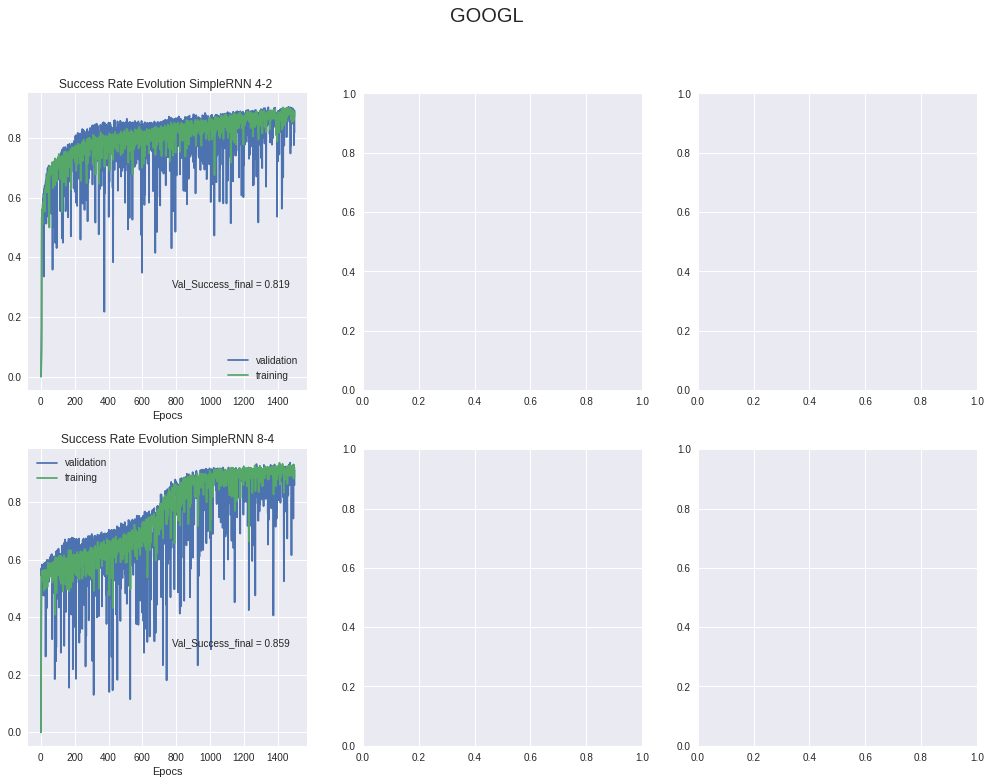

In [13]:
fig, axes = plt.subplots(2, 3,figsize=(17, 12))
fig.suptitle(tickers.Symbol[index],fontsize = 20)

# Plot de la RNN 8-4
axes[0,0].plot(history_RNN84.epoch,history_RNN84.history['val_porcentaje_margen'],label='validation')
axes[0,0].plot(history_RNN84.epoch,history_RNN84.history['porcentaje_margen'],label="training")
axes[0,0].legend()
axes[0,0].set_title('Success Rate Evolution SimpleRNN 4-2 ')
axes[0,0].set_xlabel('Epocs')
axes[0,0].annotate('Val_Success_final = %.3f'% history_RNN84.history['val_porcentaje_margen'][-1], (1250, 0.3), xytext=(-80, 0), 
            textcoords='offset points',fontsize = 10)


# Plot de la RNN 16-8
axes[1,0].plot(history_RNN168.epoch,history_RNN168.history['val_porcentaje_margen'],label='validation')
axes[1,0].plot(history_RNN168.epoch,history_RNN168.history['porcentaje_margen'],label="training")
axes[1,0].legend()
axes[1,0].set_title('Success Rate Evolution SimpleRNN 8-4')
axes[1,0].set_xlabel('Epocs')
axes[1,0].annotate('Val_Success_final = %.3f'% history_RNN168.history['val_porcentaje_margen'][-1], (1250, 0.3), xytext=(-80, 0), 
            textcoords='offset points',fontsize = 10)

# Plot de la GRU 16-8
axes[0,1].plot(history_GRU168.epoch,history_GRU168.history['val_porcentaje_margen'],label='validation')
axes[0,1].plot(history_GRU168.epoch,history_GRU168.history['porcentaje_margen'],label="training")
axes[0,1].legend()
axes[0,1].set_title('Success Rate Evolution GRU 16-8')
axes[0,1].set_xlabel('Epocs')
axes[0,1].annotate('Val_Success_final = %.3f'% history_GRU168.history['val_porcentaje_margen'][-1], (1250, 0.12), xytext=(-80, 0), 
            textcoords='offset points',fontsize = 10)

# Plot de la GRU 16-8-4
axes[1,1].plot(history_GRU1684.epoch,history_GRU1684.history['val_porcentaje_margen'],label='validation')
axes[1,1].plot(history_GRU1684.epoch,history_GRU1684.history['porcentaje_margen'],label="training")
axes[1,1].legend()
axes[1,1].set_title('Success Rate Evolution GRU 8-4')
axes[1,1].set_xlabel('Epocs')
axes[1,1].annotate('Val_Success_final = %.3f'% history_GRU1684.history['val_porcentaje_margen'][-1], (1250, 0.3), xytext=(-80, 0), 
            textcoords='offset points',fontsize = 10)

# Plot de la LSTM 8-4
axes[0,2].plot(history_LSTM84.epoch,history_LSTM84.history['val_porcentaje_margen'],label='validation')
axes[0,2].plot(history_LSTM84.epoch,history_LSTM84.history['porcentaje_margen'],label="training")
axes[0,2].legend()
axes[0,2].set_title('Success Rate Evolution LSTM 4-2')
axes[0,2].set_xlabel('Epocs')
axes[0,2].annotate('Val_Success_final = %.3f'% history_LSTM84.history['val_porcentaje_margen'][-1], (1250, 0.3), xytext=(-80, 0), 
            textcoords='offset points',fontsize = 10)

# Plot de la LSTM 16-8
axes[1,2].plot(history_LSTM168.epoch,history_LSTM168.history['val_porcentaje_margen'],label='validation')
axes[1,2].plot(history_LSTM168.epoch,history_LSTM168.history['porcentaje_margen'],label="training")
axes[1,2].legend()
axes[1,2].set_title('Success Rate Evolution LSTM 8-4')
axes[1,2].set_xlabel('Epocs')
axes[1,2].annotate('Val_Success_final = %.3f'% history_LSTM168.history['val_porcentaje_margen'][-1], (1250, 0.3), xytext=(-80, 0), 
            textcoords='offset points',fontsize = 10)

plt.show()

In [15]:
# Calculo la prediccion para mi conjunto test
predictedRNN84 = pd.DataFrame(modelRNN84.predict(Xtt))
predictedRNN168 = pd.DataFrame(modelRNN168.predict(Xtt))
predictedGRU168 = pd.DataFrame(modelGRU168.predict(Xtt))
predictedGRU1684 = pd.DataFrame(modelGRU1684.predict(Xtt))
predictedLSTM84 = pd.DataFrame(modelLSTM84.predict(Xtt))
predictedLSTM168 = pd.DataFrame(modelLSTM168.predict(Xtt))

# Junto la grafica de los datos de entrenamiento y test para ver cuanto a variado en terminos generales
indicedetiempo = pd.concat((index_time,index_time_t), axis = 0)
yt = pd.DataFrame(yt) ; ytt = pd.DataFrame(ytt)
stock_real_value = pd.concat((yt,ytt),axis = 0)

# Calculo el RMSE para ver el error de prediccion
rmseRNN84 = sqrt(mean_squared_error(ytt, predictedRNN84))
rmseRNN168 = sqrt(mean_squared_error(ytt, predictedRNN168))
rmseGRU168 = sqrt(mean_squared_error(ytt, predictedGRU168))
rmseGRU1684 = sqrt(mean_squared_error(ytt, predictedGRU1684))
rmseLSTM84 = sqrt(mean_squared_error(ytt, predictedLSTM84))
rmseLSTM168 = sqrt(mean_squared_error(ytt, predictedLSTM168))
print(rmseRNN84,rmseRNN168,rmseGRU168,rmseGRU1684,rmseLSTM84,rmseLSTM168)

NameError: name 'predictedGRU168' is not defined

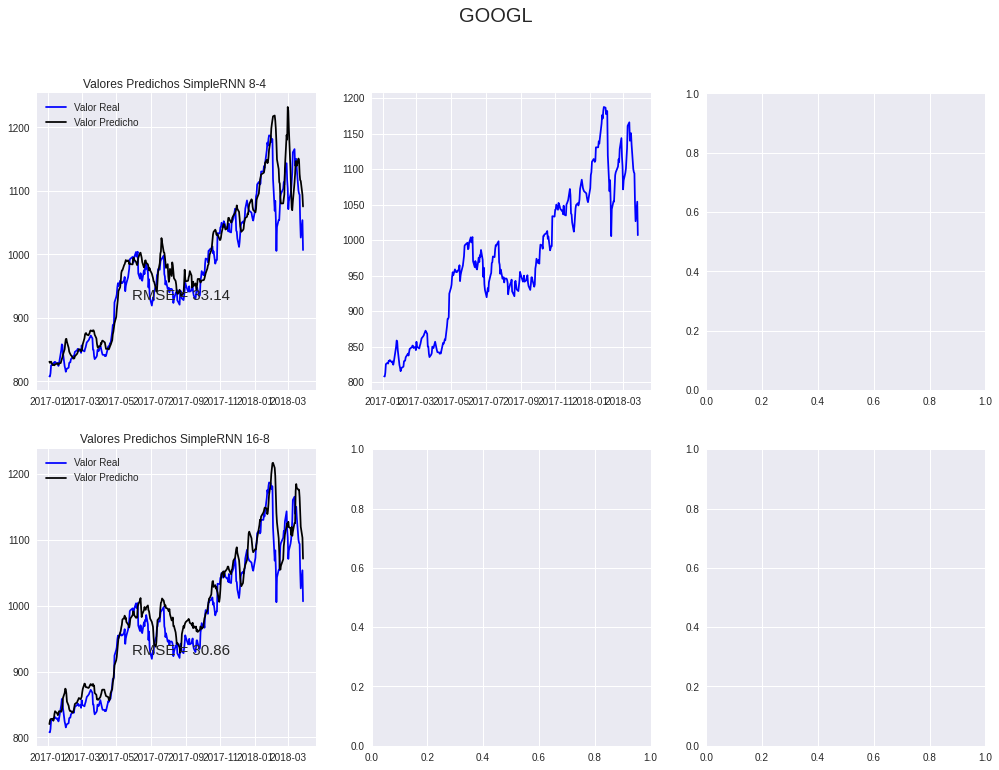

In [16]:
fig, axes = plt.subplots(2, 3,figsize=(17, 12))
fig.suptitle(tickers.Symbol[index],fontsize = 20)


# Plot de la RNN 8-4
axes[0,0].plot(index_time_t,ytt,label="Valor Real",color = "blue")
axes[0,0].plot(index_time_t,predictedRNN84, label="Valor Predicho", color = "black")
axes[0,0].legend()
axes[0,0].set_title('Valores Predichos SimpleRNN 8-4 ')
axes[0,0].annotate('RMSE = %.2f'% rmseRNN84, (index_time_t[40], ytt.iloc[40]), xytext=(50, 50), 
            textcoords='offset points',fontsize = 15)


# Plot de la RNN 16-8
axes[1,0].plot(index_time_t,ytt,label="Valor Real",color = "blue")
axes[1,0].plot(index_time_t,predictedRNN168, label="Valor Predicho", color = "black")
axes[1,0].legend()
axes[1,0].set_title('Valores Predichos SimpleRNN 16-8 ')
axes[1,0].annotate('RMSE = %.2f'% rmseRNN168, (index_time_t[40], ytt.iloc[40]), xytext=(50, 50), 
            textcoords='offset points',fontsize = 15)

# Plot de la GRU 16-8
axes[0,1].plot(index_time_t,ytt,label="Valor Real",color = "blue")
axes[0,1].plot(index_time_t,predictedGRU168, label="Valor Predicho", color = "black")
axes[0,1].legend()
axes[0,1].set_title('Valores Predichos GRU 16-8 ')
axes[0,1].annotate('RMSE = %.2f'% rmseGRU168, (index_time_t[40], ytt.iloc[40]), xytext=(50, 50), 
            textcoords='offset points',fontsize = 15)

# Plot de la GRU 16-8-4
axes[1,1].plot(index_time_t,ytt,label="Valor Real",color = "blue")
axes[1,1].plot(index_time_t,predictedGRU1684, label="Valor Predicho", color = "black")
axes[1,1].legend()
axes[1,1].set_title('Valores Predichos GRU 16-8-4')
axes[1,1].annotate('RMSE = %.2f'% rmseGRU1684, (index_time_t[40], ytt.iloc[40]), xytext=(50, 50), 
            textcoords='offset points',fontsize = 15)

# Plot de la LSTM 8-4
axes[0,2].plot(index_time_t,ytt,label="Valor Real",color = "blue")
axes[0,2].plot(index_time_t,predictedLSTM84, label="Valor Predicho", color = "black")
axes[0,2].legend()
axes[0,2].set_title('Valores Predichos LSTM 8-4 ')
axes[0,2].annotate('RMSE = %.2f'% rmseLSTM84, (index_time_t[40], ytt.iloc[40]), xytext=(50, 50), 
            textcoords='offset points',fontsize = 15)

# Plot de la LSTM 16-8
axes[1,2].plot(index_time_t,ytt,label="Valor Real",color = "blue")
axes[1,2].plot(index_time_t,predictedLSTM168, label="Valor Predicho", color = "black")
axes[1,2].legend()
axes[1,2].set_title('Valores Predichos LSTM 16-8')
axes[1,2].annotate('RMSE = %.2f'% rmseLSTM168, (index_time_t[40], ytt.iloc[40]), xytext=(50, 50), 
            textcoords='offset points',fontsize = 15)

plt.show()

Queremos realizar una inversion de 100000 euros en el activo que hemos estudiado, nos basamos en un margen entre la diferencia de los dos precios adyacentes para saber si comprar, vender o mantener.
Tenemos 3 posibles caminos, comprar solo a la alza, comprar solo a la baja o comprar a la alza y a la baja.
Ciertos actios tienen caidas o subidas muy bruscas imposibles de predecir porque no tienen que ver con los datos historicos si no con la situacion y el contexto que vive la empresa

In [58]:
pd.options.display.max_rows = 10000 # Para poder ver todos los movimientos
predicted_stock_price = predictedRNN168
# Es un margen movil, segun lo que busquemos
margen = 0.03
diferencias = np.zeros(len(predicted_stock_price)-1)
for i in range(len(diferencias)):
    diferencias[i] = (predicted_stock_price.iloc[i+1,0]-predicted_stock_price.iloc[i,0])/max(predicted_stock_price.iloc[i+1,0],predicted_stock_price.iloc[i,0])
    if diferencias[i] > margen:
        diferencias[i] = 1
    elif diferencias[i] < -margen:
        diferencias[i] = -1
    else:
        diferencias[i] = 0
    
print(Counter(diferencias))

Counter({0.0: 307, 1.0: 1})


In [59]:
# Si solo queremos comrpar a la alza
# Estado es lo que hay que hacer ese dia
# estado = 1 comprar, estado = 0 mantener, estado = -1 vender
movimientos_alza = pd.DataFrame(columns = ["presupuesto","acciones","estado","valor","pred","dif"],index = index_time_t)
movimientos_alza.presupuesto[0] = 100000 ; movimientos_alza.acciones[0] = 0 ; movimientos_alza.estado[0] = 0
movimientos_alza.valor[0] = ytt.iloc[0,0] ; movimientos_alza.pred[0] = predicted_stock_price.iloc[0,0]

for i in range(1,len(diferencias)):
    if diferencias[i] == 1:
        if movimientos_alza.acciones[i-1] == 0:
            movimientos_alza.estado[i] = 1
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1] % ytt.iloc[i,0]
            movimientos_alza.acciones[i] = movimientos_alza.presupuesto[i-1] // ytt.iloc[i,0]
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]
        else:
            movimientos_alza.estado[i] = 0
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1]
            movimientos_alza.acciones[i] = movimientos_alza.acciones[i-1]
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]
    elif diferencias[i] == 0:
            movimientos_alza.estado[i] = 0
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1]
            movimientos_alza.acciones[i] = movimientos_alza.acciones[i-1]
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]
    elif diferencias[i] == -1:
        if movimientos_alza.acciones[i-1] > 0:
            movimientos_alza.estado[i] = -1
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1] + movimientos_alza.acciones[i-1] * ytt.iloc[i,0]
            movimientos_alza.acciones[i] = 0
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]
        else:
            movimientos_alza.estado[i] = 0
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1]
            movimientos_alza.acciones[i] = movimientos_alza.acciones[i-1]
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]

            
movimientos_alza = movimientos_alza.drop(movimientos_alza.tail(1).index)
print(movimientos_alza.tail(1))
valor_f_alza = movimientos_alza.presupuesto[len(movimientos_alza)-1] + movimientos_alza.valor[len(movimientos_alza)-1] * movimientos_alza.acciones[len(movimientos_alza)-1]
ganancia_alza = valor_f_alza - 100000
print('Valor Final = %.2f' % valor_f_alza)
print('Ganancia con margen = %.2f' % ganancia_alza)

           presupuesto acciones estado    valor     pred dif
2018-03-26      827.83       87      0  1054.09  1103.47   0
Valor Final = 92533.66
Ganancia con margen = -7466.34


In [44]:
print(movimientos_alza)

           presupuesto acciones acciones_debo estado    valor     pred  dif
2016-12-30      100000        0             0      0     38.3  43.1799  NaN
2017-01-03      199972        0          2568     -1    38.93   43.227   -1
2017-01-04      199972        0          2568      0    39.66  42.9557   -1
2017-01-05       99923        0             0      1    38.96  42.5517    1
2017-01-06      199833        0          2587     -1    38.62  43.4381   -1
2017-01-09      199833        0          2587      0    38.45  43.3545   -1
2017-01-10      199833        0          2587      0    38.36  43.0065   -1
2017-01-11      199833        0          2587      0       39  42.6662   -1
2017-01-12      199833        0          2587      0    38.52  42.4598   -1
2017-01-13      199833        0          2587      0    38.81  42.3253   -1
2017-01-17      199833        0          2587      0     37.8  42.1163   -1
2017-01-18      199833        0          2587      0    37.95  41.9717   -1
2017-01-19  

In [60]:
movimientos_alza.to_csv("/home/cesar/Documentos/Git/TFG_Informatica/TFG/Decisiones/GOOGL/Alza3RNN-168.csv")

In [61]:
# Compro a la alza y a la baja
# movimiento que se realizao en el dia = estado
# estado = 1 comprar, estado = 0 mantener, estado = -1 vender
movimientos_ab= pd.DataFrame(columns = ["presupuesto","acciones","acciones_debo","estado","valor","pred","dif"],index = index_time_t)
movimientos_ab.presupuesto[0] = 100000 % ytt.iloc[0,0] ; movimientos_ab.acciones[0] = 100000 // ytt.iloc[0,0] ; movimientos_ab.acciones_debo[0] = 0 ;
movimientos_ab.estado[0] = 0 ; movimientos_ab.valor[0] = ytt.iloc[0,0] ;
movimientos_ab.pred[0] = predicted_stock_price.iloc[0,0] 

for i in range(1,len(diferencias)):
    if diferencias[i] == 1:
        if movimientos_ab.acciones[i-1] == 0:
            movimientos_ab.estado[i] = 1
            movimientos_ab.presupuesto[i] = ((movimientos_ab.presupuesto[i-1] - (movimientos_ab.acciones_debo[i-1] * ytt.iloc[i,0]))
                                         % ytt.iloc[i,0])
            movimientos_ab.acciones[i] = ((movimientos_ab.presupuesto[i-1] - (movimientos_ab.acciones_debo[i-1] * ytt.iloc[i,0]))
                                         // ytt.iloc[i,0])
            movimientos_ab.acciones_debo[i] = 0
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
        else:
            movimientos_ab.estado[i] = 0
            movimientos_ab.presupuesto[i] = movimientos_ab.presupuesto[i-1]
            movimientos_ab.acciones[i] = movimientos_ab.acciones[i-1]
            movimientos_ab.acciones_debo[i] = movimientos_ab.acciones_debo[i-1]
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
    elif diferencias[i] == 0:
            movimientos_ab.estado[i] = 0
            movimientos_ab.presupuesto[i] = movimientos_ab.presupuesto[i-1]
            movimientos_ab.acciones[i] = movimientos_ab.acciones[i-1]
            movimientos_ab.acciones_debo[i] = movimientos_ab.acciones_debo[i-1]
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
    elif diferencias[i] == -1:
        if movimientos_ab.acciones_debo[i-1] == 0:
            movimientos_ab.estado[i] = -1
            movimientos_ab.presupuesto[i] = ((movimientos_ab.presupuesto[i-1] + movimientos_ab.acciones[i-1] * ytt.iloc[i,0]) +
                                          ((movimientos_ab.presupuesto[i-1] + movimientos_ab.acciones[i-1] * ytt.iloc[i,0]) //
                                           ytt.iloc[i,0]) * ytt.iloc[i,0])
            movimientos_ab.acciones[i] = 0
            movimientos_ab.acciones_debo[i] = ((movimientos_ab.presupuesto[i-1] + movimientos_ab.acciones[i-1] * ytt.iloc[i,0]) //
                                           ytt.iloc[i,0]) # Las pido prestadas
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
        else:
            movimientos_ab.estado[i] = 0
            movimientos_ab.presupuesto[i] = movimientos_ab.presupuesto[i-1]
            movimientos_ab.acciones[i] = movimientos_ab.acciones[i-1]
            movimientos_ab.acciones_debo[i] = movimientos_ab.acciones_debo[i-1]
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
            
movimientos_ab = movimientos_ab.drop(movimientos_ab.tail(1).index)
print(movimientos_ab.tail(1))
if movimientos_ab.acciones_debo[len(movimientos_ab)-1] == 0 :
    valor_f_ab = movimientos_ab.presupuesto[len(movimientos_ab)-1] + movimientos_ab.valor[len(movimientos_ab)-1] * movimientos_ab.acciones[len(movimientos_ab)-1]
else:
    valor_f_ab = movimientos_ab.presupuesto[len(movimientos_ab)-1] - movimientos_ab.valor[len(movimientos_ab)-1] * movimientos_ab.acciones_debo[len(movimientos_ab)-1]
ganancia_ab = valor_f_ab - 100000
print('Valor Final = %.2f' % valor_f_ab)
print('Ganancia con margen = %.2f' % ganancia_ab)

           presupuesto acciones acciones_debo estado    valor     pred dif
2018-03-26      614.77      123             0      0  1054.09  1103.47   0
Valor Final = 130267.84
Ganancia con margen = 30267.84


In [62]:
print(movimientos_ab)

           presupuesto acciones acciones_debo estado    valor     pred  dif
2017-01-03      614.77      123             0      0   808.01  820.272  NaN
2017-01-04      614.77      123             0      0   807.77  825.642    0
2017-01-05      614.77      123             0      0   813.02  827.773    0
2017-01-06      614.77      123             0      0   825.21  828.083    0
2017-01-09      614.77      123             0      0   827.18  828.395    0
2017-01-10      614.77      123             0      0   826.01  825.378    0
2017-01-11      614.77      123             0      0   829.86  829.201    0
2017-01-12      614.77      123             0      0   829.53    835.9    0
2017-01-13      614.77      123             0      0   830.94  839.849    0
2017-01-17      614.77      123             0      0   827.46  836.366    0
2017-01-18      614.77      123             0      0   829.02  833.828    0
2017-01-19      614.77      123             0      0   824.37  836.599    0
2017-01-20  

In [63]:
movimientos_ab.to_csv("/home/cesar/Documentos/Git/TFG_Informatica/TFG/Decisiones/GOOGL/AlzaBaja3RNN-168.csv")

In [64]:
# Compro a la baja
# movimiento que se realizao en el dia = estado
# estado = 1 comprar, estado = 0 mantener, estado = -1 vender
movimientos_baja = pd.DataFrame(columns = ["presupuesto","acciones","acciones_debo","estado","valor","pred","dif"],index = index_time_t)
movimientos_baja.presupuesto[0] = 100000  ; movimientos_baja.acciones[0] = 0 ; movimientos_baja.acciones_debo[0] = 0 ;
movimientos_baja.estado[0] = 0 ; movimientos_baja.valor[0] = ytt.iloc[0,0] ;
movimientos_baja.pred[0] = predicted_stock_price.iloc[0,0] 

for i in range(1,len(diferencias)):
    if diferencias[i] == 1:
        if movimientos_baja.acciones[i-1] == 0:
            movimientos_baja.estado[i] = 1
            movimientos_baja.presupuesto[i] = ((movimientos_baja.presupuesto[i-1] - (movimientos_baja.acciones_debo[i-1] * ytt.iloc[i,0])))
            movimientos_baja.acciones[i] = 0
            movimientos_baja.acciones_debo[i] = 0
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
        else:
            movimientos_baja.estado[i] = 0
            movimientos_baja.presupuesto[i] = movimientos_baja.presupuesto[i-1]
            movimientos_baja.acciones[i] = movimientos_baja.acciones[i-1]
            movimientos_baja.acciones_debo[i] = movimientos_baja.acciones_debo[i-1]
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
    elif diferencias[i] == 0:
            movimientos_baja.estado[i] = 0
            movimientos_baja.presupuesto[i] = movimientos_baja.presupuesto[i-1]
            movimientos_baja.acciones[i] = movimientos_baja.acciones[i-1]
            movimientos_baja.acciones_debo[i] = movimientos_baja.acciones_debo[i-1]
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
    elif diferencias[i] == -1:
        if movimientos_baja.acciones_debo[i-1] == 0:
            movimientos_baja.estado[i] = -1
            movimientos_baja.presupuesto[i] = ((movimientos_baja.presupuesto[i-1]) + (movimientos_baja.presupuesto[i-1] //
                                           ytt.iloc[i,0]) * ytt.iloc[i,0])
            movimientos_baja.acciones[i] = 0
            movimientos_baja.acciones_debo[i] = (movimientos_baja.presupuesto[i-1] // ytt.iloc[i,0]) # Las pido prestadas
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
        else:
            movimientos_baja.estado[i] = 0
            movimientos_baja.presupuesto[i] = movimientos_baja.presupuesto[i-1]
            movimientos_baja.acciones[i] = movimientos_baja.acciones[i-1]
            movimientos_baja.acciones_debo[i] = movimientos_baja.acciones_debo[i-1]
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
            
movimientos_baja = movimientos_baja.drop(movimientos_baja.tail(1).index)
print(movimientos_baja.tail(1))
if movimientos_baja.acciones_debo[len(movimientos_baja)-1] == 0 :
    valor_f_baja = movimientos_baja.presupuesto[len(movimientos_baja)-1] + movimientos_baja.valor[len(movimientos_baja)-1] * movimientos_baja.acciones_debo[len(movimientos_baja)-1]
else:
    valor_f_baja = movimientos_baja.presupuesto[len(movimientos_baja)-1] - movimientos_baja.valor[len(movimientos_baja)-1] * movimientos_baja.acciones_debo[len(movimientos_baja)-1]
ganancia_baja = valor_f_baja - 100000
print('Valor Final = %.2f' % valor_f_baja)
print('Ganancia con margen = %.2f' % ganancia_baja)

           presupuesto acciones acciones_debo estado    valor     pred dif
2018-03-26      100000        0             0      0  1054.09  1103.47   0
Valor Final = 100000.00
Ganancia con margen = 0.00


In [65]:
print(movimientos_baja)

           presupuesto acciones acciones_debo estado    valor     pred  dif
2017-01-03      100000        0             0      0   808.01  820.272  NaN
2017-01-04      100000        0             0      0   807.77  825.642    0
2017-01-05      100000        0             0      0   813.02  827.773    0
2017-01-06      100000        0             0      0   825.21  828.083    0
2017-01-09      100000        0             0      0   827.18  828.395    0
2017-01-10      100000        0             0      0   826.01  825.378    0
2017-01-11      100000        0             0      0   829.86  829.201    0
2017-01-12      100000        0             0      0   829.53    835.9    0
2017-01-13      100000        0             0      0   830.94  839.849    0
2017-01-17      100000        0             0      0   827.46  836.366    0
2017-01-18      100000        0             0      0   829.02  833.828    0
2017-01-19      100000        0             0      0   824.37  836.599    0
2017-01-20  

In [66]:
movimientos_baja.to_csv("/home/cesar/Documentos/Git/TFG_Informatica/TFG/Decisiones/GOOGL/Baja3RNN-168.csv")